<a href="https://colab.research.google.com/github/RGivisiez/credit-card-risk-analysis/blob/main/Default_risk_Nubank_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

-------

# Risco de Inadimplência

Este dataset foi parte de uma competição promovida pelo Nubank, uma Fintech brasileira, com o intuito de buscar por novos talentos. Um dos objetivos propostos pelo Nubank era o de identificar o risco de default, que é o risco de inadimplência do cliente, antes mesmos do cliente receber o cartão de crédito. Desta forma o Nubank consegue diminuir suas perdas com dívidas não pagas.

> O objetivo é usar as informações disponíveis no datatset para identificar os clientes que tem mais chances de incorrer em default.

# Comentários sobre o dataset e a abordagem

> **Variável alvo:** A variável `target_default` é o que vamos tentar prever.

Este dataset possui as classes desbalanceadas por natureza, pois é esperado que o número de clientes que não cumprem com as suas obrigações com o banco sejam poucos. Esse é um dos pontos que deixam as análises e previsão mais difíceis, não temos informação suficiente sobre os clientes que ocorrem em default. A imagem abaixo mostra o quanto o dataset é desbalanceado.

![imbalance](img/imbalance.png)

Existem algumas técnicas utilizadas para compensar esse desbalanço de classe, como o [Under Sample](https://imbalanced-learn.org/stable/under_sampling.html) ou [Over Sample](https://imbalanced-learn.org/stable/over_sampling.html). Porém, esses métodos podem distorcer muito os dados e fazer com que os algoritmos não tenham um bom desempenho em dados novos. O ideal é utilizar o dataset completo e lidar com o desbalanço de classe sem fazer nenhuma modificação no dataset. Neste notebook, nós vamos utilizar as duas formas, usaremos o dataset completo e o dataset após o Under Sample.

# Abordagem para criar novas features e procurar padrões

Como esse é um dataset difícil, com as features tendo pouca ou nenhuma correlação com a variável alvo `target_default`, temos que buscar por features novas. A ideia principal é tentar encontrar features com probabilidades assimétricas, como a feature `facebook_profile` na imagem abaixo. Note que clientes no grupo da classe $0$, possuem uma chance maior de não incorrer em default, enquanto o grupo de clientes com a classe $2$ tem uma chance maior de incorrer em default.

![imbalance](img/facebook_profile.png)

Como será visto, durante as avaliações dos modelos, principalmente o de Decision Tree, é bem claro que features com essas assimetrias são importantes e facilitam a identificação de clientes que ocorrem em default. Porém, não temos muitas dessas features disponíveis, temos que tratar alguns dados para encontrá-las. As que eu encontrei foram `facebook_profile`, `ddd`, `score_1`, `external_data_provider_email_seen_before` e `application_time_applied`.

1. `facebook_profile`: Pessoas que não colocam o link do seu Facebook ao preencher a inscrição tem mais chances de ocorrem em default (é a classe $2.0$).

1. `ddd`: Alguns valores de DDD são mais utilizados por clientes que ocorrem em default. 
  > Colocar informação sobre o DDD dentro de um modelo desses tem que ser feito com cuidado. As vezes o DDD pode indicar que temos uma região do país, como São Paulo, onde temos um número grande de pessoas utilizando o cartão do Nubank. Sendo assim, é esperado que nessa região também tenhamos um número maior de pessoas incorrendo em default.

2. `score_1`: Score de uma empresa externa, onde algumas das classes apresentam assimetrias.

3. `external_data_provider_email_seen_before`: Emails que foram utilizados poucas vezes em outros cadastros, tem mais chance de serem de clientes que vão incorrer em default. 
  > Obviamente, emails pouco usados podem ter sido criados somente com o inuito de criar uma conta no banco, pegar o dinheiro emprestado e nunca pagar.

1. `application_time_applied`: Pessoas que fazem o cadastro durante a madruga, tem mais chance de incorrerem em default.

# Como devemos comprar os modelos e avaliar os resultados

Vamos utilizar a métrica PR-AUC ([site pessoal](https://rgivisiez.github.io/post/ROC-PR/)) para avaliar qual é o melhor modelo e a métrica de Recall([site pessoal](https://rgivisiez.github.io/post/ROC-PR/)) para maximizar a taxa de verdadeiros positivos, i.e., queremos identificar a maior quantidade de clientes que irão incorrer em default.

> De forma mais geral, utilizamos a curva PR para avaliar modelos treinados em datasets com desbalanço de classe, mas como estamos interessados em diminuir o número de falsos negativos e aumentar o número de verdadeiros positivos, podemos utilizar essa curva mesmo em dataset balanceados. Sendo assim, independente do dataset utilizado, o completo ou com o Under Sample, vamos usar as mesmas métricas. 

# Abre os arquivos e mostra o desbalanço de classes

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ast
import tensorflow as tf
print(tf.__version__), tf.config.list_physical_devices('GPU')

2.7.0


(None, [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')])

In [3]:
#@title Abre os datasets
df = pd.read_csv('acquisition_train.csv')
df_test = pd.read_csv('acquisition_test.csv')

A `target_fraud` traz informação sobre fraude no dataset e faz parte de outra parte da competição do Nubank, por isso não vamos considerar essa feature. Outra variável que deve ser retirada é a `credit_limit`, pois queremos usar apenas dados que são conhecidos na fase de aplicação, temos que prever o risco de default antes do cliente entrar no banco.

In [4]:
#@title Retirando target_fraud e credit_limit

df_clean = df.drop(['target_fraud', 'credit_limit'], axis=1).copy()
df_test = df_test.drop(['credit_limit'], axis=1)

Default: 16% 
No default: 84% 



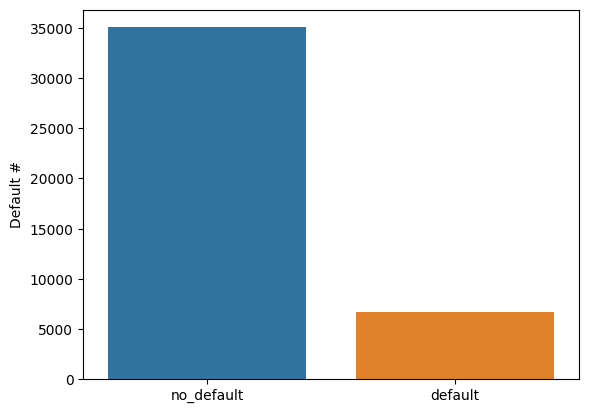

In [5]:
#@title Desbalanço de classes

aux = df['target_default'].map({True:'default', False:'no_default'}).value_counts()

sns.barplot(data=aux.reset_index(),
            y='target_default', x='index');

print('Default: {0:2.0f}% \nNo default: {1:2.0f}% \n'.format((aux['default'] * 100 / aux.sum()).round(1), (aux['no_default'] * 100 / aux.sum()).round(1)))
plt.xlabel('')
plt.ylabel('Default #')
plt.show()

# Limpando os dados

O dataset possui 43 features, muitas delas possuem entradas faltando com np.nan. Abaixo vai ser feita a limpeza dos dados e iremos criar novas features com base nas que já temos.

> Um ponto importante é a forma como iremos substituir os np.nan, é provável que indicar para o algoritmo a ausência de informação seja importante. Por exemplo, é possível que clientes com risco alto de default não preencham alguns dados, então é importante destacar isso para o modelo de Machine Learning.

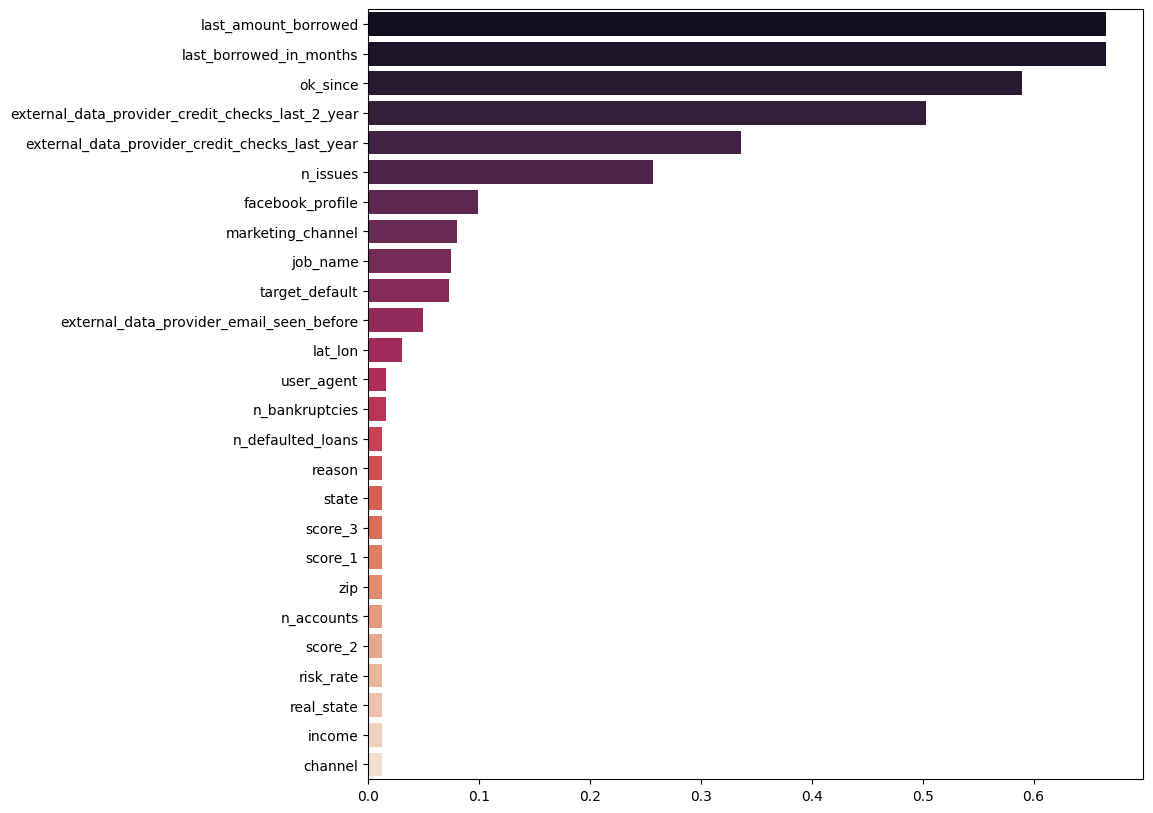

In [6]:
#@title Número de entradas ausentes em cada feature.

plt.figure(figsize=[10, 10])

null_cont = (df_clean.isnull().sum() / df_clean.shape[0]).sort_values(ascending=False)
data = null_cont[null_cont * df_clean.shape[0] > 0.]
sns.barplot(data=pd.DataFrame(data).T, orient='h', palette='rocket')
plt.show()

## Substituindo os valores de NaN nas variáveis



### Funções auxiliares

In [7]:
def splitter(tags, tag_dict):

  '''
     tags:     lista com as tags.

     tag_dict: dicionário para mapear as tags
               em números.

      return:  vetor com 1 na posição onde existe a tag
               e zero do contrário.

     Exemplo: 
             Dado as tags: [tag1, tag3] e o
             dicionário tag_dict: {tag1:1, tag2:2, tag3:3},
             a função retorna o vetor [1, 0, 1].
  '''

  n_tag = len(tag_dict)
  vector = np.zeros(n_tag)
  
  for tag in tags:

    tag_position = tag_dict[tag]
    vector[tag_position] = 1
  
  return vector

In [8]:
def clean_data(data, mode='train'):

  # Clean NaN and $\infty$ in the dataset.
  data['reported_income'] = data['reported_income'].replace(np.inf, np.nan)

  # Considera qualquer número negativo como np.nan.
  mask = data['external_data_provider_email_seen_before'] < 0.1
  data.loc[mask, 'external_data_provider_email_seen_before'] = np.nan

  # Substitui alguns erros de grafia.
  data.loc[data['email'] == 'gmaill.com', 'email'] = 'gmail.com'
  data.loc[data['email'] == 'hotmaill.com', 'email'] = 'hotmail.com'

  #Essas variáveis possuem valores de NaN que não precisam ser preenchidas no
  # cadastro ou que não são conhecidas. Vou trocá-las por algo que indique isso.
  # No caso do facebook_profile, temos 0:não possui perfil, 1:possui o perfil,
  # 0.5:não podemos afirmar nada.
  data['facebook_profile'].replace(np.nan, 0.5, inplace=True)
  data['marketing_channel'].replace(np.nan, 'None', inplace=True)
  data['channel'].replace(np.nan, 'None', inplace=True)
  data['marketing_channel'].replace(np.nan, 'None', inplace=True)
  data['state'].replace(np.nan, 'None', inplace=True)

  # A hora do preenchimento do formulário parece ter relação com uma maior
  # incidência de default, principalmente durante a madrugada.
  data['application_time_applied'] = data['application_time_applied'].str[:2].astype('int64')

  # O valor de -1 indica que não temos conhecimento sobre o número de problemas
  # gerados pelo usuário.
  data['n_issues'].replace(np.nan, -1, inplace=True)

  # O valor 0 indica que o e-mail nunca foi visto.
  data['external_data_provider_email_seen_before'].replace(np.nan, 0, inplace=True)

  # O valor 0 indica que o usuário nunca pegou empréstimo.
  data['last_amount_borrowed'].replace(np.nan, 0, inplace=True)

  # O valor 0 indica que o usuário nunca teve problemas
  data['ok_since'].replace(np.nan, 0, inplace=True)

  # O valor 0 indica que o usuário não pegou empréstimos nos últimos meses.
  data['last_borrowed_in_months'].replace(np.nan, 0, inplace=True)
  data['last_borrowed_in_months'] = data['last_borrowed_in_months'].astype('int8')

  data['job_name'].replace(np.nan, 'None', inplace=True)

  #Essa próxima variável talvez possa ser desconsiderada.
  data['external_data_provider_credit_checks_last_2_year'].replace(np.nan, 1, inplace=True)
  data['external_data_provider_credit_checks_last_year'].replace(np.nan, 0.5, inplace=True)
  data['lat_lon'].replace(np.nan, '(0,0)', inplace=True)

  data['shipping_state'] = data['shipping_state'].apply(lambda x: x.split('-')[1])
  data['ddd'] = data['profile_phone_number'].apply(lambda x: x.split('-')[0])

  data['lat_lon'] = data['lat_lon'].apply(lambda x: ast.literal_eval(x))
  data['lat'] = data['lat_lon'].apply(lambda x: x[0])
  data['lon'] = data['lat_lon'].apply(lambda x: x[1])

  #========= Dividindo as tags ===================
  data['profile_tags'] = data['profile_tags'].str.extract('\[(.*)\]')
  data['profile_tags'] = data['profile_tags'].str.replace("'","").str.replace(",","").str.split(" ")

  tags_list = list(set([tag[0] for tag in data['profile_tags']]))
  tag_dict = {tag:idx for idx, tag in enumerate(tags_list)}

  tag_vector = np.zeros([data['profile_tags'].shape[0], len(tags_list)])

  for idx, value in enumerate(data['profile_tags']):
    
    tag_vector[idx] = splitter(value, tag_dict)

  data = pd.concat([data, pd.DataFrame(tag_vector, columns=tags_list)], axis=1)
  del(tag_vector)
  
  data[tags_list] = data[tags_list].astype(np.uint8)
  #===============================================

  if mode == 'train':

    # Dropa as linhas que não tem entrada em ŷ.
    data = data.loc[data['target_default'].notna()]
    data['target_default'] = data['target_default'].astype(np.float64)

    # Separa a variável alvo do dataset.
    y_hat = data['target_default']
    data.drop('target_default', axis=1, inplace=True)

    return data, y_hat, tags_list

  return data, tags_list

### Limpando os dados e selecionandos as colunas que serão utilizadas

In [9]:
df_clean, y_hat, tags_list = clean_data(df_clean, 'train')

df_clean.reset_index(inplace=True, drop=True)
y_hat.reset_index(inplace=True, drop=True)

In [10]:
# Passando as tags para o valor inteiro.
#df_clean[tags_list] = df_clean[tags_list].astype(np.uint8)

In [11]:
# Features que serão consideradas

cols = [
        'zip',
        #'lat',
        #'lon',
        'shipping_state',
        'state',
        'ddd',
        'marketing_channel',
        'email',
        'job_name',
        'score_1',        # Score de crédito
        'score_2',
        'score_3',
        'score_4',
        'score_5',
        'score_6',
        'risk_rate',      # Taxa de risco
        'last_amount_borrowed', # Valor do último empréstimo que o aplicante tomou
        'last_borrowed_in_months', # Duração do último empréstimo que o aplicante tomou
        'reason', # Razão pela qual foi feita uma consulta naquele cpf
        'income', # Renda estimada pelo provedor dos dados para o aplicante
        'facebook_profile', # Se o aplicante possui perfil no Facebook. (Não é obrigatório para o cadastro)
        'real_state', # Informação sobre habitação do aplicante
        'ok_since', # Quantidade de dias que sem problemas.
        'n_bankruptcies', # Quantidade de bancarrotas que o aplicante já experimentou
        'n_defaulted_loans', # Quantidade de empréstimos não pagos no passado
        'n_accounts', # úmero de contas que o aplicante possui
        'n_issues',   # Número de reclamações de terceiros feitas em alguma das contas do aplicante
        'external_data_provider_email_seen_before', # Se o e-mail já foi consultado junto ao provedor de dados
        'external_data_provider_fraud_score', # Score de fraude
        'reported_income', # Renda informada pelo próprio aplicante
        'application_time_applied', # Horário de aplicação
        'application_time_in_funnel', # Tempo gasto pelo aplicante durante o processo de aplicação
        ]

# Adiciona as tags a lista
cols = cols + tags_list

In [12]:
df_clean = df_clean[cols]

## Criando a Pipeline para preencher os dados ausentes.

Separei a pipeline para limpar as features das outras porque foi utilizá-la em diferentes modelos. E como cada modelo precisa de um pré-processamento diferente, separar essa pipeline das outras é uma forma prática de organizar os testes.

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

### Funções auxiliares

In [14]:
def pandas_cols_after_pipe(data_frame, columns_used, columns_to_use):

  '''
    data_frame:     pandas data frame that cotains the columns names.
    columns_used:   list with columns names that was used in the last pipe.
    columns_to_use: list with columns names that will be used in the next pipe.

    returns a numeric index (idx) of the columns and the new pandas columns order.
  '''

  remainder_cols = list(data_frame.drop(columns_used, axis=1).columns)
  cols_dict = { name:i for i, name in enumerate(columns_used + remainder_cols)}

  cols_idx = [cols_dict[feature] for feature in columns_to_use]
  
  cols_new_order = columns_used + remainder_cols

  return cols_idx, cols_new_order

In [15]:
class ApplyNpFunction(BaseEstimator, TransformerMixin):
    
    '''
       func: função do numpy que vai ser aplicada no array X.
     
       return: Array após aplicar a função (func) escolhida.
    '''

    def __init__(self, func):
        self.func = func

    def transform(self, X, **transformparams):
        trans = self.func(X.astype(np.float64))
        return trans

    def fit(self, X, y=None, **fitparams):
        return self

In [16]:
def logp(x, p=3):
    '''
      Função para aplicar o log(x+p), onde p é uma constante qualquer.
      Útil para quando a variável x possuir valores menores ou iguais a zero,
      onde a função log não poderia ser aplicada.
    '''
    return np.log(x + p)

In [17]:
class ApplyPandas(BaseEstimator, TransformerMixin):
    
    '''
       Cria o dataframe com base no array X de entrada e utiliza algumas
       funcionalidades do pandas. 
       
       Obs.: Pode ser estendida para criar novas features utilizando
       funções do pandas, como o get_dummies e outras, sem a fazer
       outras alterações no pipeline.
    '''

    def __init__(self, columns=[]):
        self.columns = columns

    def transform(self, X, **transformparams):

        data = pd.DataFrame(X, columns=self.columns)
              
        data['reported_income'] = data['reported_income']#.clip(0, 12)
        
        data['income_diff'] = data['reported_income'] - data['income']

        mask = data['n_issues'] < 2.2
        data.loc[mask, 'n_issues'] = 0
        data.loc[~mask, 'n_issues'] = 1

        data = data.astype(np.float32)

        return data

    def fit(self, X, y=None, **fitparams):
        return self

### Pipeline

Não considerei ainda o OneHotEncoder aqui, converti as variáveis categóricas para variáveis numéricas ordenadas. Isso vai ajudar a visualizar e manipular as features do dataset.

> Outro ponto é que não vamos utilizar OneHotEnconder em todos os modelos, então é melhor deixar esse pré-processamento para depois.

In [18]:
# Define qual o método de preenchimento de cada feature.

# Preenche com a mediana.
median_cols = ['reported_income',
             ]

# Preenche com a mais frequente.
freq_cols = ['reason', 'n_bankruptcies',
             'n_defaulted_loans', 'job_name',
             ]

# Transforma as features em categóricas ordenadas.
to_ord = ['score_1', 'score_2',
          'reason', 'facebook_profile',
          'job_name', 'real_state', 'email',
          'marketing_channel',
          'ddd',
          'state',
          'shipping_state',
          'zip',
          'issues_per_account',
         ]

# Aplica np.log nas features.
log_cols = [
            'reported_income',
            'income',
            'n_accounts',
            'n_issues',
            ]

In [19]:
# Seleciona as features que foram escolhidas para serem usadas nos modelos.
to_ord = list(set(cols).intersection(to_ord))
freq_cols = list(set(cols).intersection(freq_cols))
median_cols = list(set(cols).intersection(median_cols))

In [20]:
freq_pipeline = Pipeline([('imputer', SimpleImputer(strategy="most_frequent"))])
median_pipeline = Pipeline([('imputer', SimpleImputer(strategy="median"))])
ord_enconder = Pipeline([('encoder', OrdinalEncoder())])

Usar ColumnTransformer muda a sequência das colunas do dataset do pandas. Então utilizamos a função pandas_cols_after_pipe() para acompanhar a mudança e sabermos exatamente onde estão as colunas.

> Existem outras formas de se fazer isso, como por exemplo o scikit-pandas. O problema é que não é garantido que o scikit-pandas não tem garantia de ser atualizado na mesma velocidade do scikit-learn, no futuro isso pode ser um limitador, então escolhi não usar o scikit-pandas.

In [21]:

pipe_imputer = ColumnTransformer([("imputer_freq", freq_pipeline, freq_cols),
                                  ("imputer_median", median_pipeline, median_cols)],
                                  remainder='passthrough')

cols_idx, cols_new_order = pandas_cols_after_pipe(df_clean,
                                                  freq_cols + median_cols,
                                                  to_ord)

pipe_enconder = ColumnTransformer([("ord_enc", ord_enconder, cols_idx)],
                                  remainder='passthrough')

cols_idx, cols_new_order = pandas_cols_after_pipe(df_clean[cols_new_order],
                                        to_ord, log_cols)

pipe_log = ColumnTransformer([('apply_log', ApplyNpFunction(logp), cols_idx),],
                                remainder='passthrough')

cols_idx, cols_new_order = pandas_cols_after_pipe(df_clean[cols_new_order],
                                                  log_cols, [])

cat_to_num_pipeline = Pipeline([
                                ('imputer', pipe_imputer),
                                ('to_ordinal', pipe_enconder),
                                ('log', pipe_log),
                                ('pandas', ApplyPandas(columns=cols_new_order)),
                              ])

## Transforma o dataset padrão no dataset limpo.

In [22]:
cat_to_num_pipeline = cat_to_num_pipeline.fit(df_clean)
df_clean = cat_to_num_pipeline.transform(df_clean)

#.

-----------------

# Visualiza as features limpas

reported_income


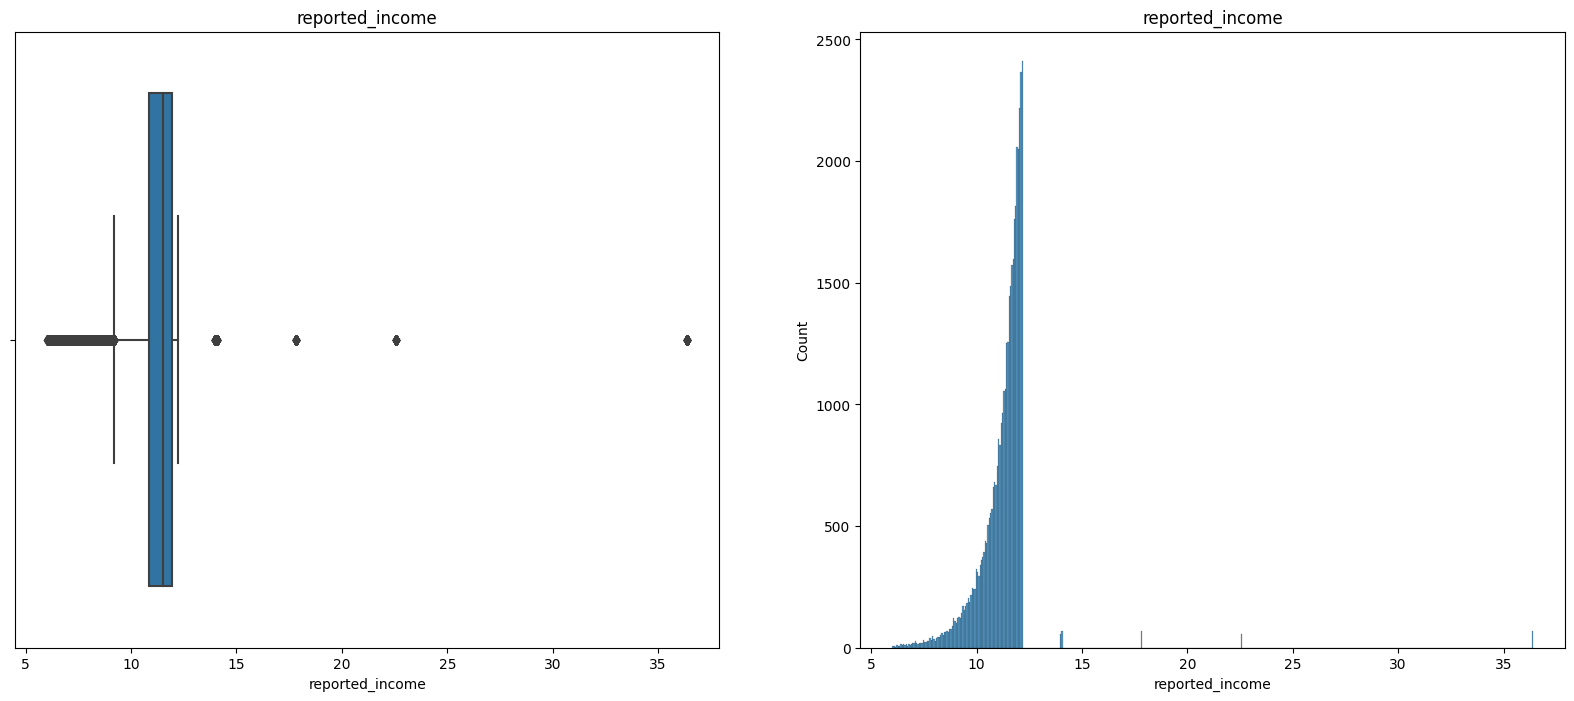

income


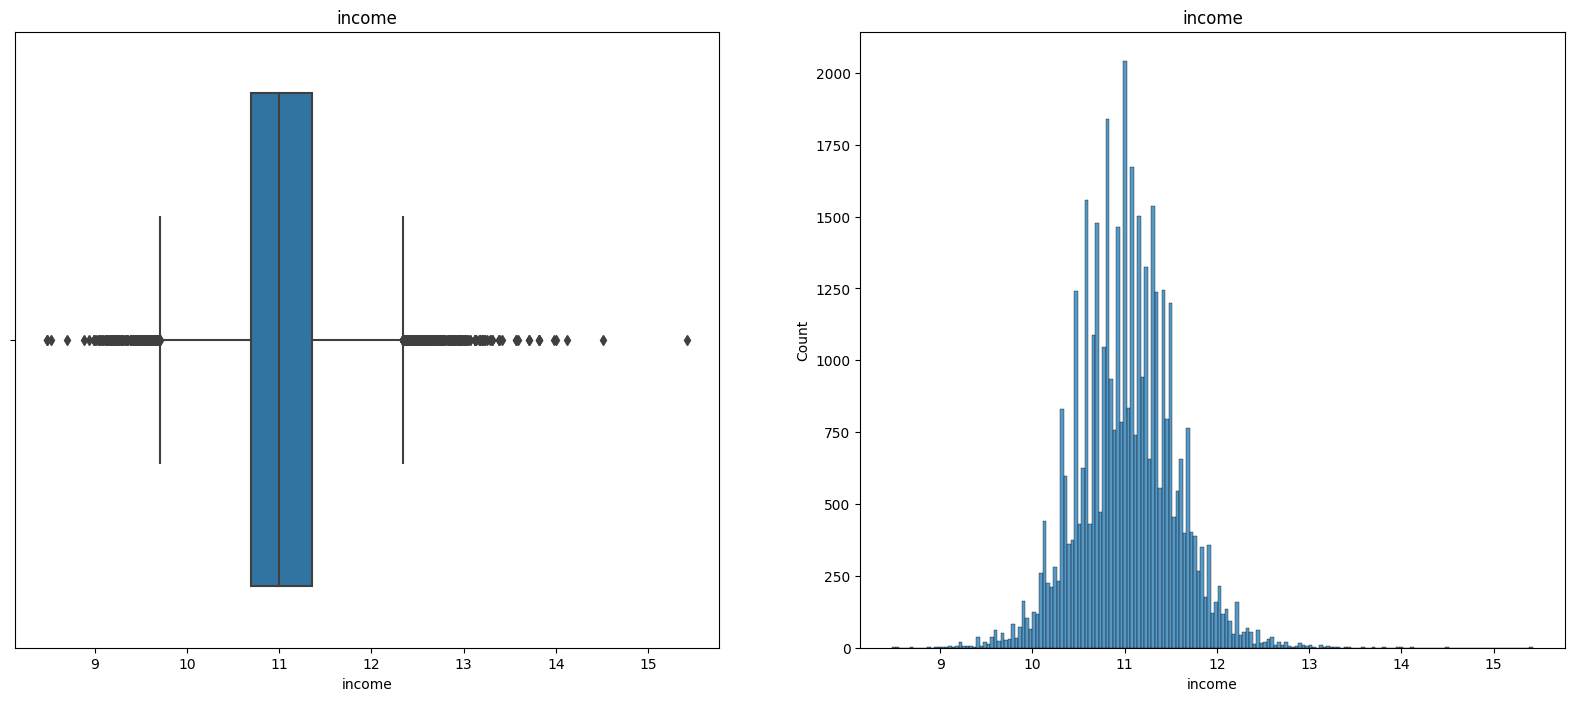

n_accounts


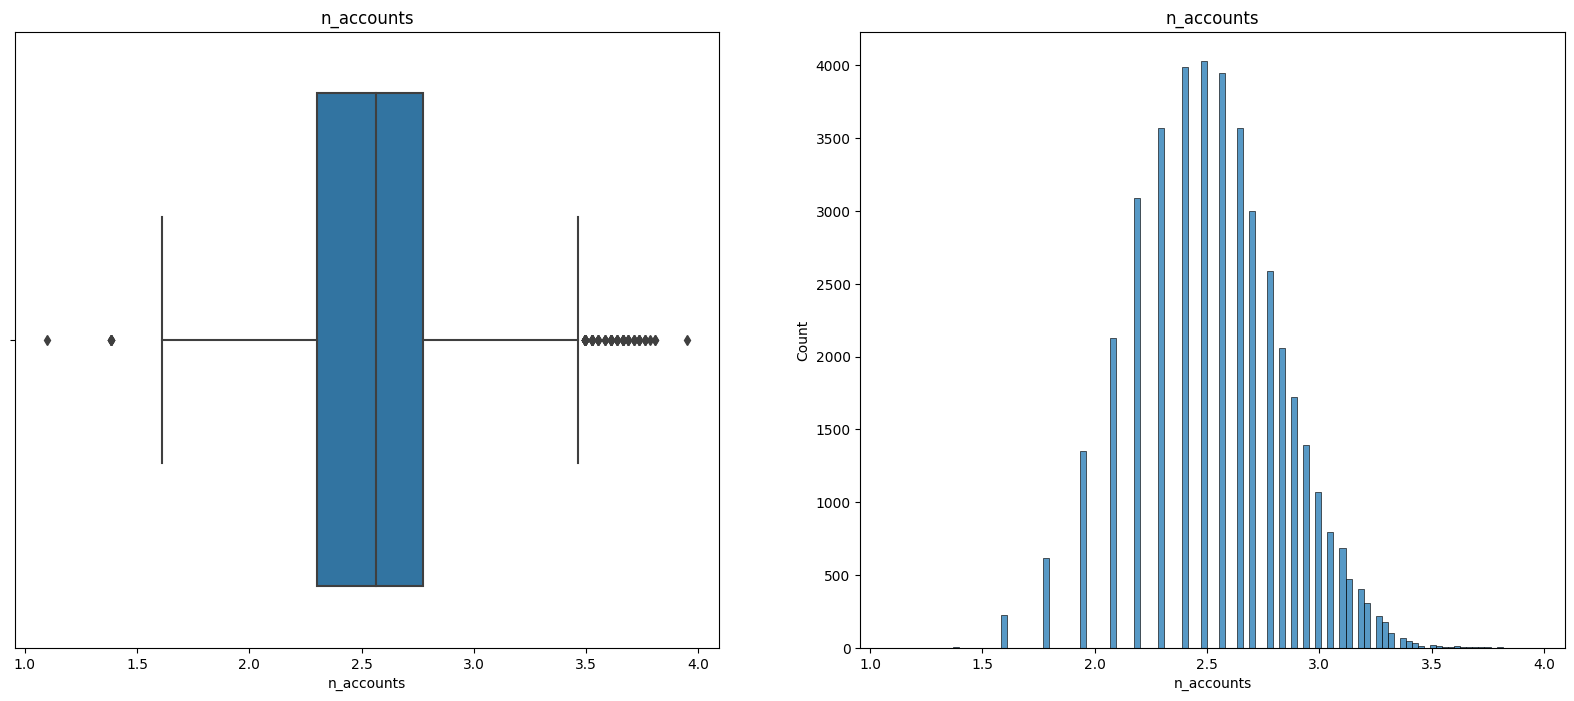

n_issues


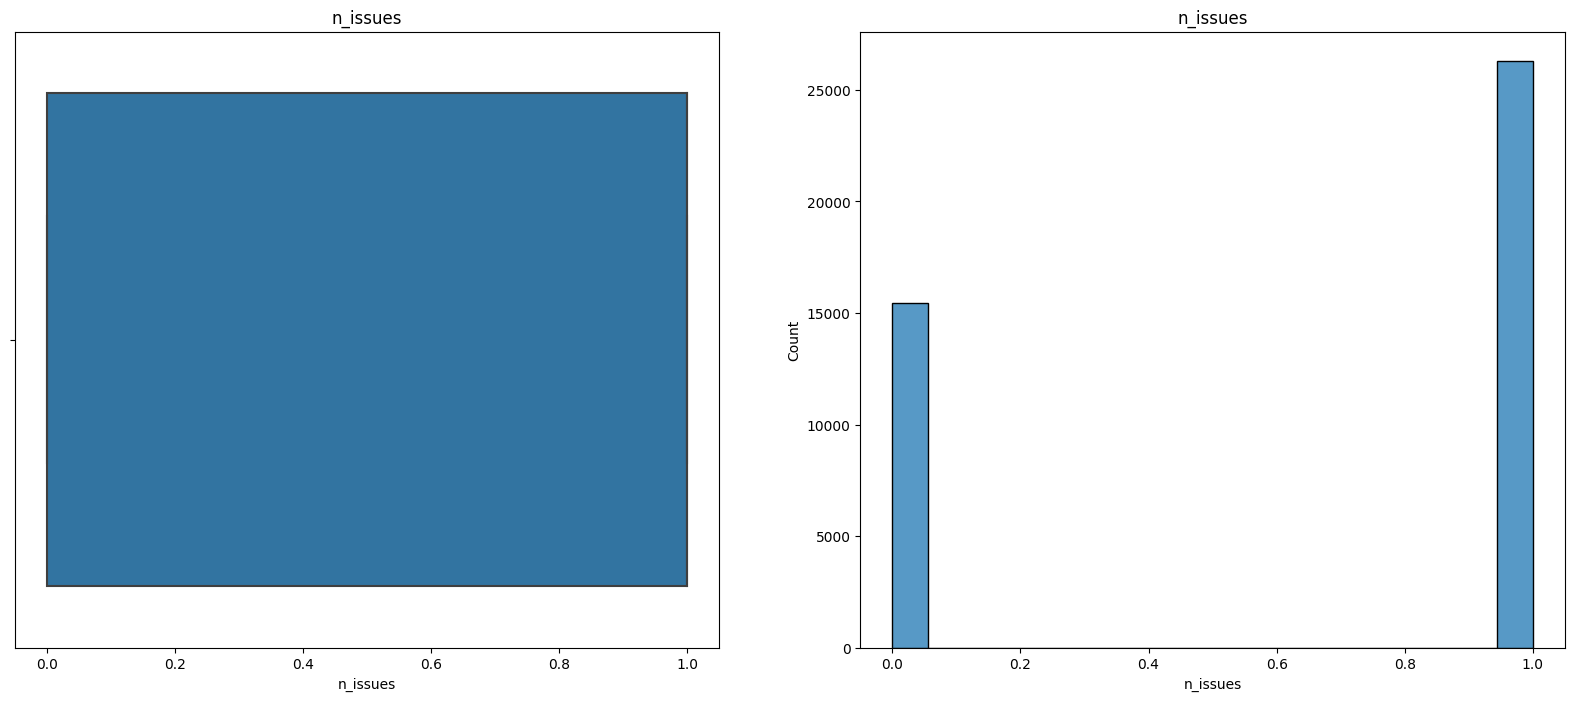

zip


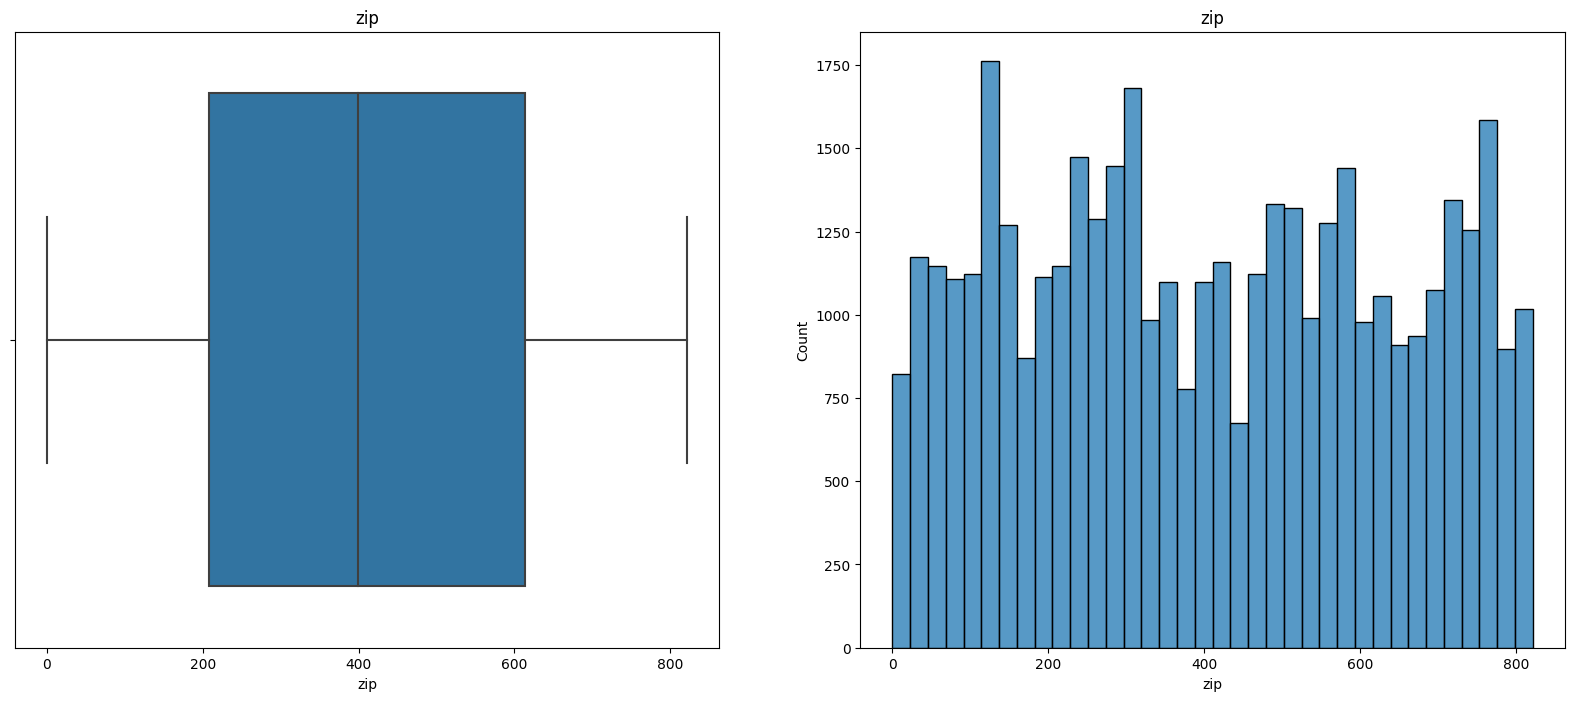

score_2


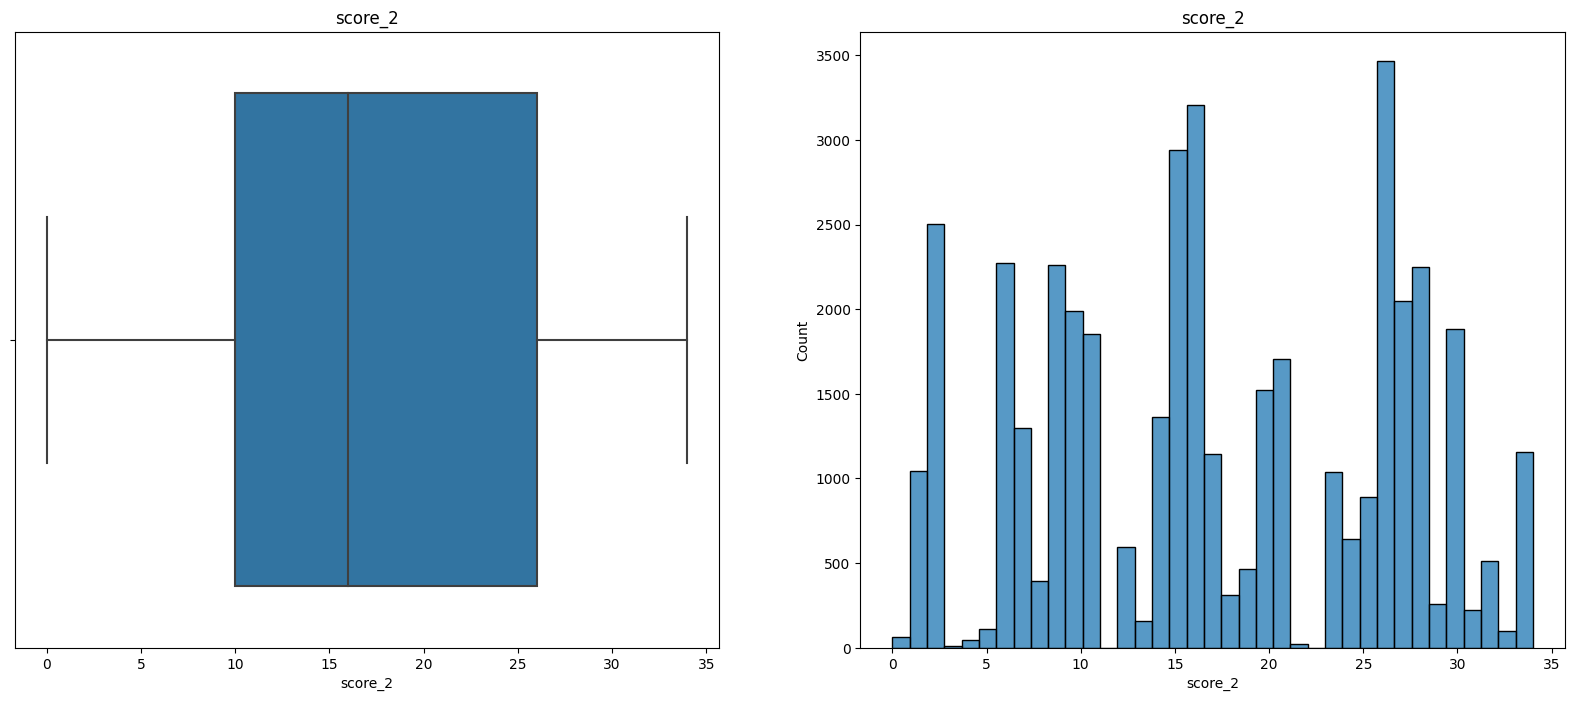

shipping_state


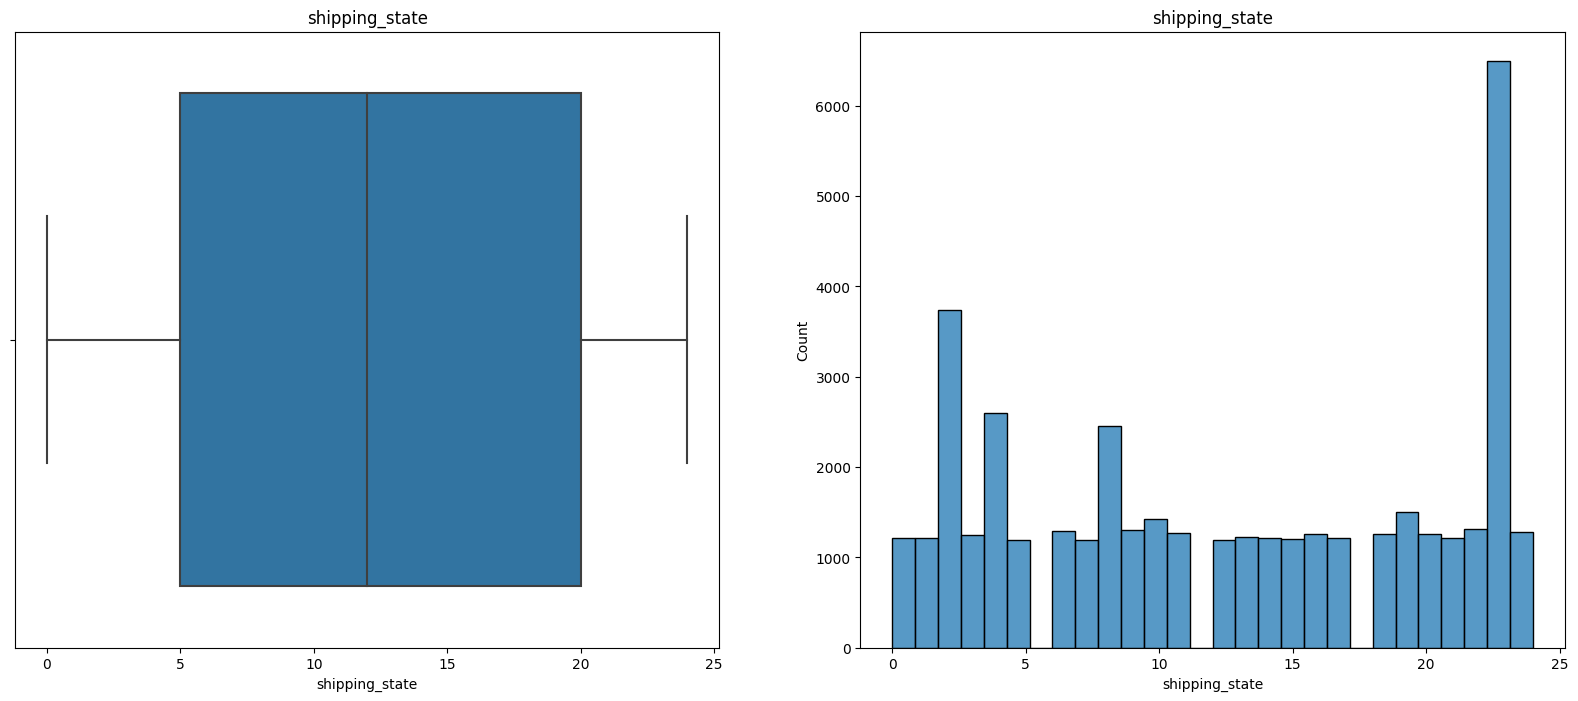

job_name


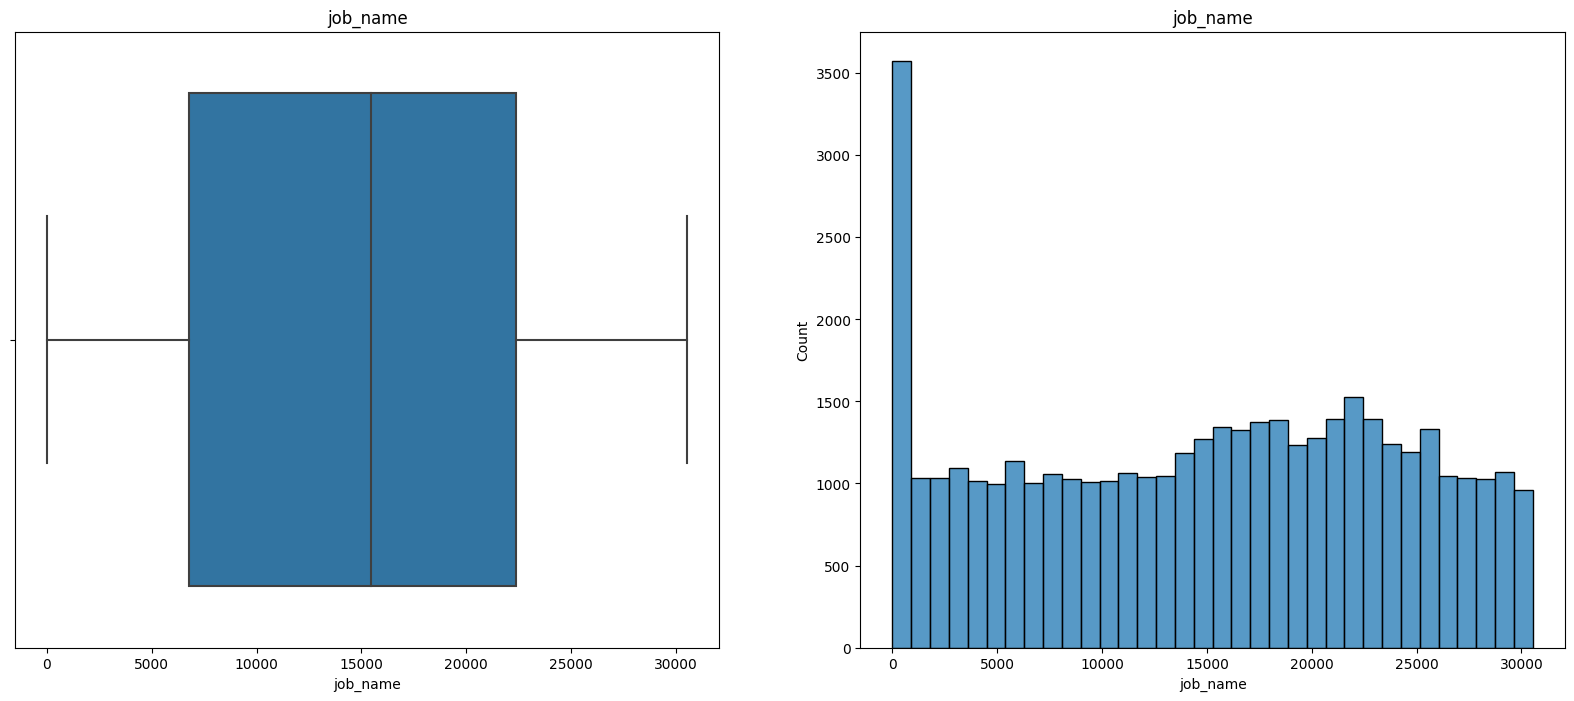

ddd


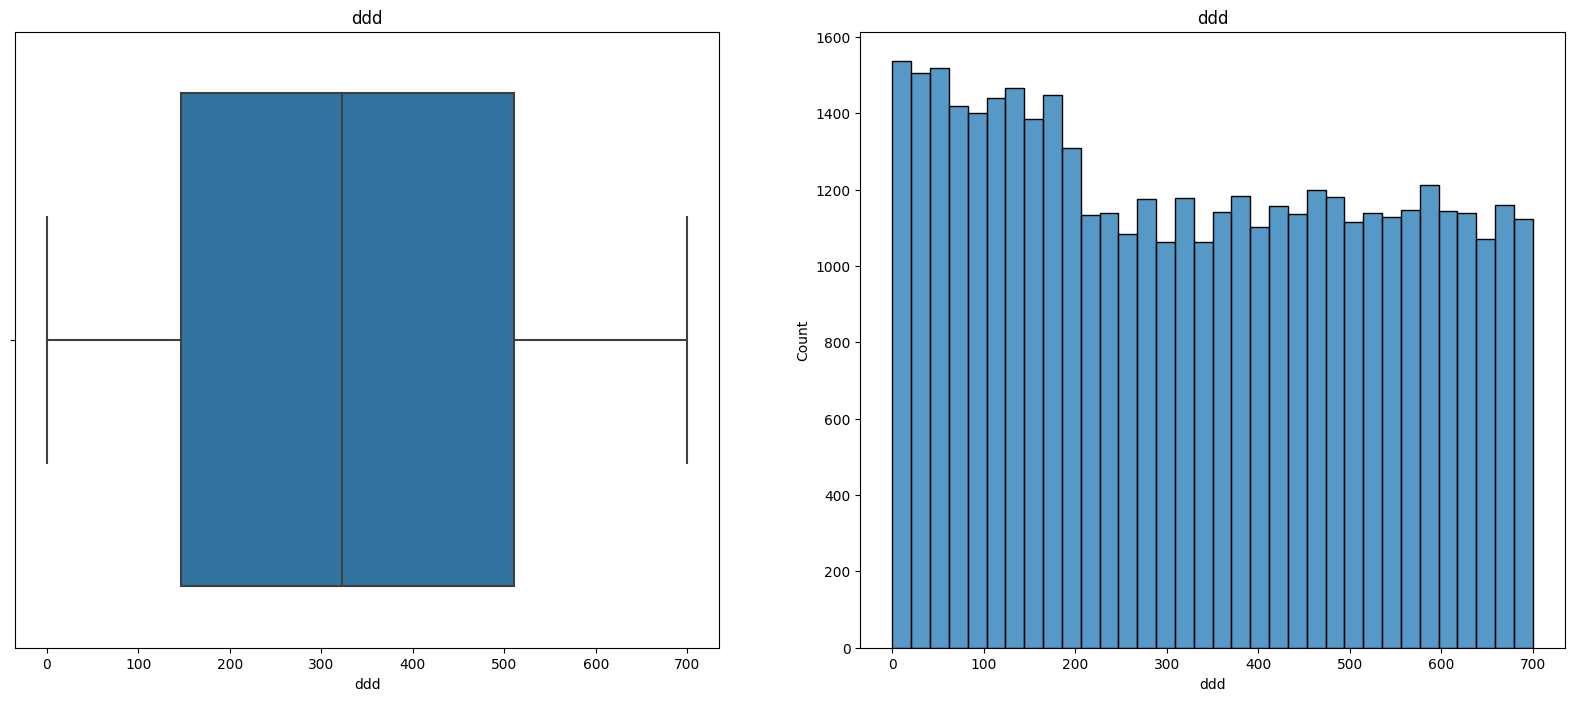

score_1


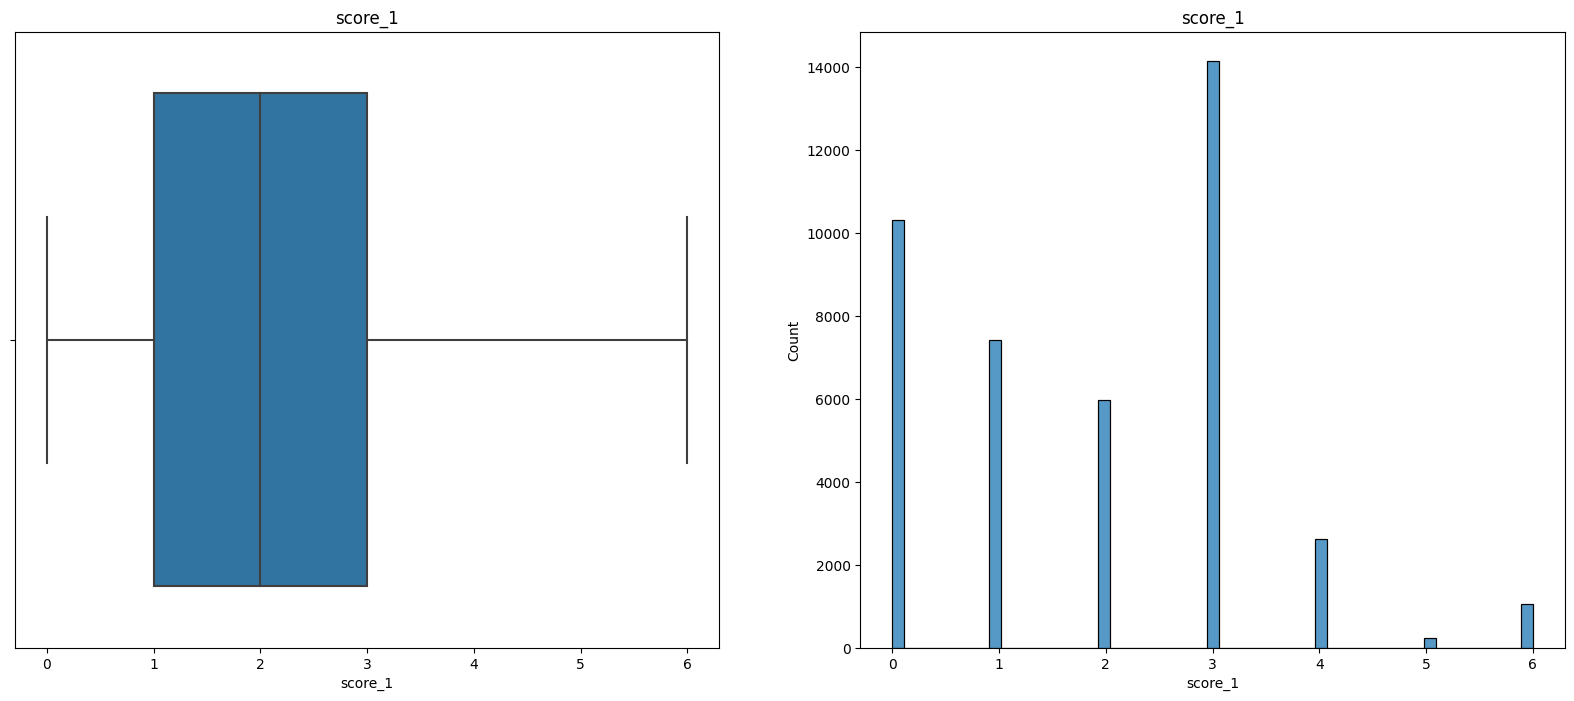

marketing_channel


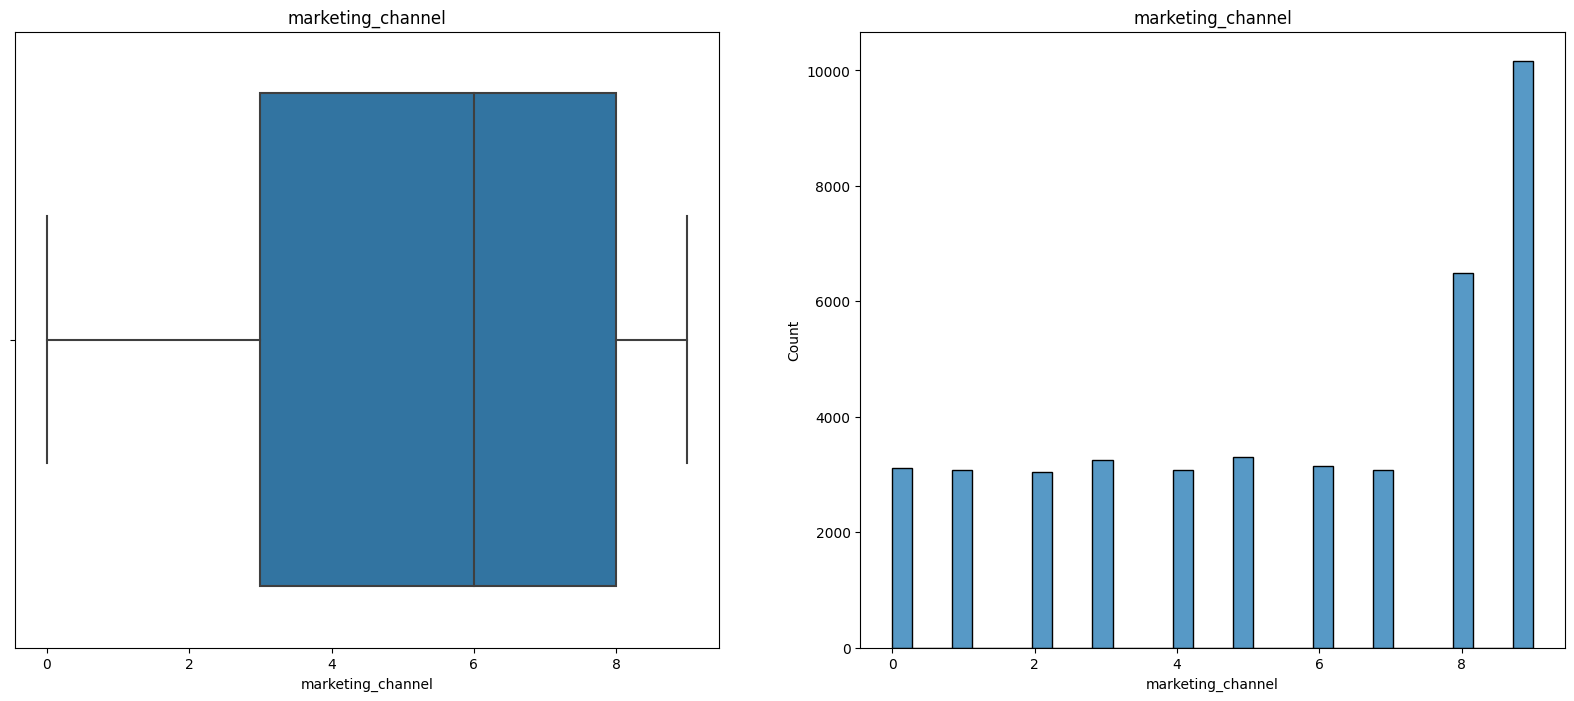

state


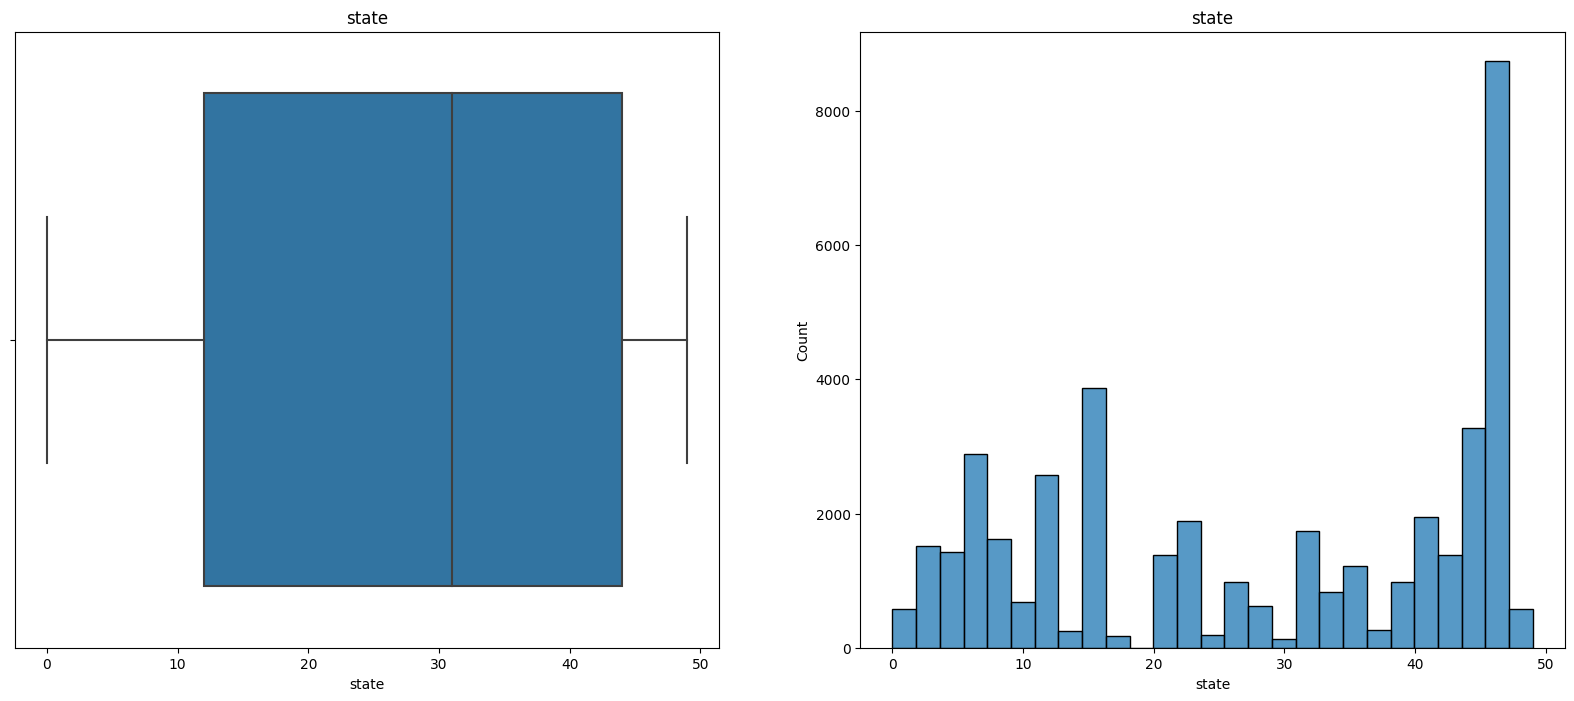

facebook_profile


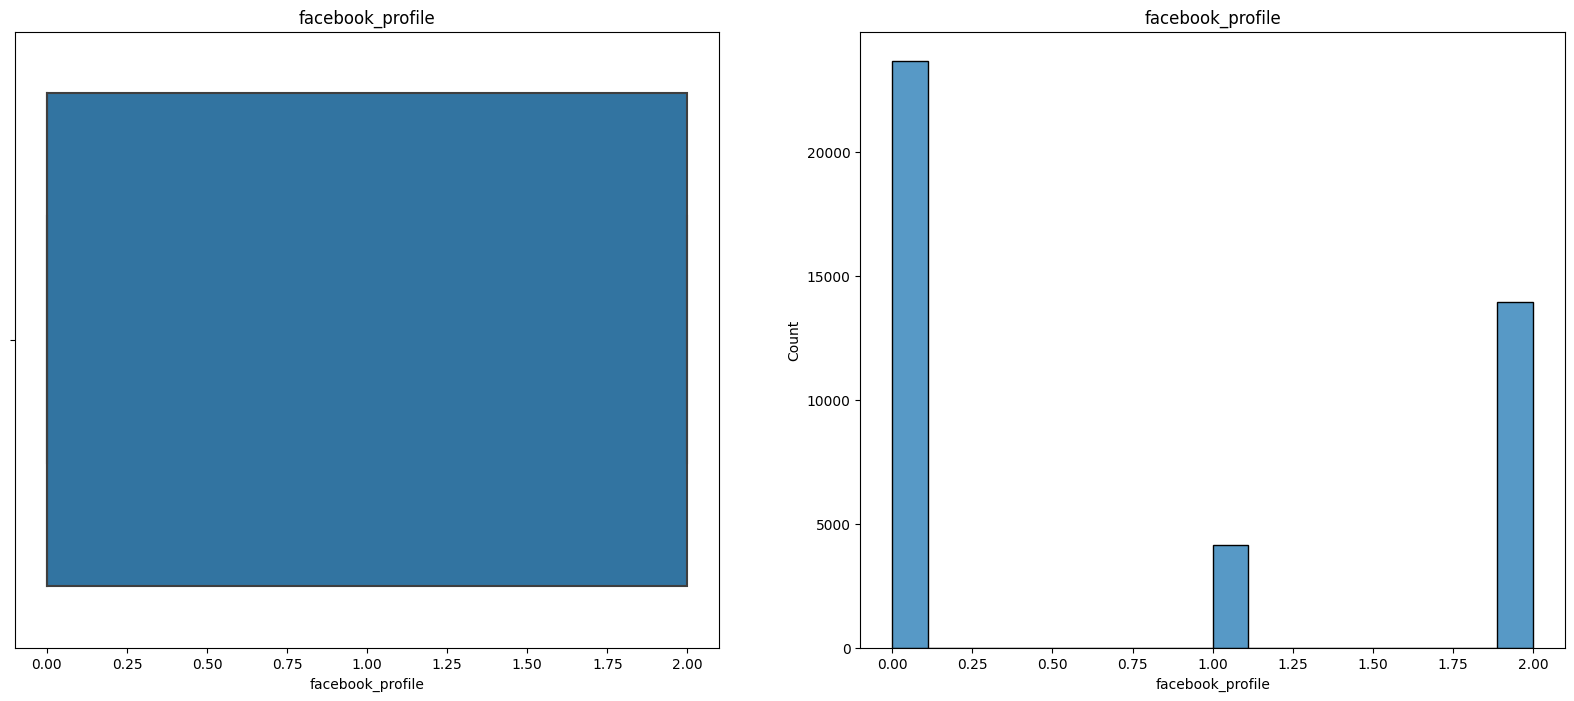

email


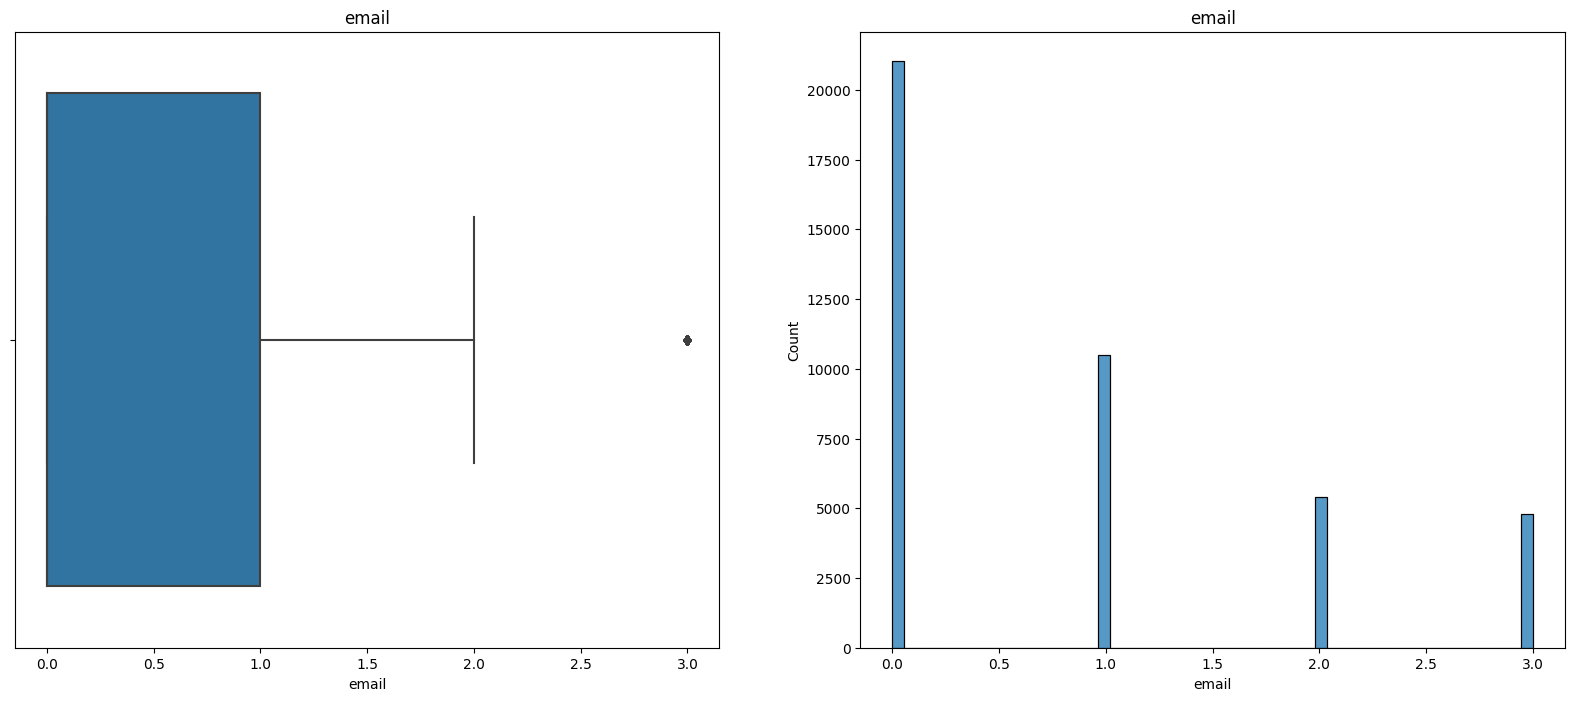

reason


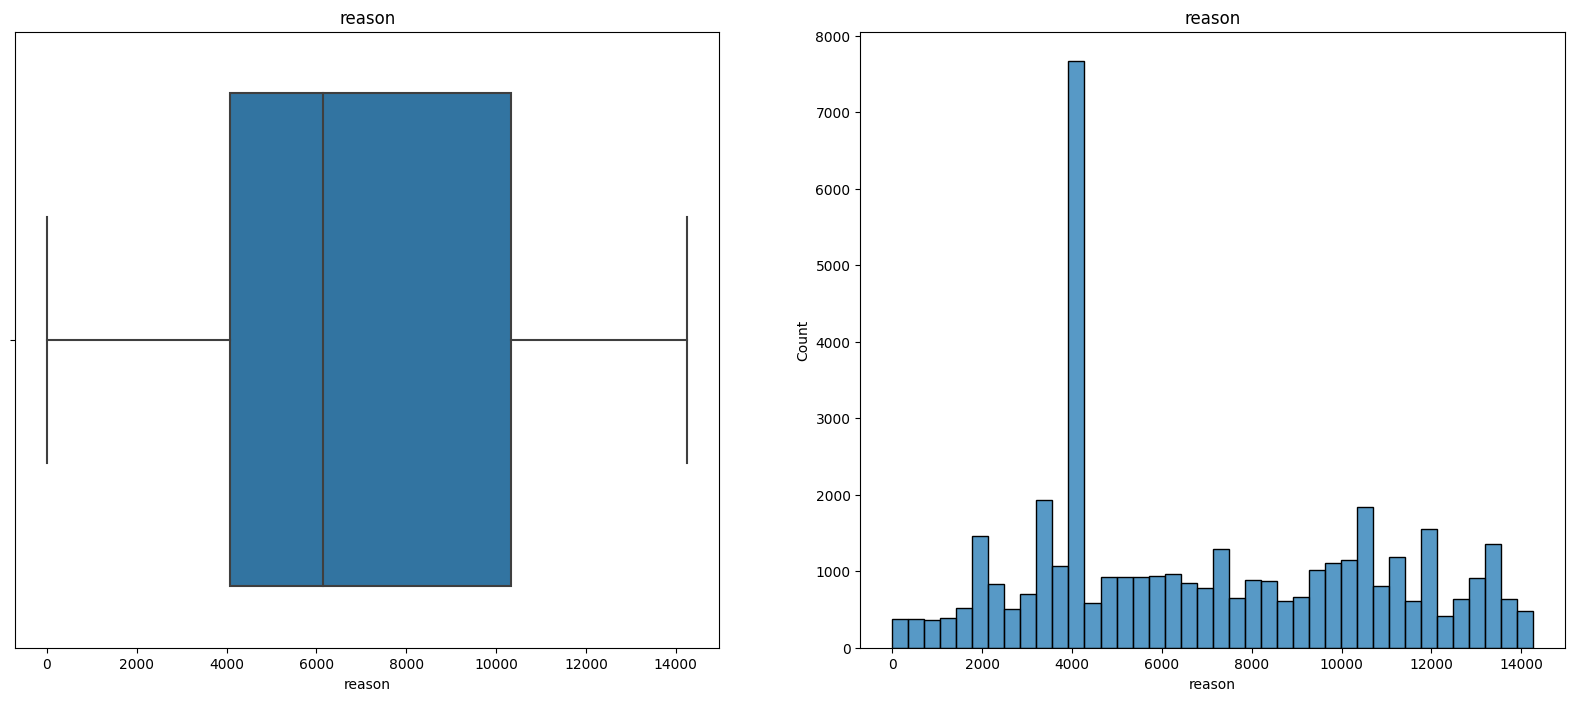

real_state


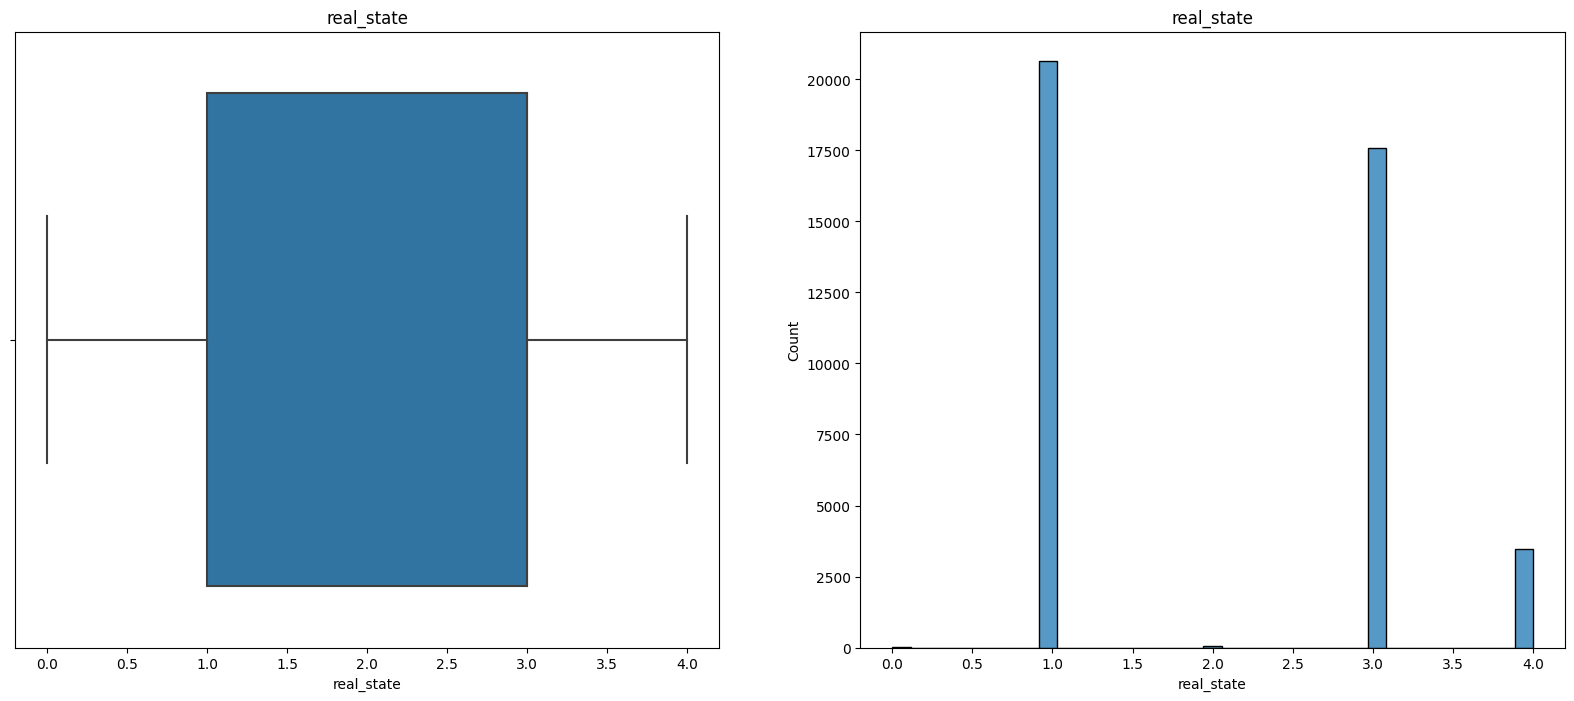

n_defaulted_loans


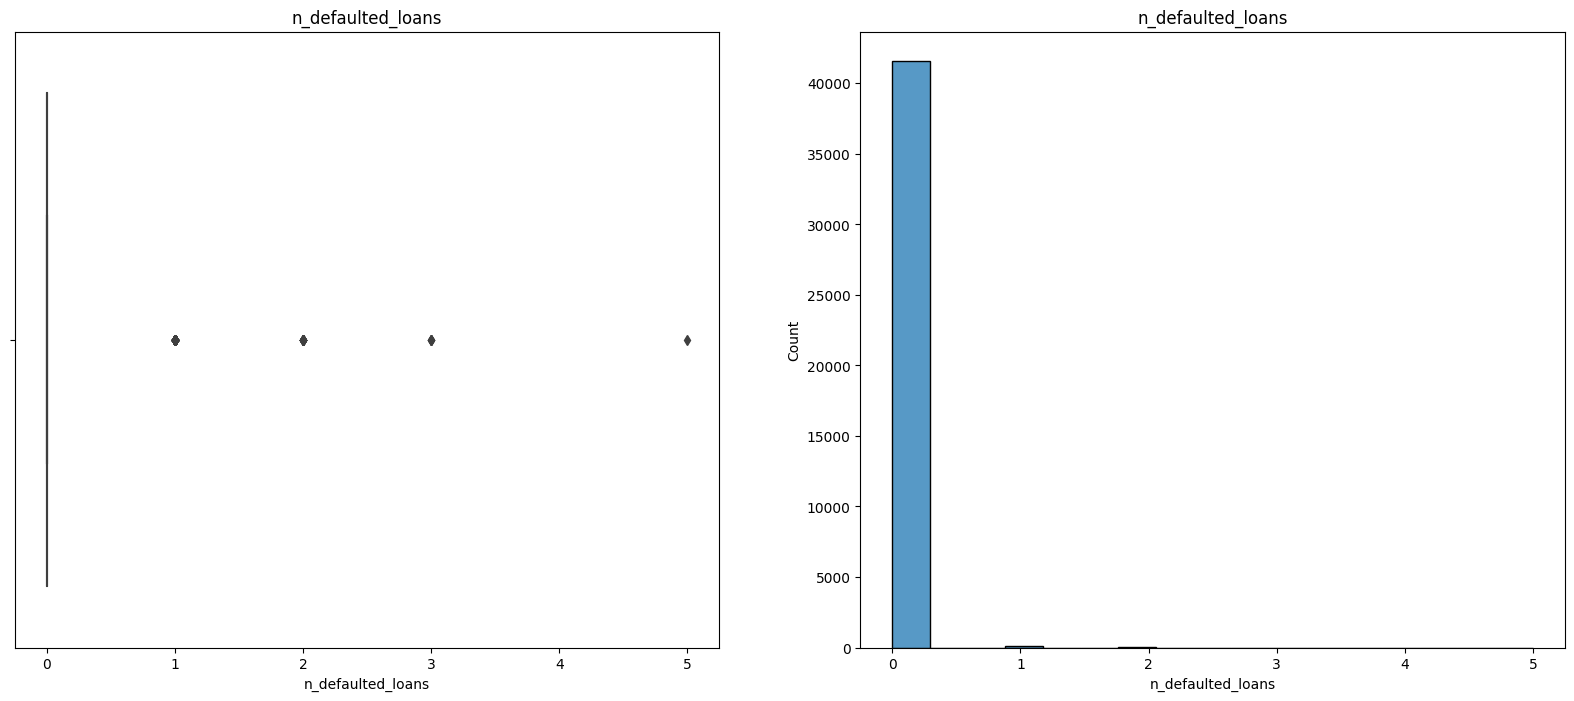

n_bankruptcies


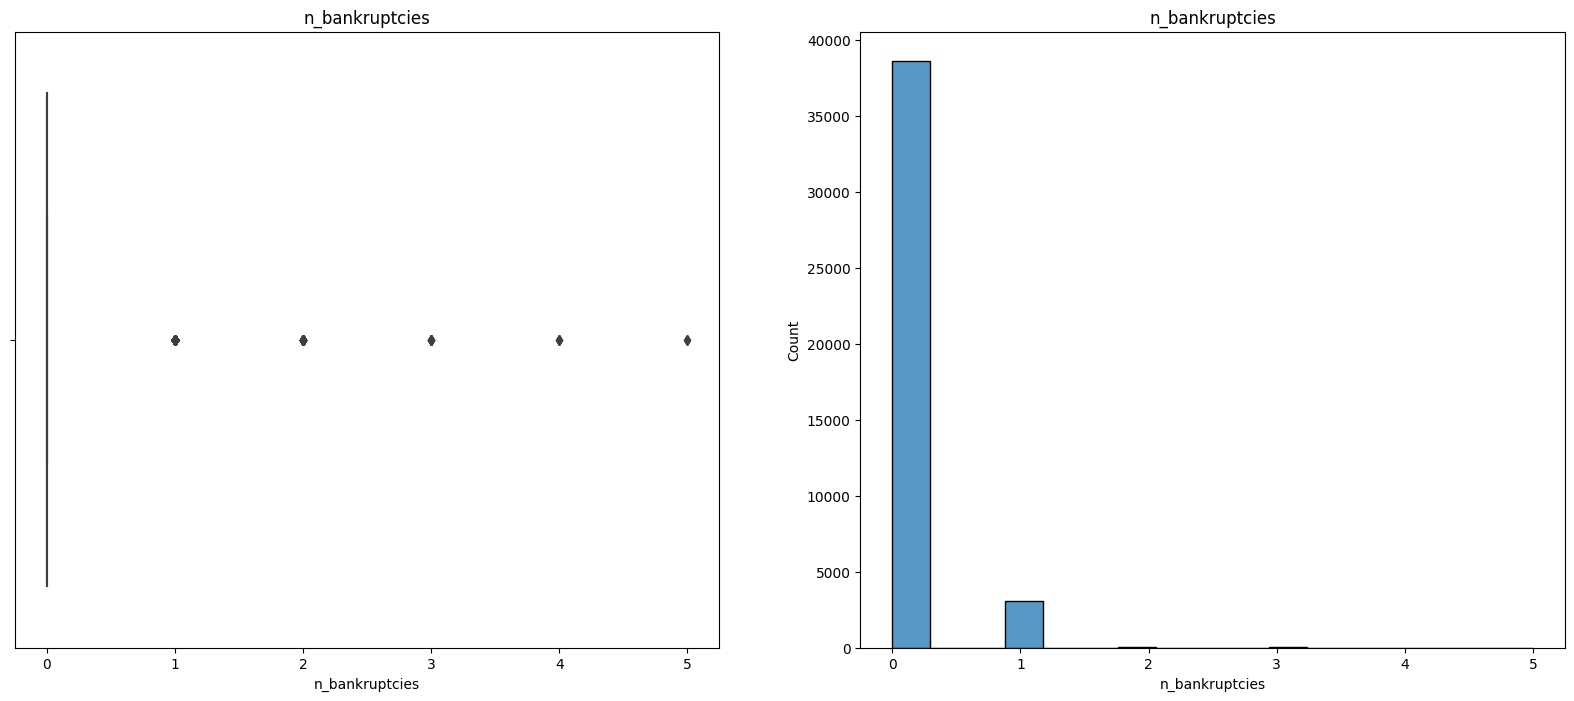

score_3


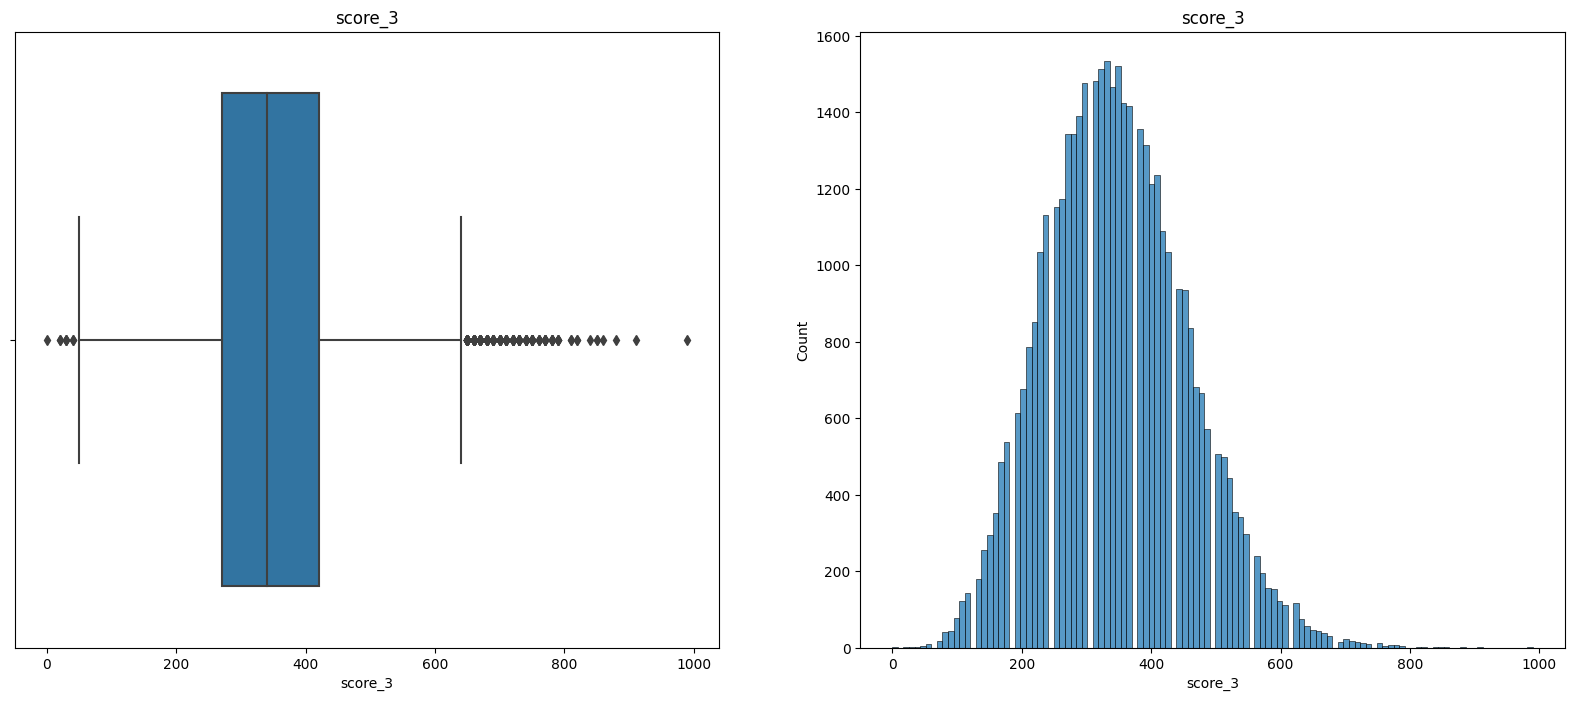

score_4


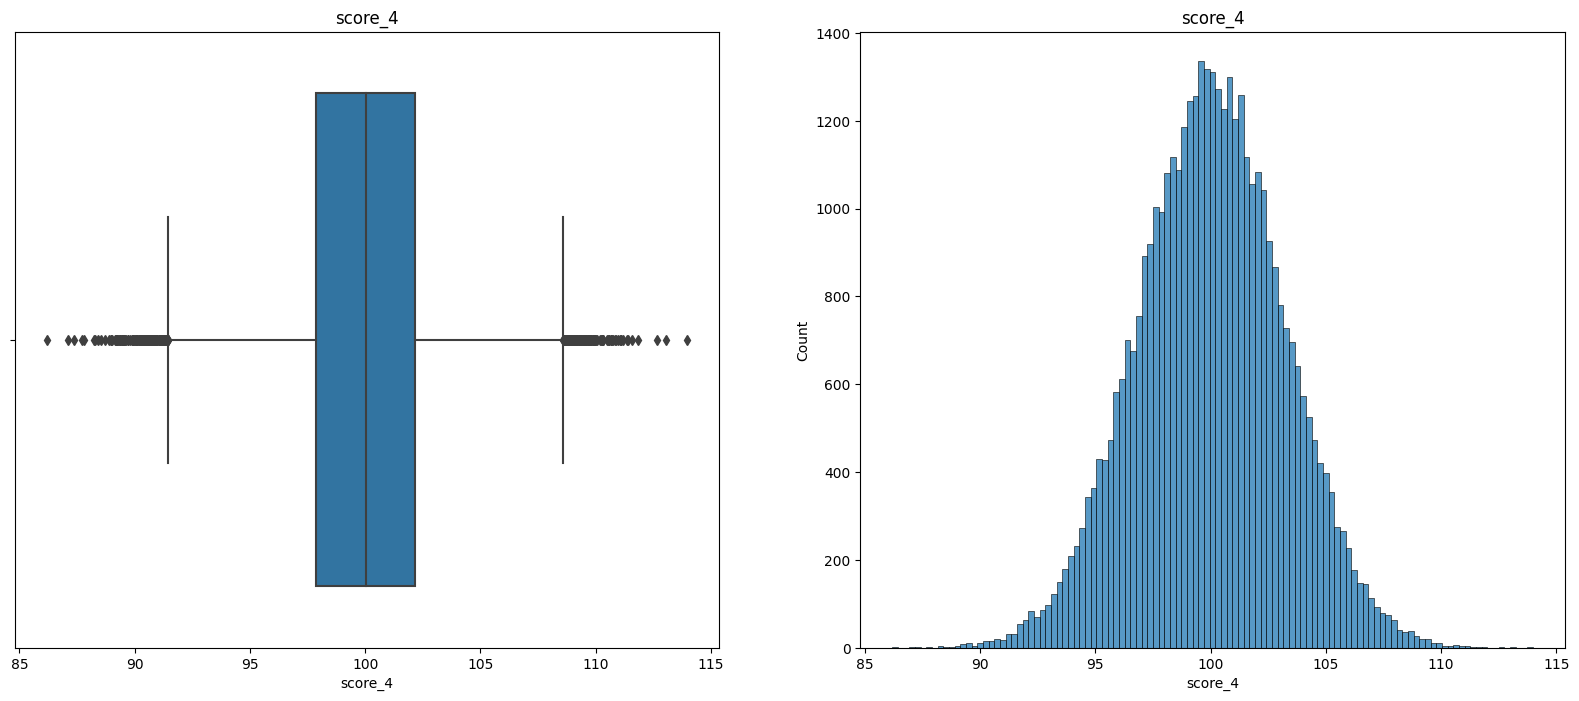

score_5


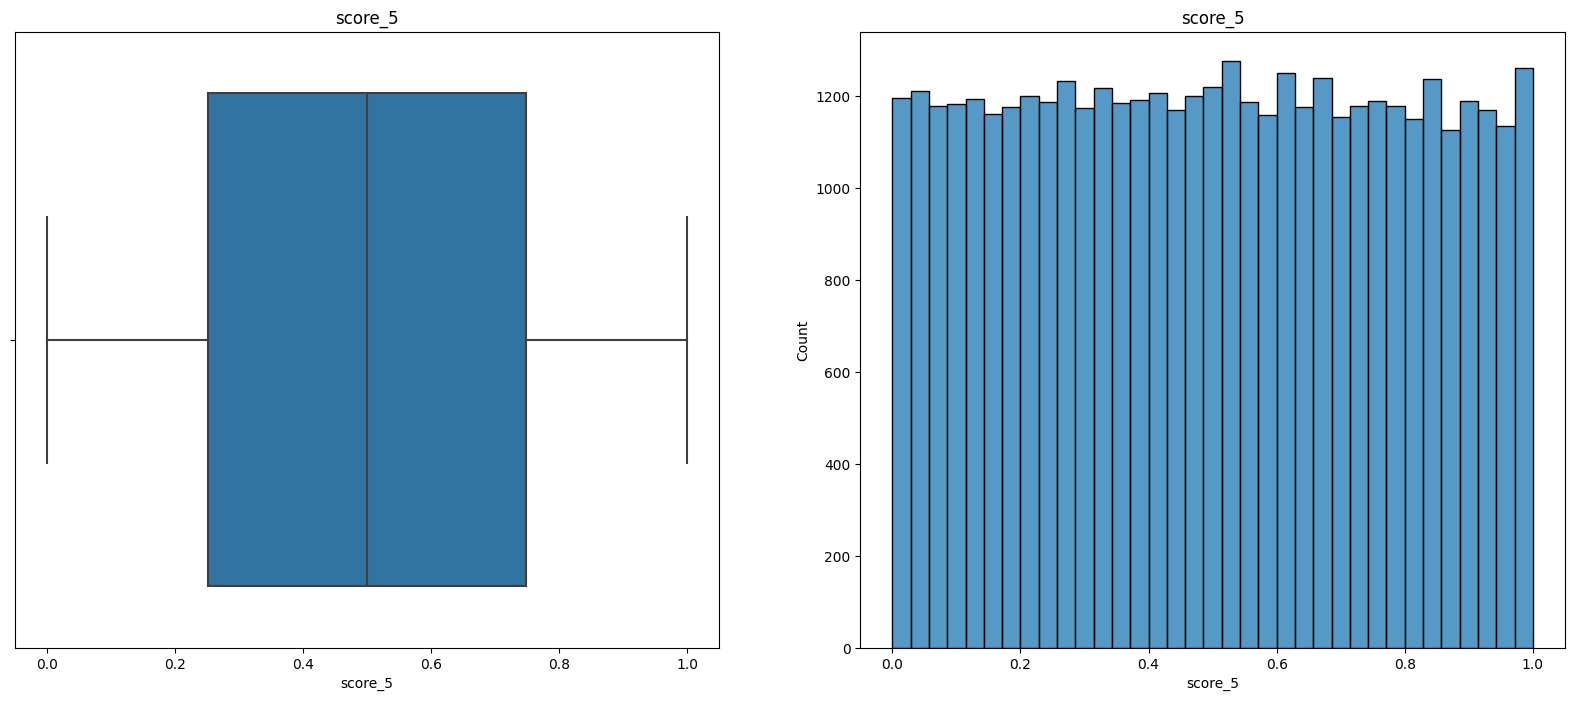

score_6


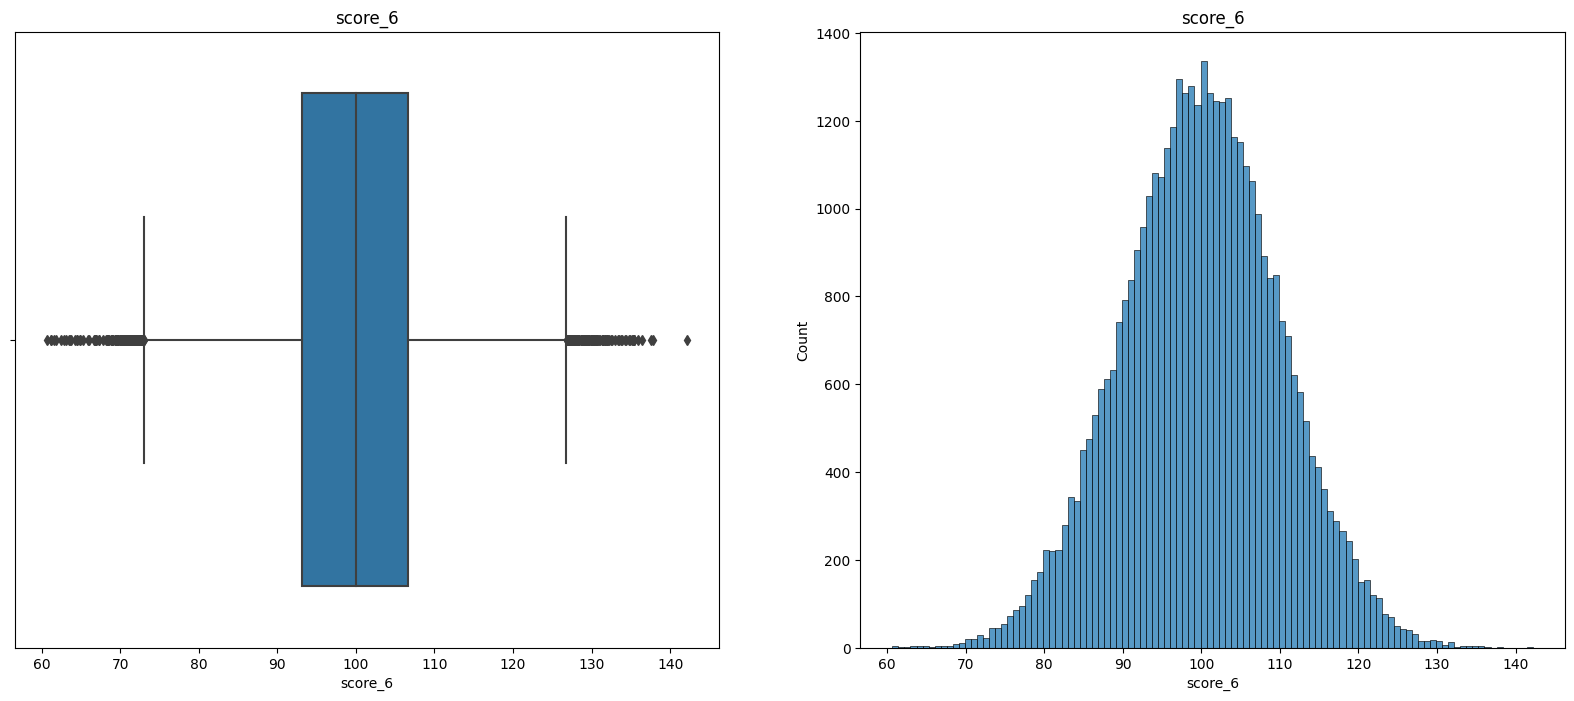

risk_rate


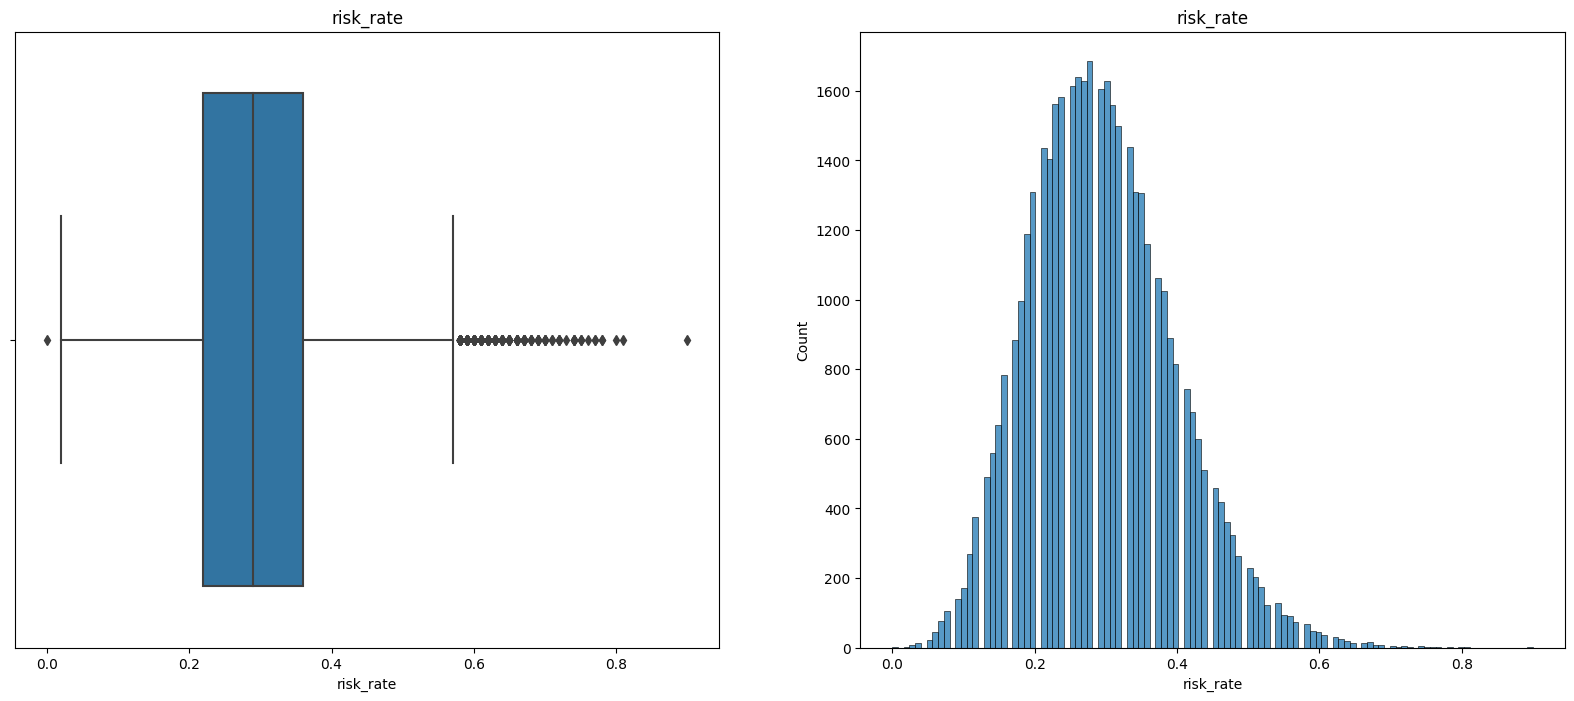

last_amount_borrowed


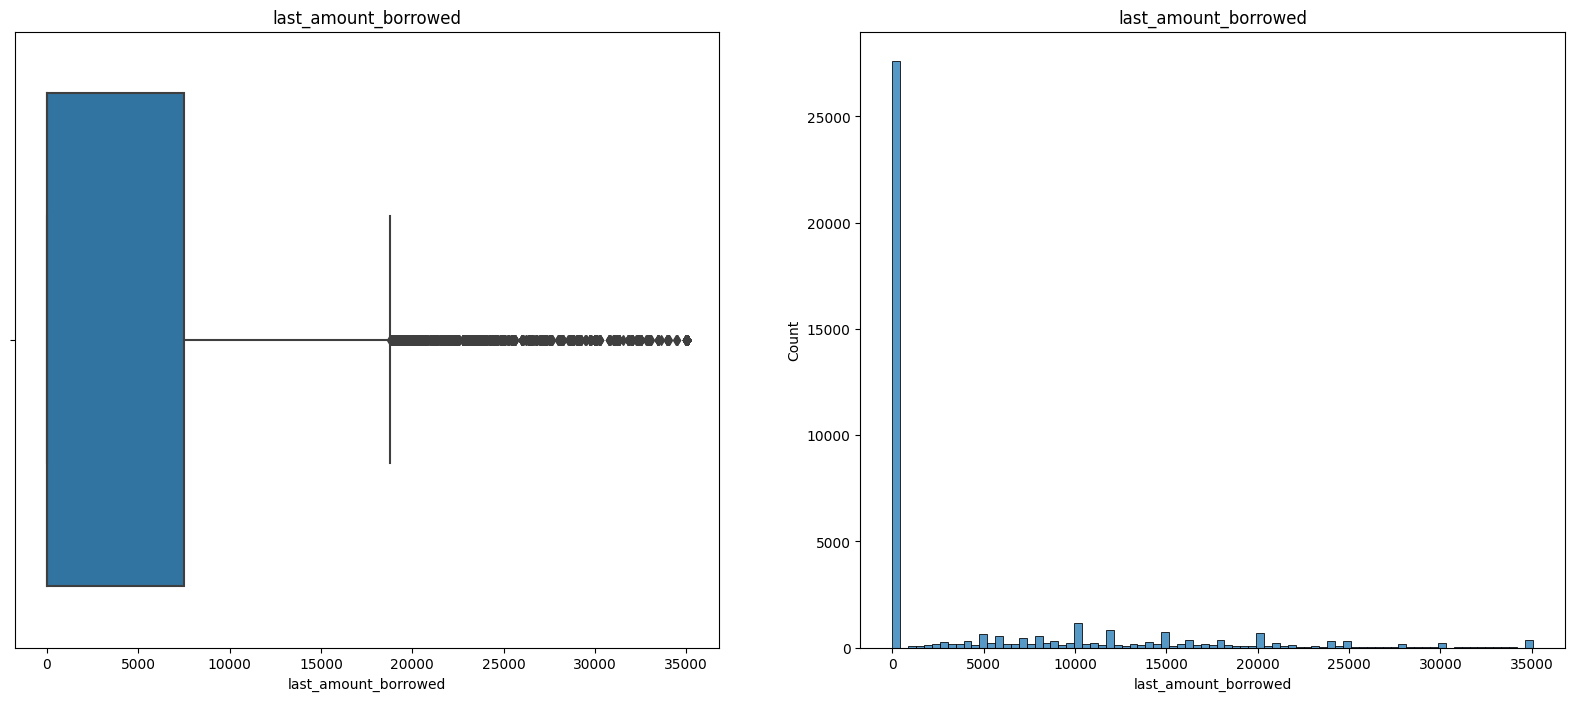

last_borrowed_in_months


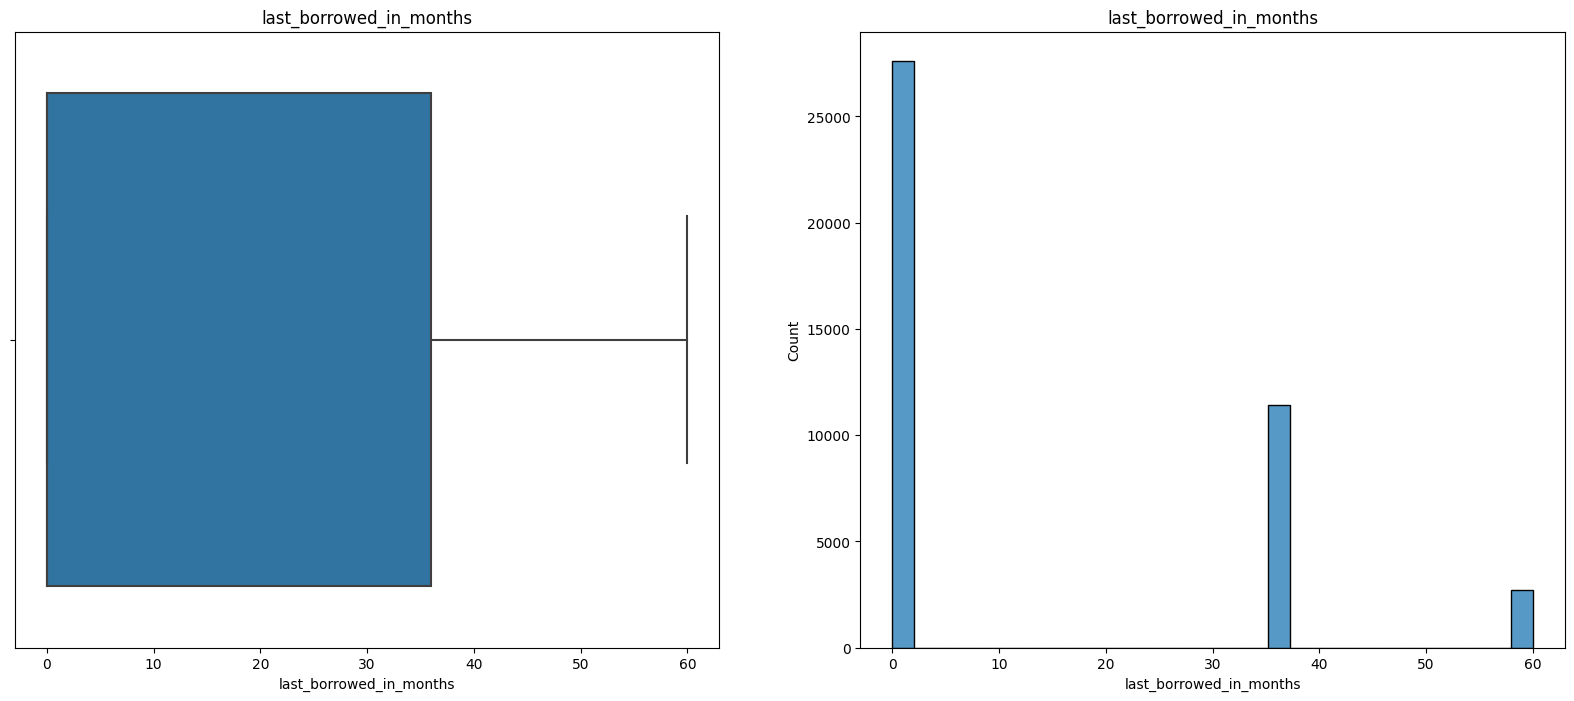

ok_since


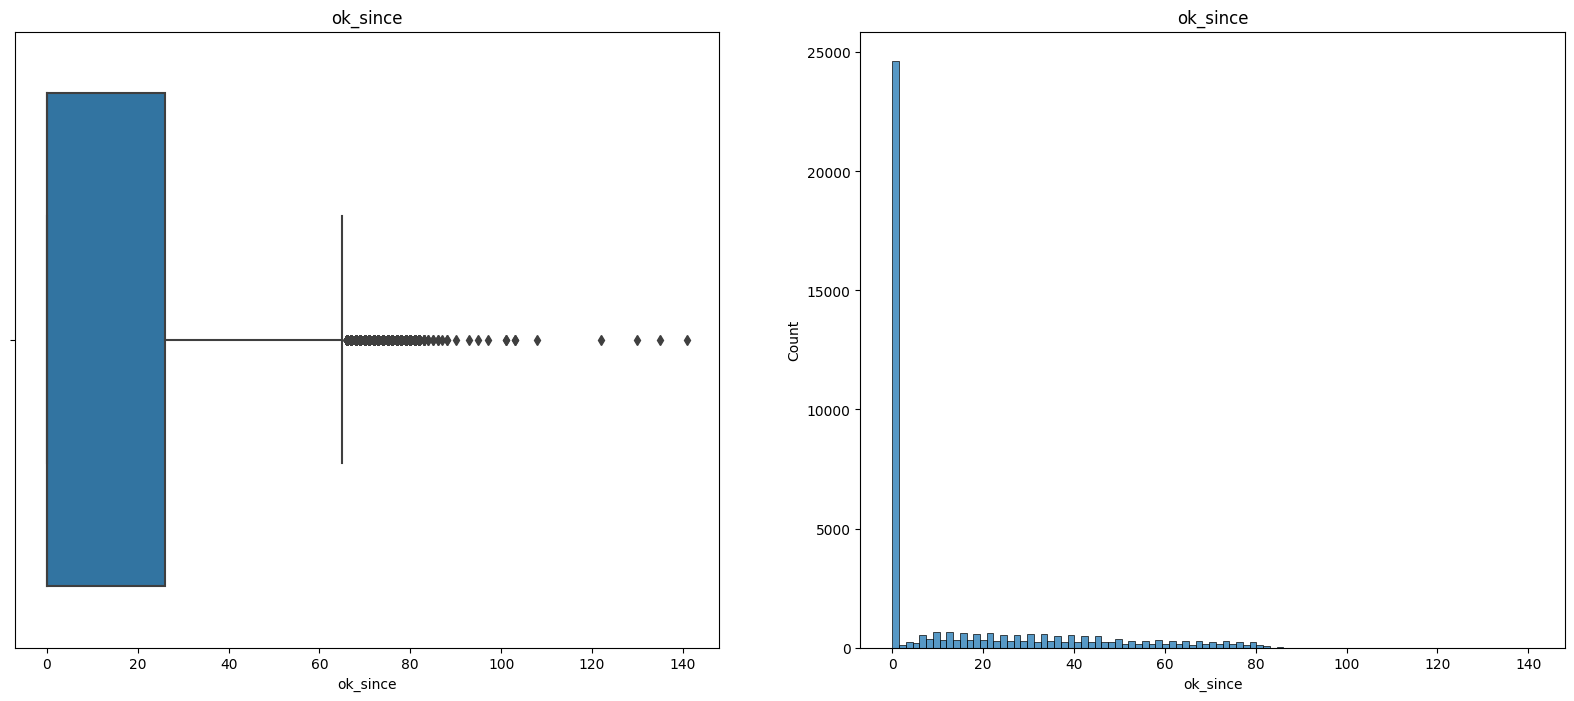

external_data_provider_email_seen_before


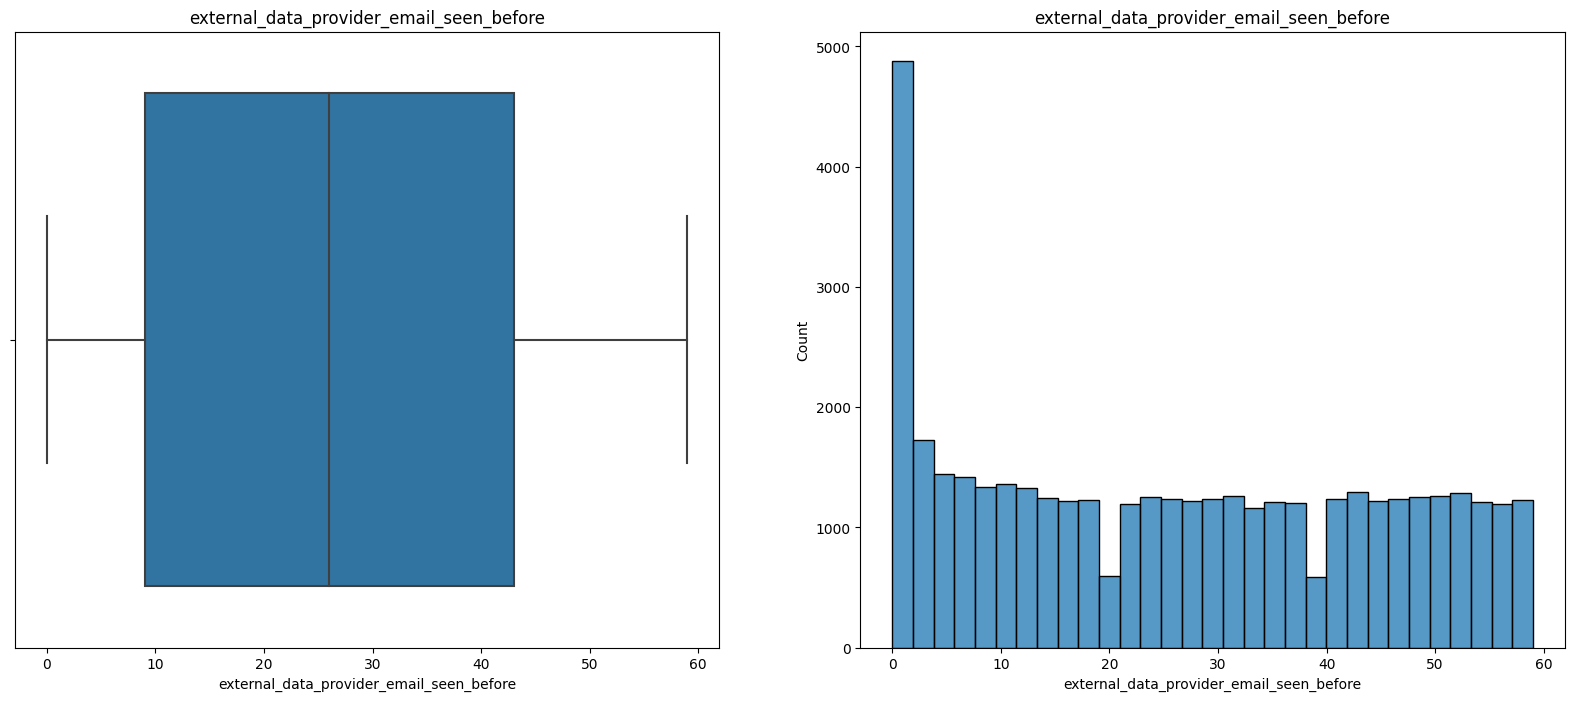

external_data_provider_fraud_score


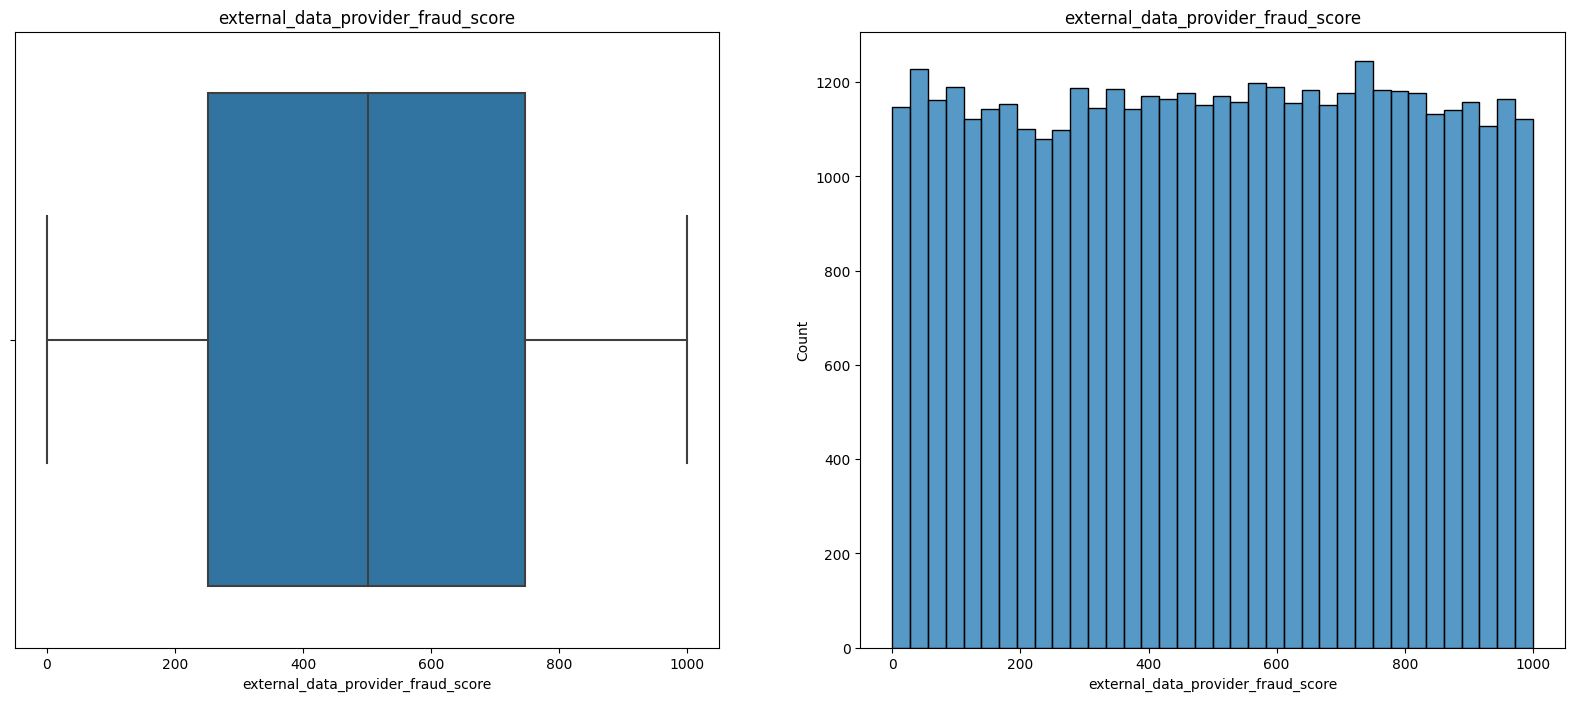

application_time_applied


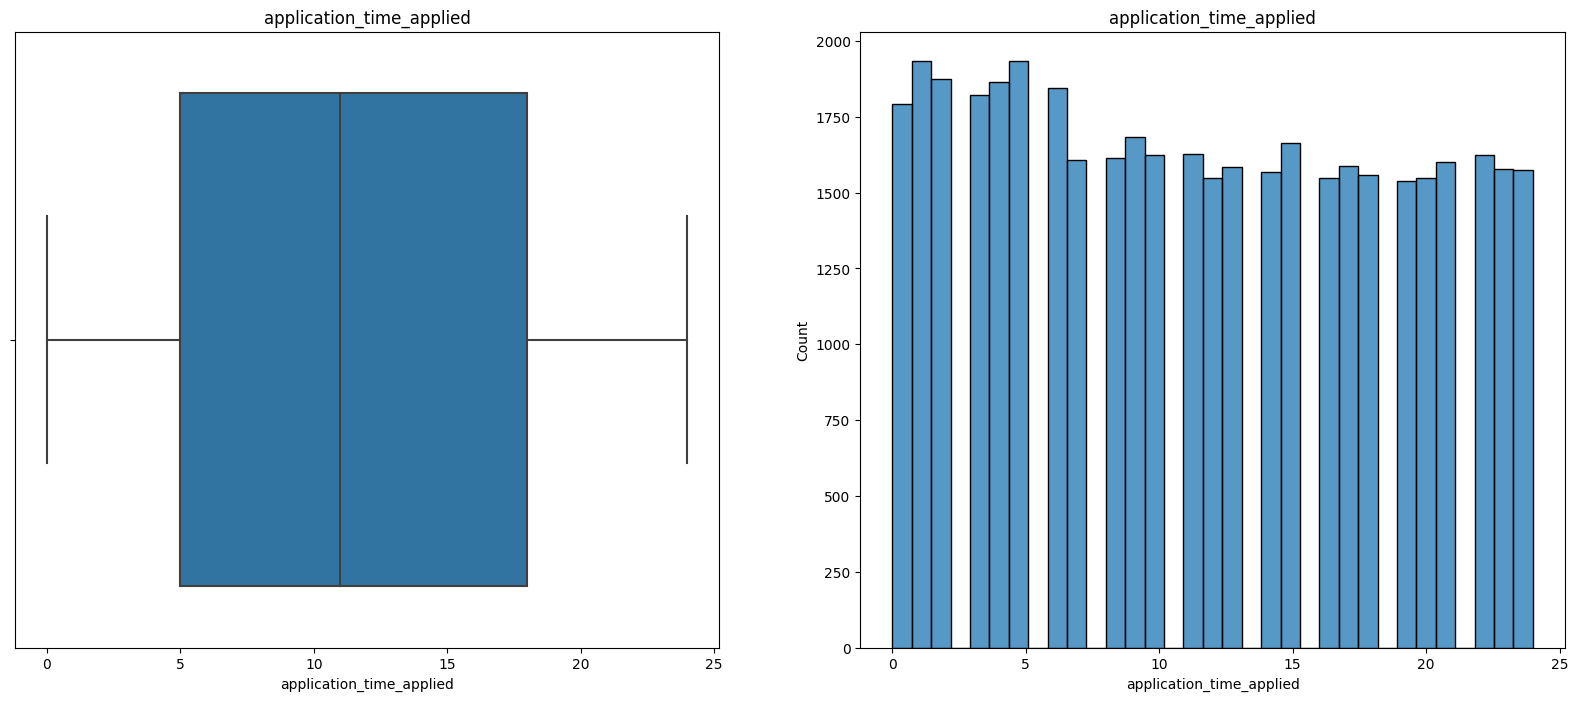

application_time_in_funnel


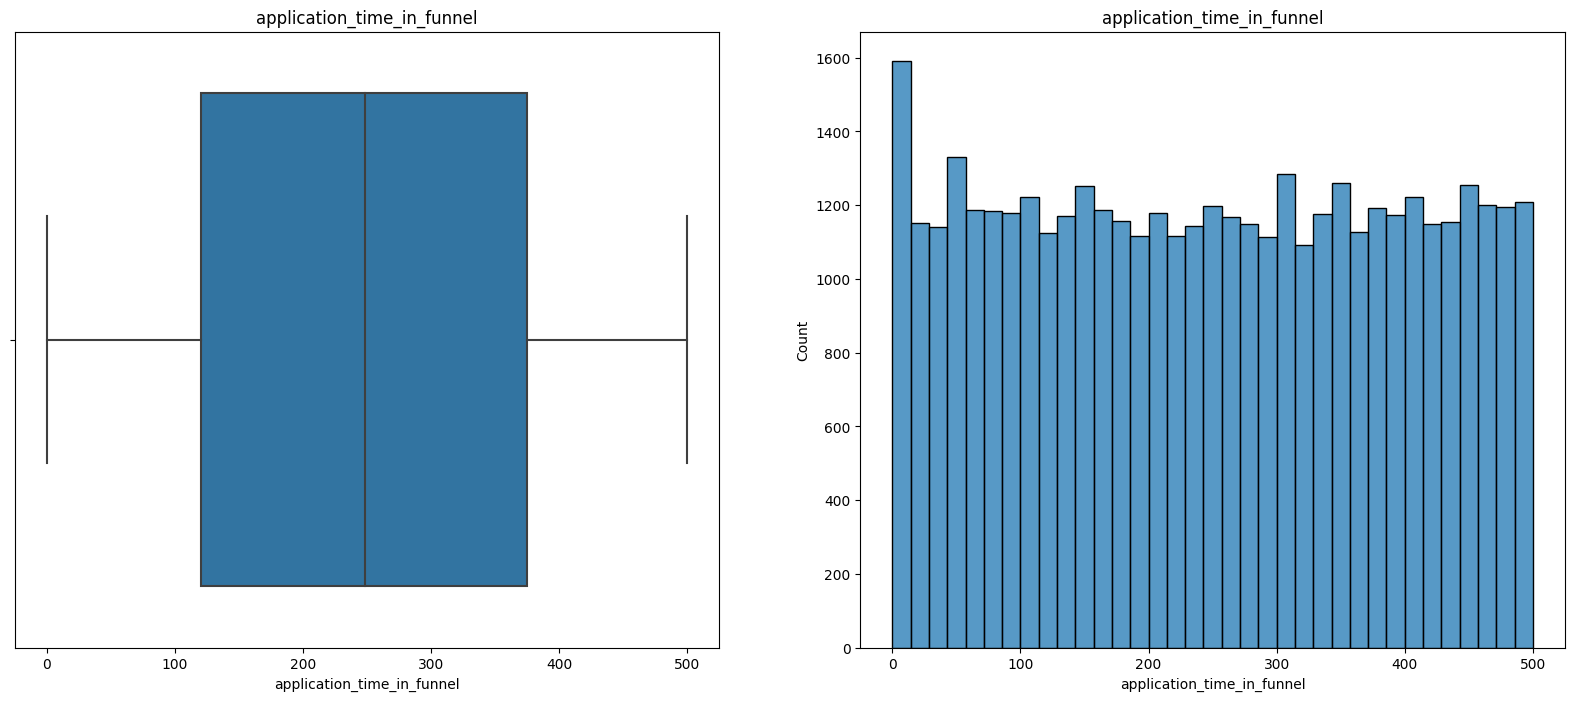

n7


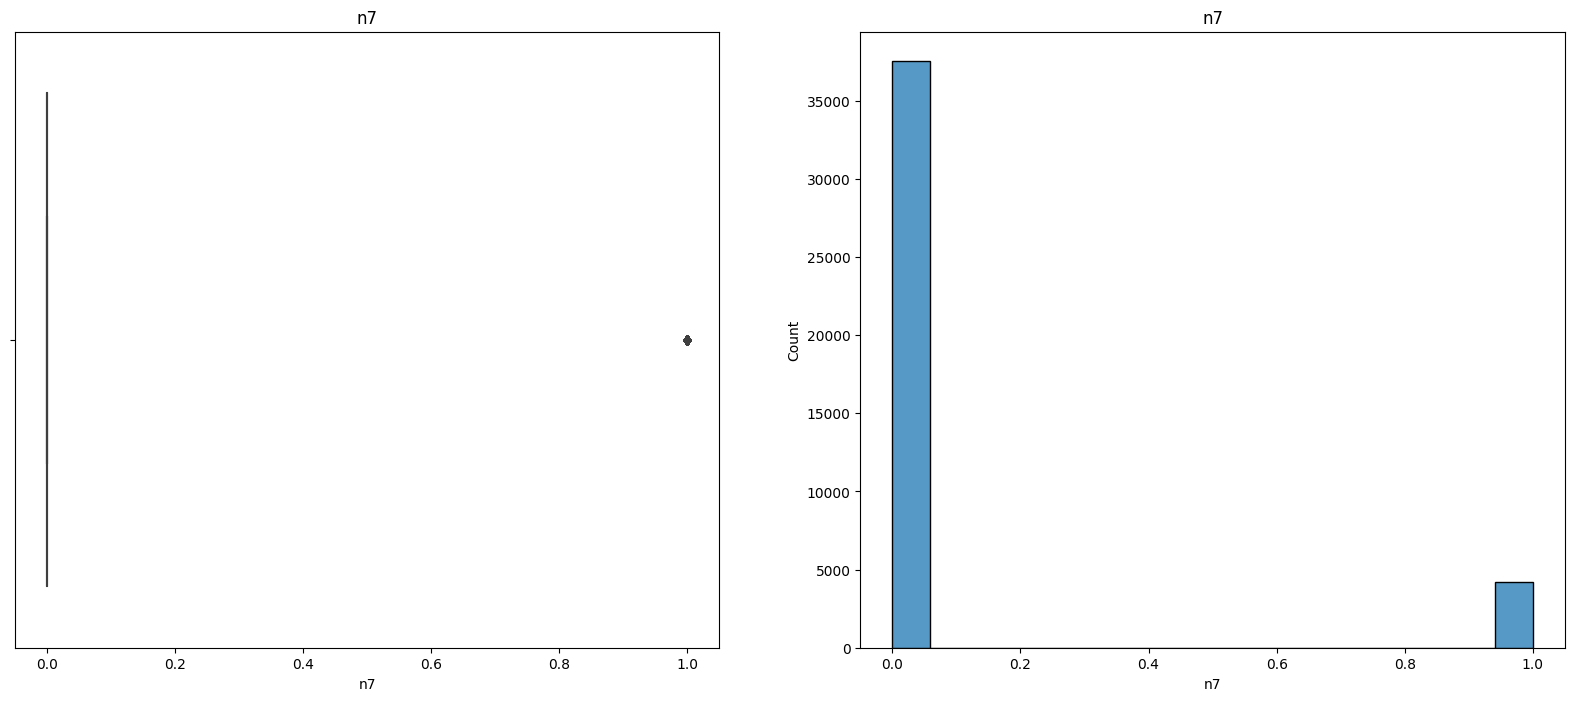

n4


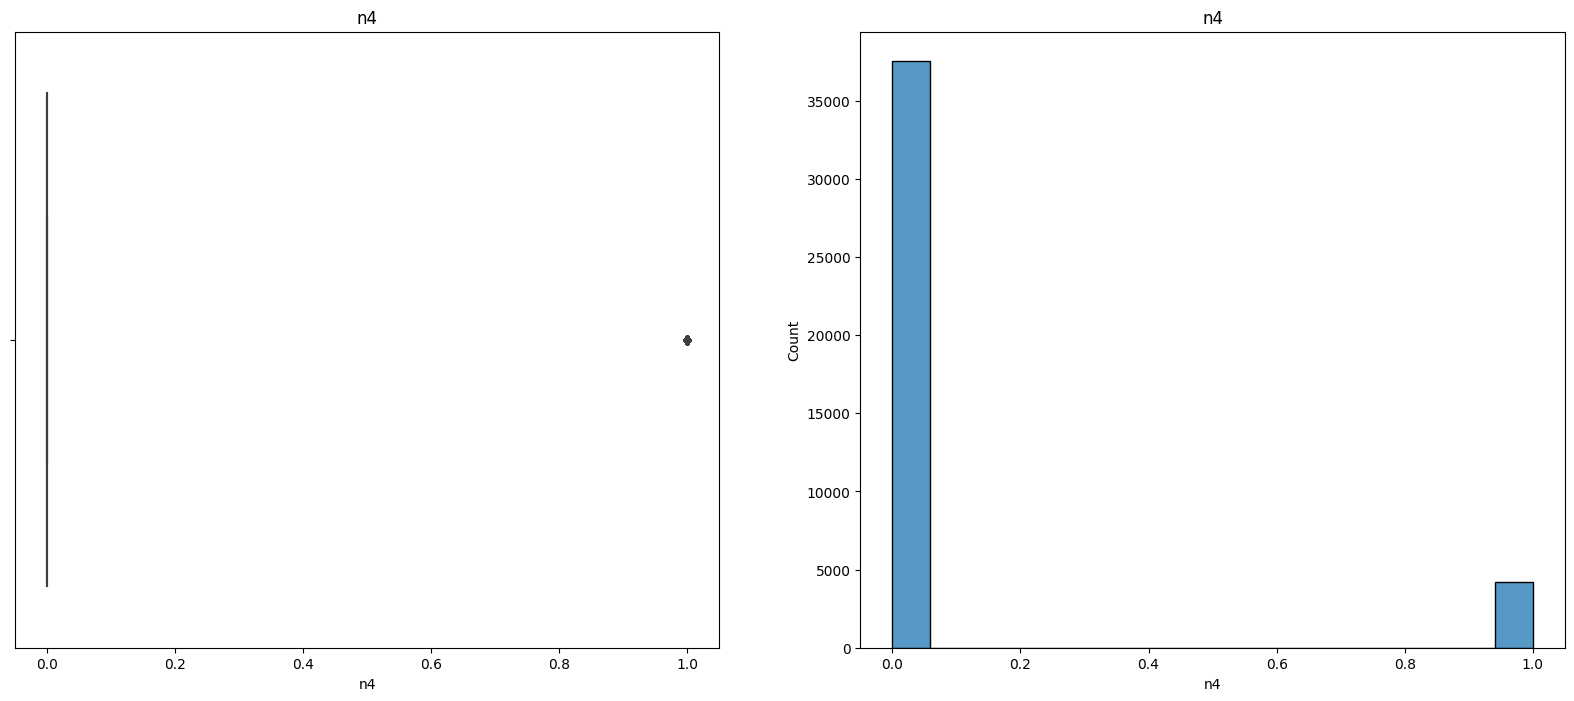

n12


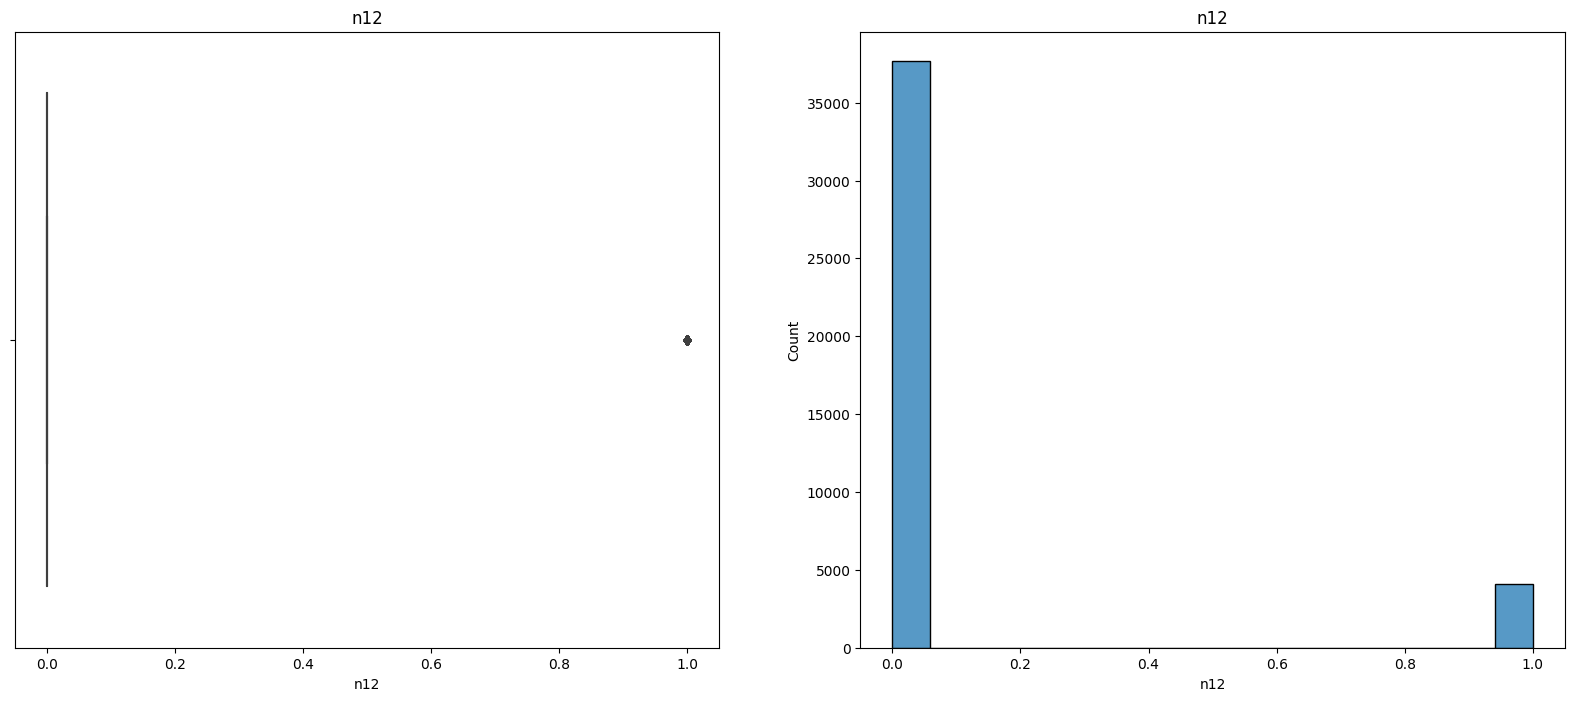

n17


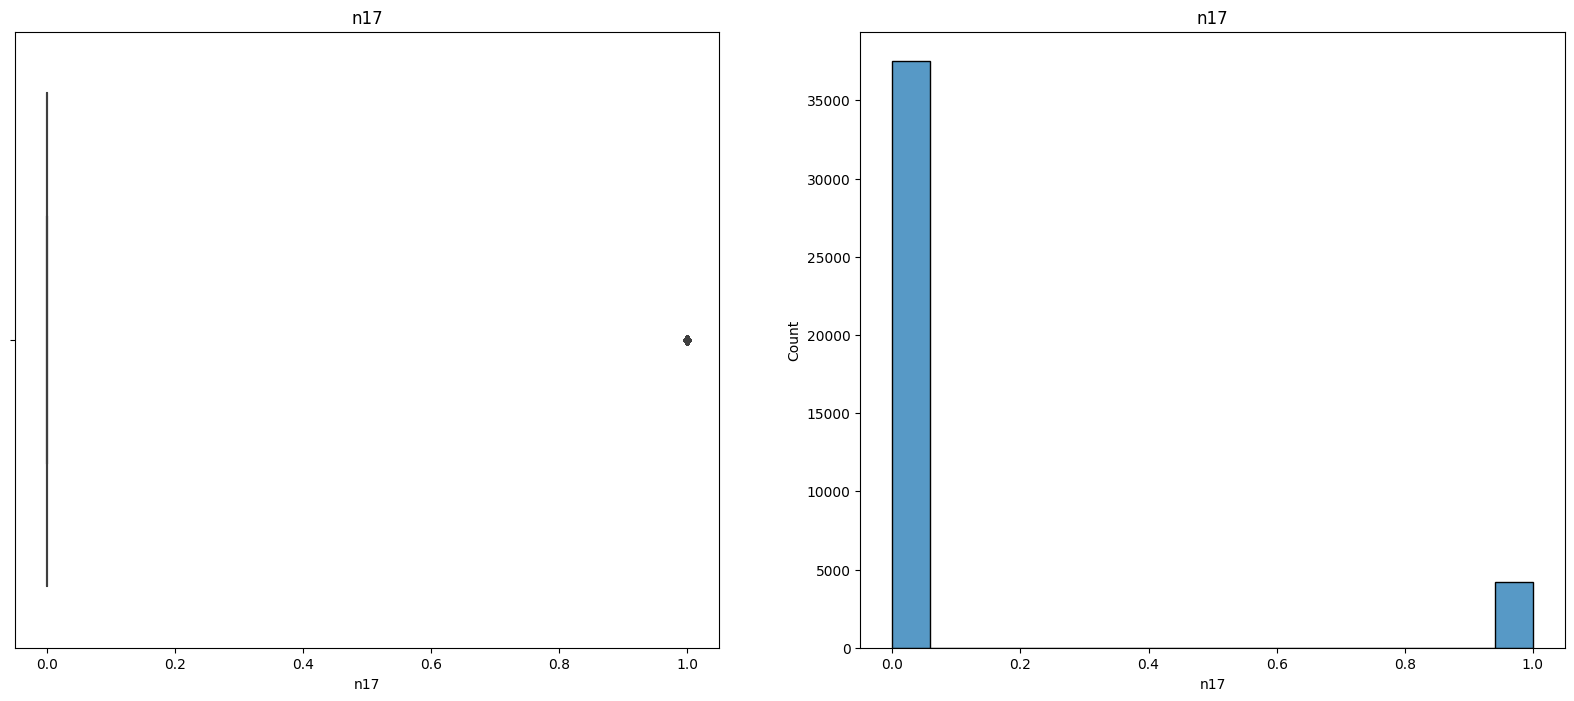

n8


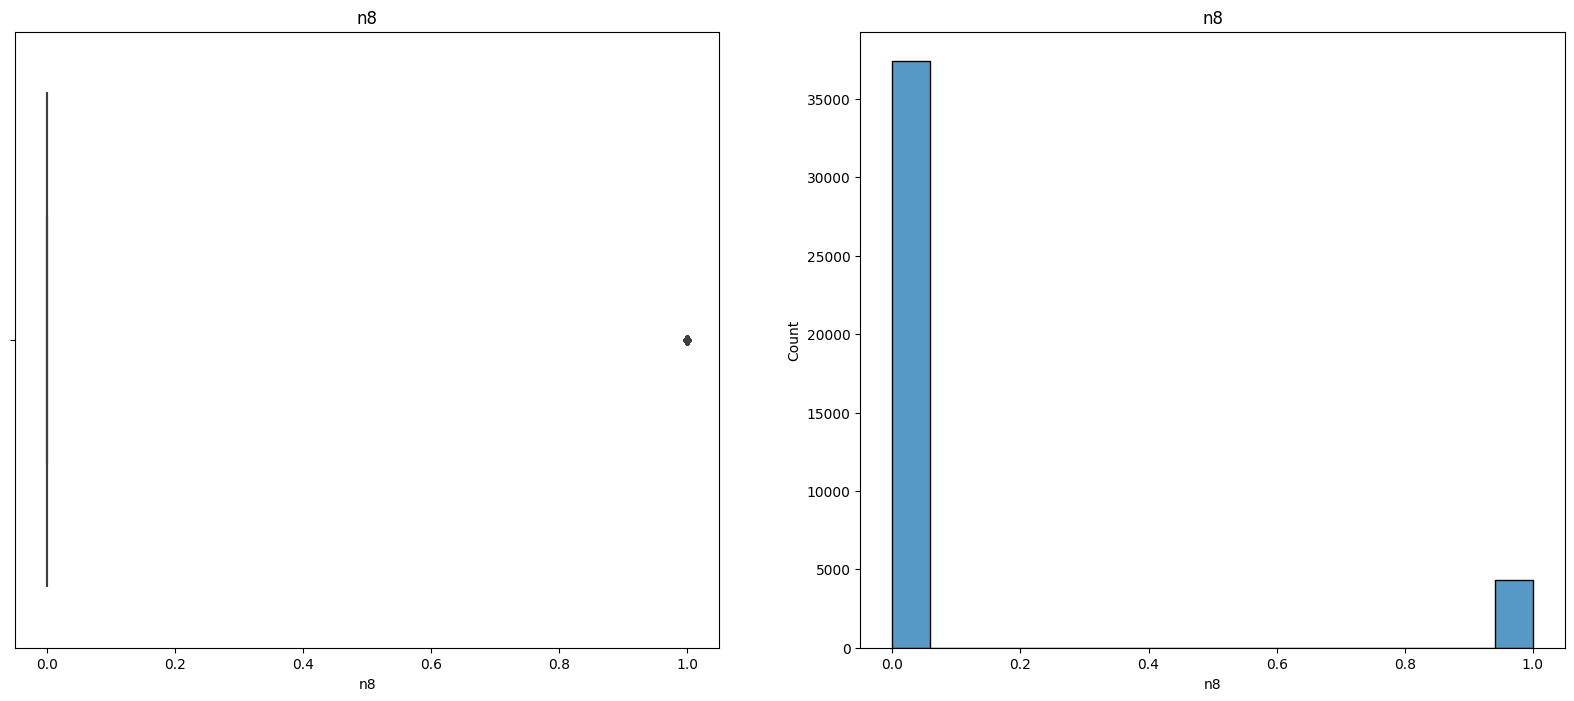

n0


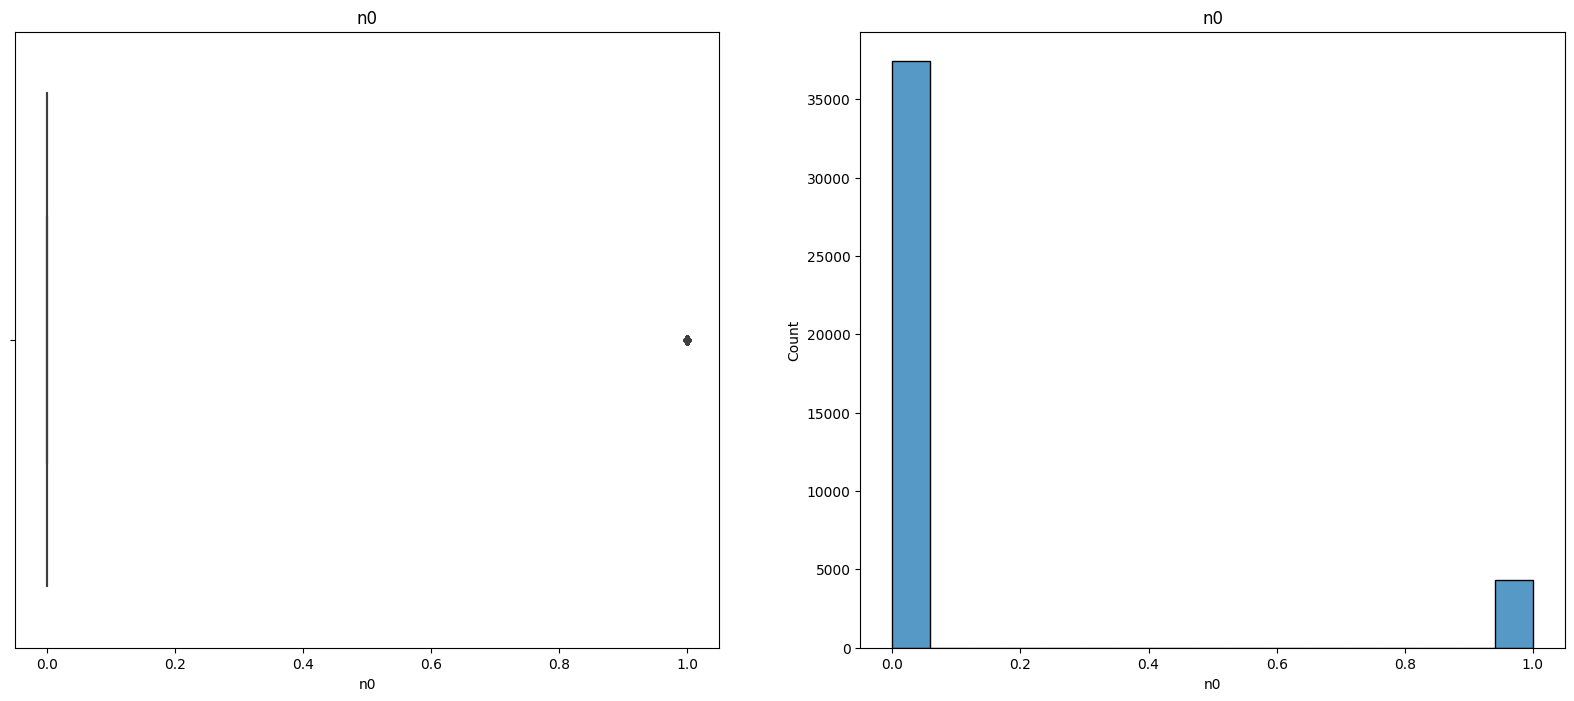

n13


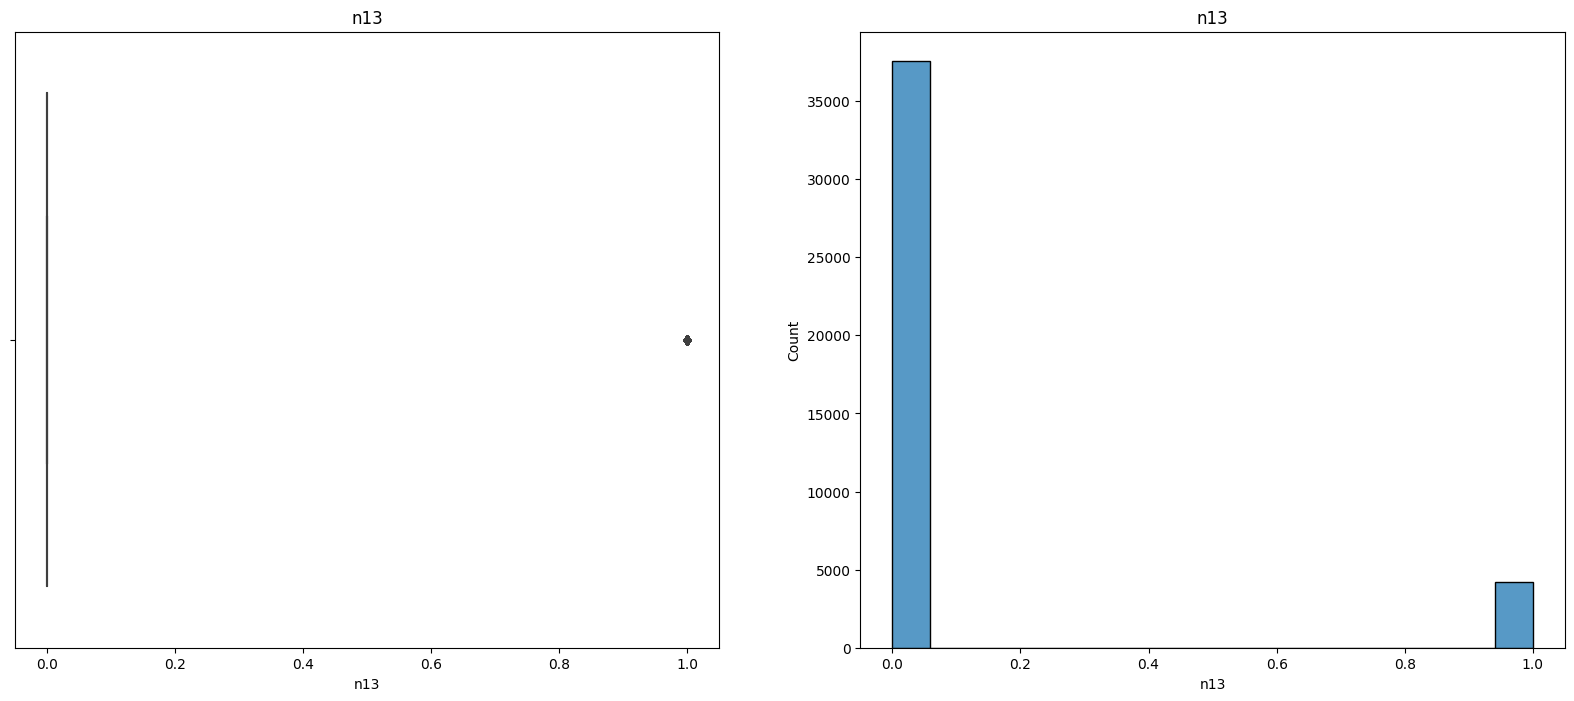

n16


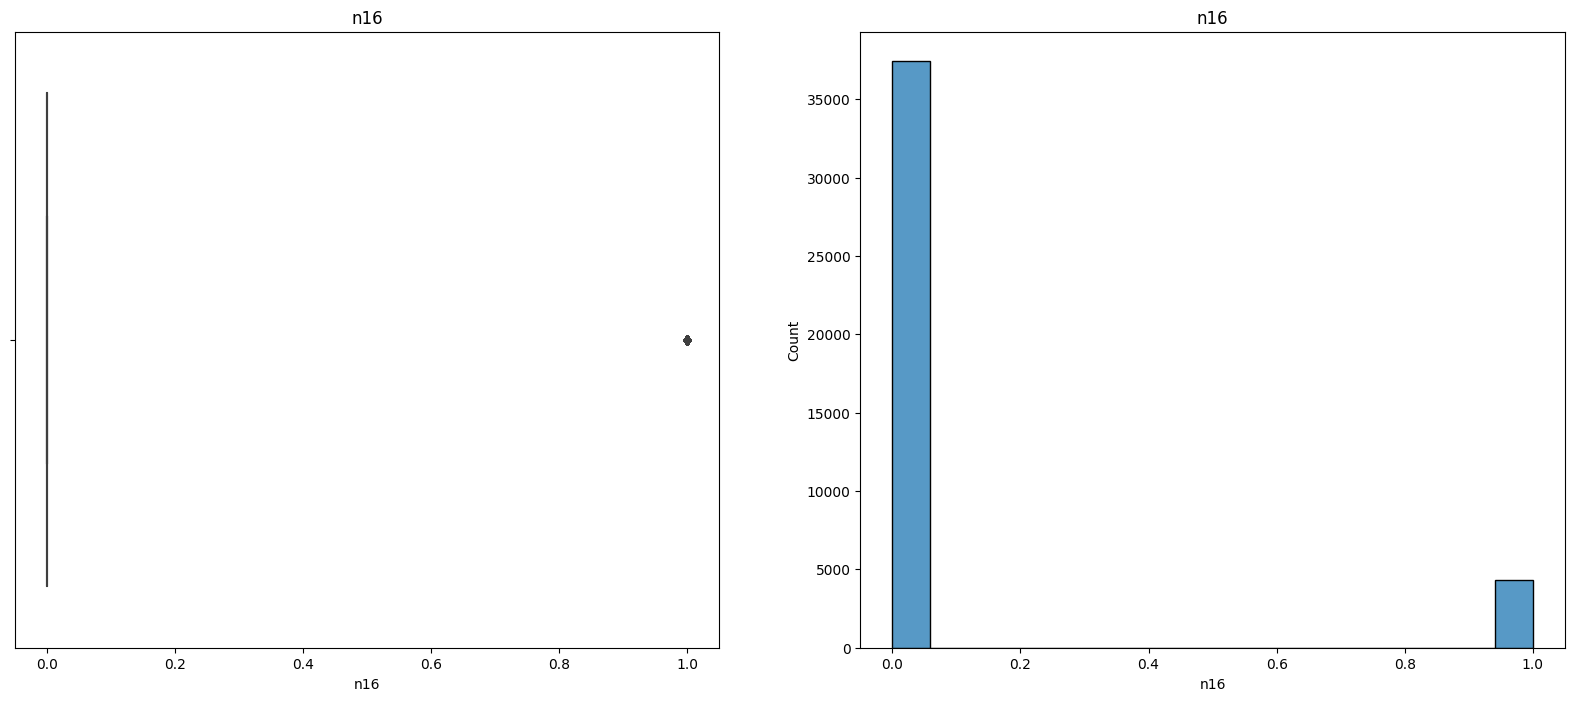

n11


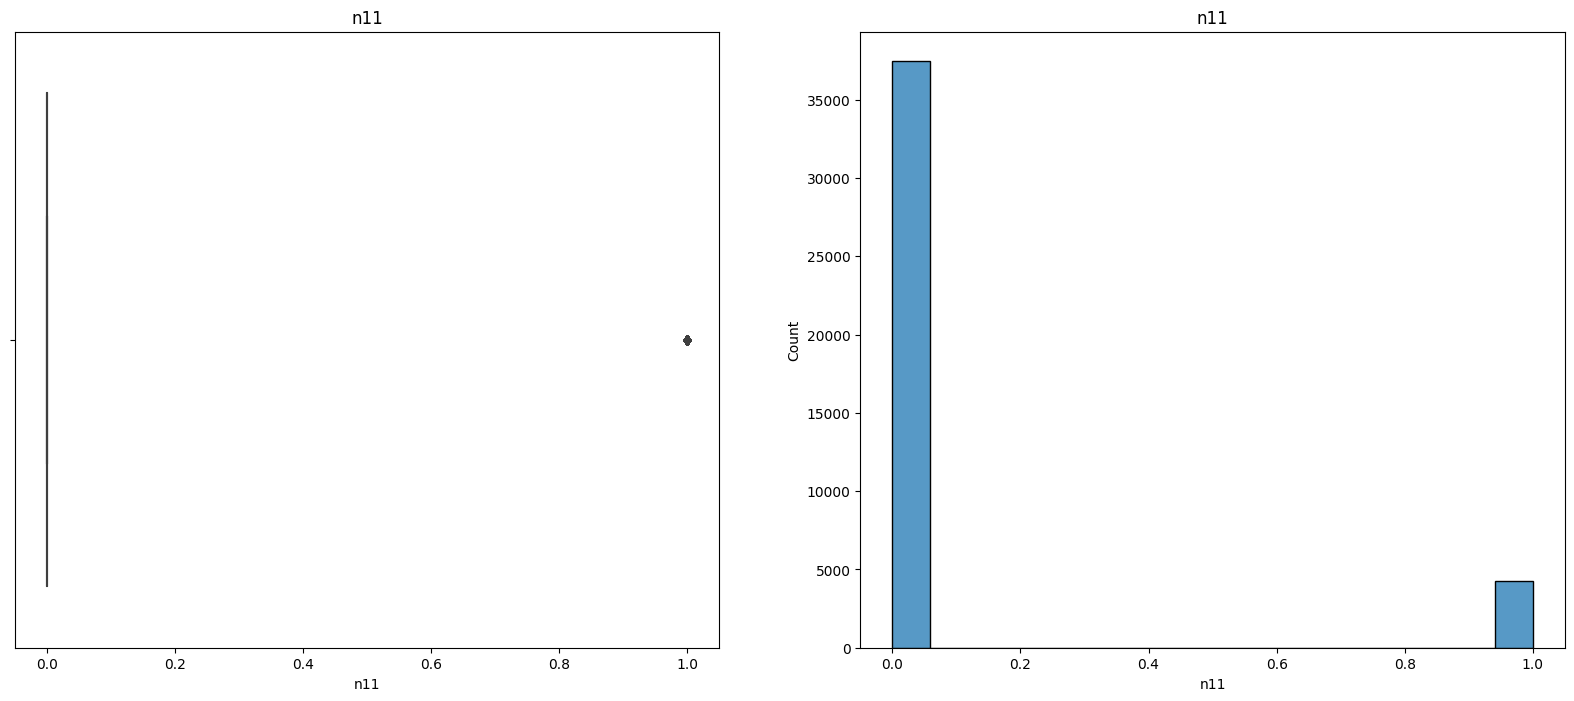

aty


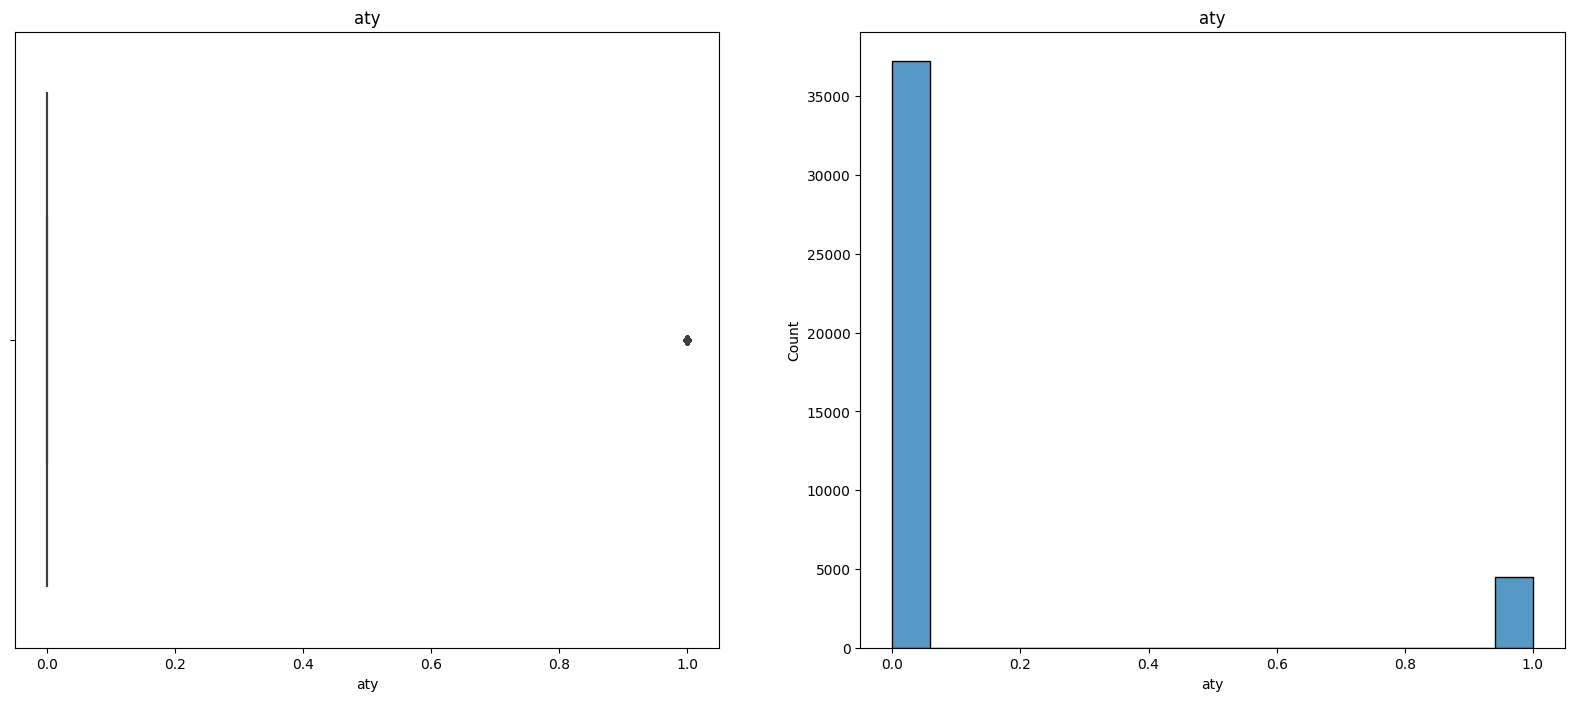

n18


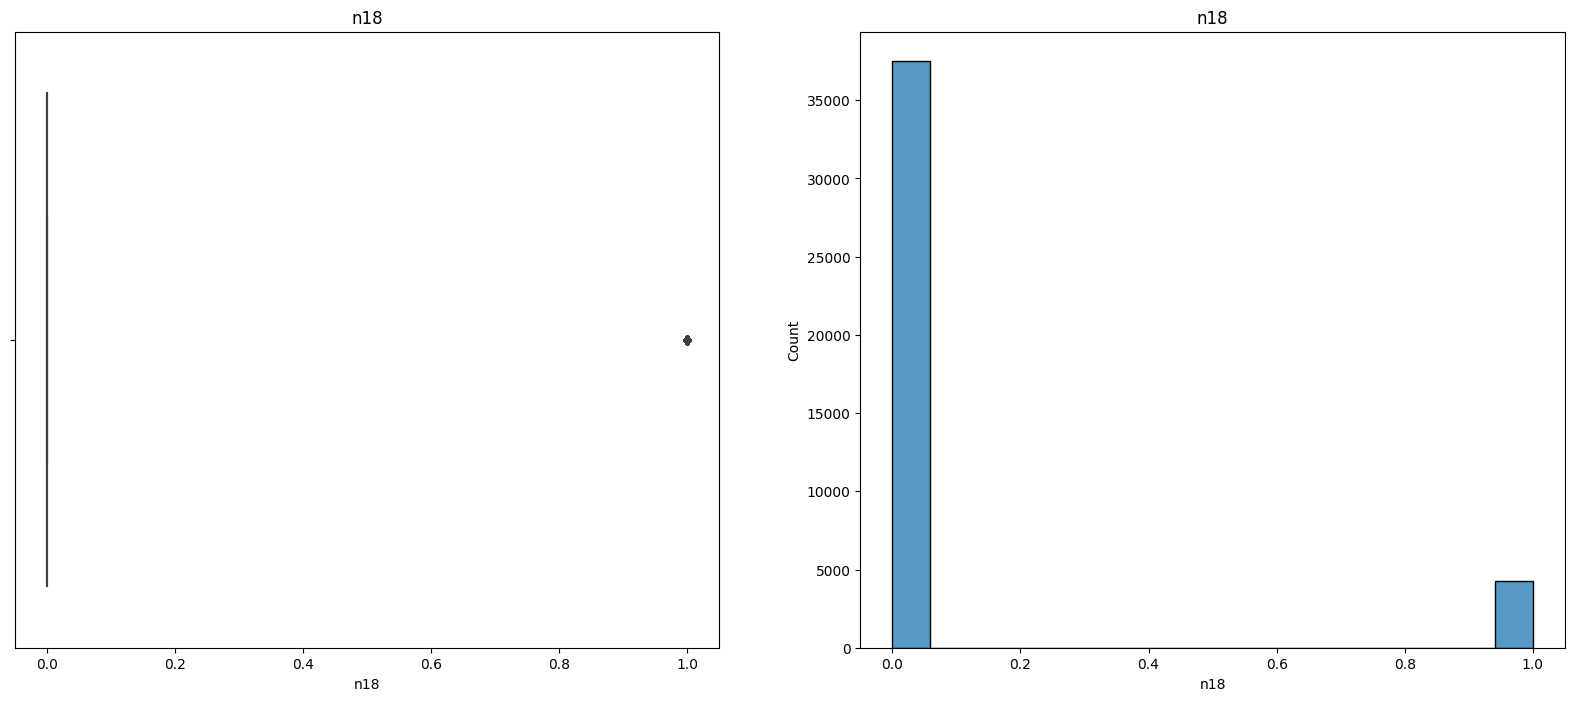

n3


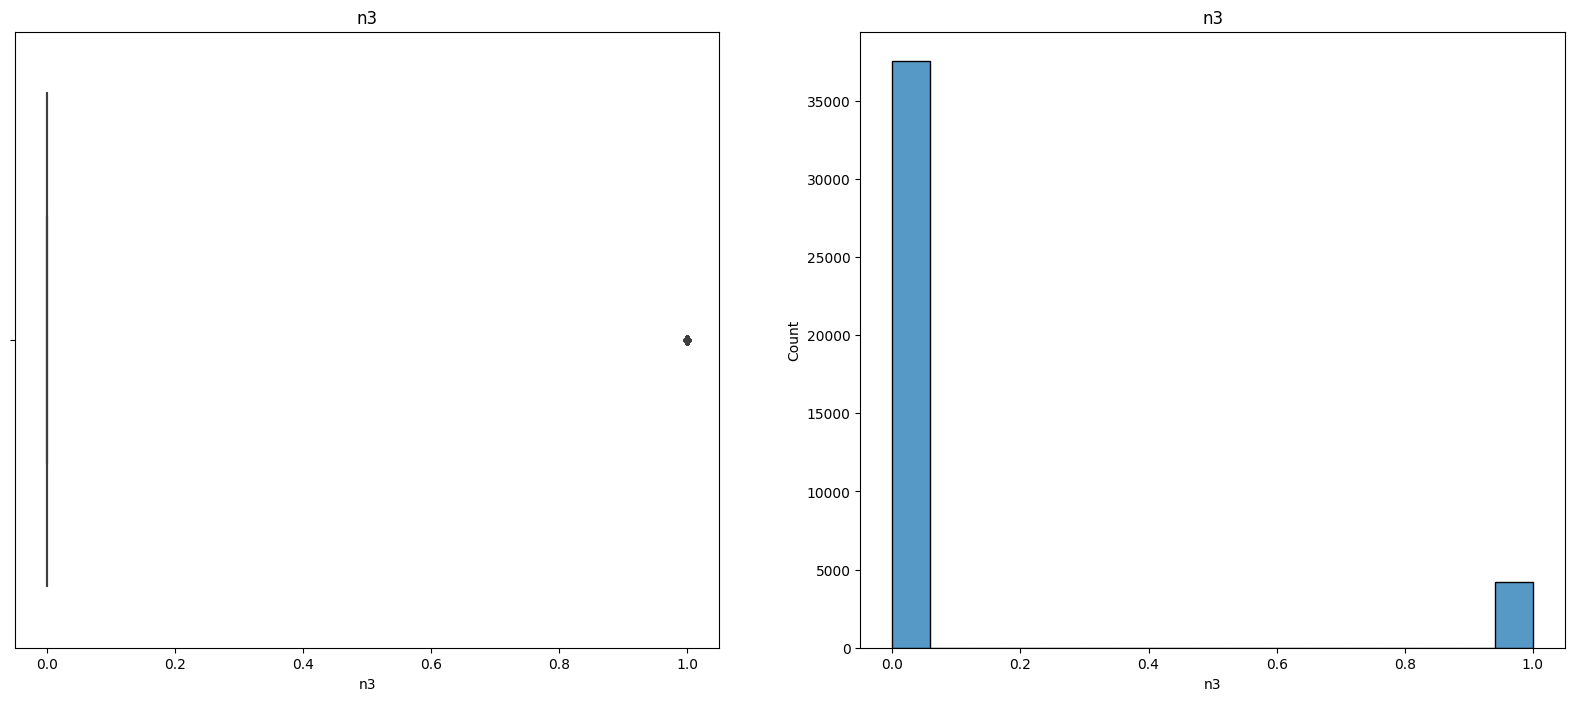

nim


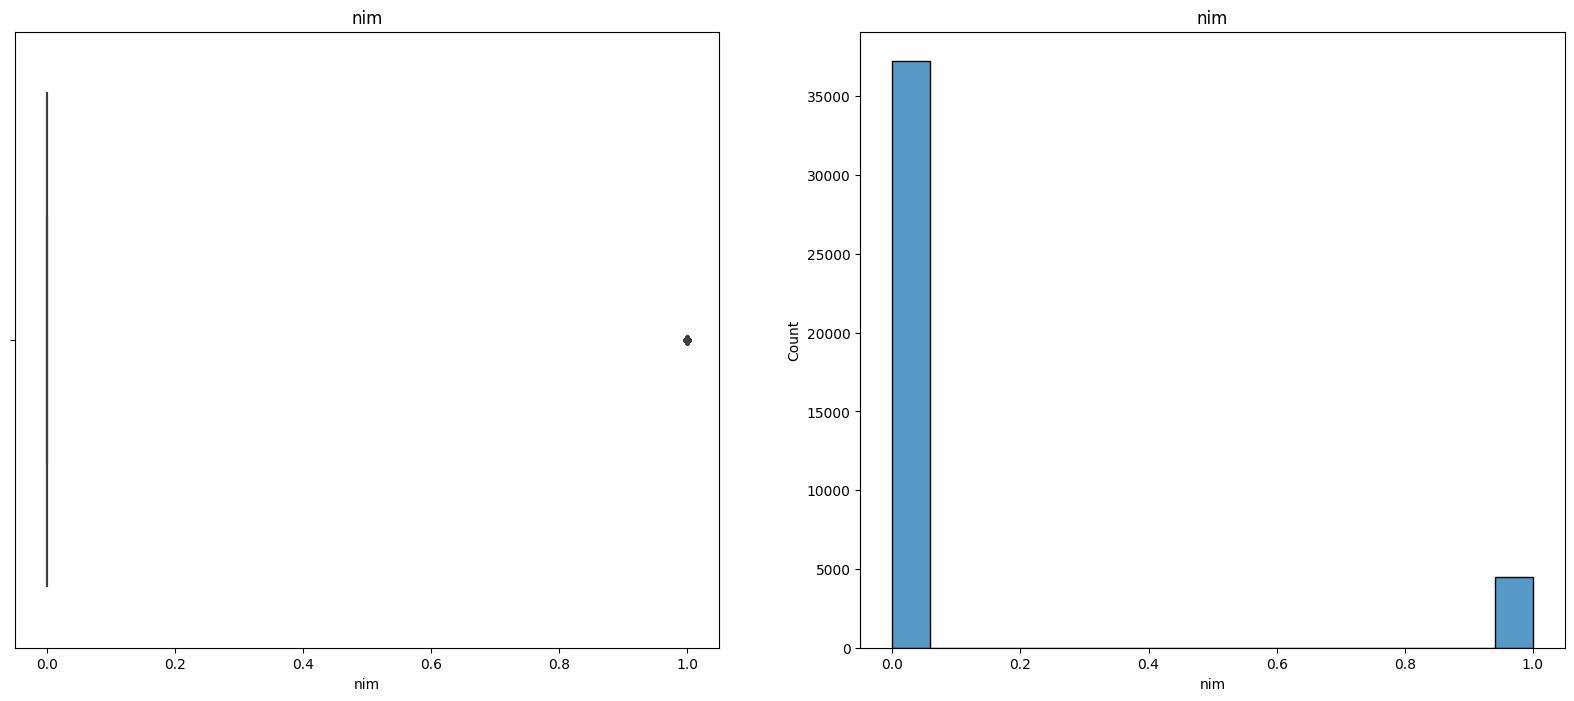

n6


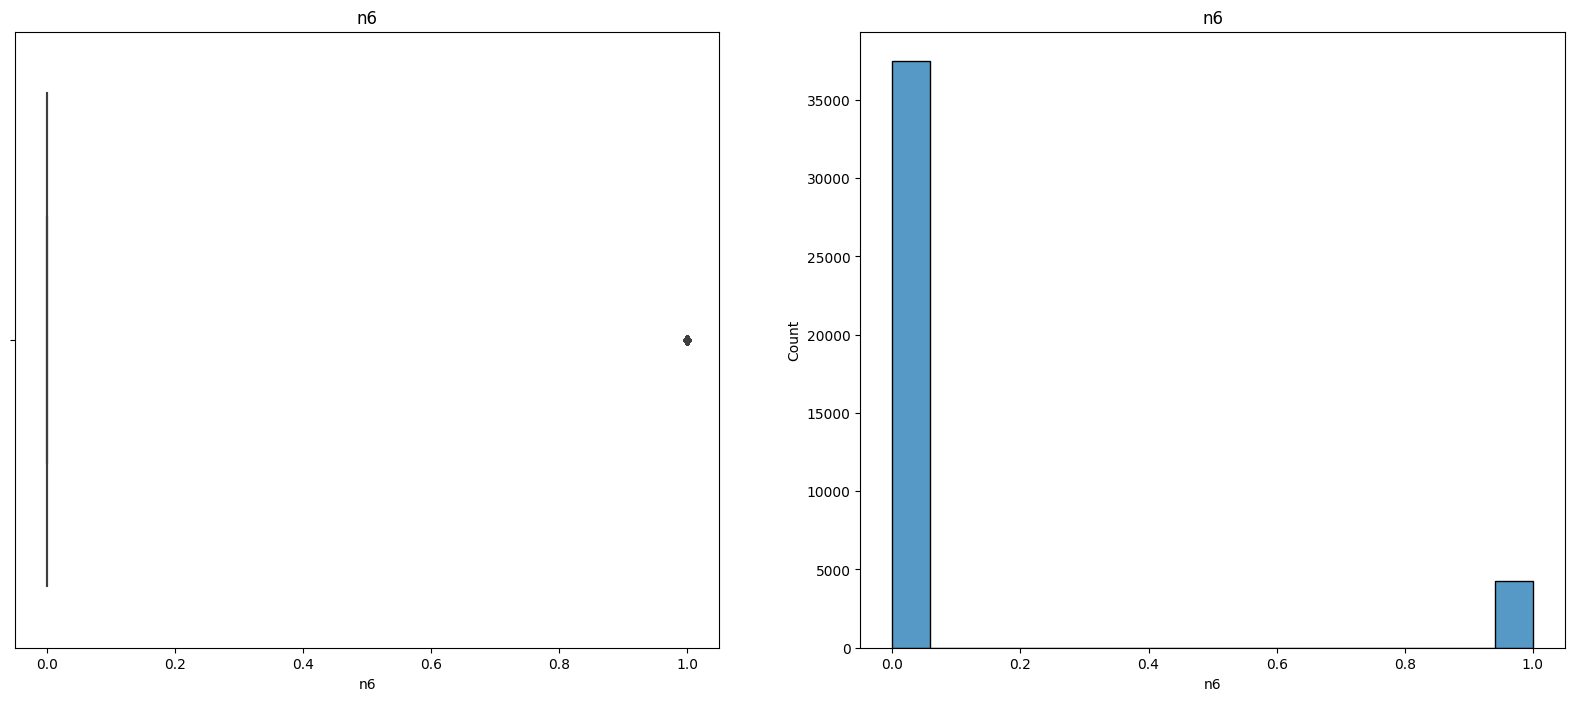

pro+aty


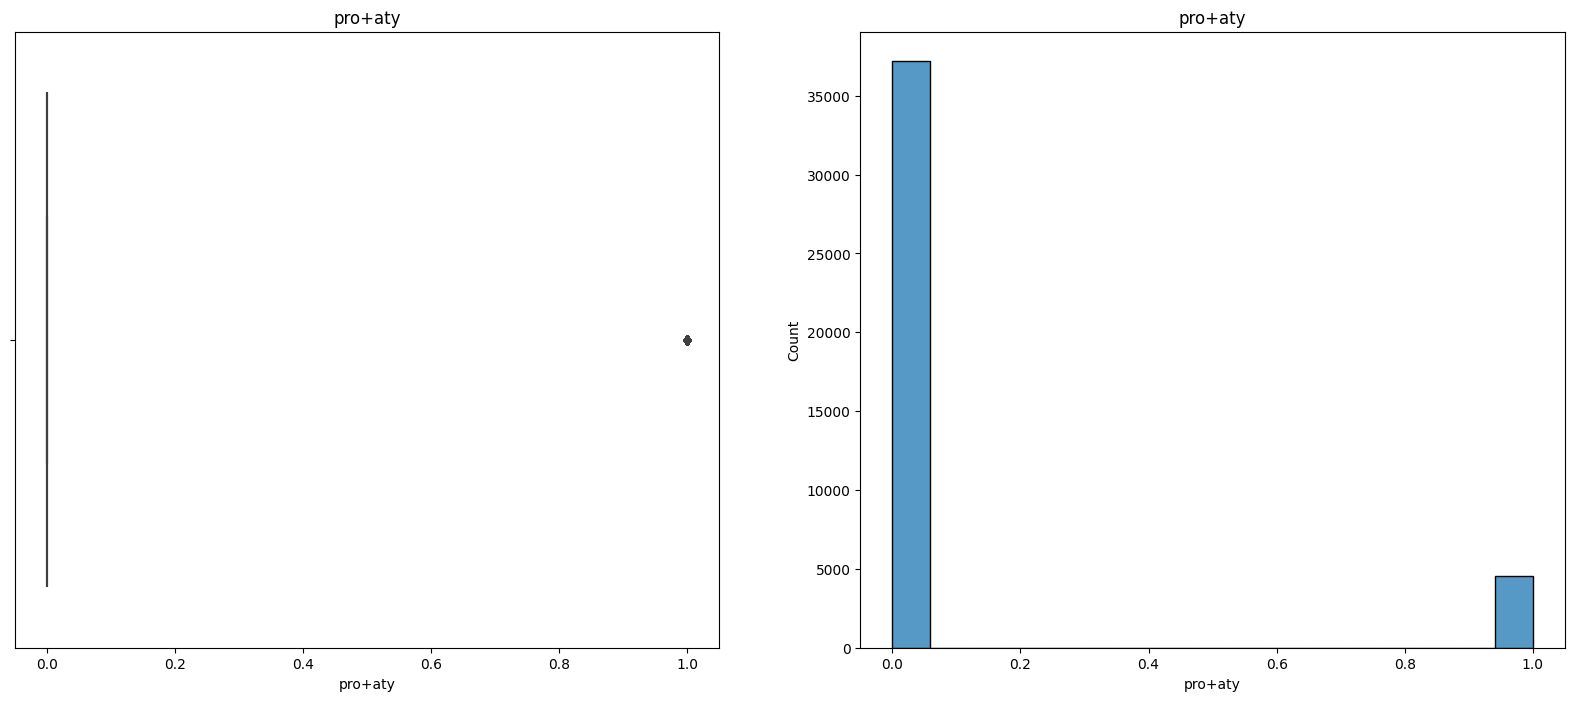

n5


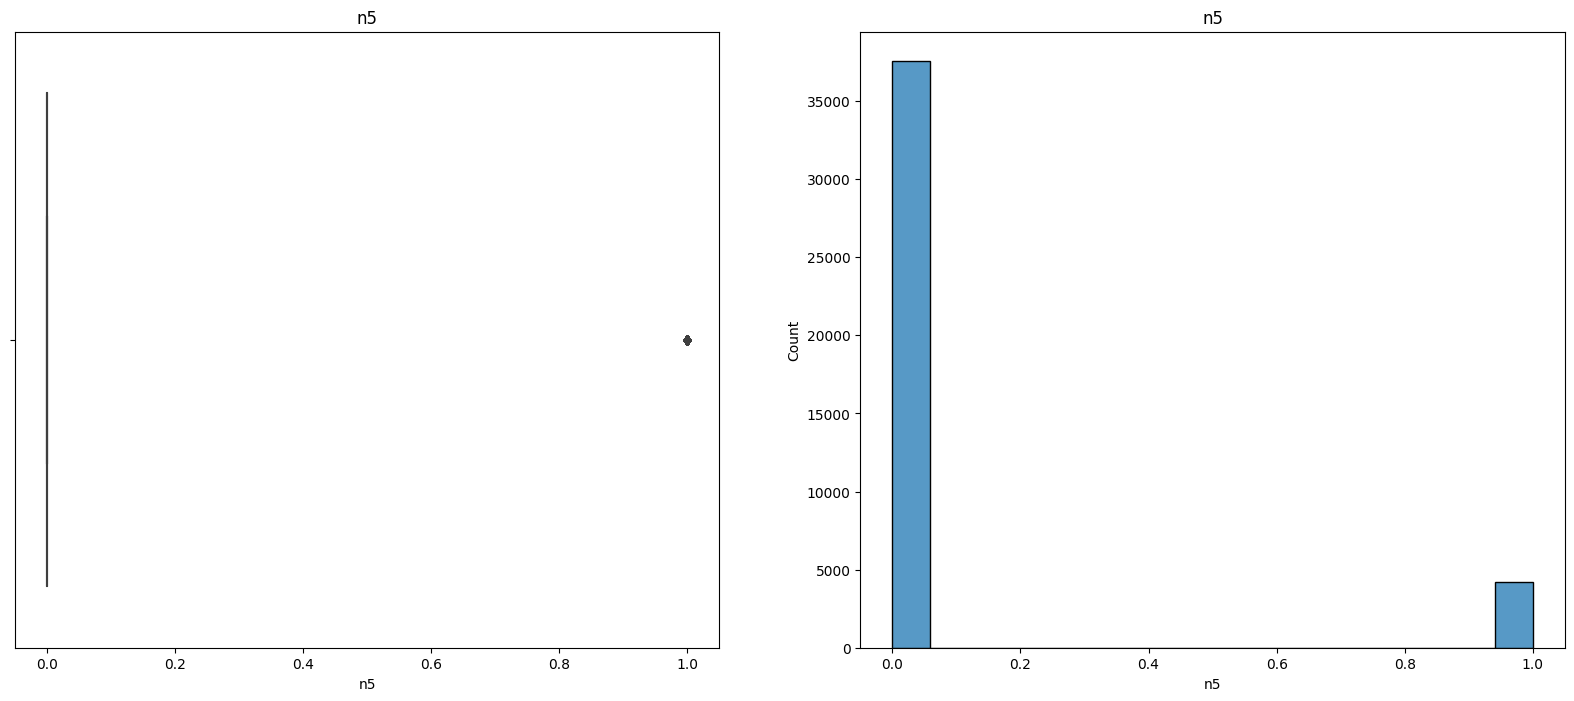

c1


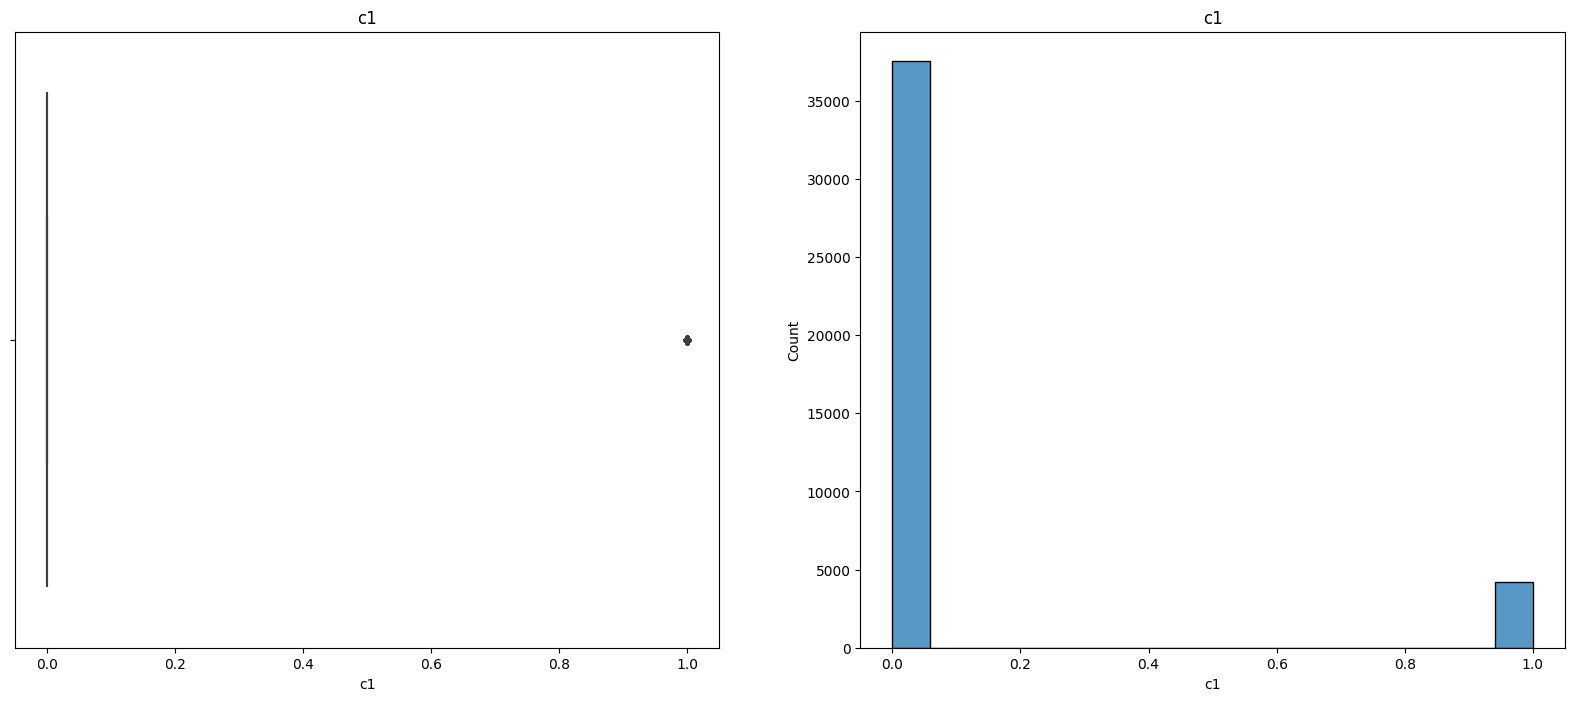

n2


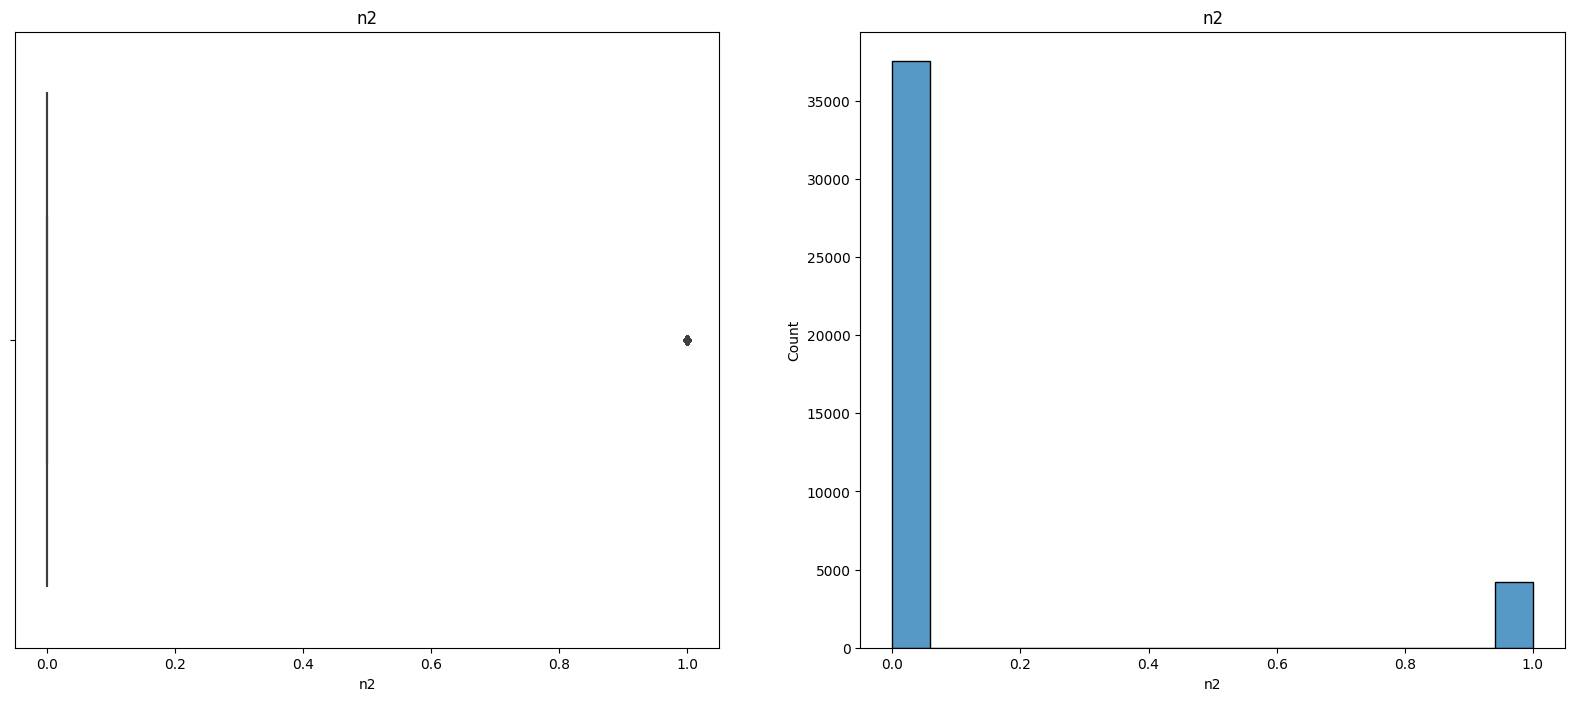

b19


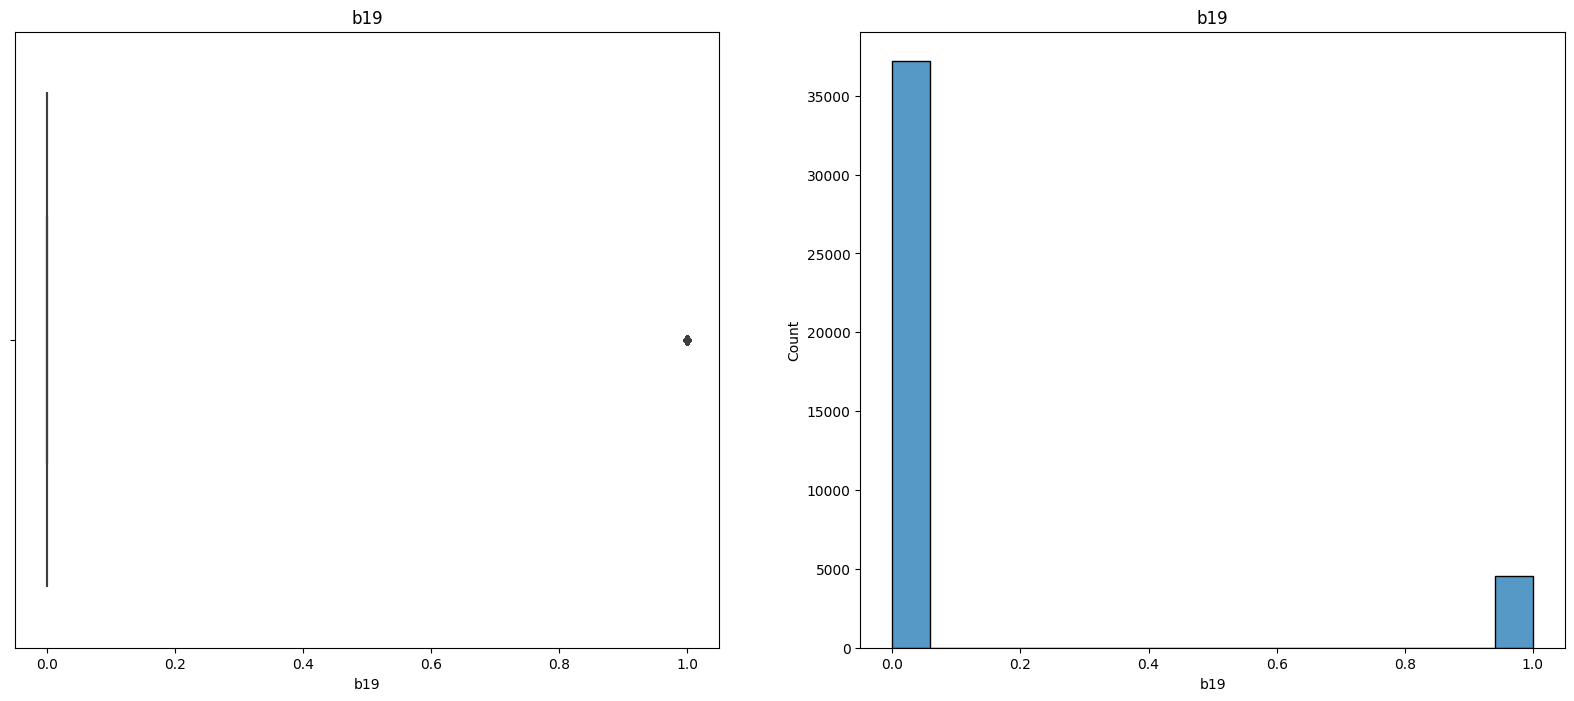

n15


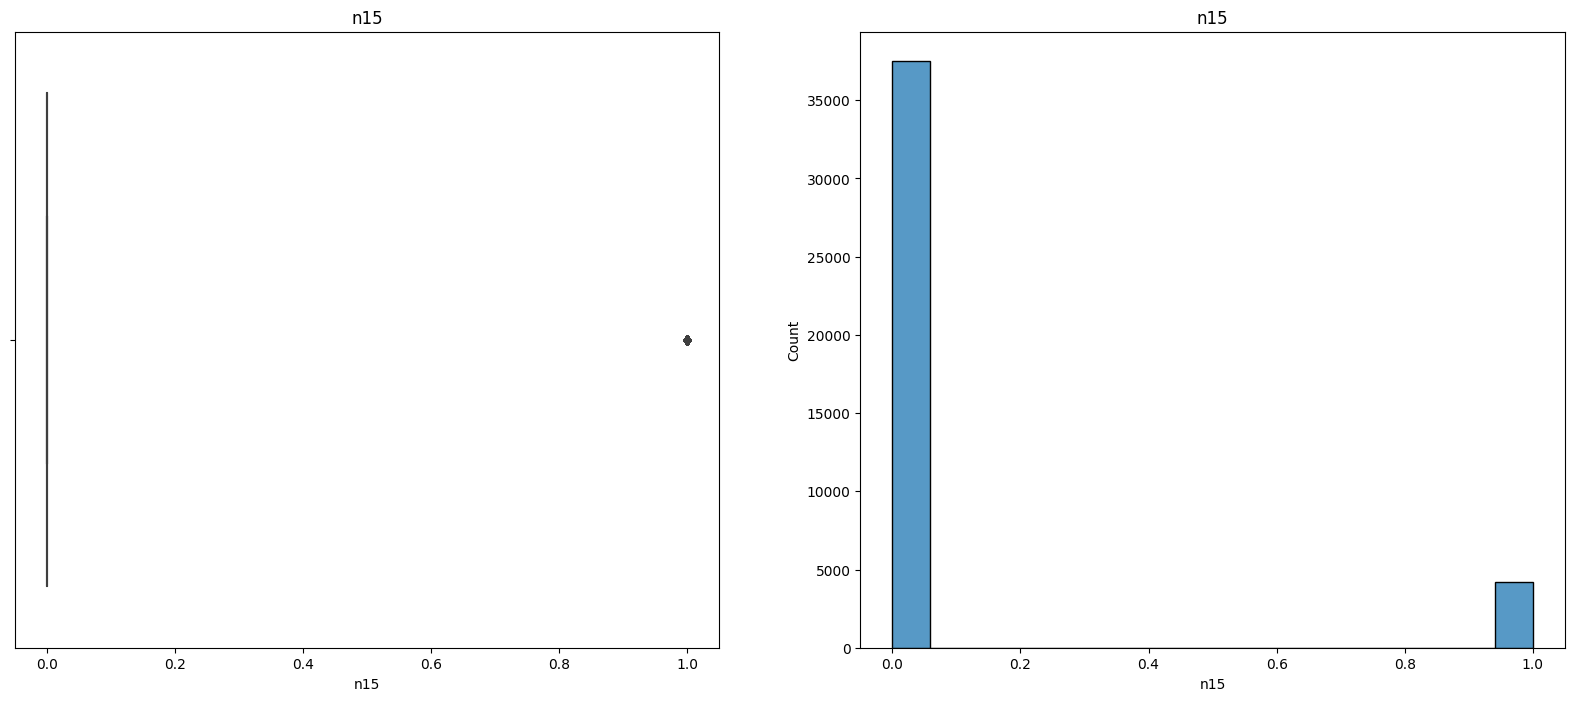

dfa


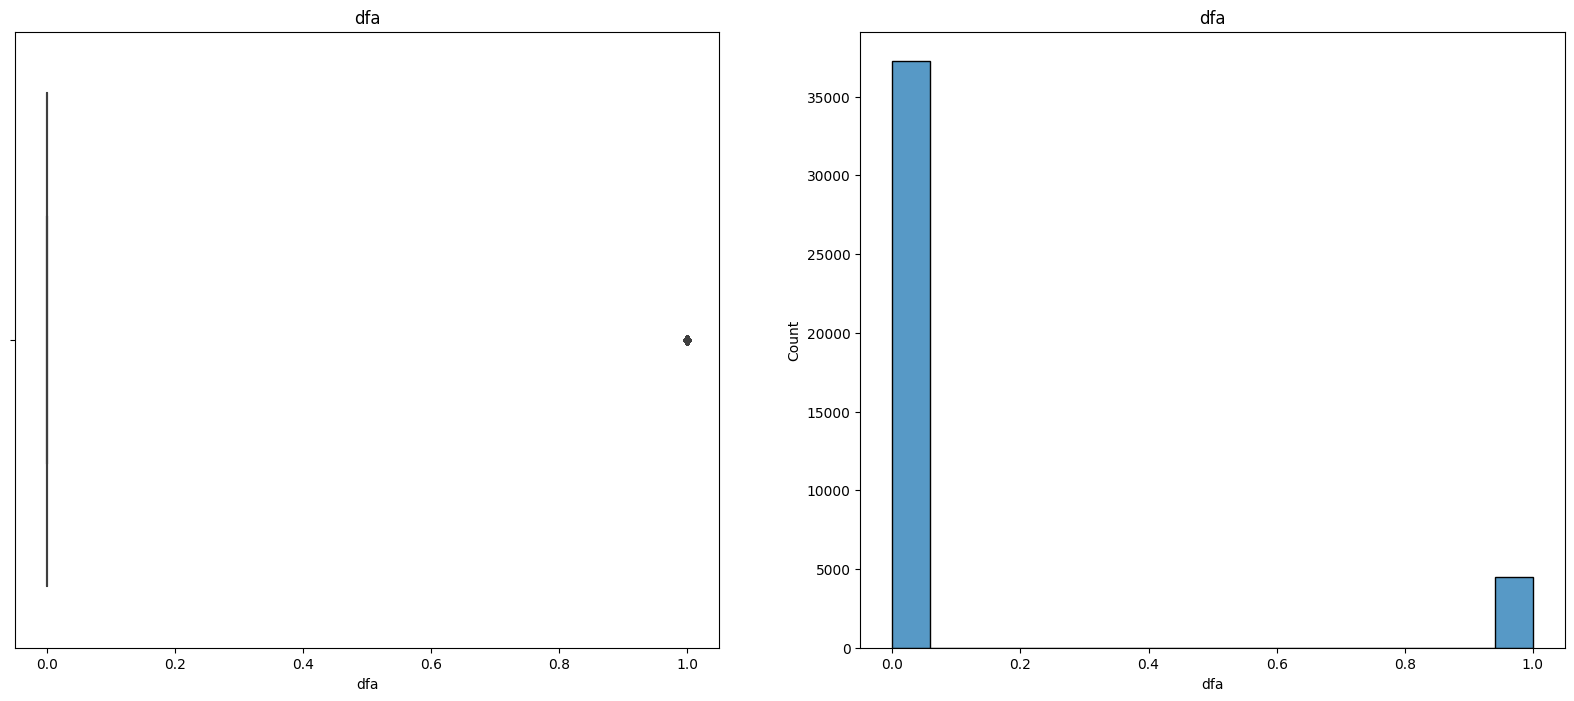

n1


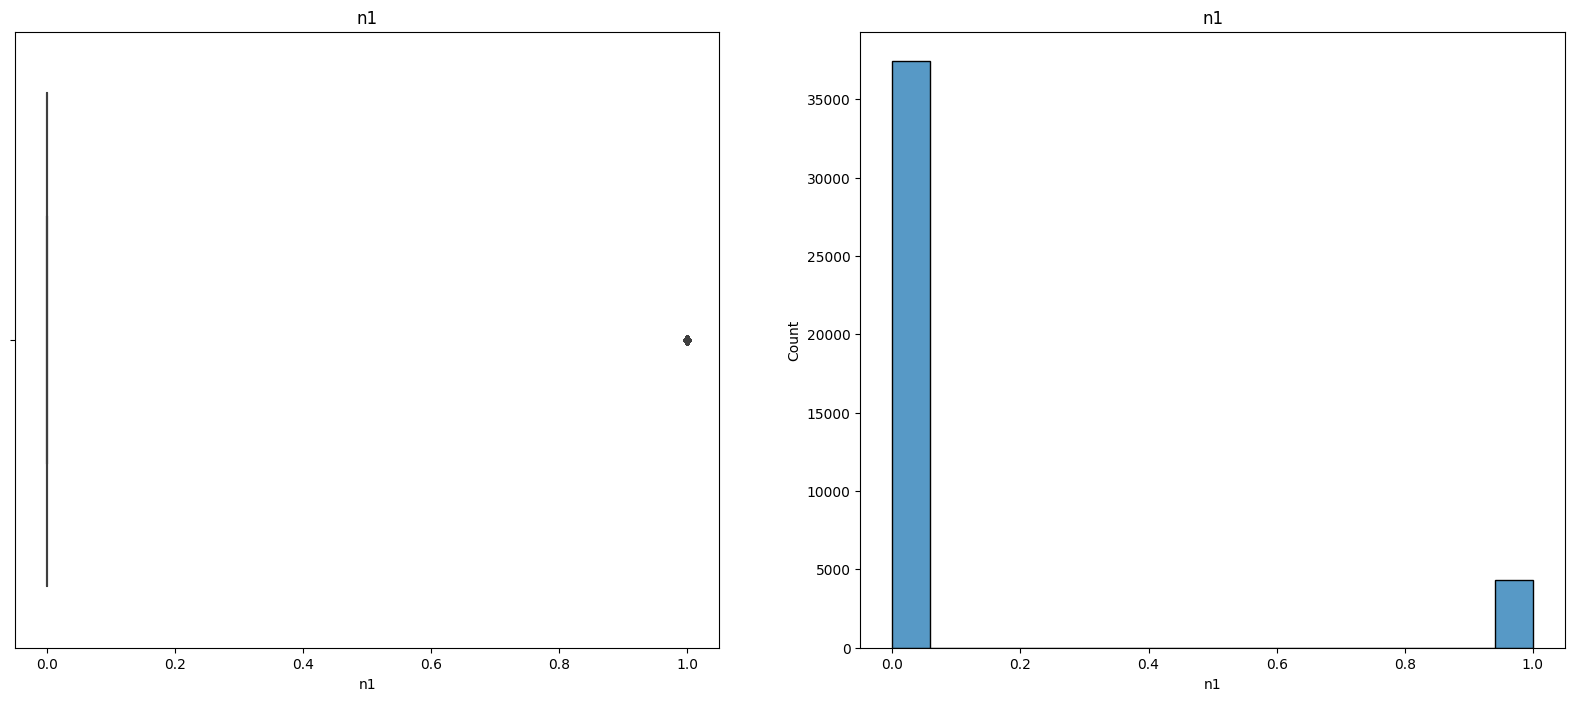

n10


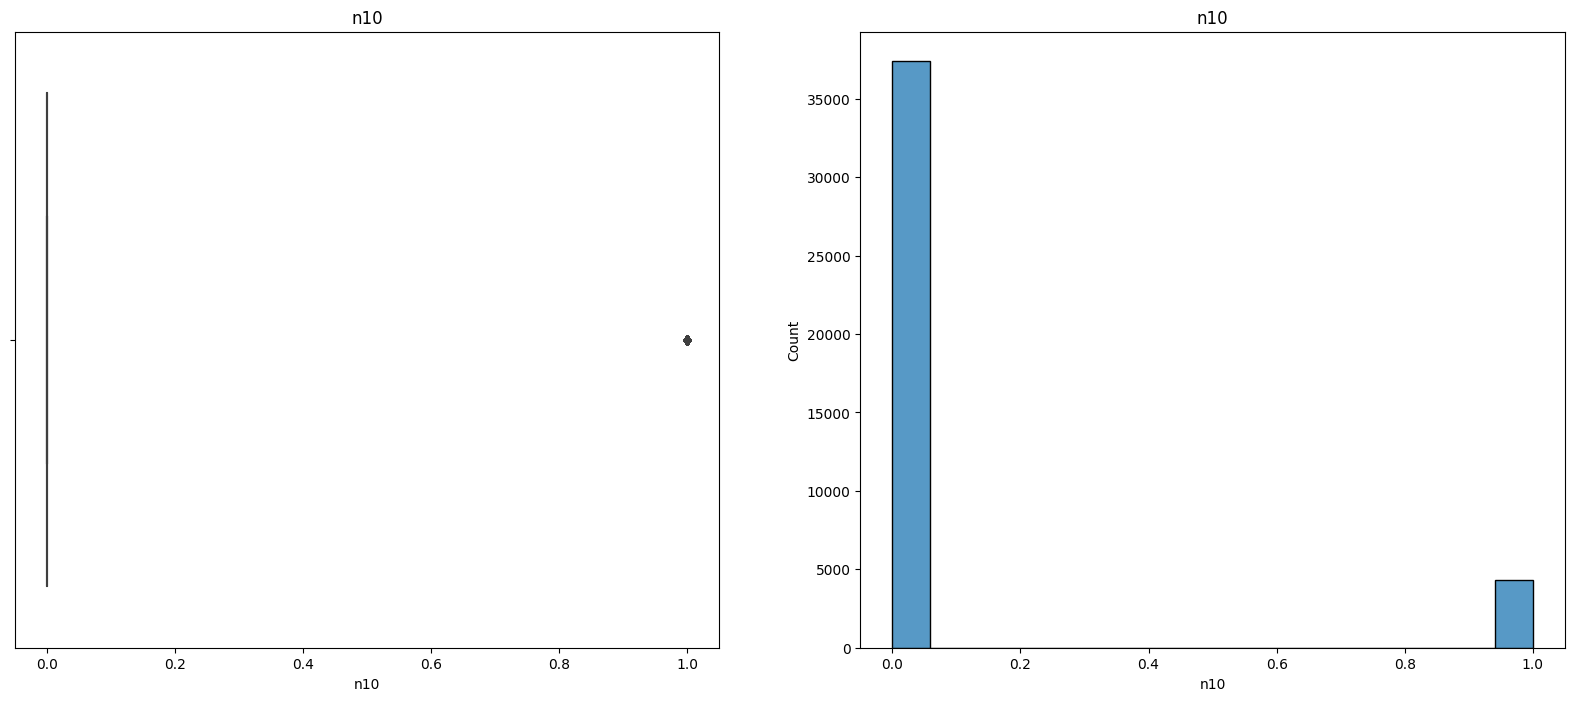

n14


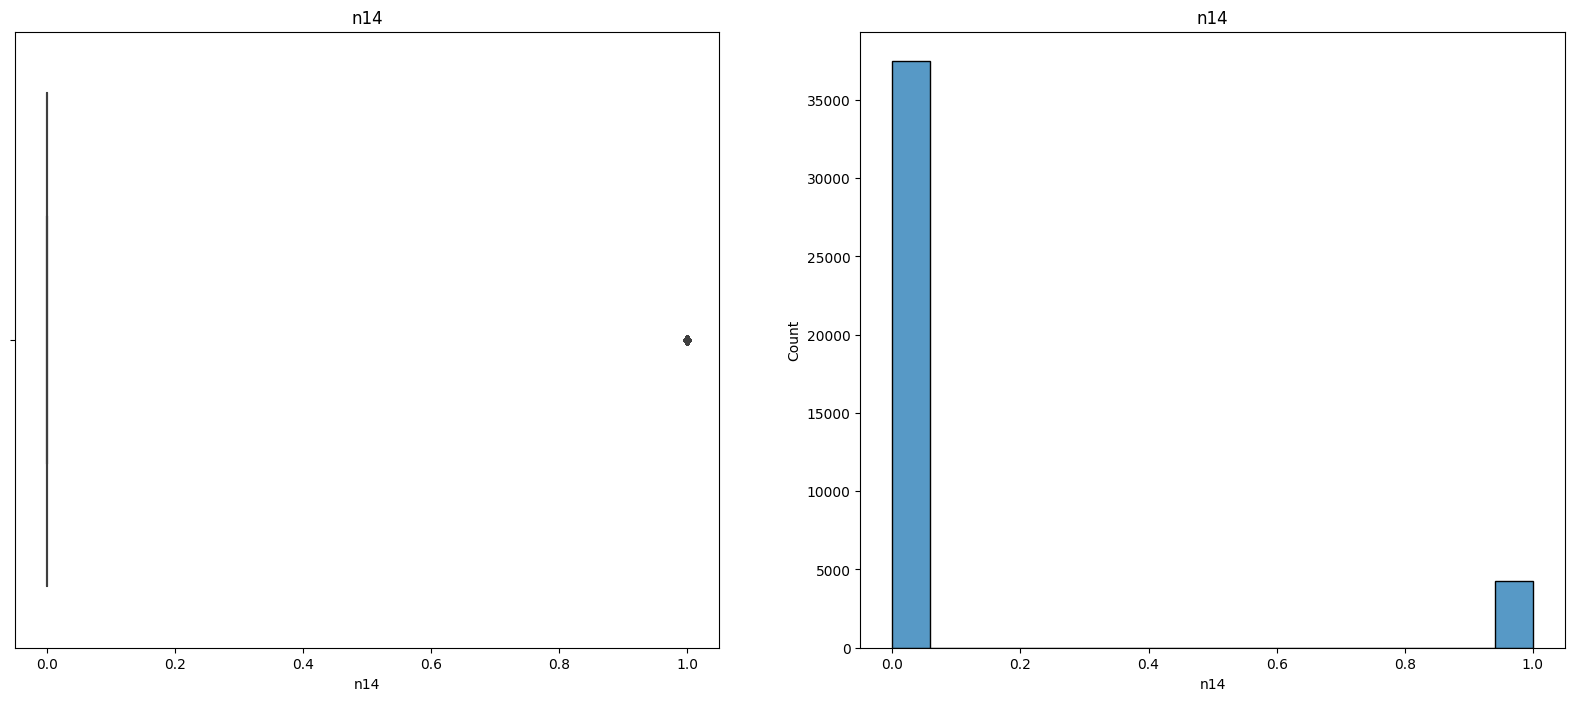

n9


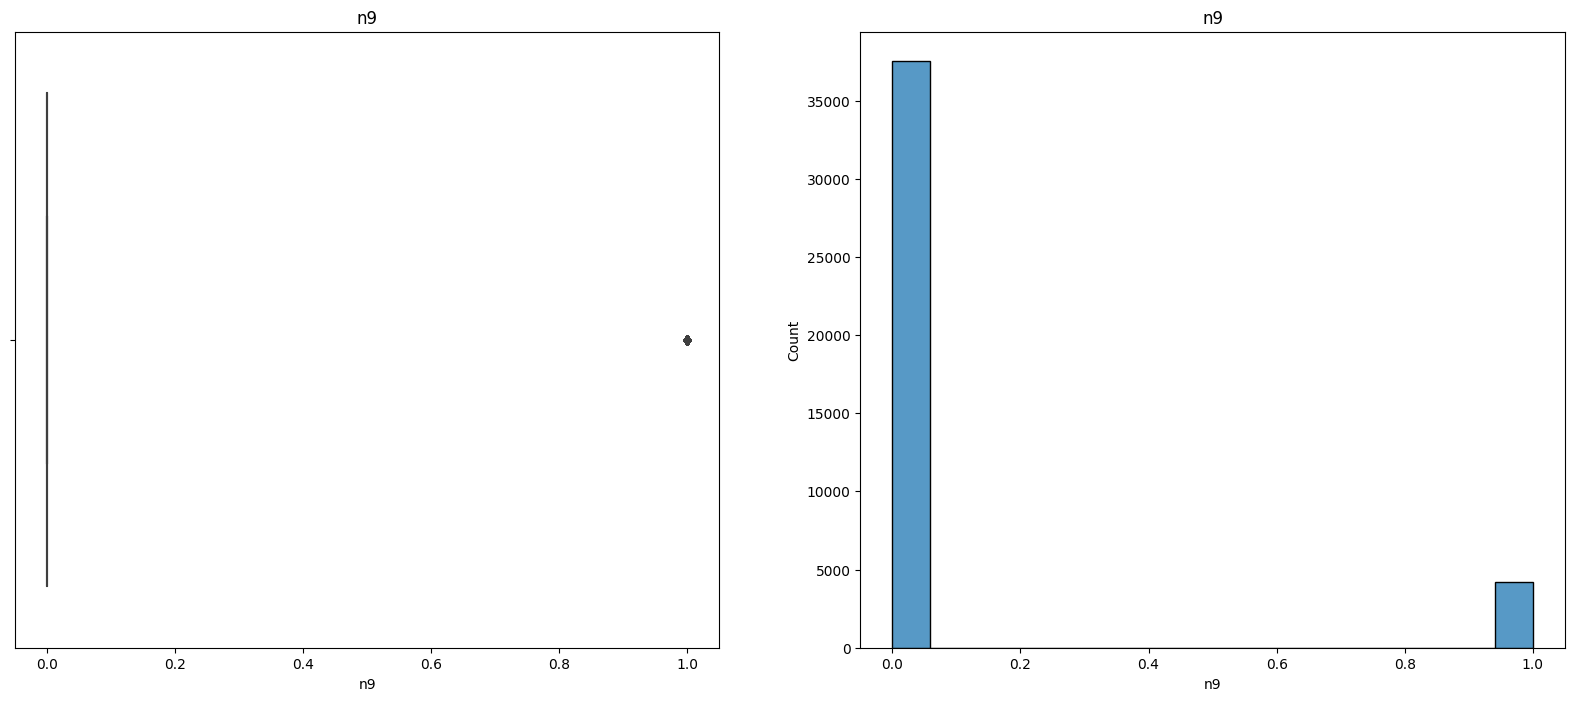

da


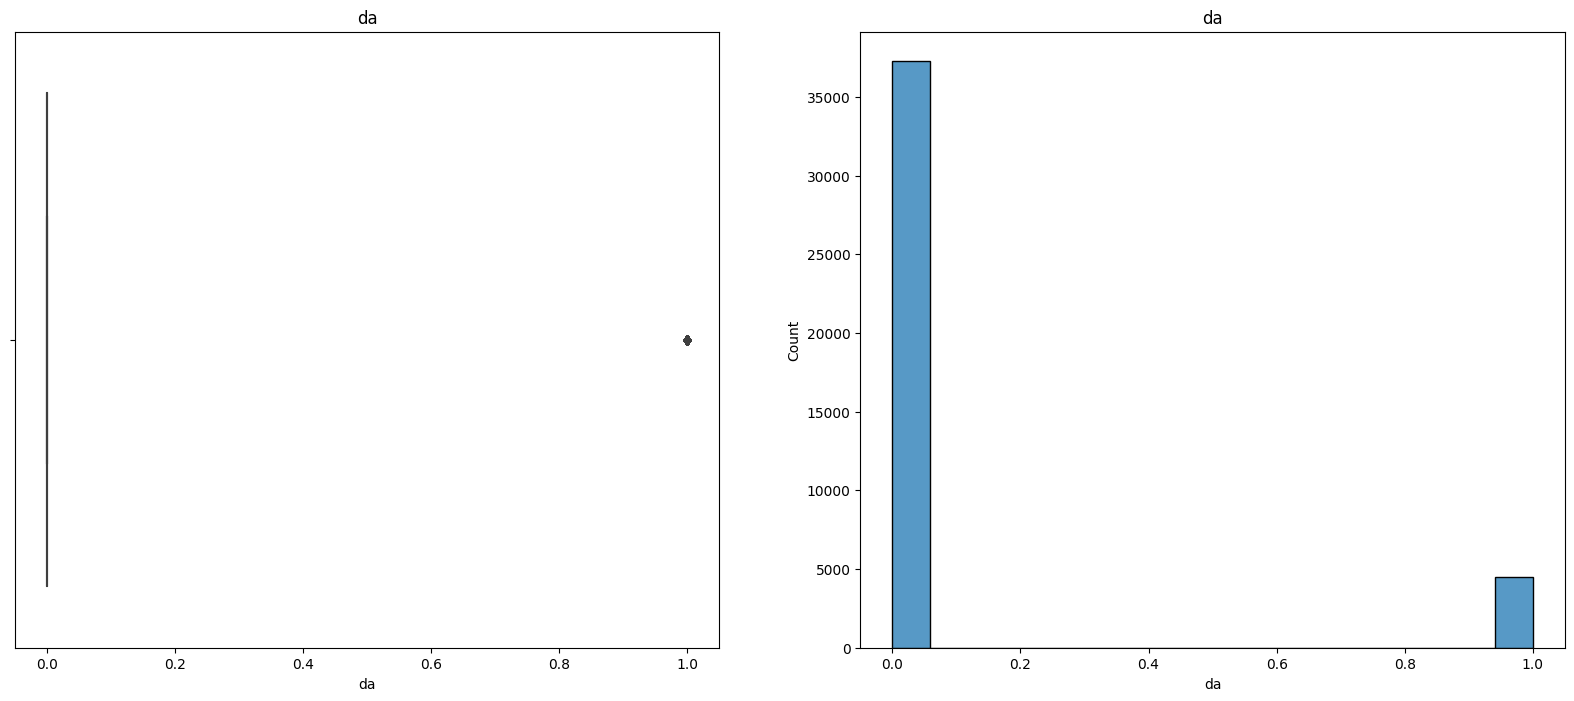

n19


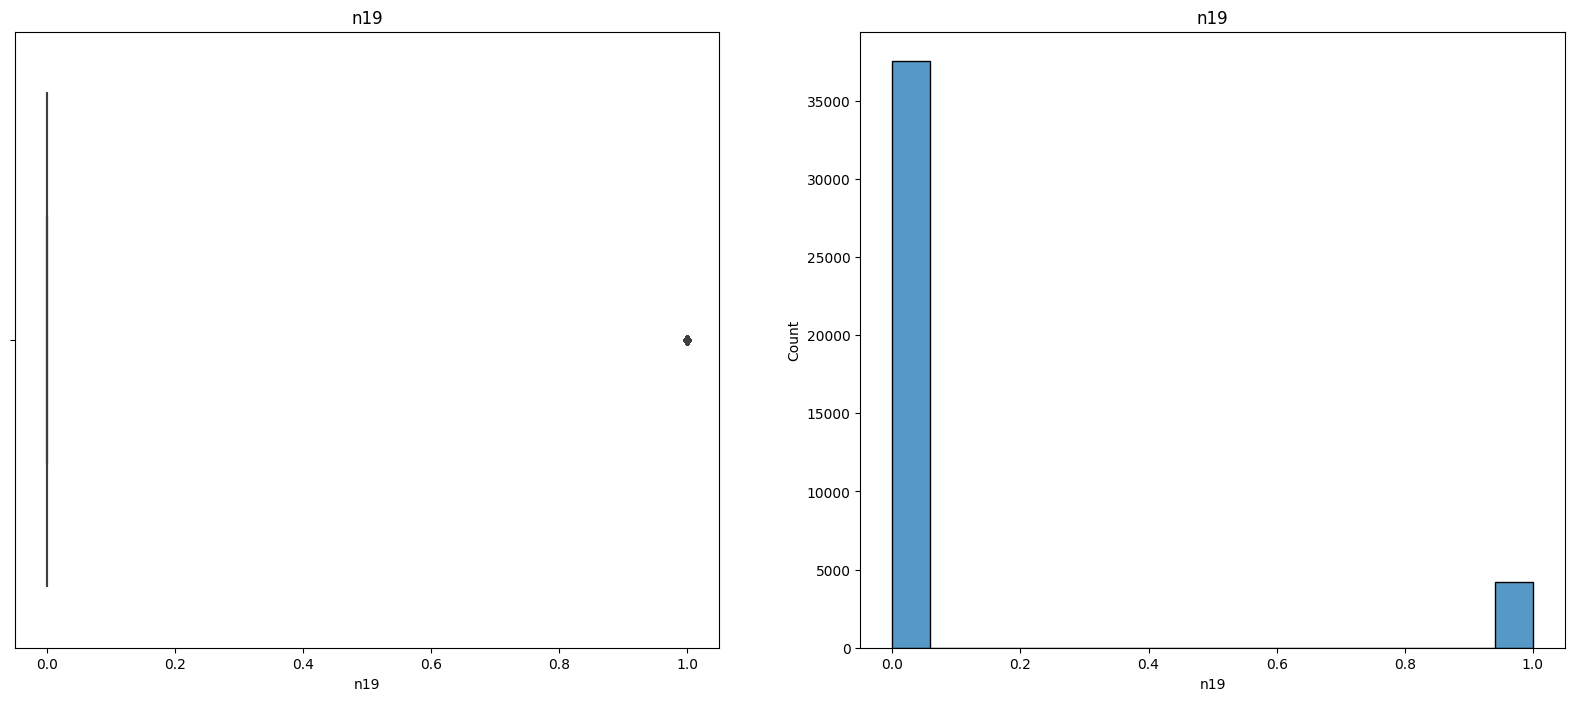

c55


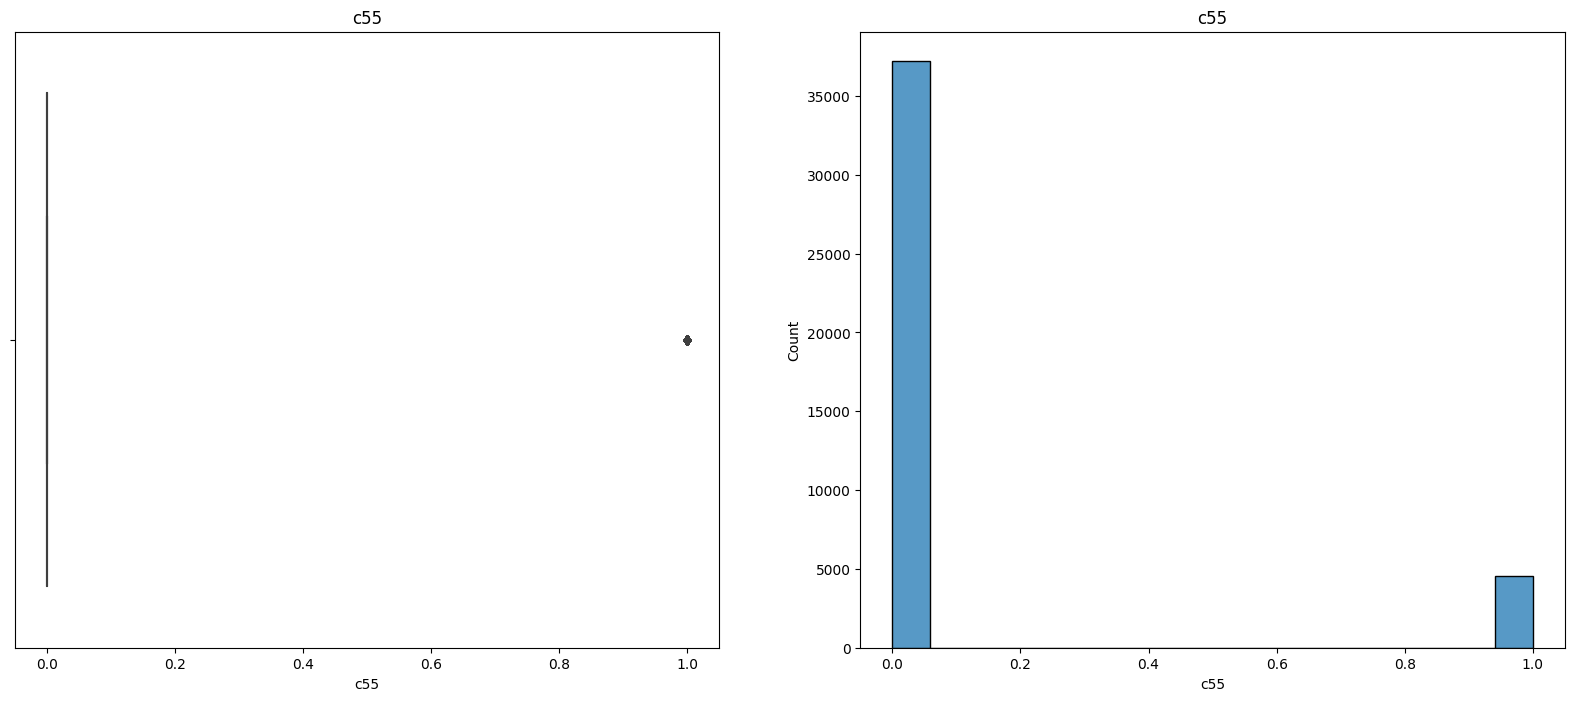

a15


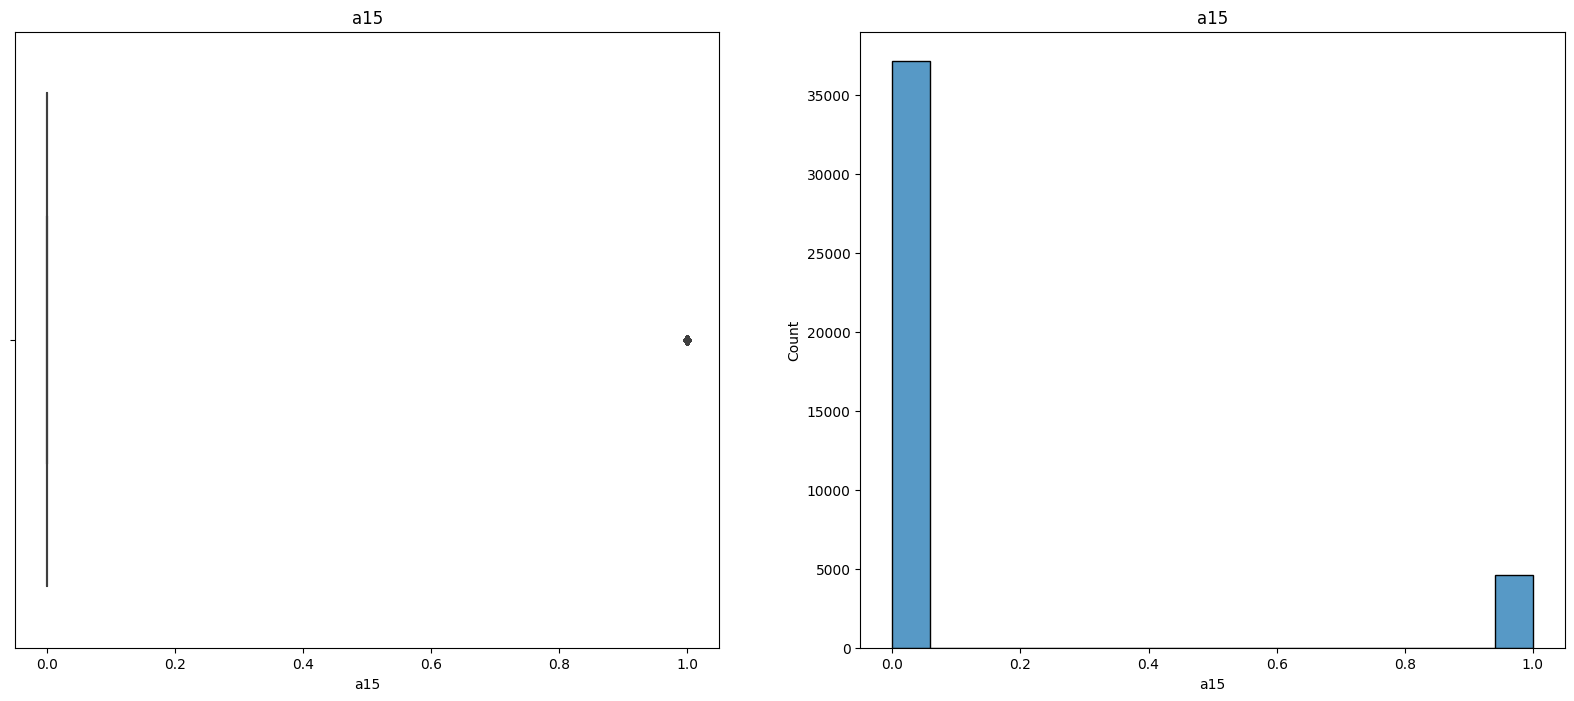

income_diff


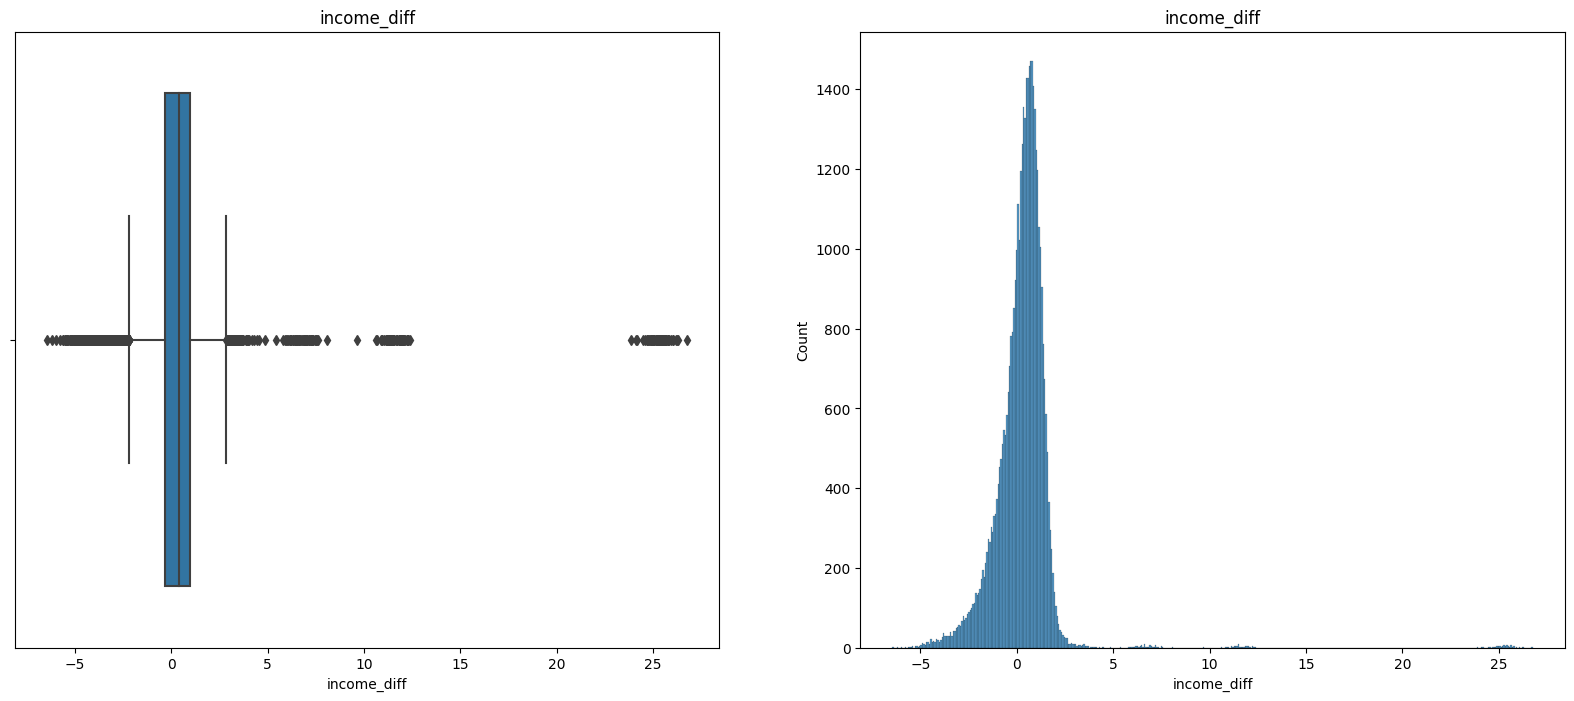

In [23]:
#@title Check all the variables

for name in df_clean.columns:
  print(name)
  fig, axes = plt.subplots(1, 2, figsize=(20, 8))
  ax = axes.reshape(-1)

  sns.boxplot(data=df_clean[[name]], x=name, ax=ax[0])
  ax[0].set_title(name)
  sns.histplot(data=df_clean[[name]], x=name, ax=ax[0 + 1])
  ax[0 + 1].set_title(name)

  plt.show()

# Correlação entre as features

A mairia das features possui quase nenhuma correlação com a `target_default`, a maior correlação é a do `facebook_profile` de $0.15$.

In [24]:
#@title 15 features mais correlacionadas com a variável `target_default`
df_clean['target_default'] = y_hat

corr = df_clean.corr()
df_clean.drop('target_default', axis=1, inplace=True)

corr['target_default'].apply(lambda x: np.abs(x)).sort_values(ascending=False)[:15]

target_default                              1.000000
facebook_profile                            0.155150
ddd                                         0.126237
risk_rate                                   0.096783
external_data_provider_email_seen_before    0.072486
score_1                                     0.070576
application_time_applied                    0.069126
income                                      0.057041
score_3                                     0.047100
marketing_channel                           0.036473
a15                                         0.030000
real_state                                  0.028294
n_issues                                    0.023929
pro+aty                                     0.023845
da                                          0.022569
Name: target_default, dtype: float64

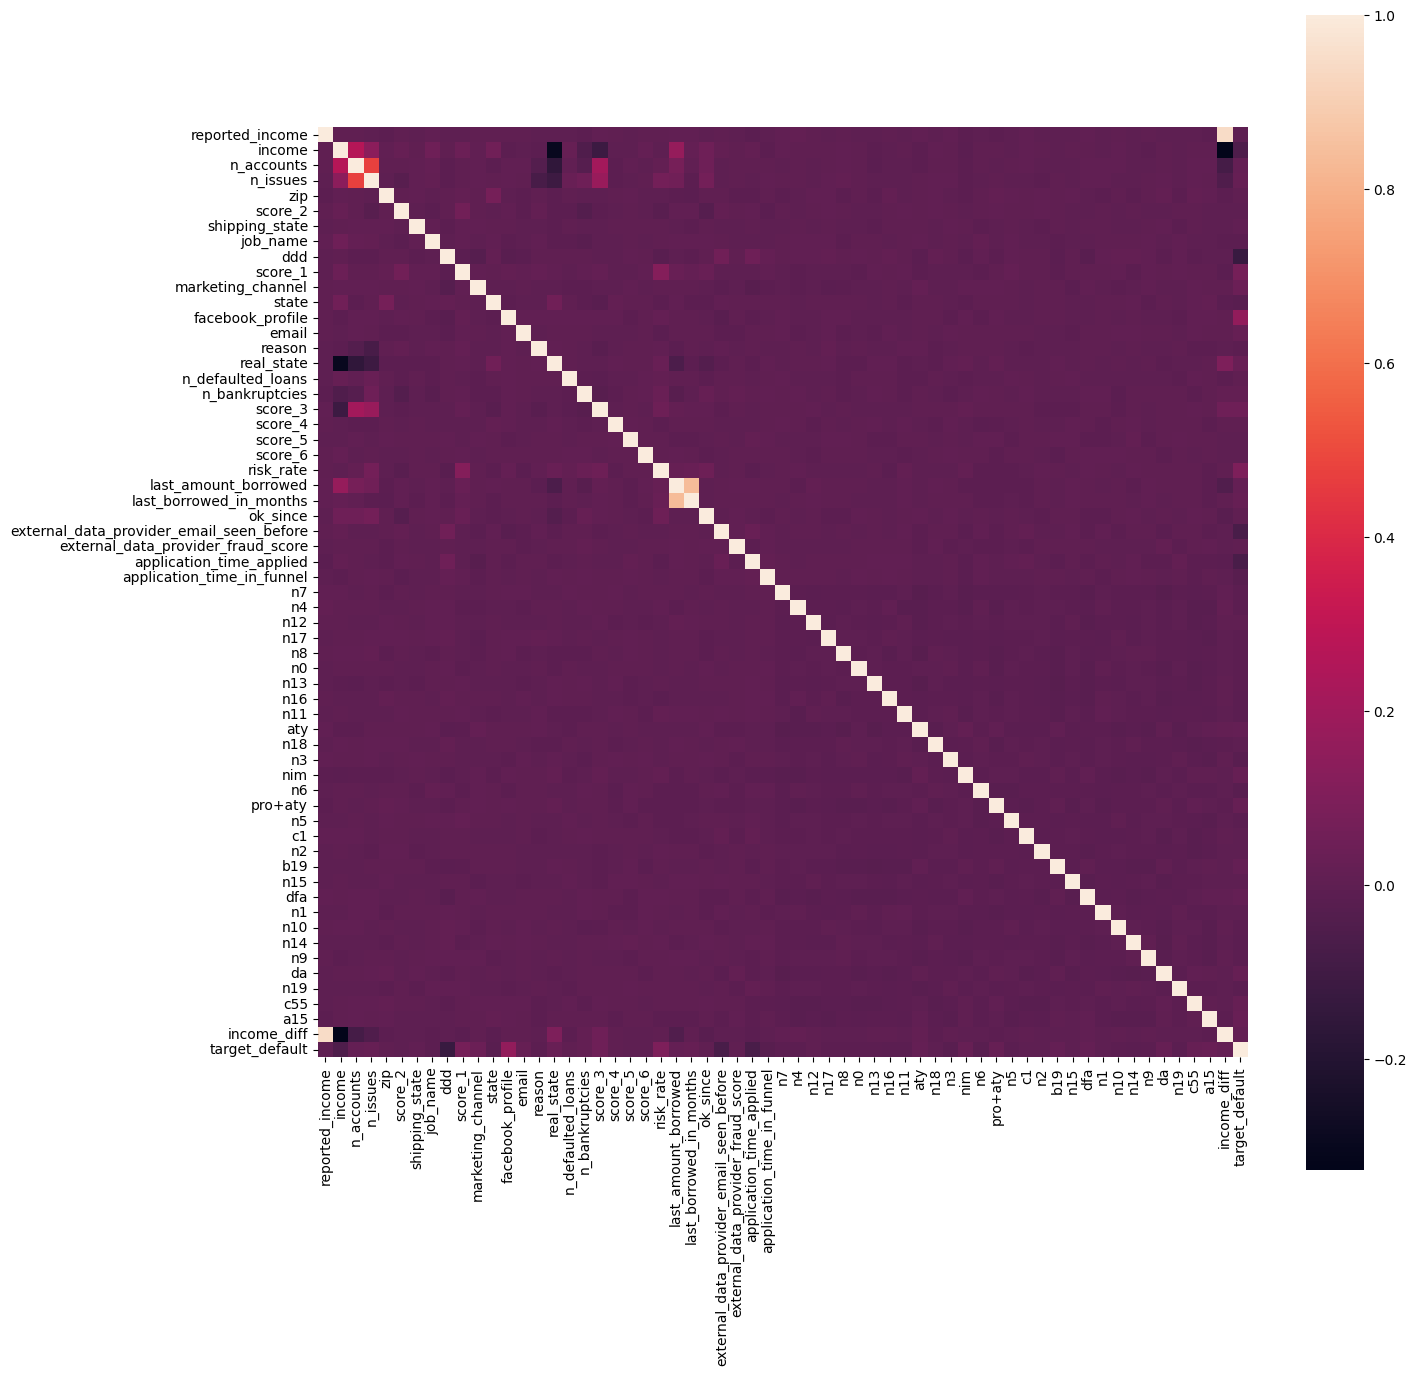

In [25]:
#@title Heatmap Correlation

plt.figure(figsize=(15, 15))

sns.heatmap(corr, vmax=1.0, square=True, fmt='.2f', annot_kws={'size': 8}, annot=False);
plt.show()

-----

# Comentários antes de treinar os modelos


Cada modelo considerado aqui tem características diferentes e precisa de certo cuidado no pré-processamento dos dados. Os modelos de árvore não precisam de pré-processamento, só os dados limpos já são suficientes.

Os seguintes modelos vão ser treinados considerando as etapas de pré-processamento adequadas:

1. **Decision Tree, Random Forest, Bagging,  Random Patches e Adaboost:**
  - Todos esses modelos utilizam como base uma árvore de decisão, então não preciso ser feito mais nenhum pré-processamento de dados. Obviamente, é possível utilizar o OneHotEnconder em algumas features, mas isso acaba por deixar a árvore de decisão muito complexa e gera resultados piores.

1. **Deep Neural Network:** 
  - StandardScaler()
1. **Logistic Regression, SVM:**
  1. Converter algumas features que definitivamente não são guassianas em guassianas usando o QuantileTransformer. 
  2. Usar o MinMax para restringir as variáveis categóricas em torno de (-1, 1), basicamente centralizando-as. Isso é muito importante para o algoritmo de SVM.
  3. Converter algumas features para OneHot. Como algumas features tem muitas categorias, precisamos utilizar as matrizes esparsas do scikit-learn.
1. **Voting Classifiers:**
    - Como vamos fazer todos os pré-processamentos utilizando uma Pipeline para cada modelo, não vai ser necessário nenhum pré-processamento novo, é só usar os antigos.

Nas próximas sessões vamos treinar os mesmos modelos utilizando o dataset com e o **Random Under Sample**, que faz o balanceamento de classes, e sem nada, onde temos as classes desbalanceadas.

> Com o dataset completo, i.e., com as classes desbalanceadas, não vamos usar o modelo de SVM pois ele consome muita memória (16GB de RAM não foram suficientes pro treino).

Além de fazer a Pipeline do pré-processamento para cada modelo, também vamos usar o GridSearchCV para procurar os melhores parâmetros para cada modelo. Depois disso, vamos usar o **Voting Classifiers** para agrupar esses modelos e gerar um resultado melhor.

---------

# Treino usando o dataset com o RandomUnderSample

- O **RandomUnderSample** "corrige" o desbalanço de classes.

In [26]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import TruncatedSVD, PCA

In [27]:
# Guarda os scores dos treinos
score_under = []

In [28]:
def return_scores(classifier, X, y, name, scoring=["recall", "accuracy"]):

  '''
     classifier: classificador
     X:          dataset
     y:          variável alvo
     name:       nome do classificador
     scoring:    escores que serão calculados

     return:     array com os escores
  '''

  scores = cross_validate(classifier, X, y,
                        scoring = scoring, cv=5, n_jobs=-1)

  results = []

  for key in scores.keys():

    if key.split('_')[1] in scoring:

      mean = np.mean(scores[key])
      results.append(mean)

      std = np.std(scores[key])
      results.append(std)

      print('<{0}>: {1} {0}_err: {2}'.format(key.split('_')[1], 
                                             np.round(mean, 3),
                                             np.round(std, 3)))

  results.append(name)

  return results

## Under Sample

In [29]:
from imblearn.under_sampling import RandomUnderSampler

### Aplica o Random Under Sample

In [30]:
under = RandomUnderSampler(random_state=42)
X_under, y_under = under.fit_resample(df_clean, y_hat)

X_under = X_under.astype(np.float32)
y_under = y_under.astype(np.float32)

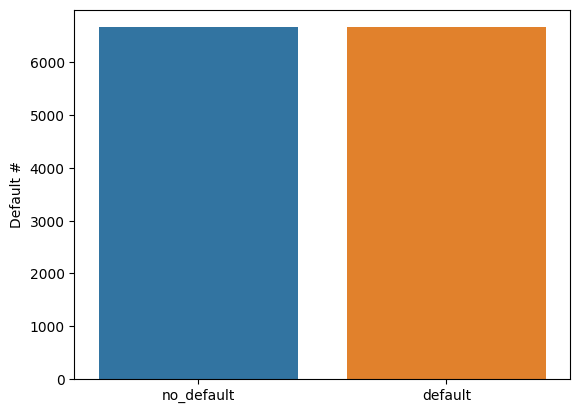

In [31]:
#@title Classes balanceadas
sns.barplot(data=pd.DataFrame(y_under.map({0:'no_default', 1:'default'}).value_counts()).reset_index(),
            y='target_default', x='index');

plt.ylabel('Default #')
plt.xlabel('')
plt.show()

## Plot das variáveis separandas pela classe

- Note que algumas classes como `facebook_profile`, `ddd`, `score_1`, `external_data_provider_email_seen_before` e `application_time_applied` têm mais informação sobre os clientes que não cumprem com suas obrigações (`default`). Por exemplo, o `application_time_applied` (horário que o cliente começou a se cadastrar) indica que clientes que se cadastram de $0$ às $6$ da madrugada são mais propensos a não honrar com os compromissos. O mesmo é válido para clientes que não adicionam o facebook ao cadastro, veja o plot da feature `facebook_profile`. 

reported_income


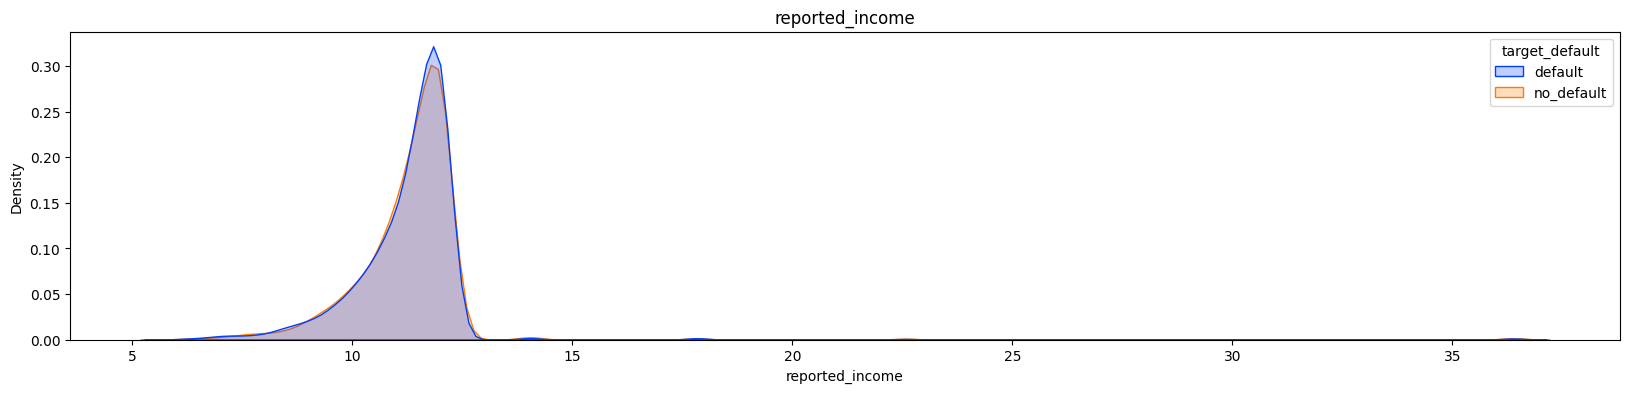

income


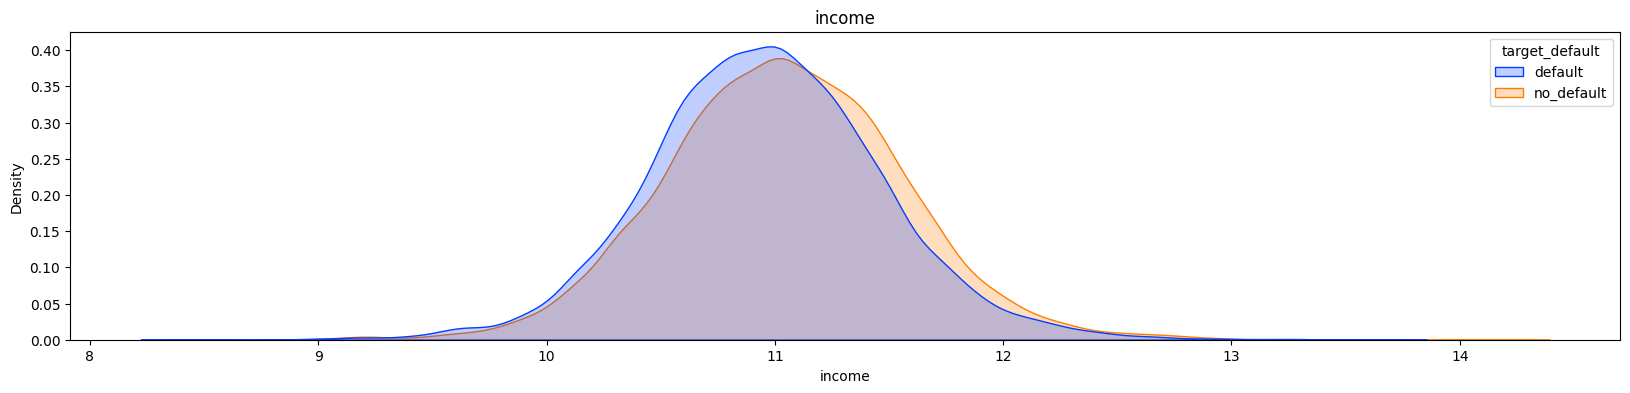

n_accounts


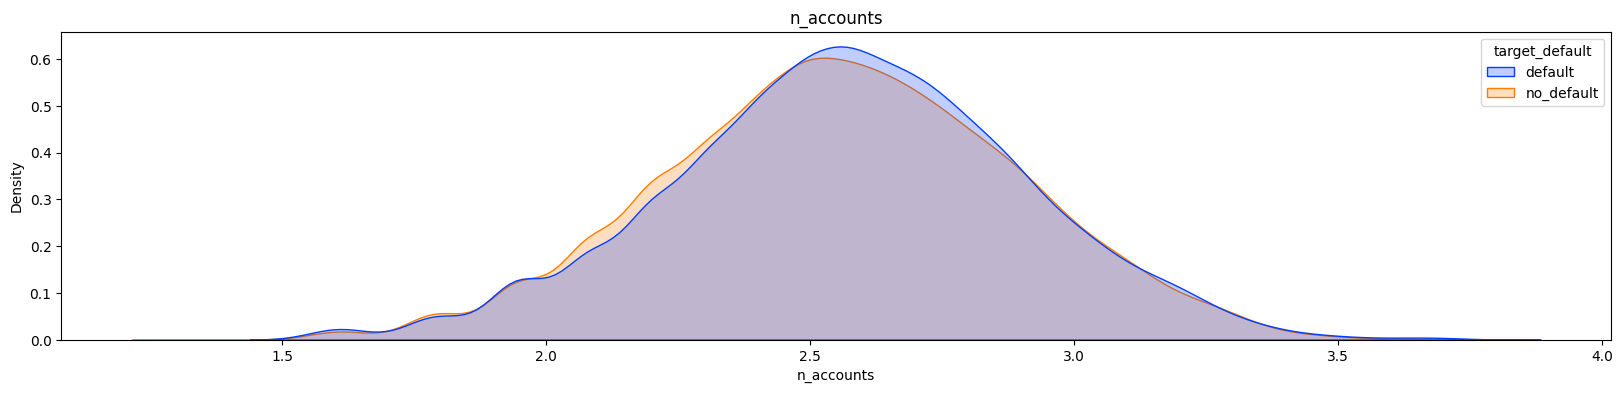

n_issues


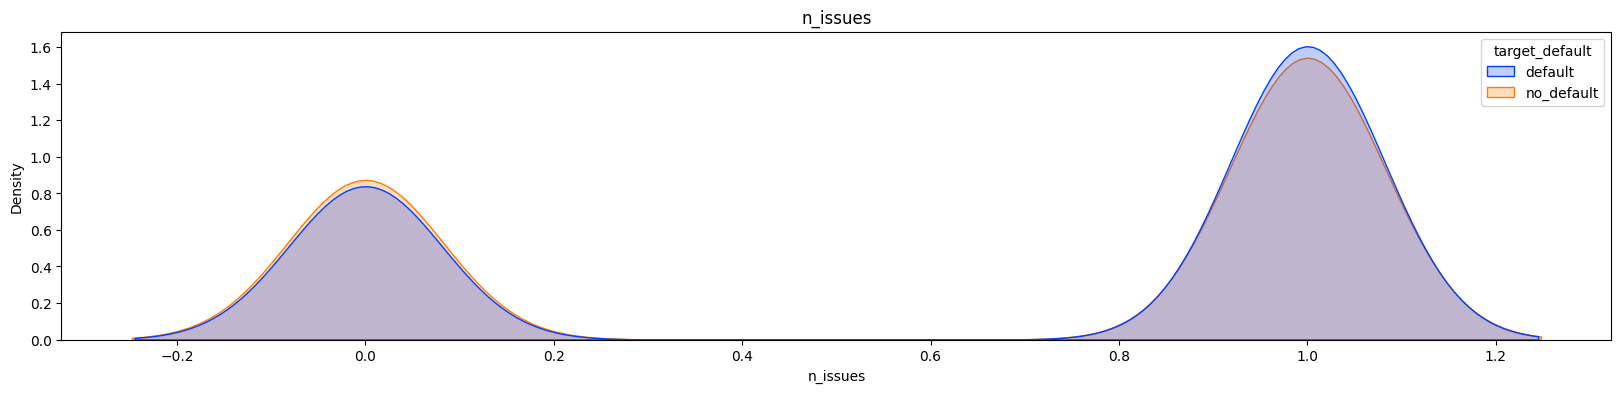

zip


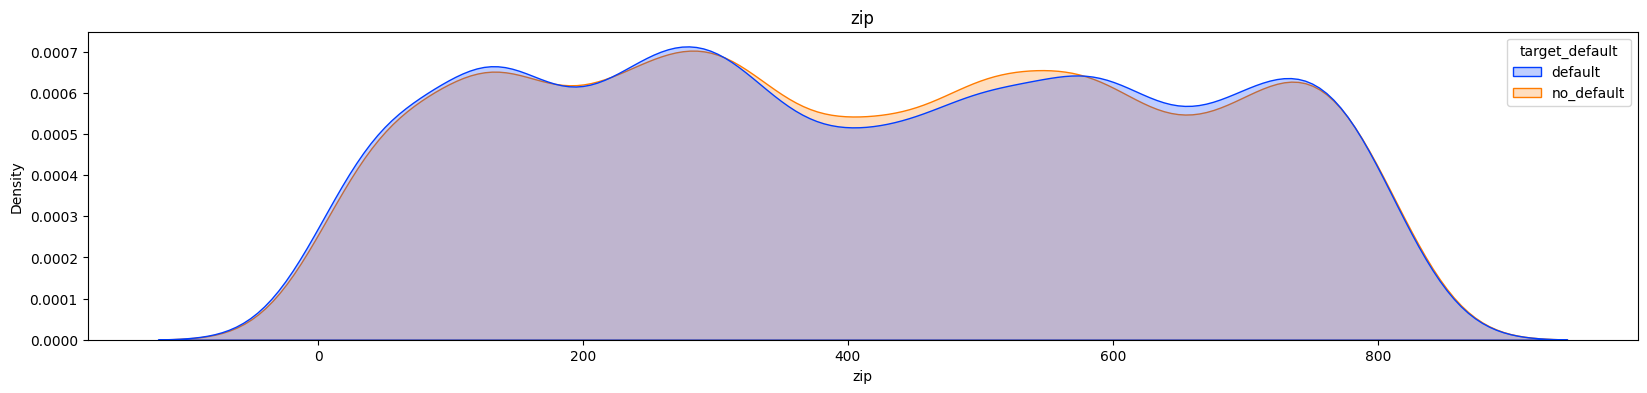

score_2


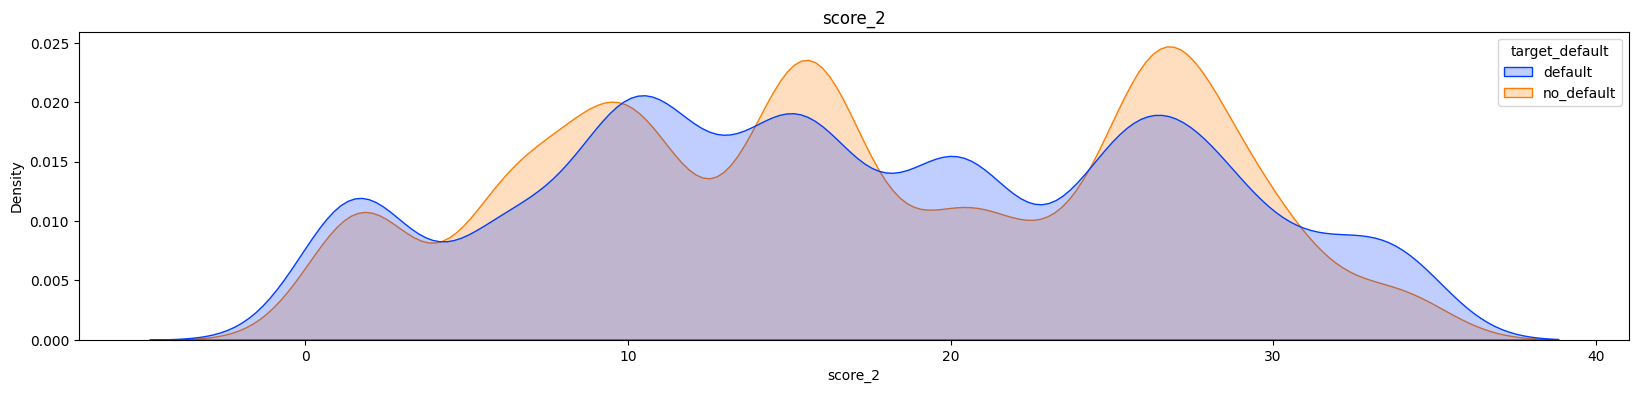

shipping_state


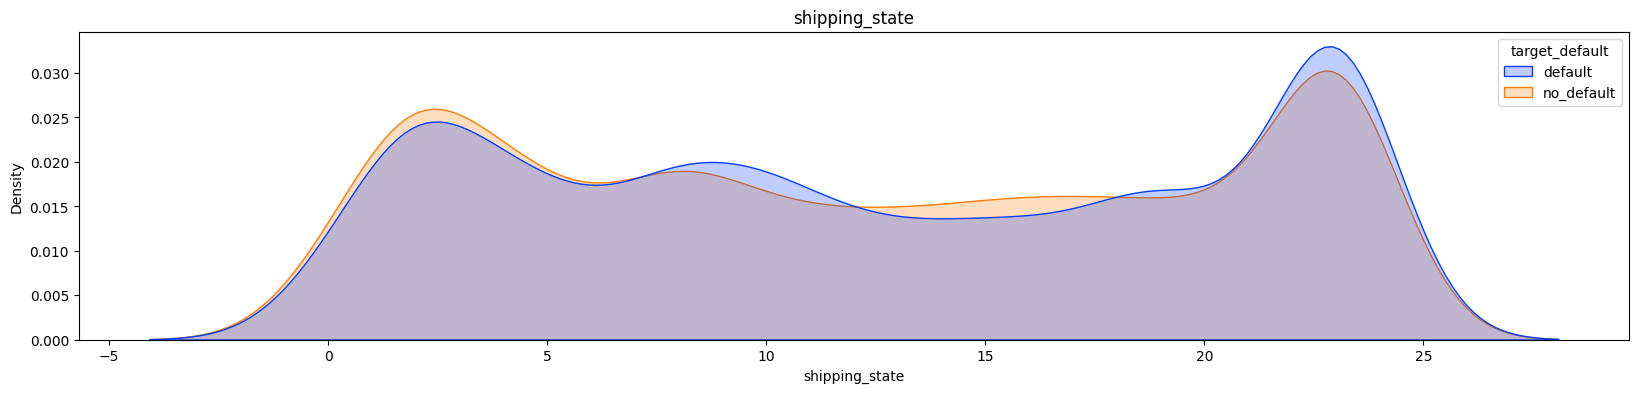

job_name


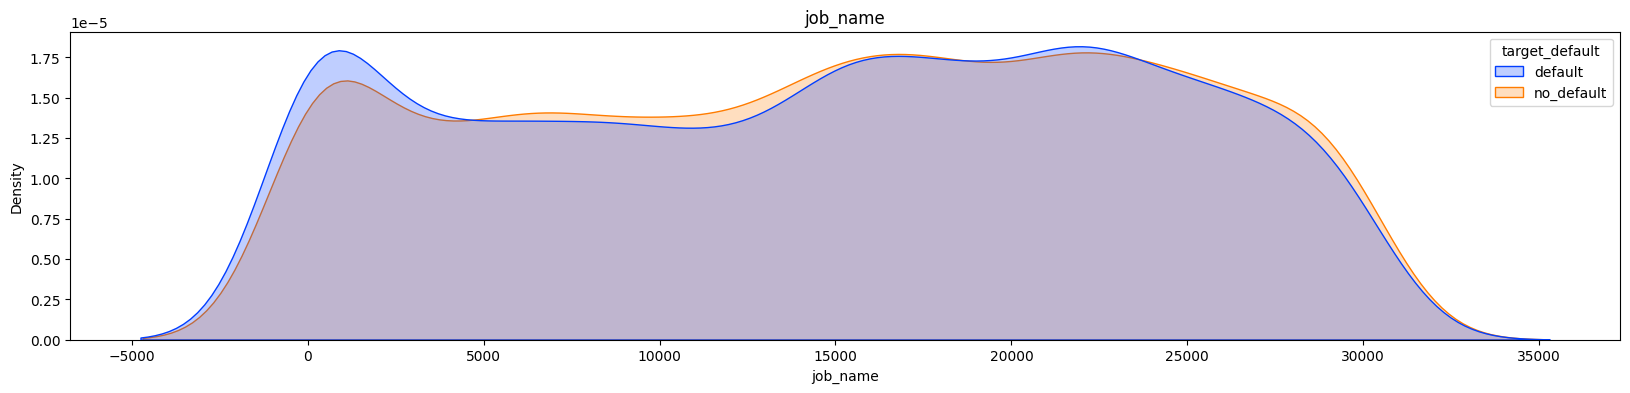

ddd


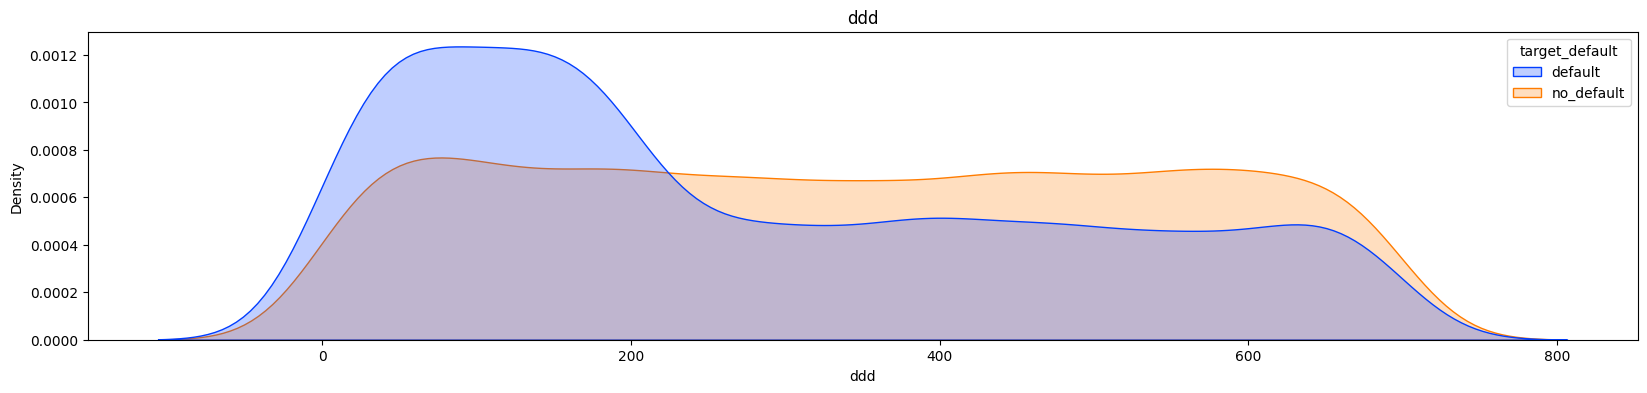

score_1


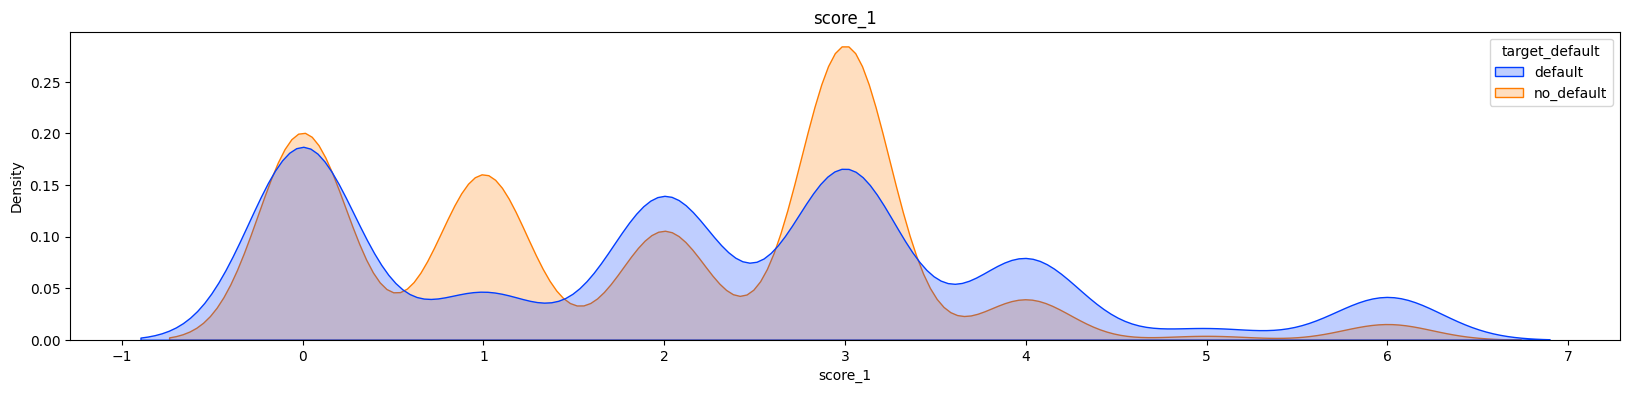

marketing_channel


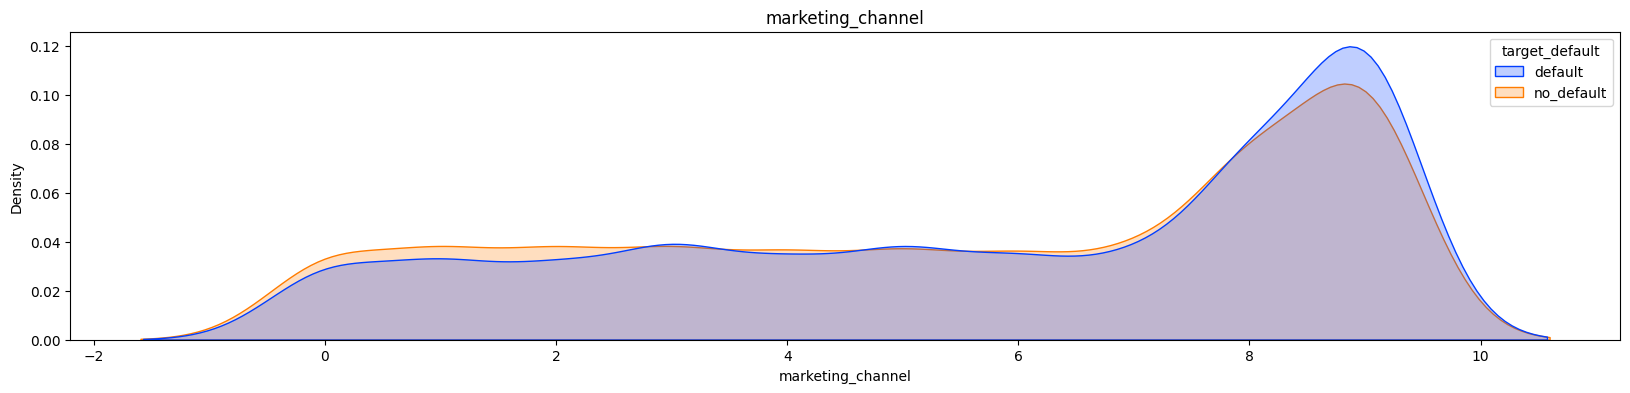

state


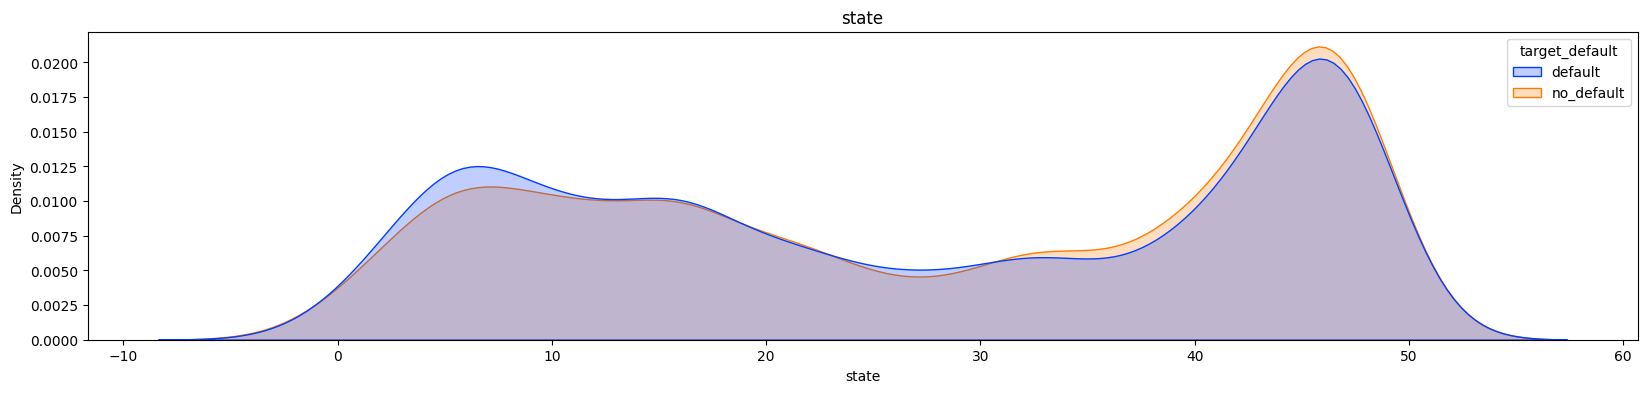

facebook_profile


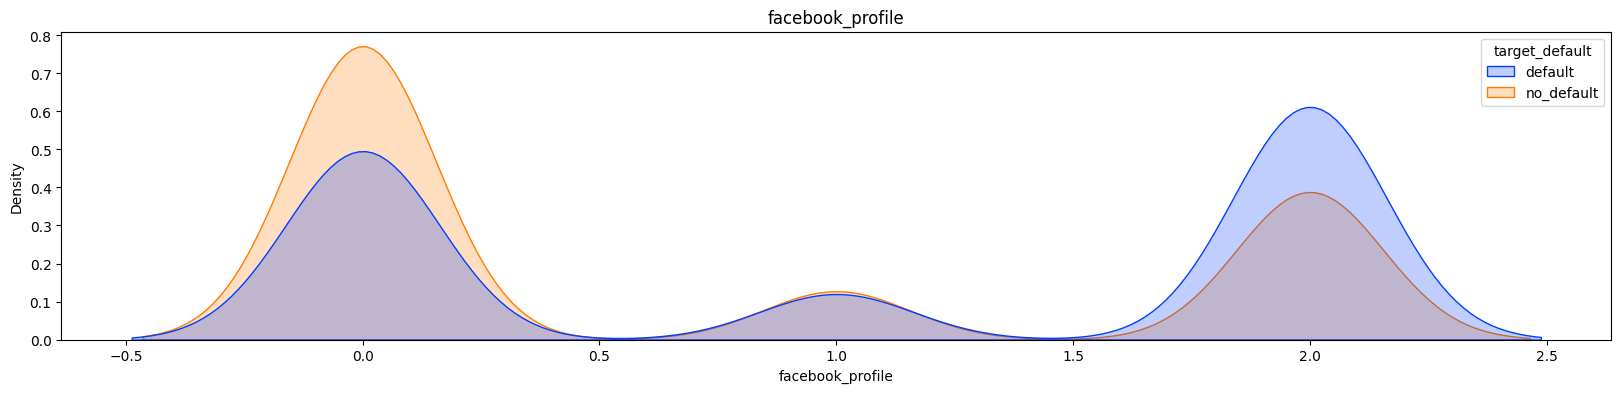

email


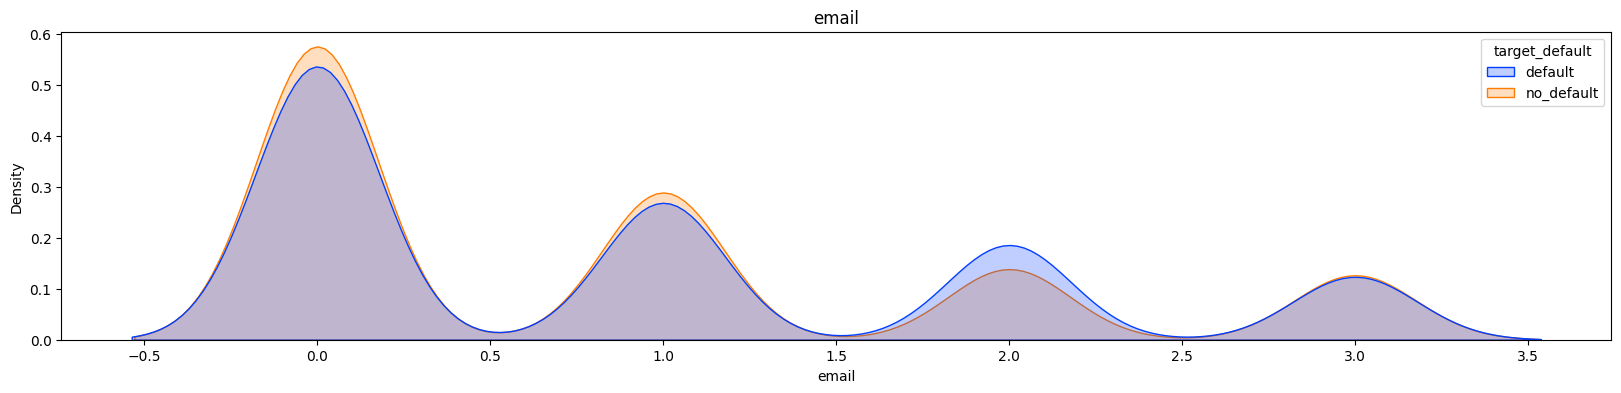

reason


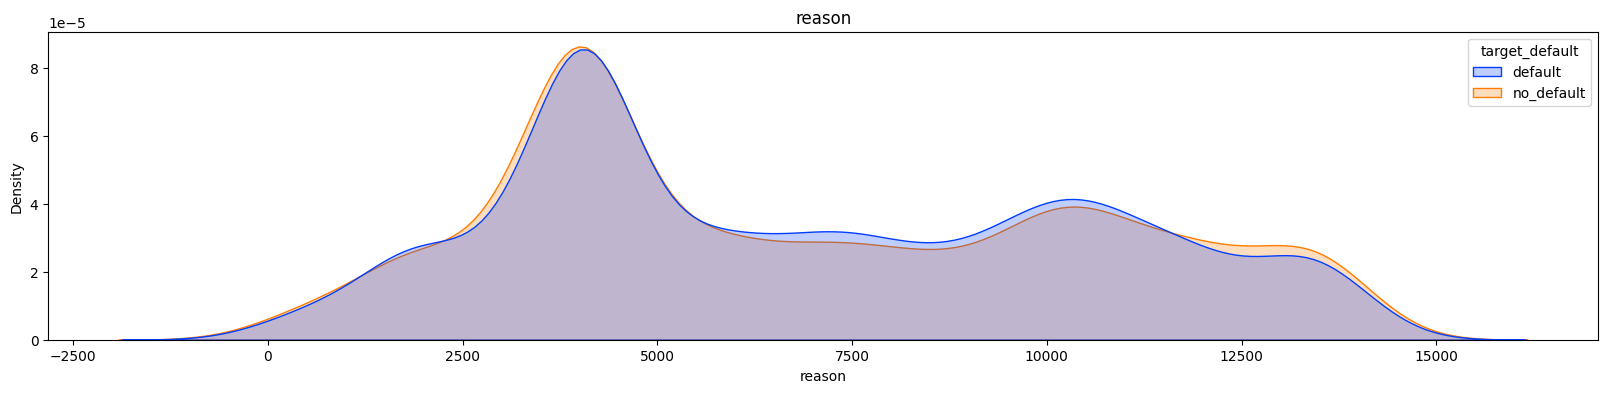

real_state


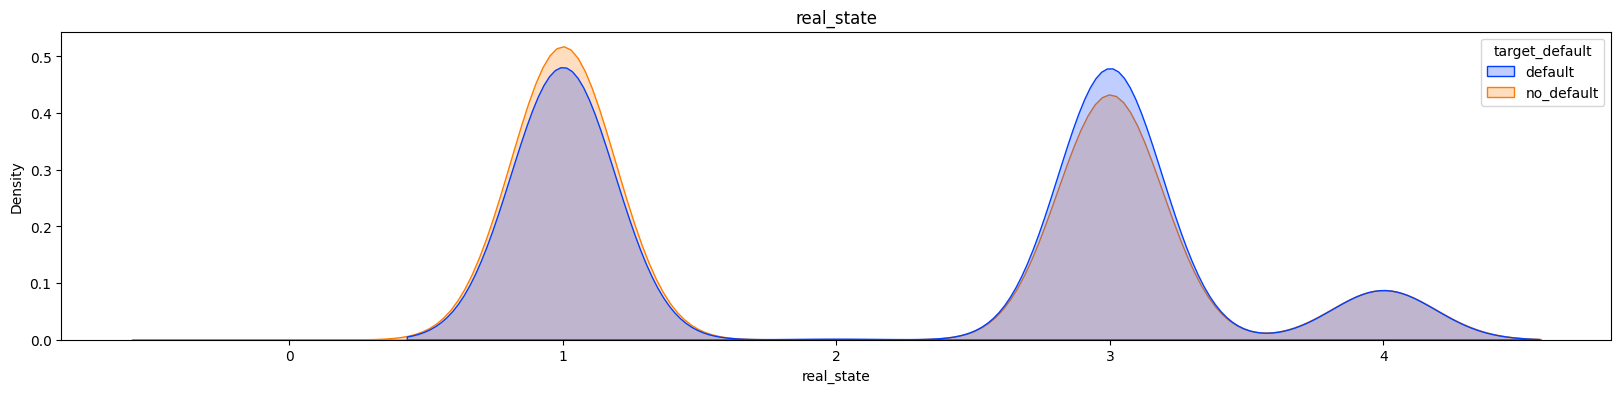

n_defaulted_loans


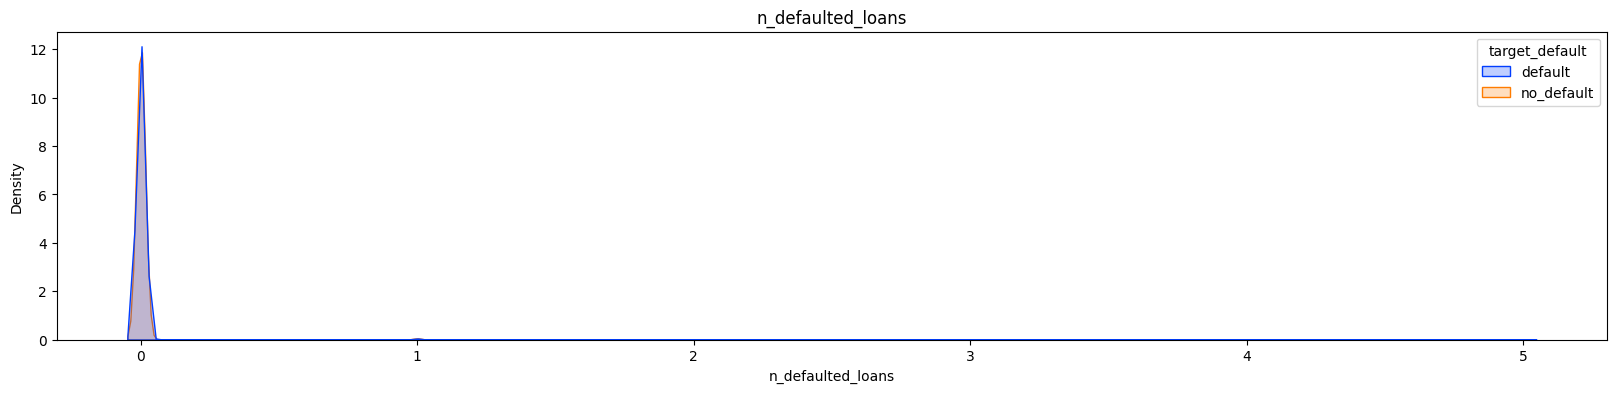

n_bankruptcies


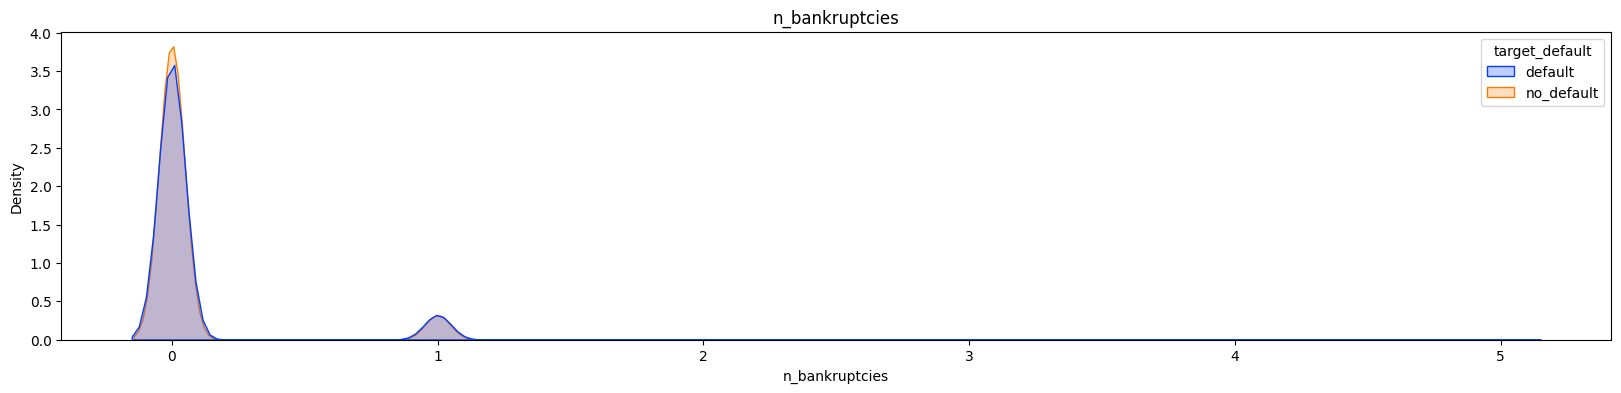

score_3


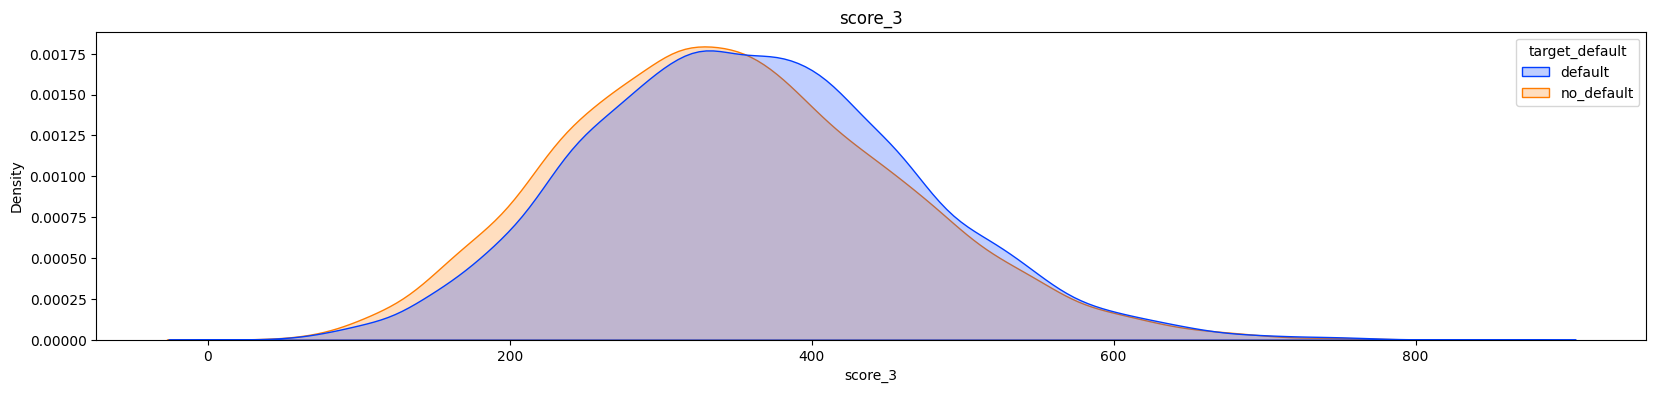

score_4


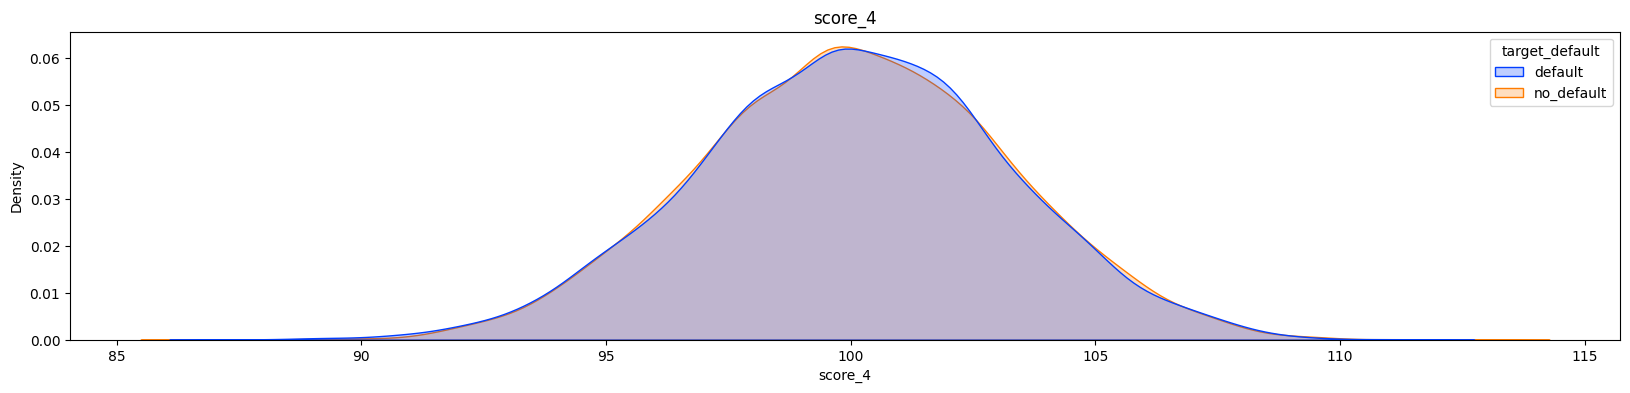

score_5


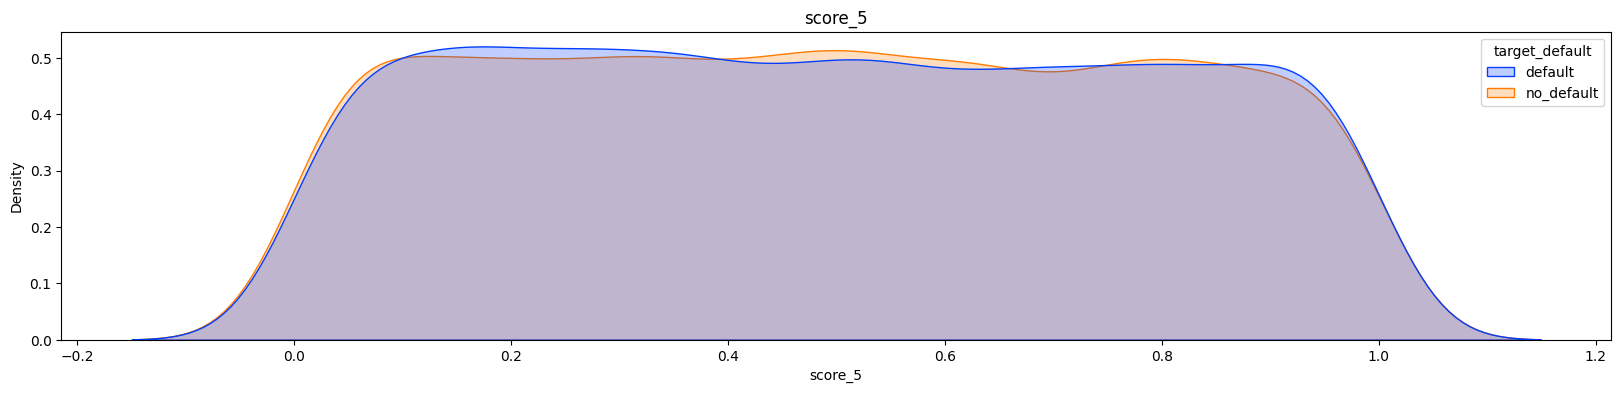

score_6


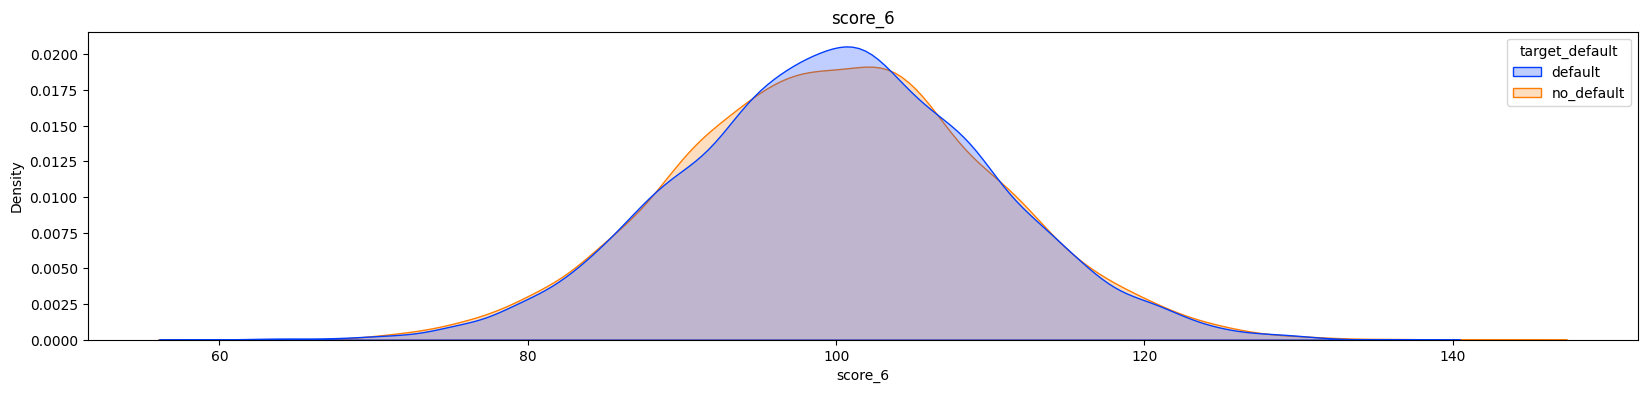

risk_rate


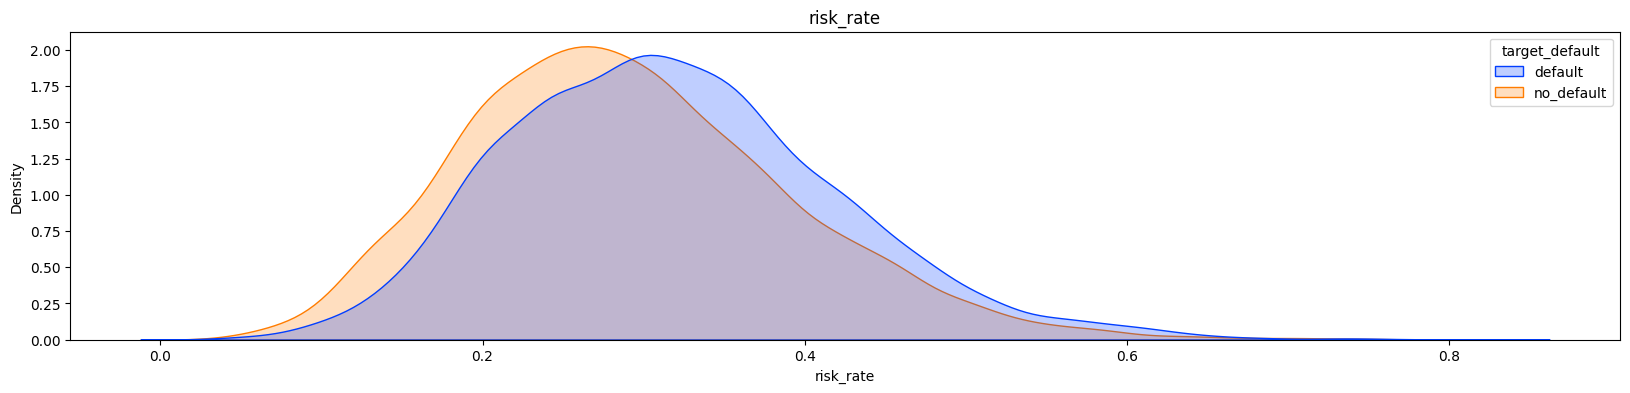

last_amount_borrowed


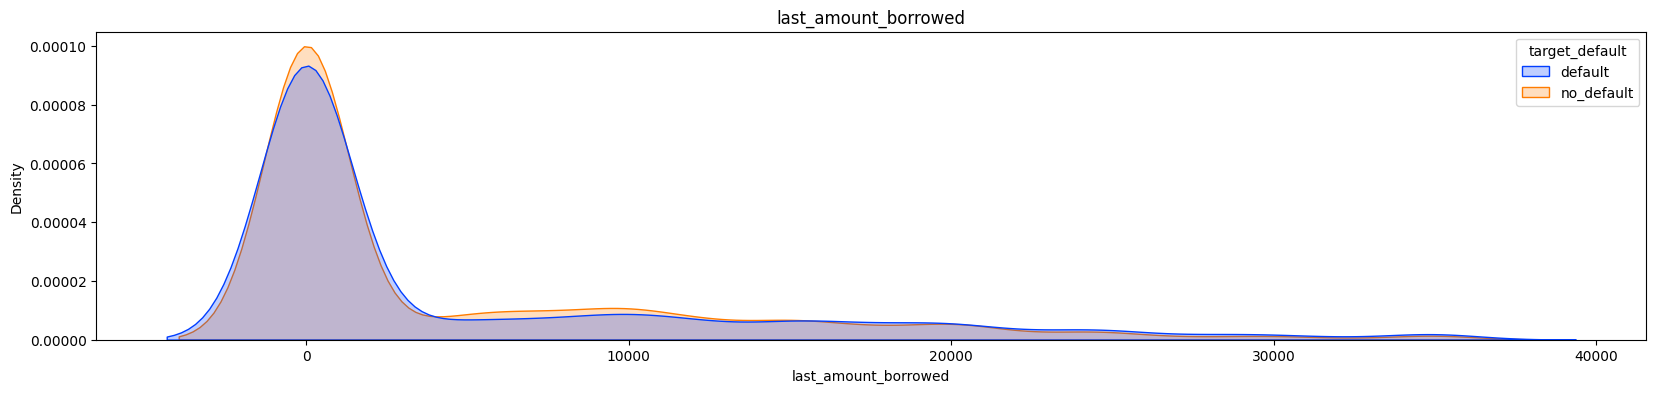

last_borrowed_in_months


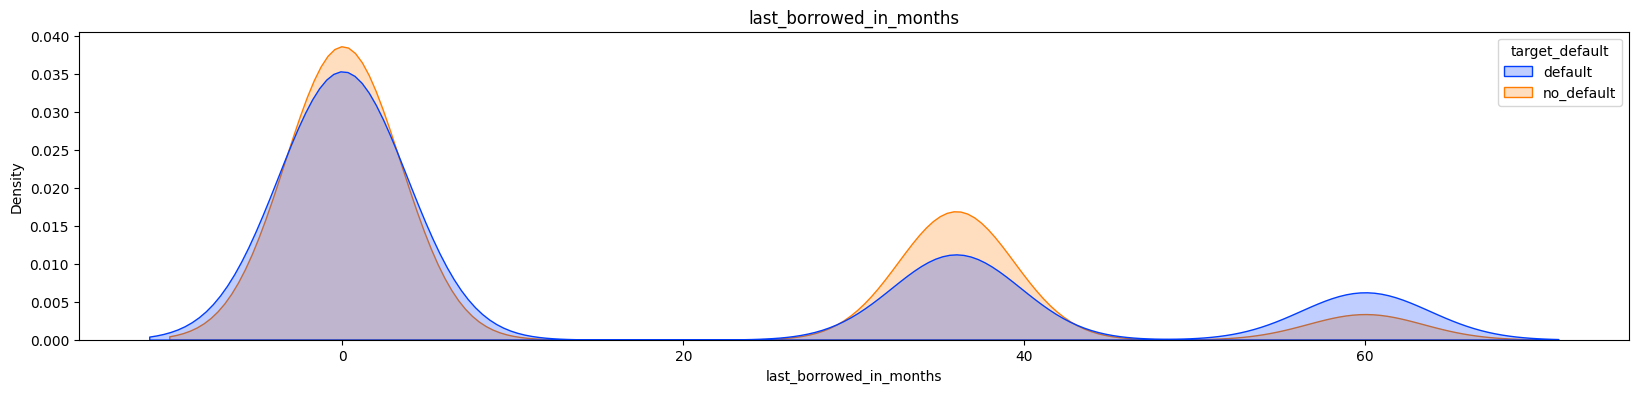

ok_since


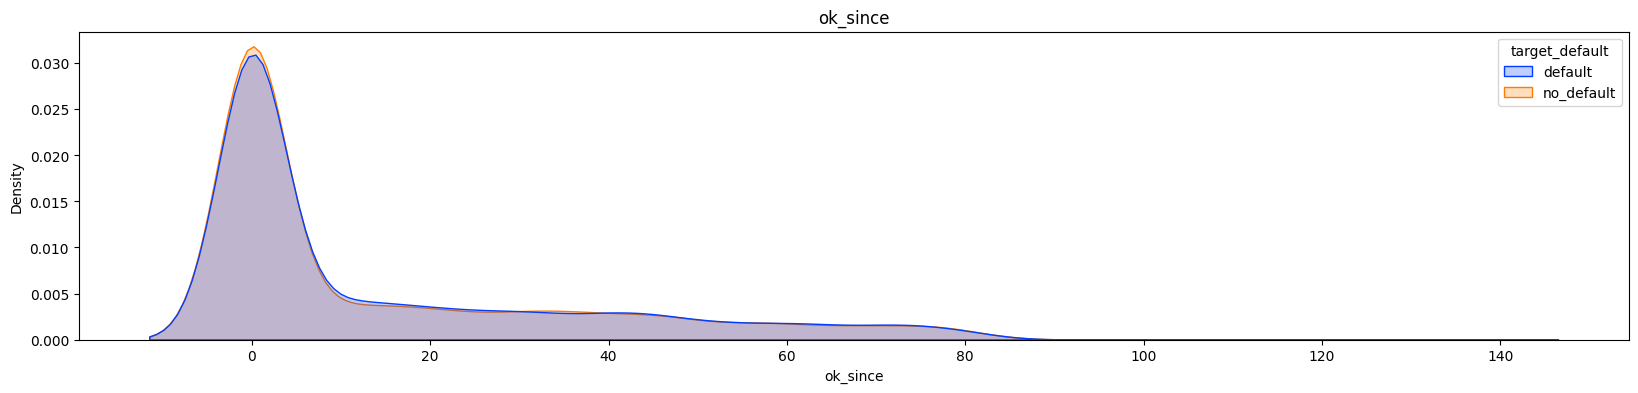

external_data_provider_email_seen_before


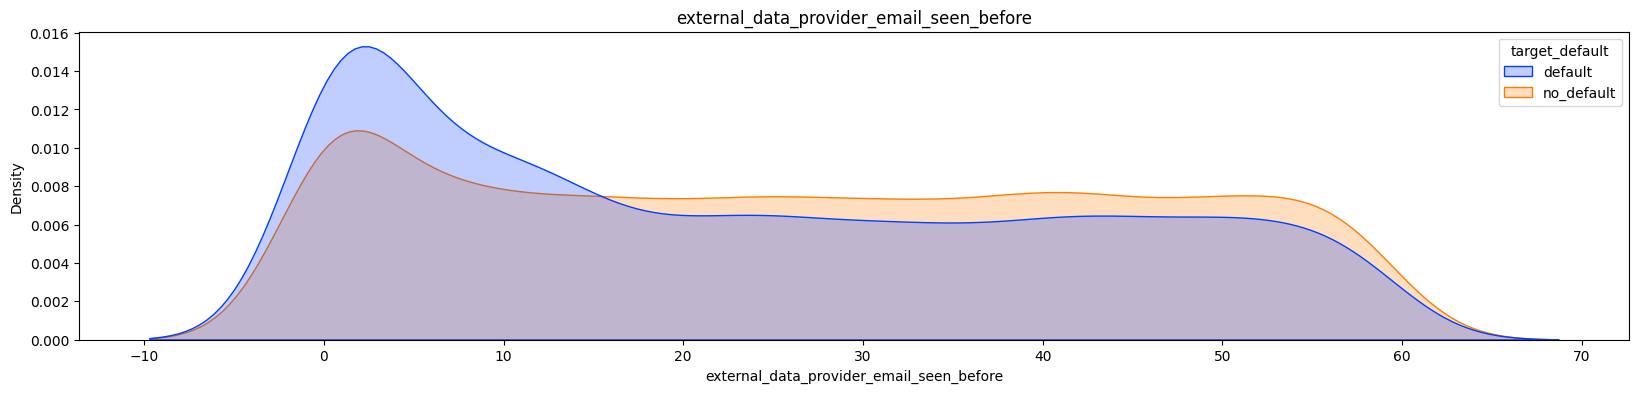

external_data_provider_fraud_score


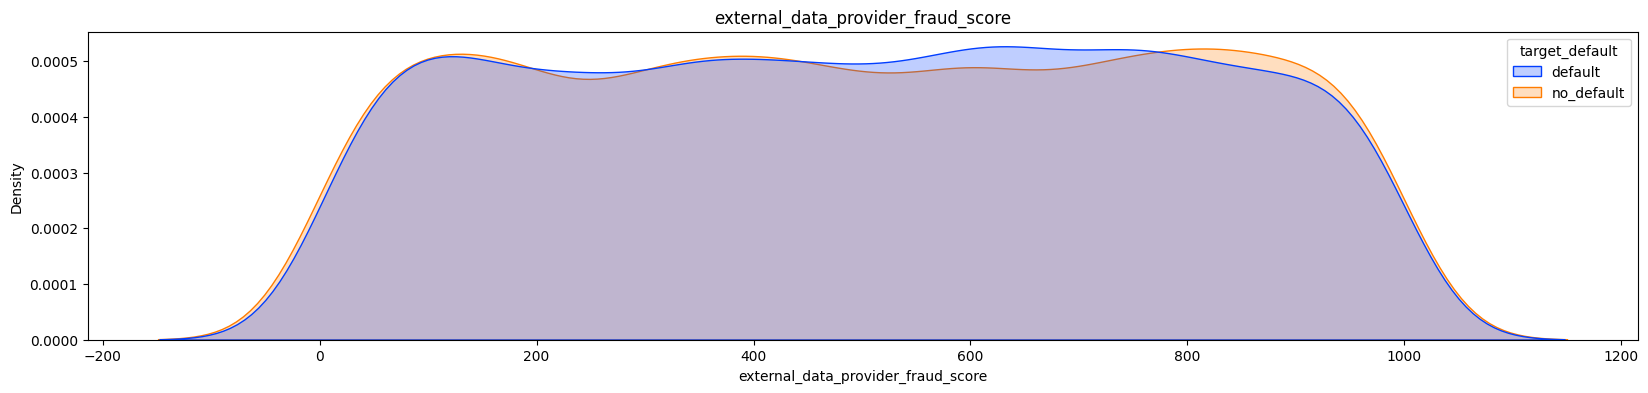

application_time_applied


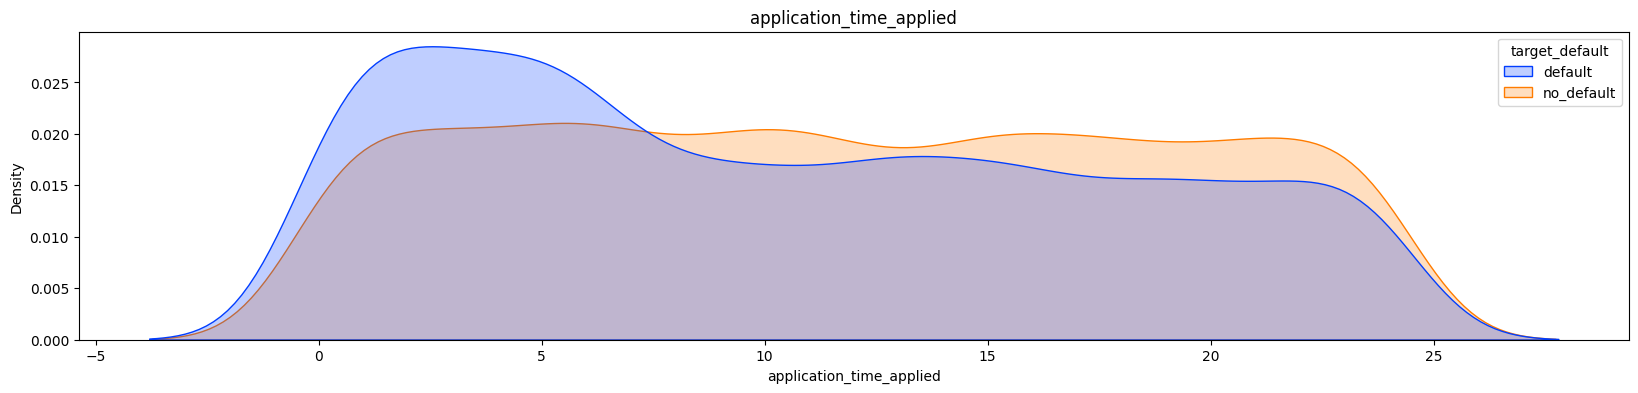

application_time_in_funnel


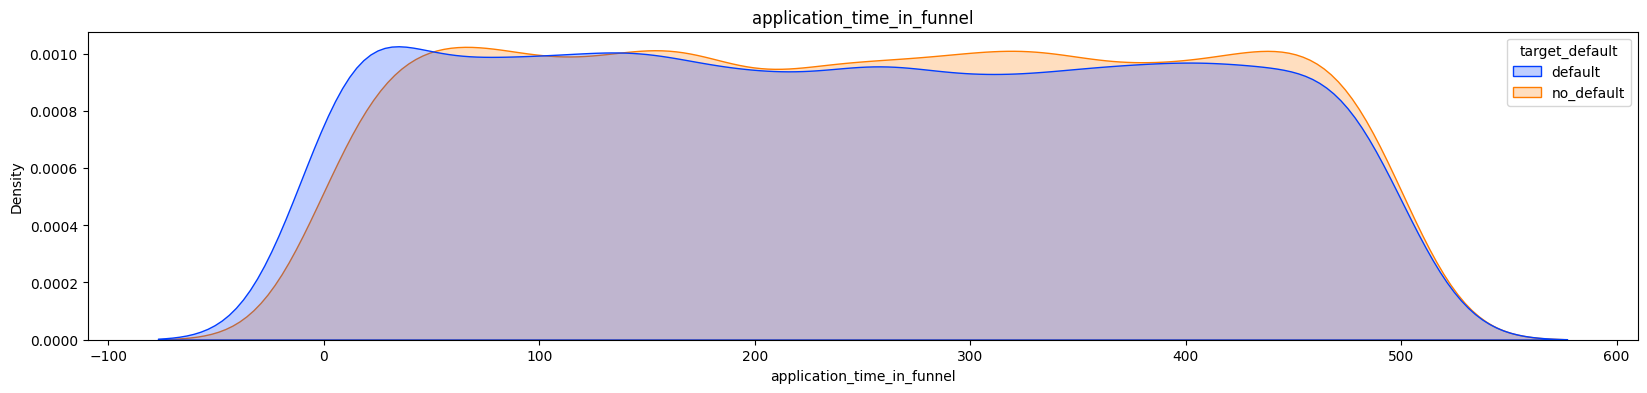

n7


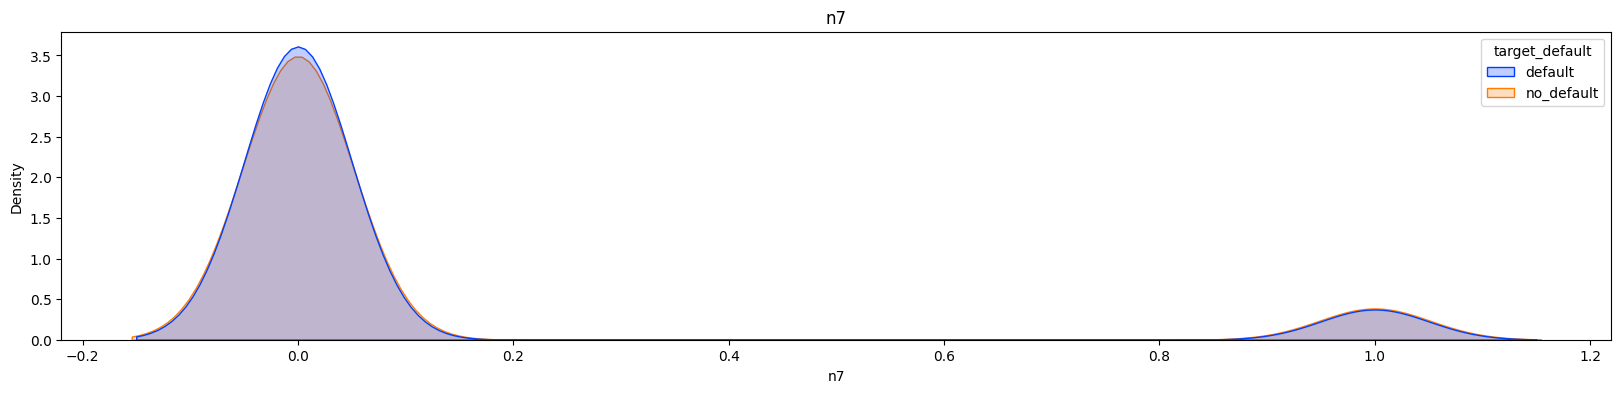

n4


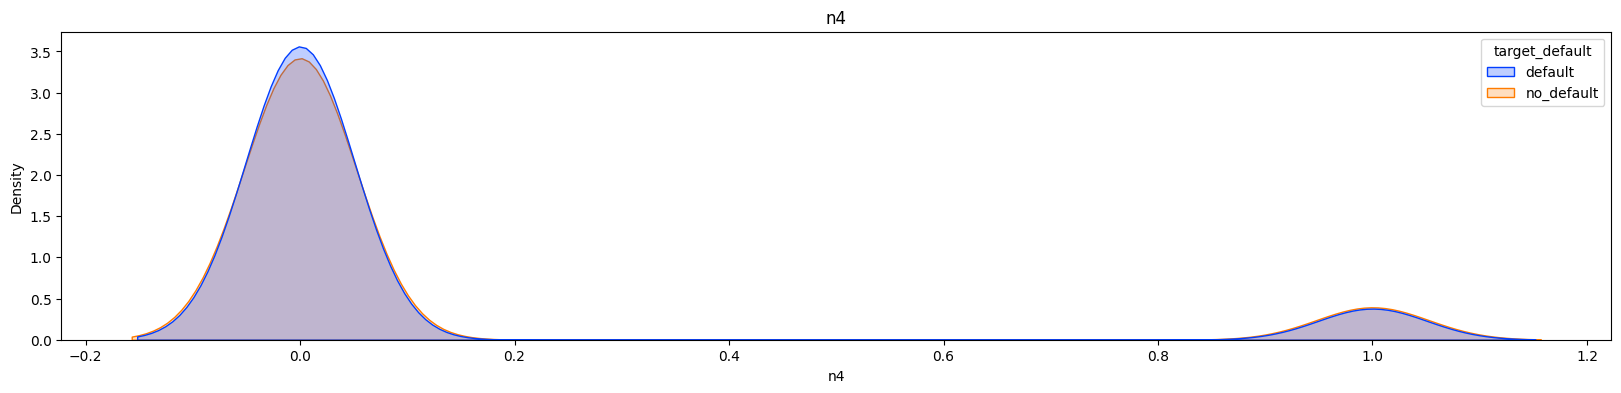

n12


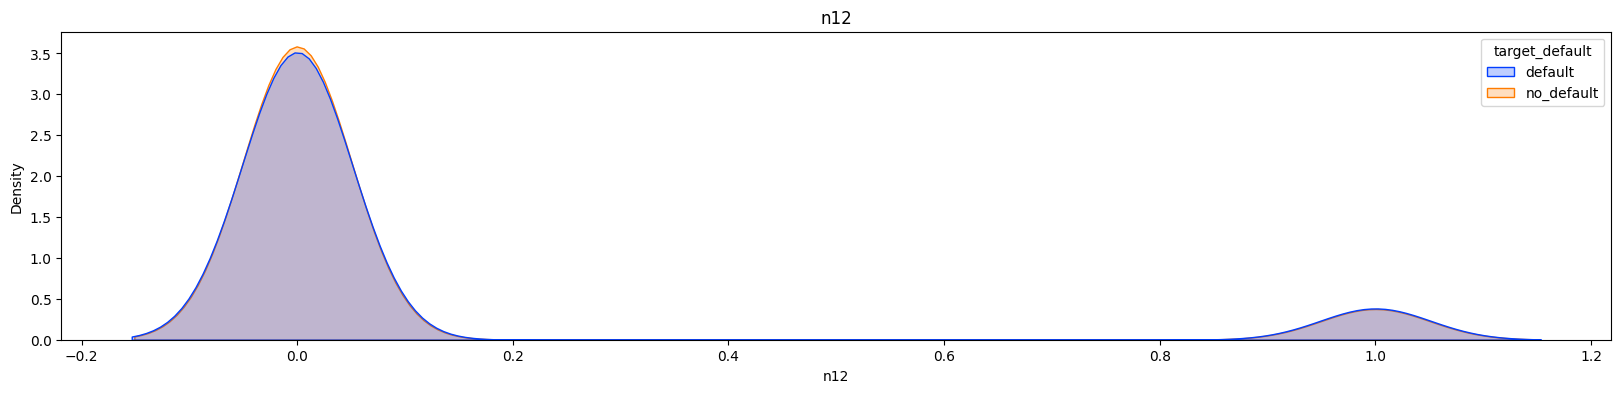

n17


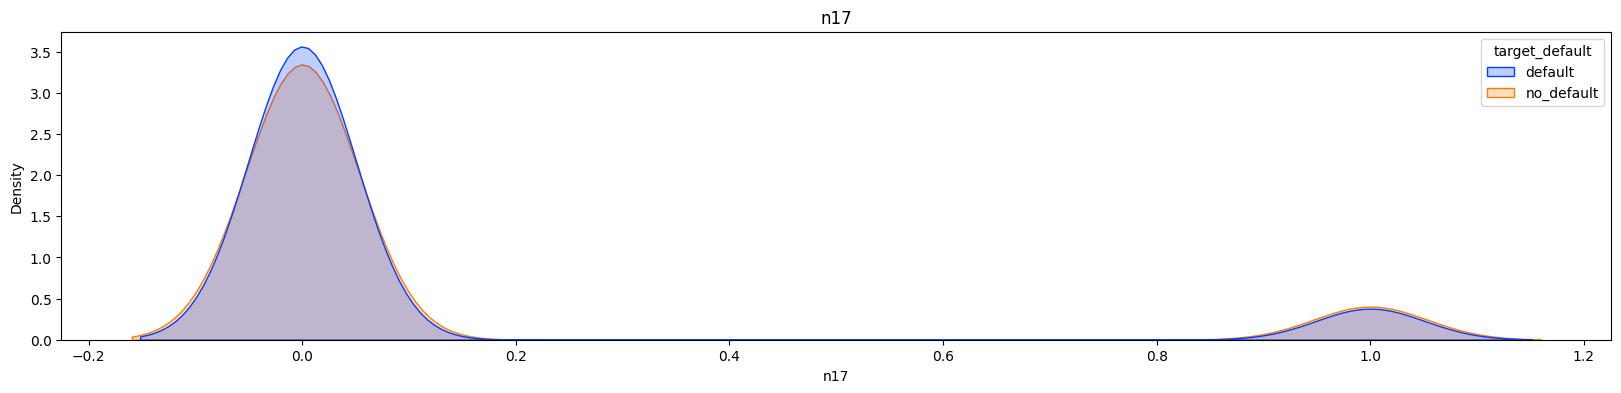

n8


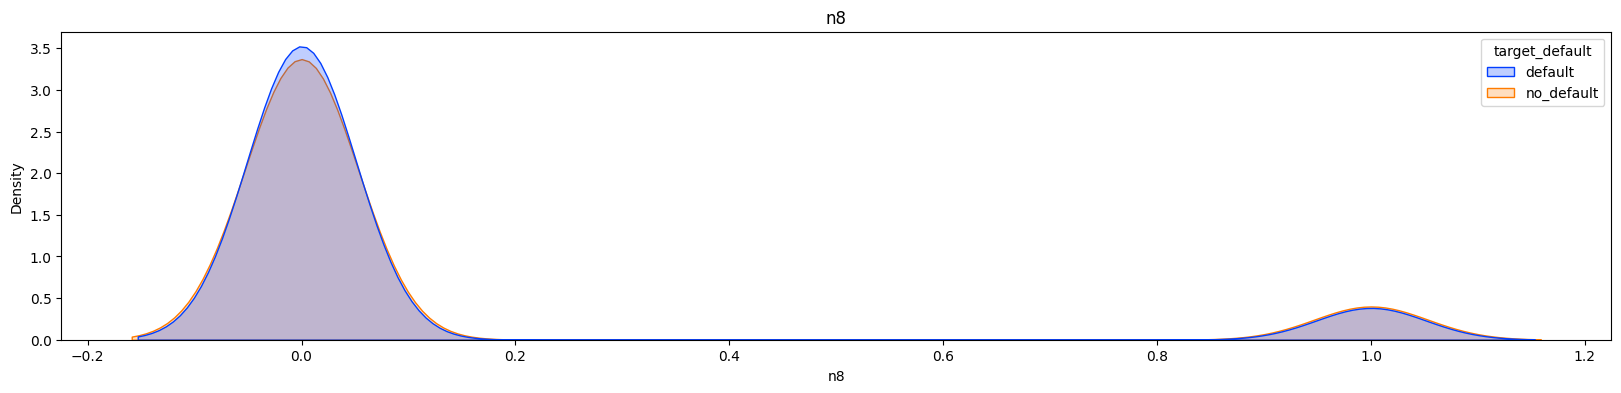

n0


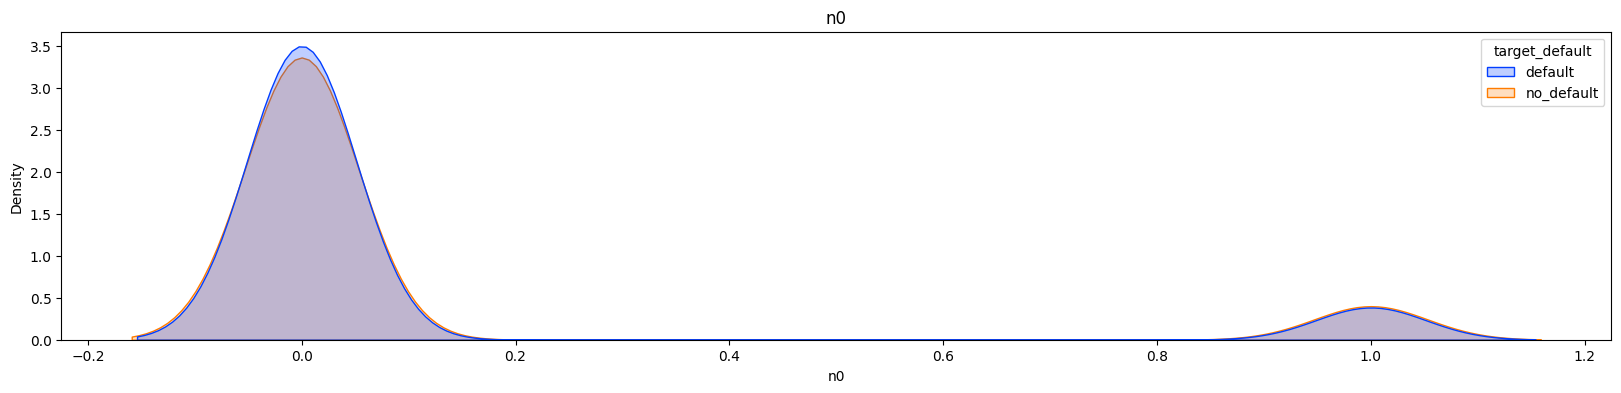

n13


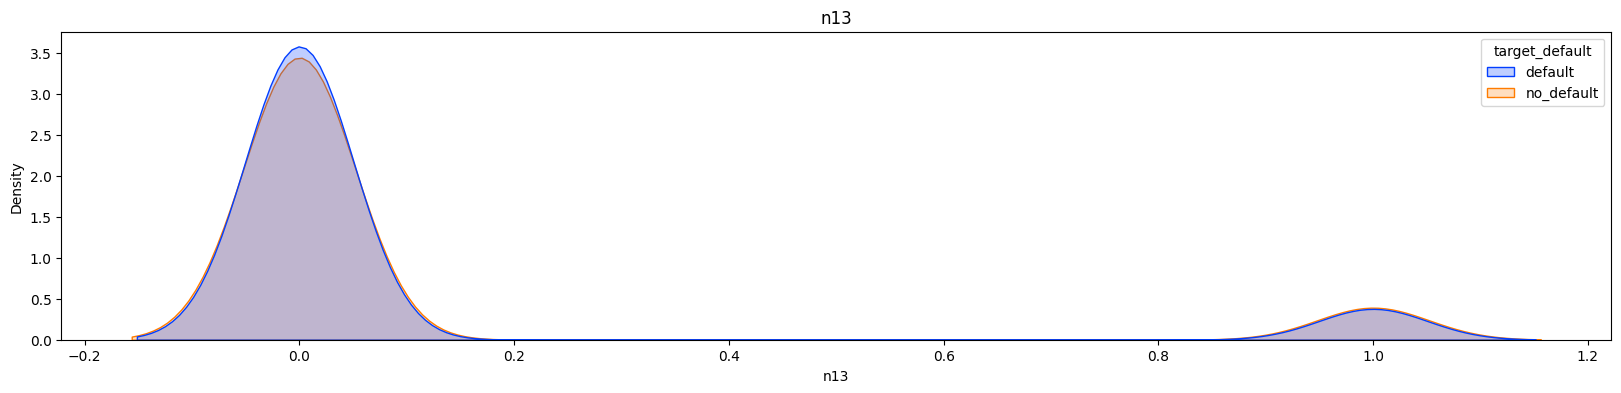

n16


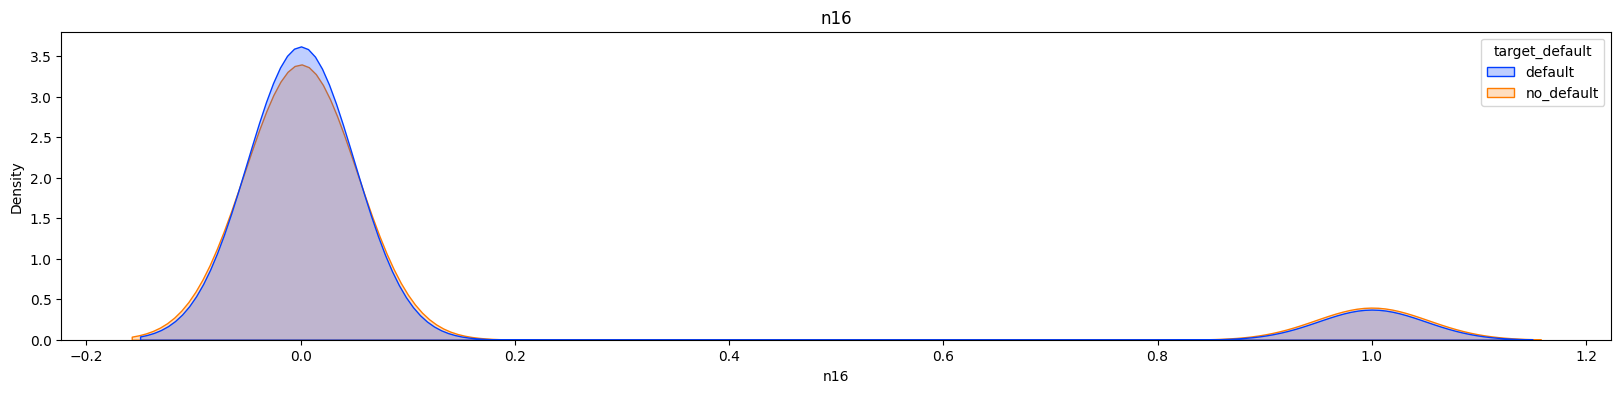

n11


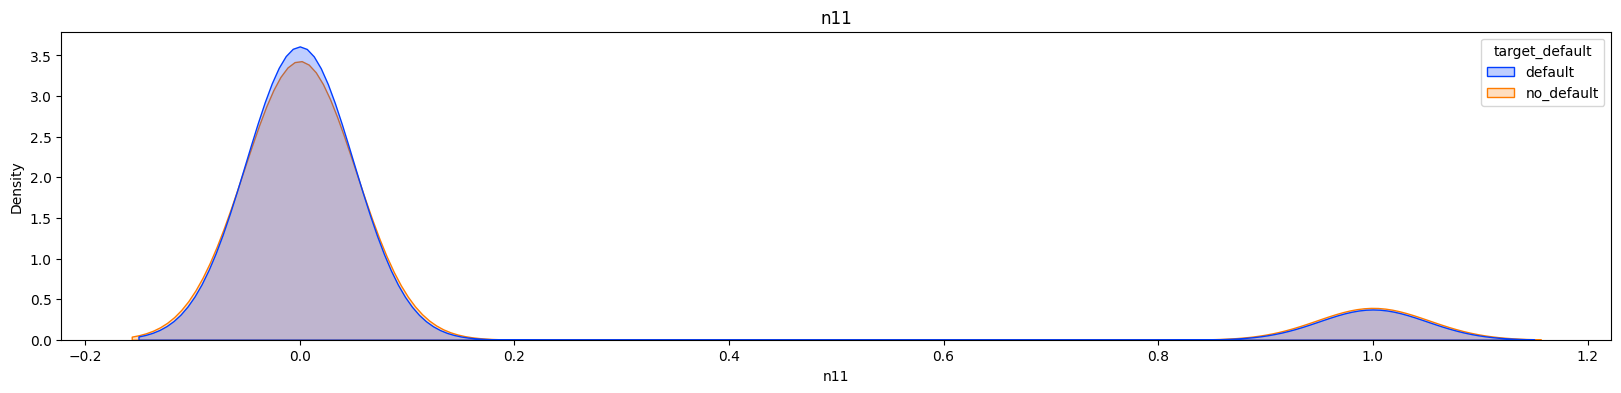

aty


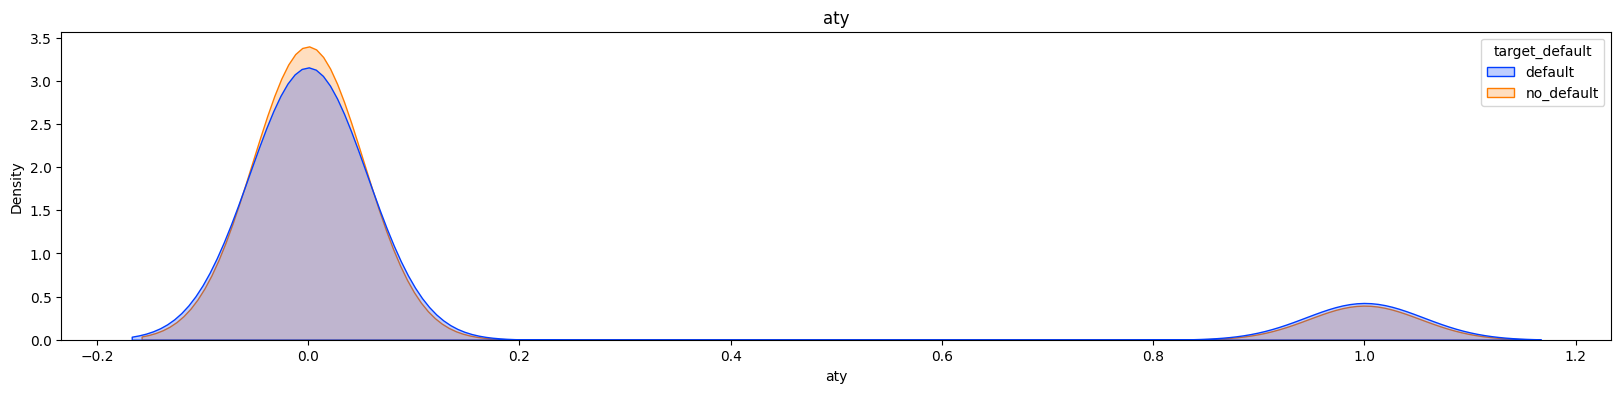

n18


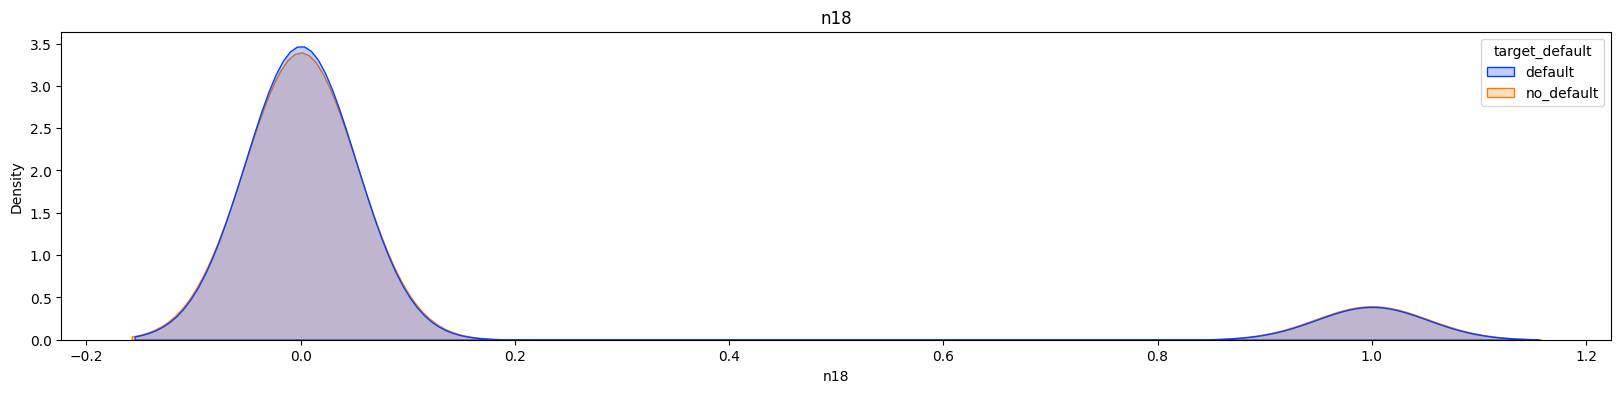

n3


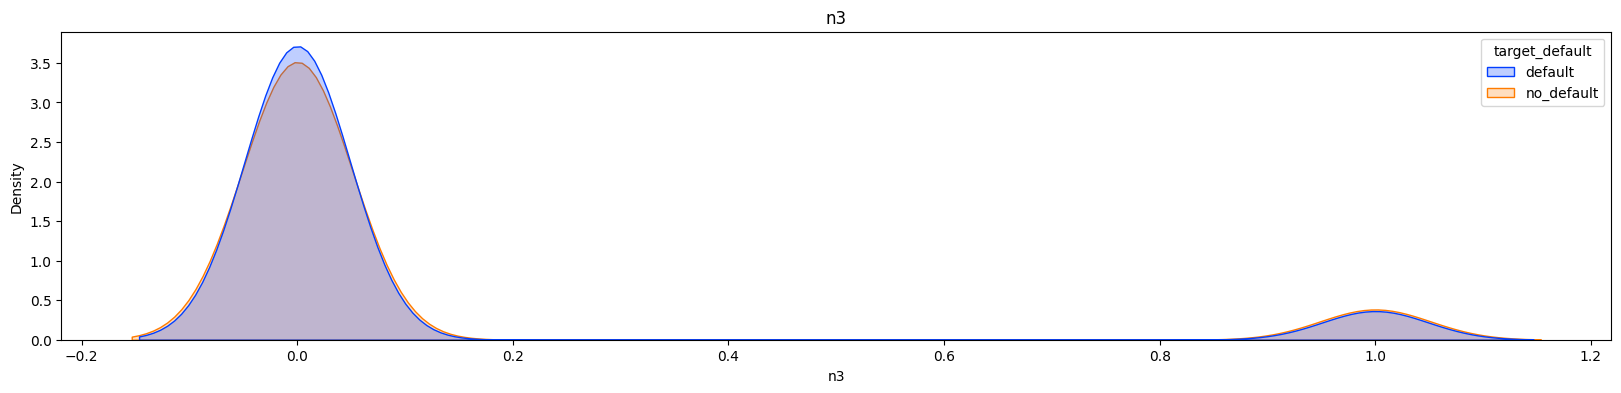

nim


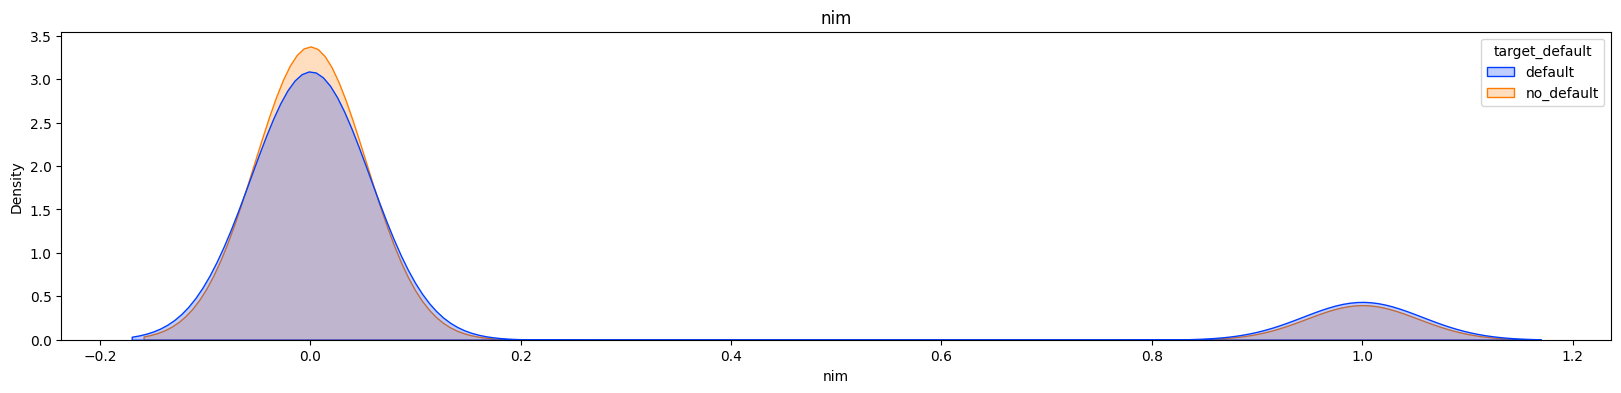

n6


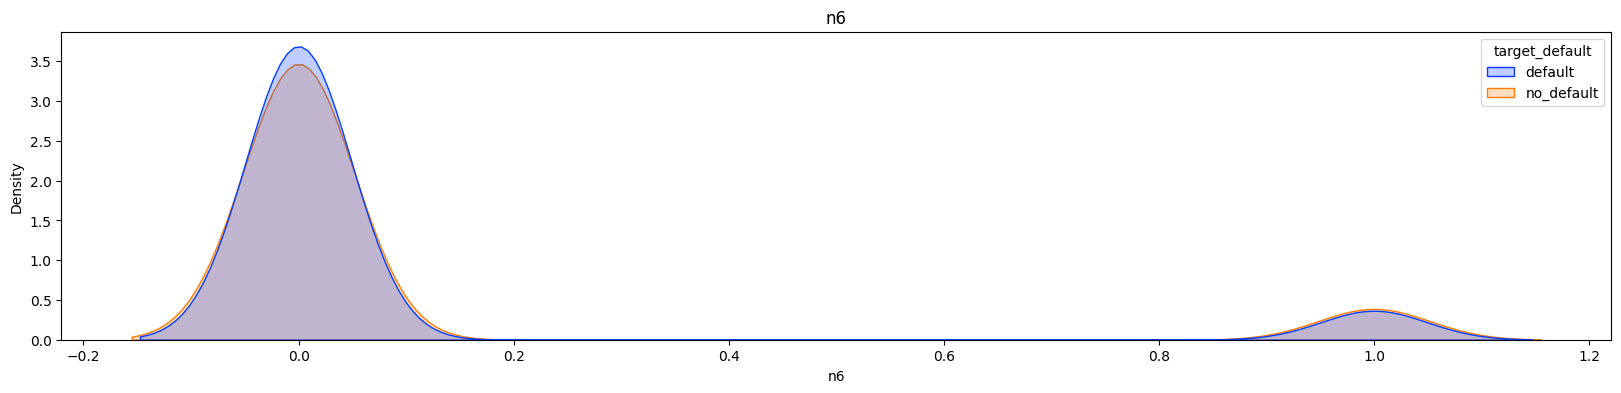

pro+aty


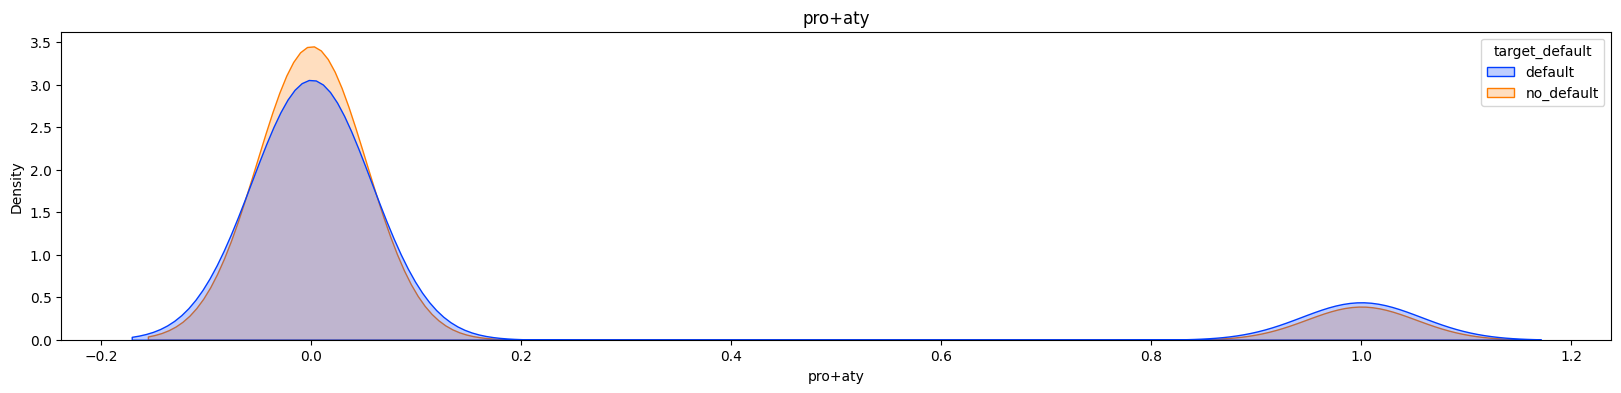

n5


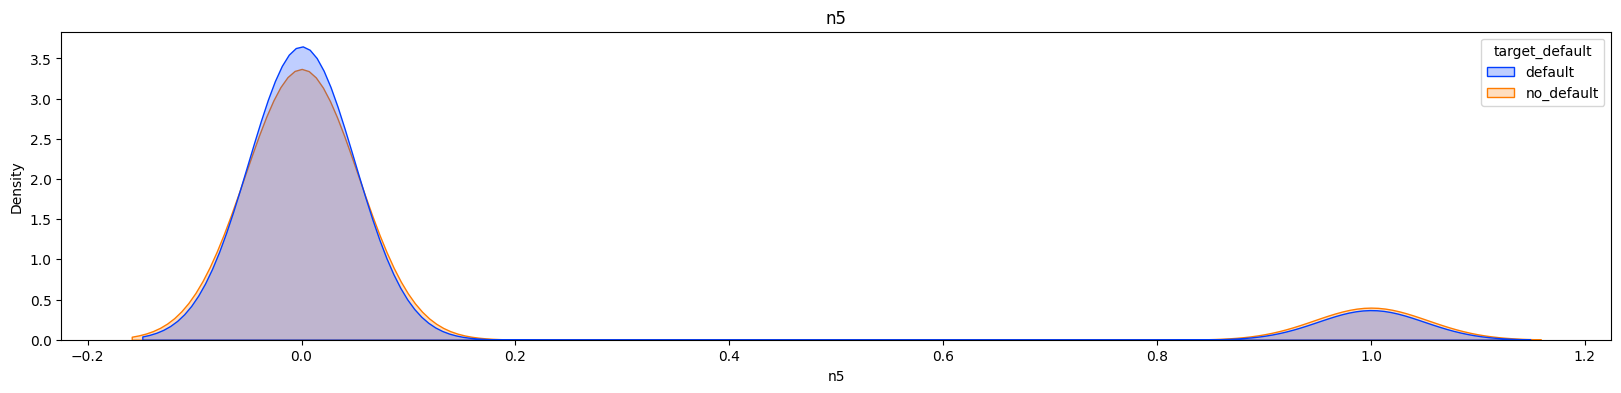

c1


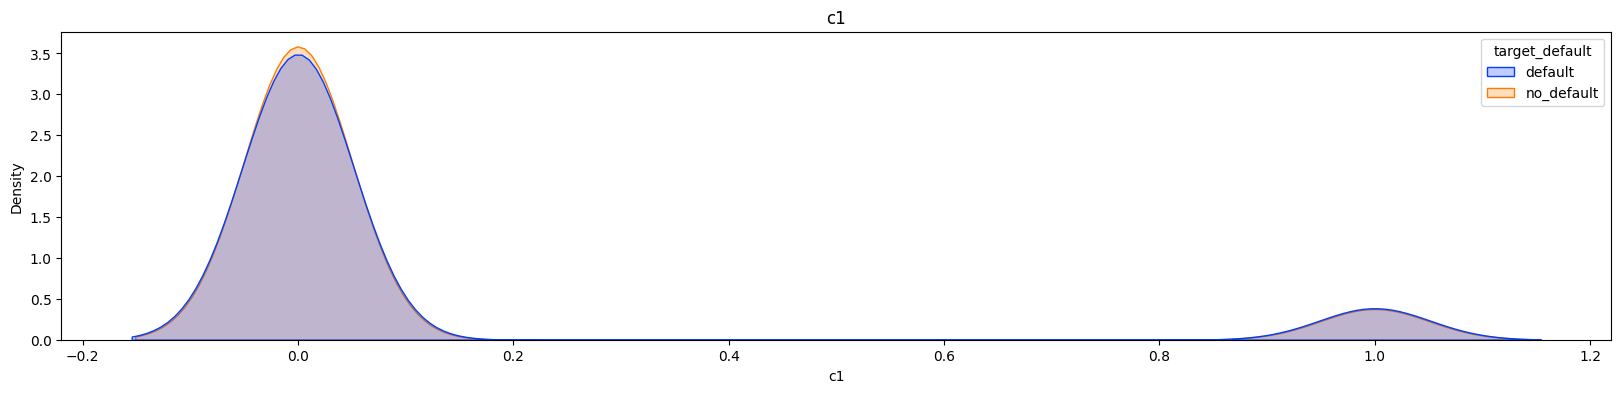

n2


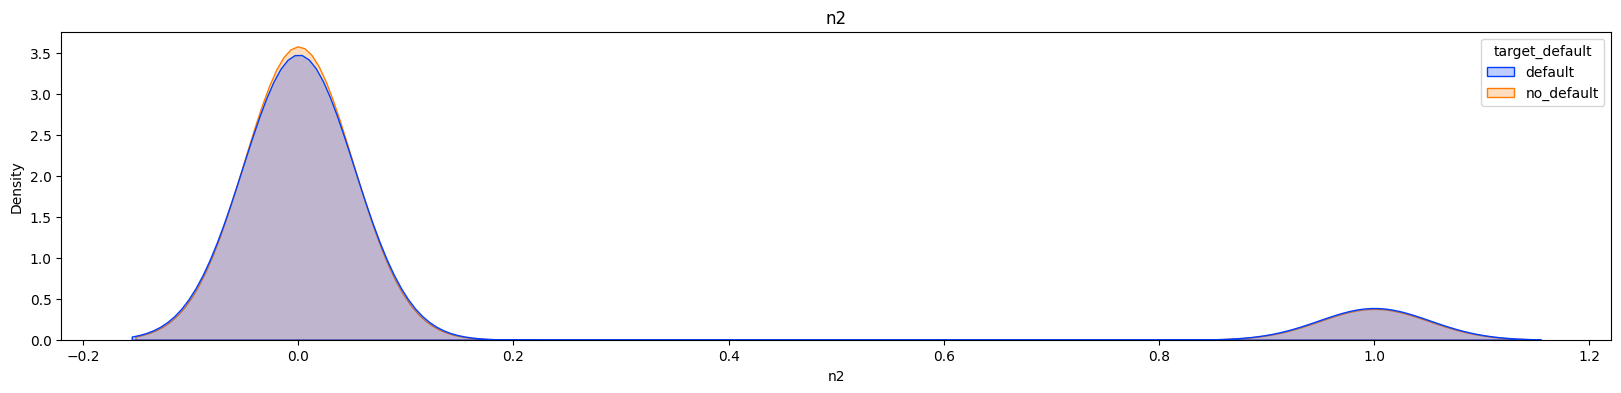

b19


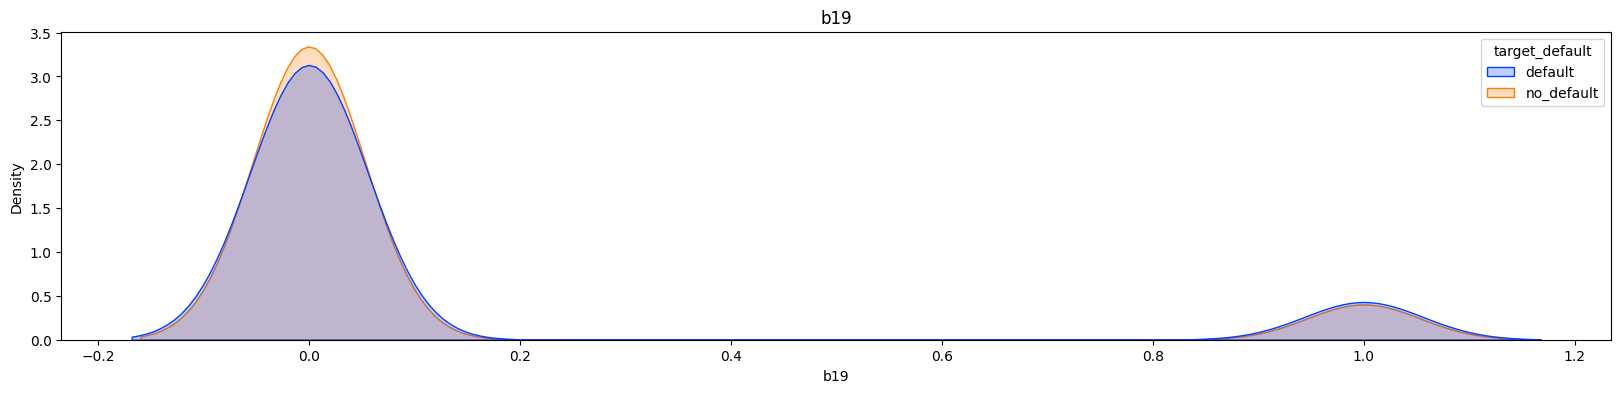

n15


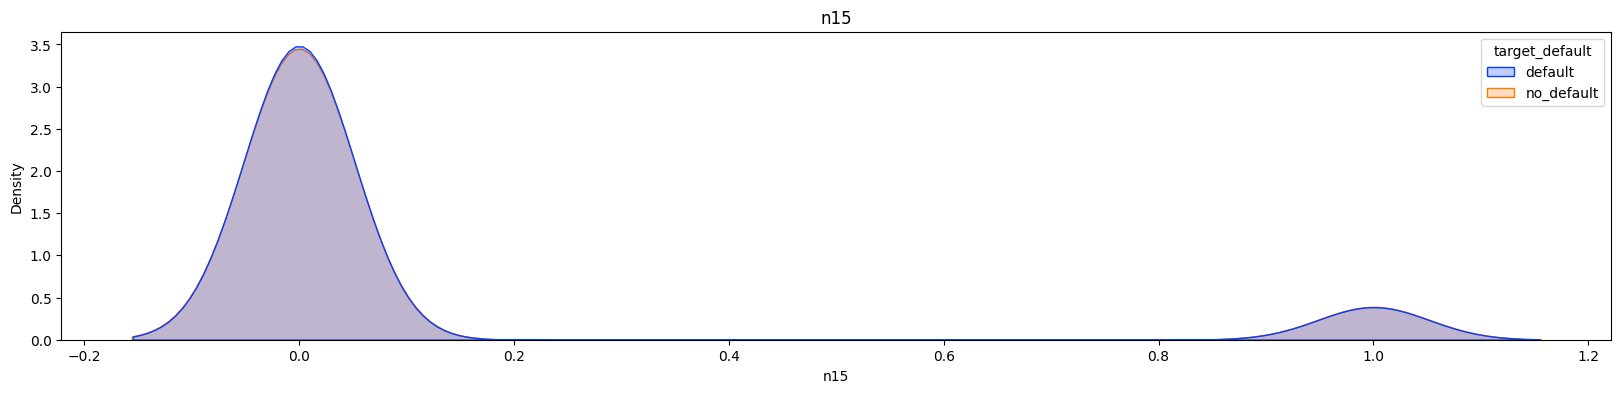

dfa


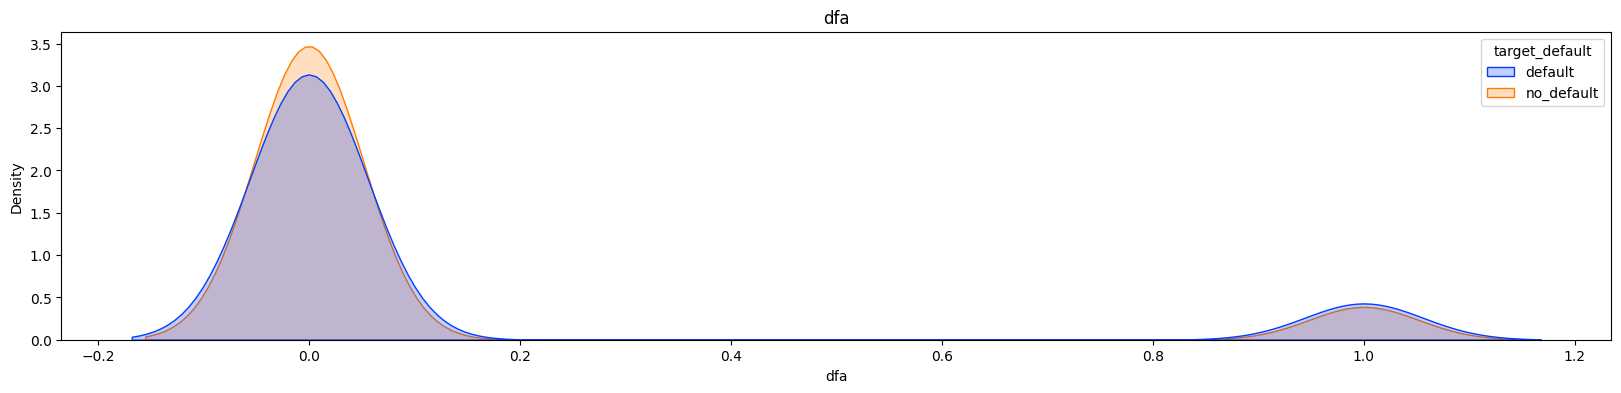

n1


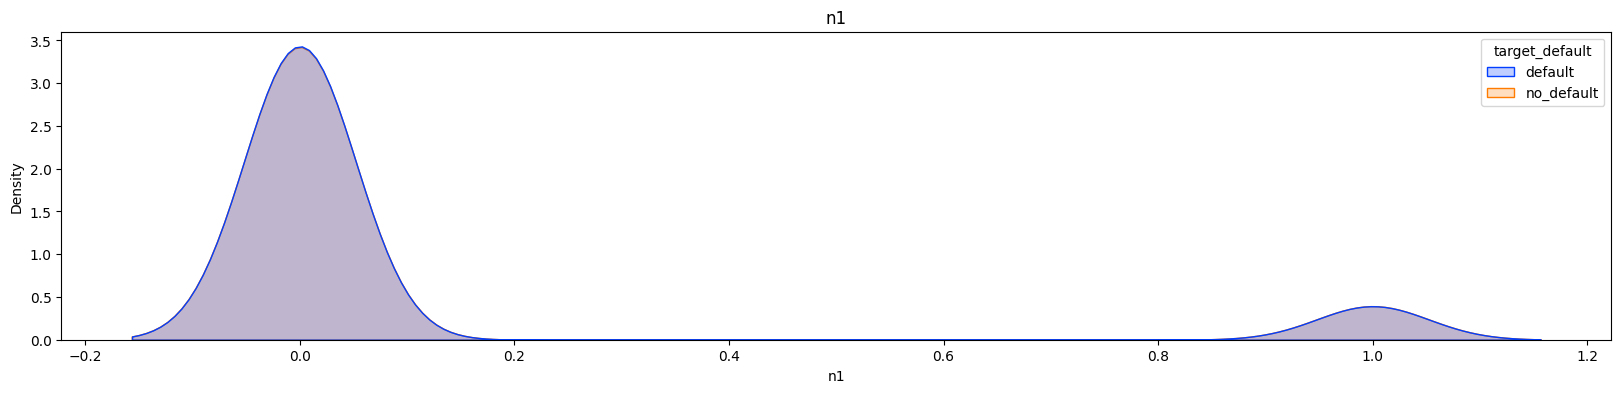

n10


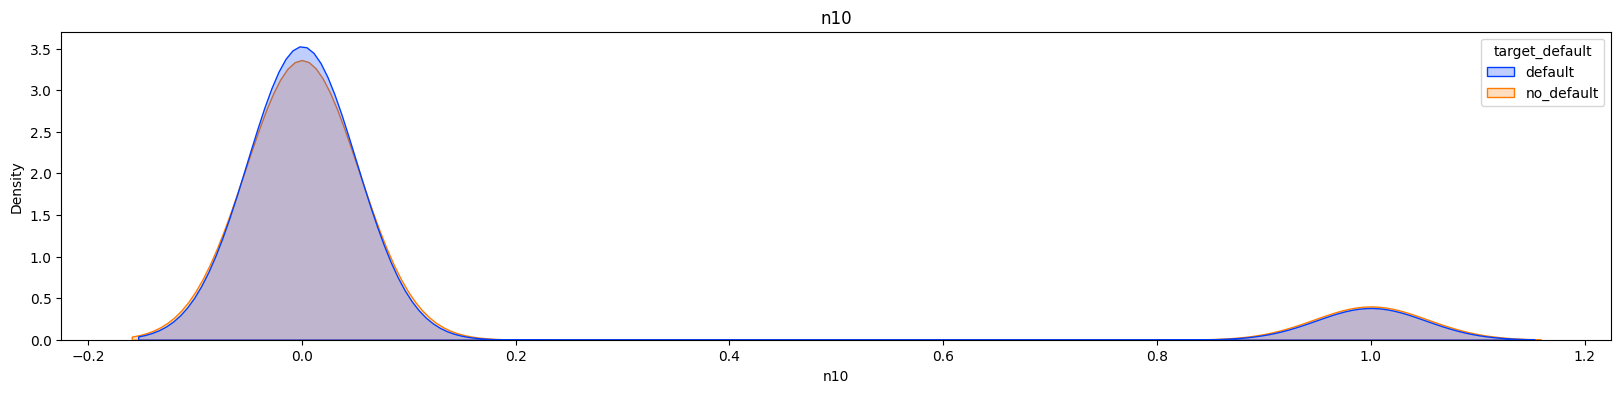

n14


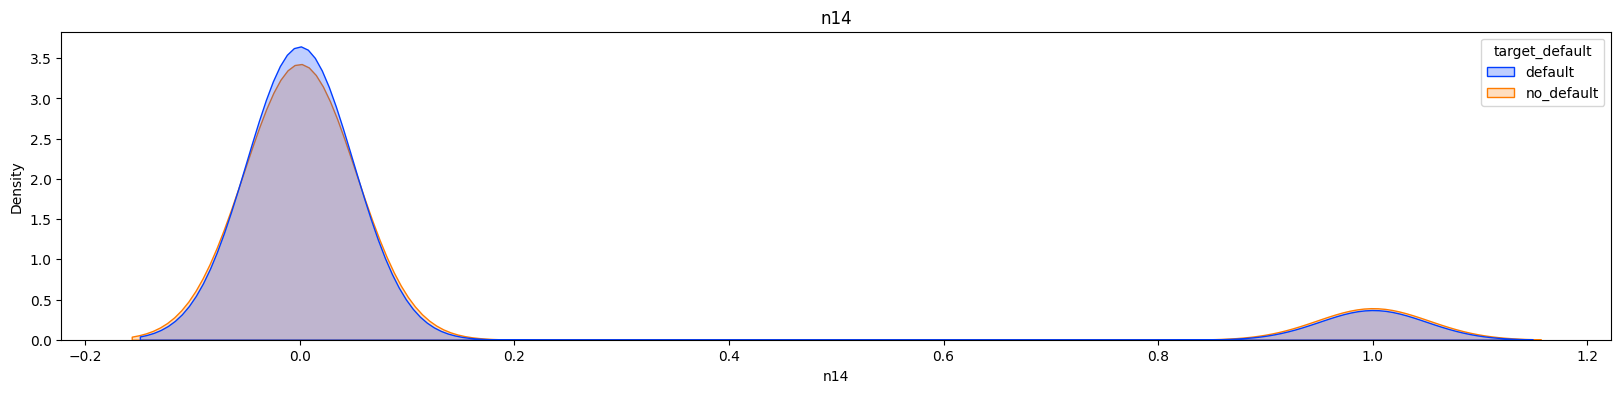

n9


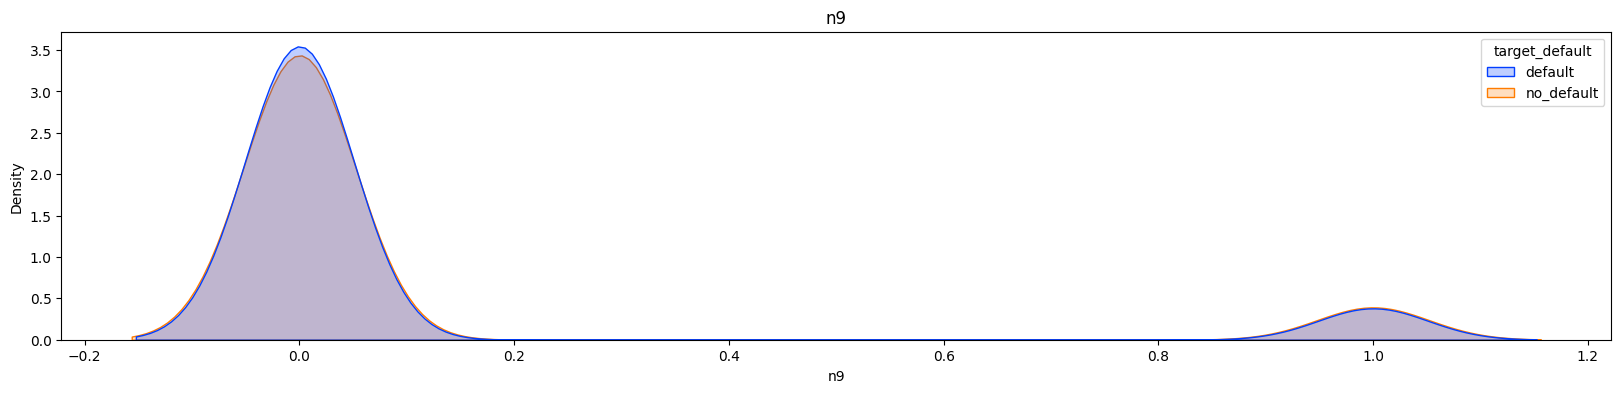

da


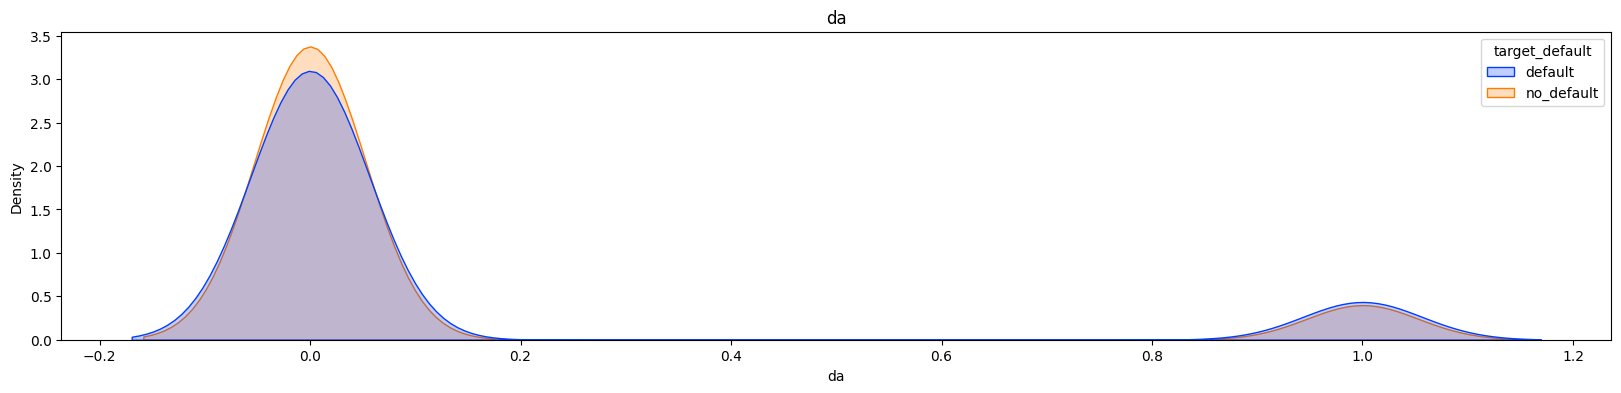

n19


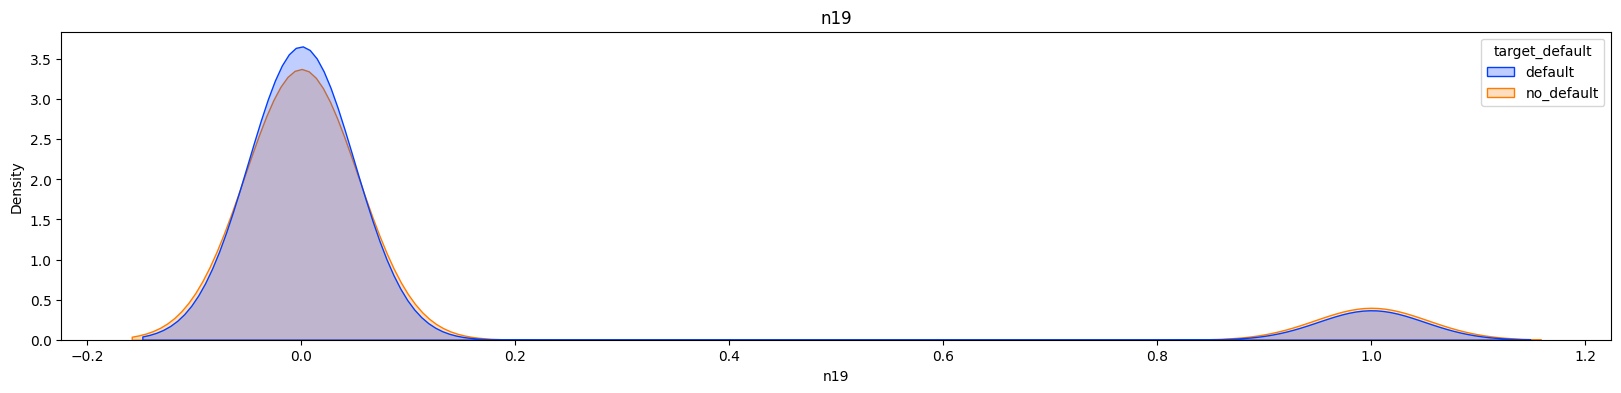

c55


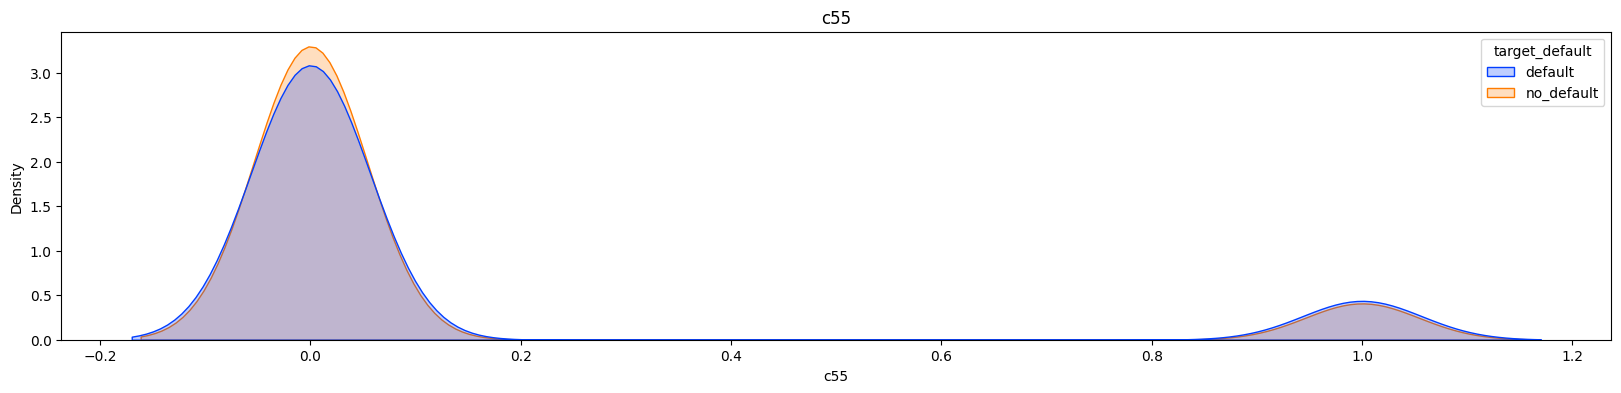

a15


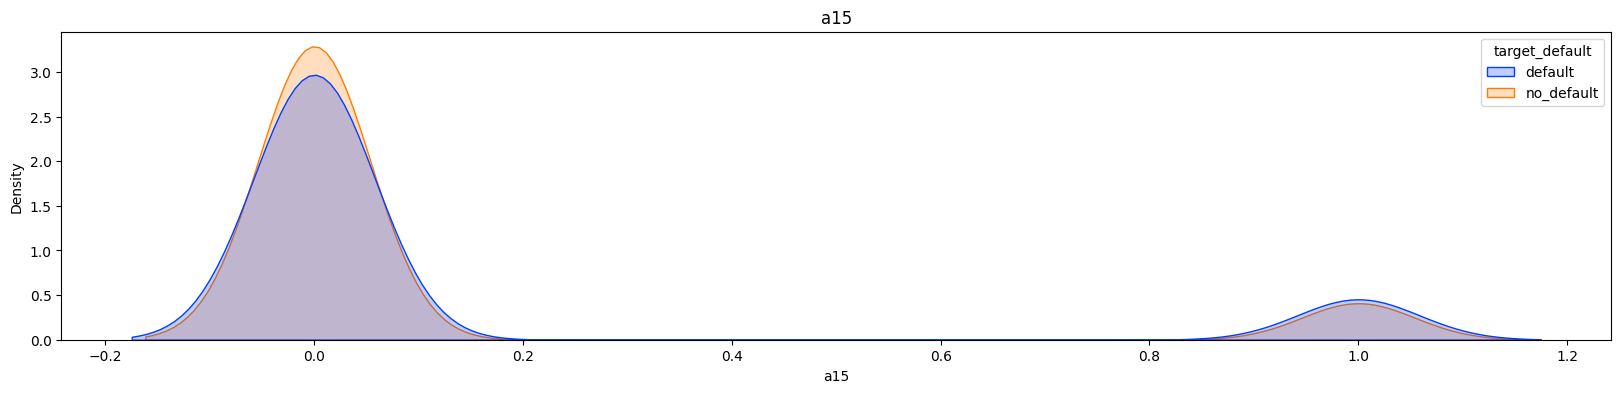

income_diff


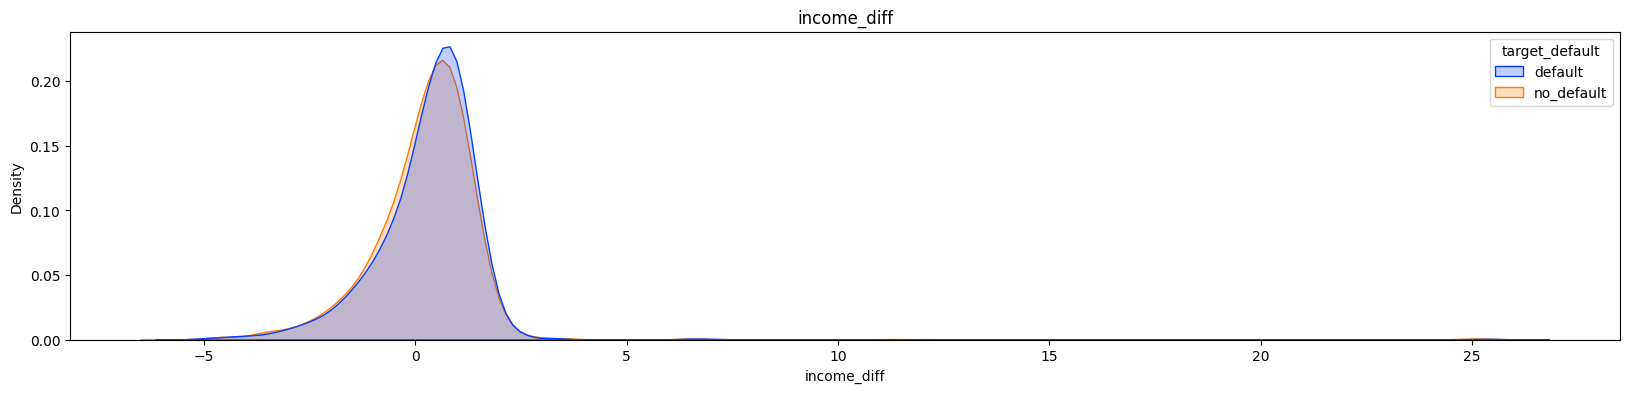

In [32]:
X_under['target_default'] = y_under.map({0:'no_default', 1:'default'})

for name in X_under.columns[:-1]:
  print(name)
  fig, axes = plt.subplots(1, 1, figsize=(20, 4))
  ax = axes

  sns.kdeplot(data=X_under[[name, 'target_default']], x=name, ax=ax,
               hue='target_default', hue_order=['default','no_default'], shade=True, palette='bright')
  ax.set_title(name)

  plt.show()

X_under.drop('target_default',axis=1, inplace=True)

## Decision Tree

Note que a árvore de decisão dá maior peso para as features `facebook_profile`, `ddd`, `score_1` e `external_data_provider_email_seen_before`. Vimos que estas features tem mais informação sobre os possíveis clientes que apresentam default.

In [33]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [34]:
tree_clf = DecisionTreeClassifier(max_depth=3)
tree_clf.fit(X_under, y_under)

DecisionTreeClassifier(max_depth=3)

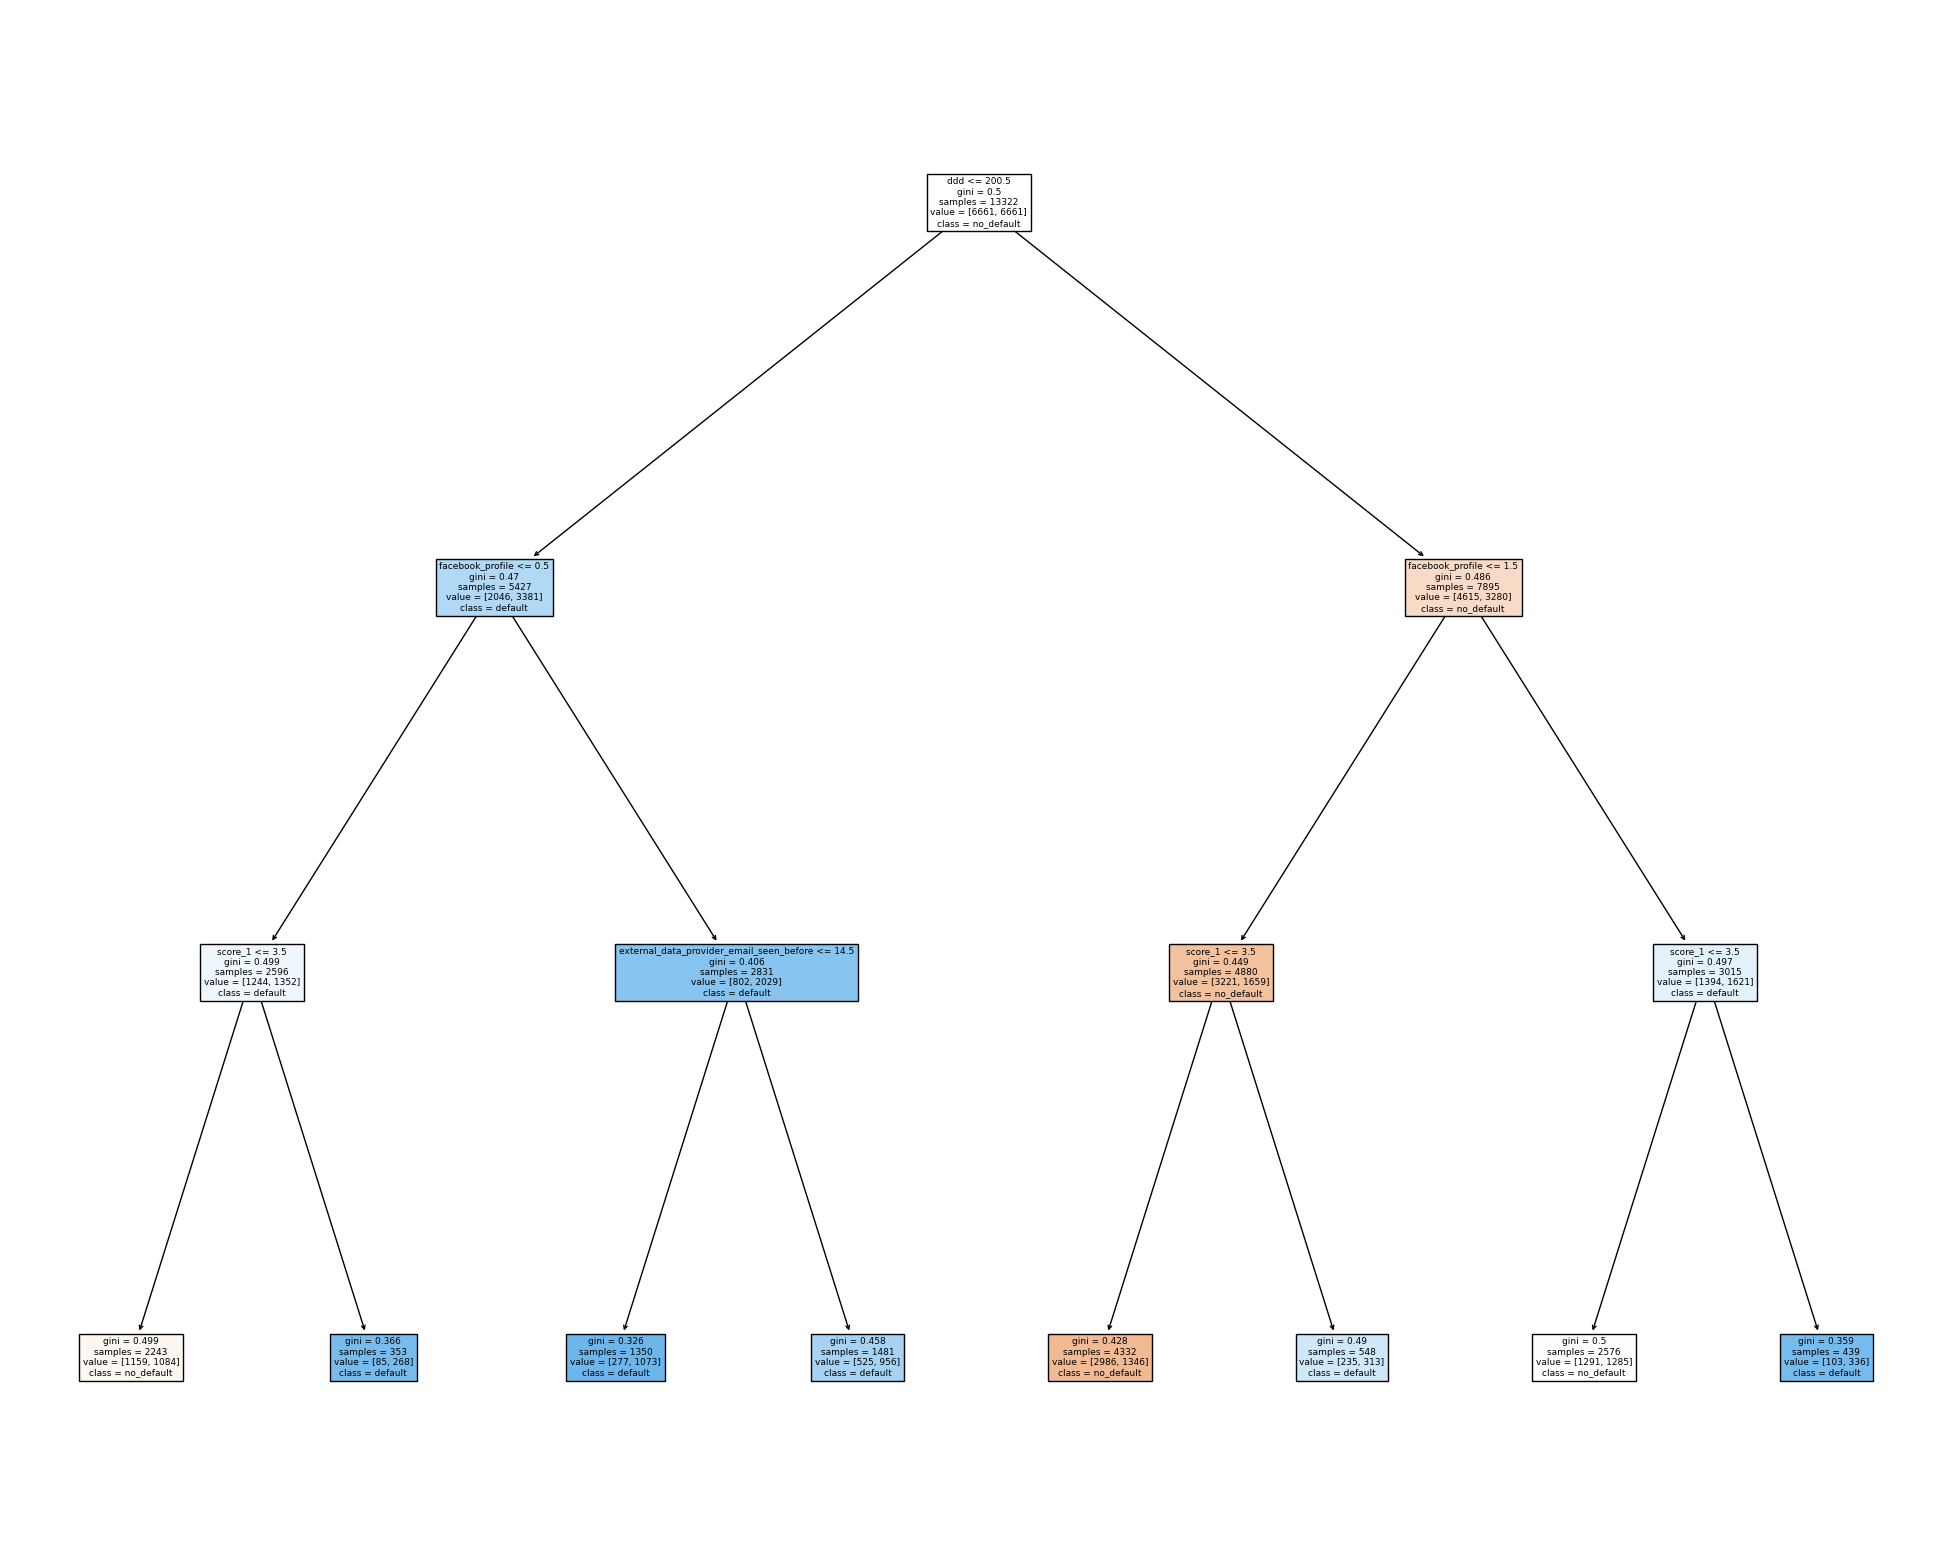

In [35]:
#@title Plot do fluxograma para uma árvore pequena
fig = plt.figure(figsize=(25,20))

_ = tree.plot_tree(tree_clf, 
                   feature_names=X_under.columns,  
                   class_names=['no_default', 'default'],
                   filled=True)

plt.show()

In [36]:
grid_pipe = Pipeline([
                      ('decision_tree', DecisionTreeClassifier()),
                    ])

In [37]:
param_grid = [
              {'decision_tree__max_depth': [3, 10, 50, 80], 
               'decision_tree__max_features': ['log2', 'sqrt', X_under.shape[1]],
               'decision_tree__min_samples_split': [500, 1000, 2000],
               'decision_tree__splitter': ['best', 'random']},
             ]

grid_search = GridSearchCV(grid_pipe, param_grid, cv=5,
                            scoring='recall',
                            n_jobs=-1)

_ = grid_search.fit(X_under, y_under)

In [38]:
grid_search.best_params_

{'decision_tree__max_depth': 3,
 'decision_tree__max_features': 60,
 'decision_tree__min_samples_split': 2000,
 'decision_tree__splitter': 'random'}

In [39]:
tree_clf = grid_search.best_estimator_

In [40]:
score_under.append(return_scores(tree_clf, X_under, y_under, name='Decision Tree'))

<recall>: 0.63 recall_err: 0.06
<accuracy>: 0.612 accuracy_err: 0.01


In [41]:
feature_importances = tree_clf[0].feature_importances_

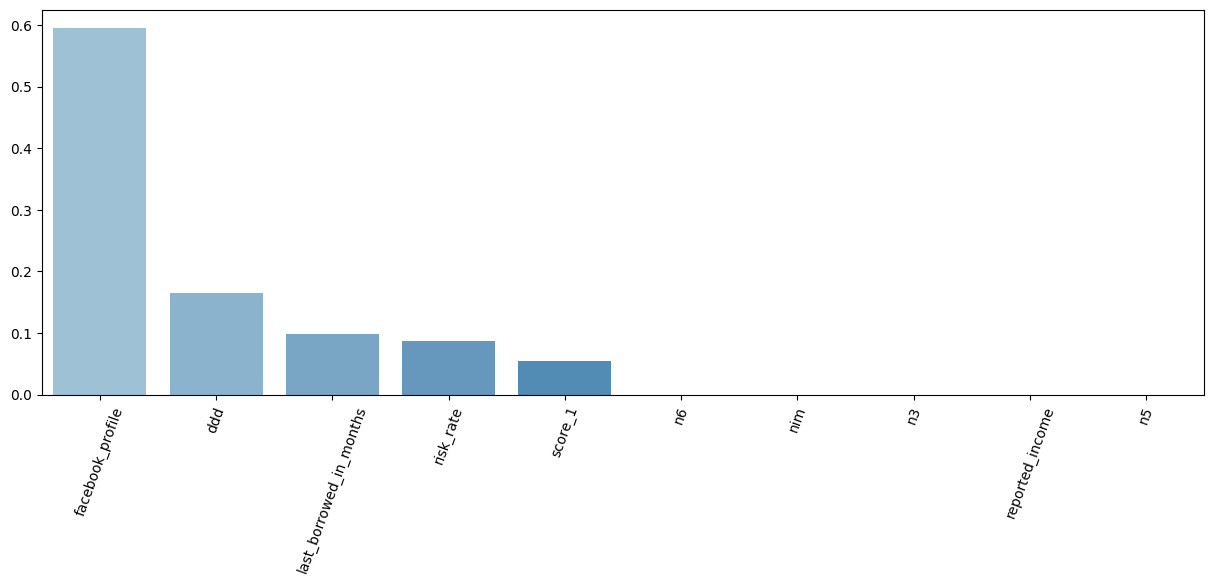

In [42]:
plt.figure(figsize=[15, 5])
top_10 = pd.DataFrame(feature_importances, index=X_under.columns).sort_values(0, ascending=False).head(10)
top_features = list(top_10.index)

sns.barplot(data=top_10.T, palette="Blues_d")
plt.xticks(rotation=70)
plt.show()

## Random Forest

In [43]:
from sklearn.ensemble import RandomForestClassifier

In [44]:
grid_pipe = Pipeline([
                      ('rand_forest', RandomForestClassifier(n_jobs=-1, min_samples_split=500, random_state=42)),
                    ])

In [45]:
from sklearn.model_selection import GridSearchCV

param_grid = [
              {'rand_forest__n_estimators': [100, 200], 
               'rand_forest__max_features': ['sqrt', 12, 20, X_under.shape[1]]},
             ]

grid_search = GridSearchCV(grid_pipe, param_grid, cv=5,
                            scoring='recall',
                            n_jobs=-1)

_ = grid_search.fit(X_under, y_under)

In [46]:
grid_search.best_params_

{'rand_forest__max_features': 'sqrt', 'rand_forest__n_estimators': 100}

In [47]:
rand_forest = grid_search.best_estimator_

In [48]:
score_under.append(return_scores(rand_forest, X_under, y_under, name='Random Forest'))

<recall>: 0.664 recall_err: 0.007
<accuracy>: 0.667 accuracy_err: 0.005


In [49]:
feature_importances = rand_forest[0].feature_importances_

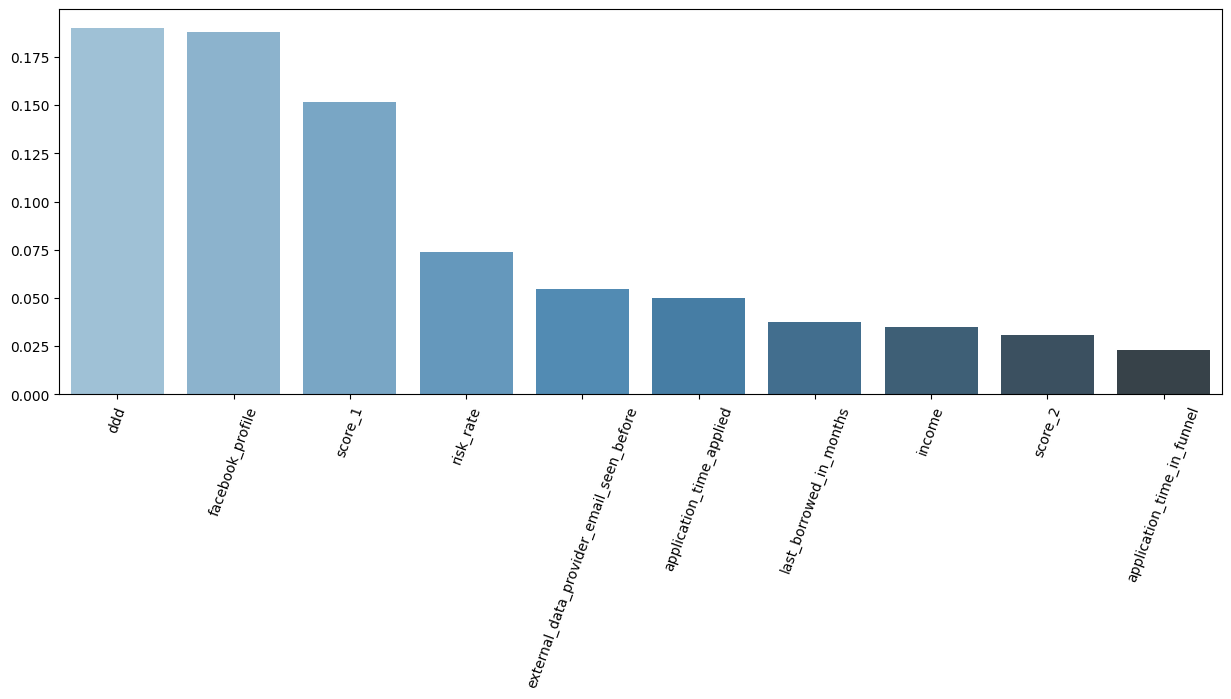

In [50]:
plt.figure(figsize=[15, 5])
top_10 = pd.DataFrame(feature_importances, index=X_under.columns).sort_values(0, ascending=False).head(10)
top_features = list(top_10.index)
sns.barplot(data=top_10.T, palette="Blues_d")
plt.xticks(rotation=70)
plt.show()

## DNN

In [51]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.model_selection import KFold, StratifiedKFold

In [52]:
X = StandardScaler().fit_transform(X_under)

In [53]:
def DNN_build(X_train):

    model = Sequential([
            Dense(6, input_shape=(X_train.shape[1], ), activation='relu'),
            Dense(5, activation='relu'),
            Dense(1, activation='sigmoid')                     
    ])


    model.compile(loss='binary_crossentropy',
                  metrics=['Recall', tf.keras.metrics.AUC(curve='PR'), 'Accuracy'])
    
    return model

In [54]:
str_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

callbacks = tf.keras.callbacks.EarlyStopping(monitor='recall', patience=25,
                                             restore_best_weights=True)

scores_kfold = []

for train_idx, test_idx in str_k_fold.split(X, y_under):

    model = []
    model = DNN_build(X[train_idx])

    hist = model.fit(X[train_idx], y_under[train_idx],
                 batch_size=64,
                 verbose=0,
                 epochs=100,
                 callbacks=callbacks,
                 )

    scores_kfold.append(model.evaluate(X[test_idx],
                                       y_under[test_idx], verbose=0))

In [55]:
scores_kfold = np.asarray(scores_kfold)
mean_rec = np.mean(scores_kfold[:, 1])
std_rec = np.std(scores_kfold[:, 1])
pr_auc = np.mean(scores_kfold[:, 2])
mean_acc = np.mean(scores_kfold[:, 3])
std_acc = np.std(scores_kfold[:, 3])

print('<Recall>: {0} \nRecall_err: {1} \n<PR-AUC>: {2} \n<Acc>: {3} \nAcc_err: {4}'.format(np.round(mean_rec, 3),
                                                                                          np.round(std_rec, 3),
                                                                                          np.round(pr_auc, 3),
                                                                                          np.round(mean_acc, 3),
                                                                                          np.round(std_acc, 3)))

<Recall>: 0.541 
Recall_err: 0.042 
<PR-AUC>: 0.588 
<Acc>: 0.567 
Acc_err: 0.023


In [56]:
score_under.append([mean_rec, std_rec, mean_acc, std_acc, 'DNN'])

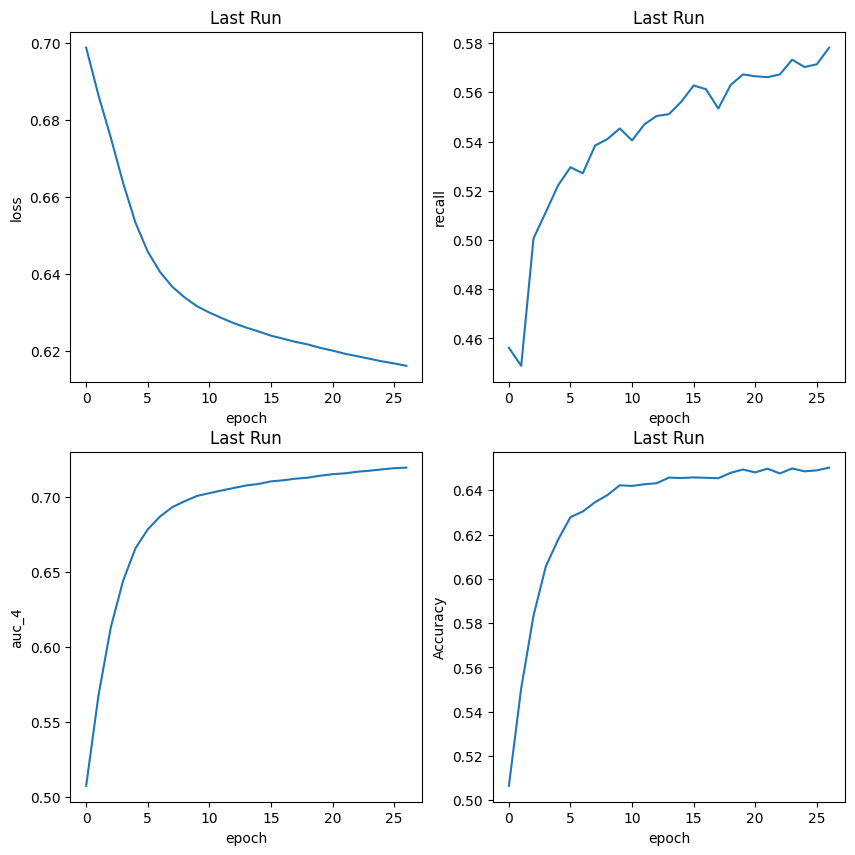

In [57]:
plt.figure(figsize=[10, 10])

keys = hist.history.keys()

for idx, key in enumerate(keys):
  
  plt.subplot(2, 2, idx + 1)

  y = hist.history[key]
  x = np.arange(len(y))
  plt.plot(y)
  plt.title('Last Run')
  plt.ylabel(key)
  plt.xlabel('epoch')

plt.show()

## Pipeline: Centraliza, Standariza, Transforma em Guassiana, Transforma em One Hot Enconde.

- Com isso é possível usar o dataset nos modelos de SVM e Logistic.

In [58]:
class OneHotEncoderTransform(BaseEstimator, TransformerMixin):
    
    def __init__(self, data_to_fit=[]):
        
        self.data_to_fit = data_to_fit

    def transform(self, X):

        aux = OneHotEncoder(drop='first', sparse=True)
        
        aux = aux.fit(self.data_to_fit)

        data = aux.transform(X)

        return data

    def fit(self, X, y=None):
        return self

In [59]:
num_cols = [
            'risk_rate',
            'score_3',
            'score_4',
            'score_5',
            'score_6',
            'external_data_provider_fraud_score',
           ]

cat_cols = [
            'n_issues',         
            'facebook_profile', 
            'n_bankruptcies',
            'n_defaulted_loans',
            'last_amount_borrowed',
            'last_borrowed_in_months',
            'ok_since',
            'external_data_provider_email_seen_before',
            'application_time_applied',
            'application_time_in_funnel',  
           ]

to_norm = [
           'reported_income',
           'income',
           'n_accounts',
           'income_diff',]

onehot_cols = [ 
                'score_1',
                'score_2',
                'real_state',
                'marketing_channel',
                'ddd', 
                'email',
                'reason',
                'job_name',
                'state',
                'zip',
                'shipping_state'
               ]

In [60]:
assert set(cols) - set(num_cols + cat_cols + onehot_cols + to_norm) == set(tags_list), set(cols) - set(num_cols + cat_cols + onehot_cols + to_norm)

try:
  df_clean[num_cols + cat_cols + onehot_cols + to_norm]
except:
  print('Algumas colunas estão faltando.')
  df_clean[num_cols + cat_cols + onehot_cols + to_norm]


In [61]:
quant = QuantileTransformer(output_distribution='normal')

cols_scale = ColumnTransformer([
                                ('to_norm', quant, to_norm),
                                ('std', StandardScaler(), num_cols),
                                ('min_max', MinMaxScaler((-1, 1)), cat_cols),
                                ('one_hot', OneHotEncoderTransform(
                                    data_to_fit=df_clean[onehot_cols])
                                , onehot_cols)
                               ],
                                remainder='passthrough')

## Logistic Regression

In [62]:
from sklearn.linear_model import LogisticRegression

Escalando a variável

In [63]:
grid_pipe = Pipeline([('scale', cols_scale),
                      ('trSVD',  TruncatedSVD(n_components=100)),
                      ('log_regr', LogisticRegression(max_iter=1500, n_jobs=-1)),
                    ])

Grid search

In [64]:
param = [{"log_regr__penalty": ['l1', 'l2'],
              "log_regr__C": [1, 0.1, 0.01],
              "log_regr__solver": ['saga']},
         
         #{"log_regr__penalty": ['l1', 'l2'],
         #     "log_regr__C": [1, 0.1],
         #     "log_regr__solver": ['liblinear']},
         ]

grid_search = GridSearchCV(grid_pipe, param, cv=5,
                            scoring='recall', n_jobs=-1, error_score='raise')

_ = grid_search.fit(X_under, y_under)

In [65]:
grid_search.best_params_

{'log_regr__C': 0.1, 'log_regr__penalty': 'l1', 'log_regr__solver': 'saga'}

Avaliando o melhor modelo

In [66]:
logist_regr = grid_search.best_estimator_

In [67]:
score_under.append(return_scores(logist_regr, X_under, y_under, name='Logist'))

<recall>: 0.659 recall_err: 0.012
<accuracy>: 0.659 accuracy_err: 0.007


## SVM

In [68]:
from sklearn.svm import SVC

In [69]:
grid_pipe = Pipeline([('scale', cols_scale),
                      ('svm', SVC(cache_size=2000)),
                    ])

In [70]:
param = [
         #{"svm__kernel": ['poly'],
         # "svm__C": [1, 0.1, 0.01],
         # "svm__gamma": ['scale'],
         # "svm__coef0": [1],
         # "svm__degree": [1, 2, 3],
         # },
         
         {"svm__kernel": ['rbf'],
          "svm__C": [10, 1, 0.1],
          "svm__gamma": ['scale', 5, 1],
          },
         
         ]

grid_search = GridSearchCV(grid_pipe, param, cv=5,
                            scoring='recall', n_jobs=-1)

_ = grid_search.fit(X_under, y_under)

In [71]:
grid_search.best_params_

{'svm__C': 1, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}

In [72]:
svm_classifier = grid_search.best_estimator_

In [73]:
score_under.append(return_scores(svm_classifier, X_under, y_under, name='SVM'))

<recall>: 0.66 recall_err: 0.011
<accuracy>: 0.658 accuracy_err: 0.007


## Bagging


In [74]:
from sklearn.ensemble import BaggingClassifier

In [75]:
grid_pipe = Pipeline([('bg', BaggingClassifier( 
                                              n_estimators=200,
                                              n_jobs=-1,
                                              max_samples=0.5,
                                              ))
                    ])

In [76]:
param = [
         {"bg__base_estimator": [DecisionTreeClassifier(max_depth=2), 
                                 DecisionTreeClassifier(max_depth=3),
                                 DecisionTreeClassifier()],
          },
         ]

grid_search = GridSearchCV(grid_pipe, param, cv=5,
                            scoring='recall', n_jobs=-1)

_ = grid_search.fit(X_under, y_under)

In [77]:
grid_search.best_params_

{'bg__base_estimator': DecisionTreeClassifier(max_depth=2)}

In [78]:
bag_clf = grid_search.best_estimator_

In [79]:
score_under.append(return_scores(bag_clf, X_under, y_under, name='Bagging'))

<recall>: 0.658 recall_err: 0.105
<accuracy>: 0.615 accuracy_err: 0.008


## Random Patches method

Sampling features and training instances

In [80]:
rpatch_clf = BaggingClassifier(DecisionTreeClassifier(max_depth=10,
                                                   min_samples_split=1000,
                                                   splitter='random'),
                            max_features=0.6,
                            bootstrap=True,
                            bootstrap_features=True,
                            n_jobs=-1,)

_ = rpatch_clf.fit(X_under.astype(np.float32), y_under.astype(np.float32))

In [81]:
grid_pipe = Pipeline([('Rp',BaggingClassifier(
                                              max_features=0.6,
                                              bootstrap=True,
                                              bootstrap_features=True,
                                              n_jobs=-1,))
                    ])

In [82]:
param = [
         {"Rp__base_estimator": [DecisionTreeClassifier(max_depth=2), 
                                 DecisionTreeClassifier(max_depth=3),
                                 DecisionTreeClassifier()],
          },
         ]

grid_search = GridSearchCV(grid_pipe, param, cv=5,
                            scoring='recall', n_jobs=-1)

_ = grid_search.fit(X_under, y_under)

In [83]:
grid_search.best_params_

{'Rp__base_estimator': DecisionTreeClassifier(max_depth=2)}

In [84]:
rpatch_clf = grid_search.best_estimator_

In [85]:
score_under.append(return_scores(rpatch_clf, X_under, y_under, name='Random Patches'))

<recall>: 0.611 recall_err: 0.039
<accuracy>: 0.64 accuracy_err: 0.012


## Adaboost

In [86]:
from sklearn.ensemble import AdaBoostClassifier

In [87]:
ada_clf = AdaBoostClassifier(
DecisionTreeClassifier(max_depth=3), n_estimators=500,
algorithm="SAMME.R", learning_rate=0.1)

_ = ada_clf.fit(X_under, y_under)

In [88]:
score_under.append(return_scores(ada_clf, X_under, y_under, name='Adaboost'))

<recall>: 0.634 recall_err: 0.008
<accuracy>: 0.651 accuracy_err: 0.004


## Voting Classifiers

In [89]:
from sklearn.ensemble import VotingClassifier

In [90]:
voting_clf = VotingClassifier(
estimators=[
            ('logist_regression', logist_regr),
            ('random_forest', rand_forest), 
            ('svm_classifier', svm_classifier.set_params(svm__probability=True)),
            ('decision_tree', tree_clf),
            ('bagging', bag_clf),
            ('adaboost', ada_clf),
            ],
            voting='soft', n_jobs=-1)

In [91]:
_ = voting_clf.fit(X_under, y_under)

In [92]:
score_under.append(return_scores(voting_clf, X_under, y_under, name='Vonting - Soft'))

<recall>: 0.652 recall_err: 0.01
<accuracy>: 0.664 accuracy_err: 0.005


# Treino - Full Dataset

- Treino utilizando o dataset com desbalanço de classes.

In [93]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import TruncatedSVD, PCA
import joblib

In [94]:
# Guarda os scores dos treinos
score_full = []

In [95]:
def return_scores(classifier, X, y, name, scoring=["recall", "accuracy"]):

  '''
     classifier: classificador
     X:          dataset
     y:          variável alvo
     name:       nome do classificador
     scoring:    escores que serão calculados

     return:     array com os escores
  '''

  scores = cross_validate(classifier, X, y,
                        scoring = scoring, cv=5, n_jobs=-1)

  results = []

  for key in scores.keys():

    if key.split('_')[1] in scoring:

      mean = np.mean(scores[key])
      results.append(mean)

      std = np.std(scores[key])
      results.append(std)

      print('<{0}>: {1} {0}_err: {2}'.format(key.split('_')[1], 
                                             np.round(mean, 3),
                                             np.round(std, 3)))

  results.append(name)

  return results

## Plot das variáveis separandas pela classe

- Note que algumas classes como `facebook_profile`, `ddd`, `score_1`, `external_data_provider_email_seen_before` e `application_time_applied` têm mais informação sobre os clientes que não cumprem com suas obrigações (`default`). Por exemplo, o `application_time_applied` (horário que o cliente começou a se cadastrar) indica que clientes que se cadastram de $0$ às $6$ da madrugada são mais propensos a não honrar com os compromissos. O mesmo é válido para clientes que não adicionam o facebook ao cadastro, veja o plot da feature `facebook_profile`. 

reported_income


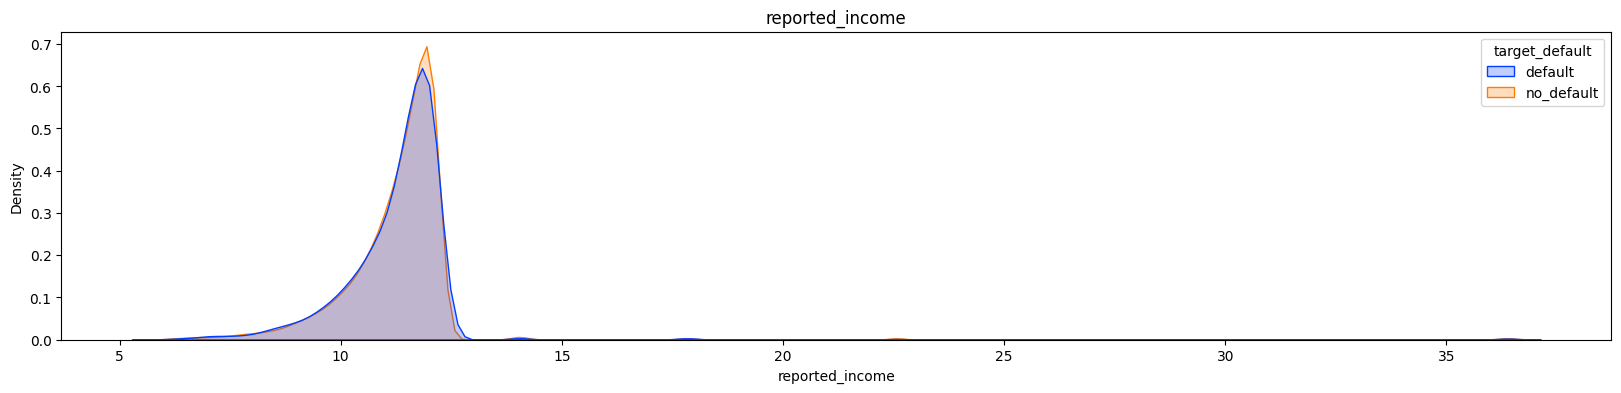

income


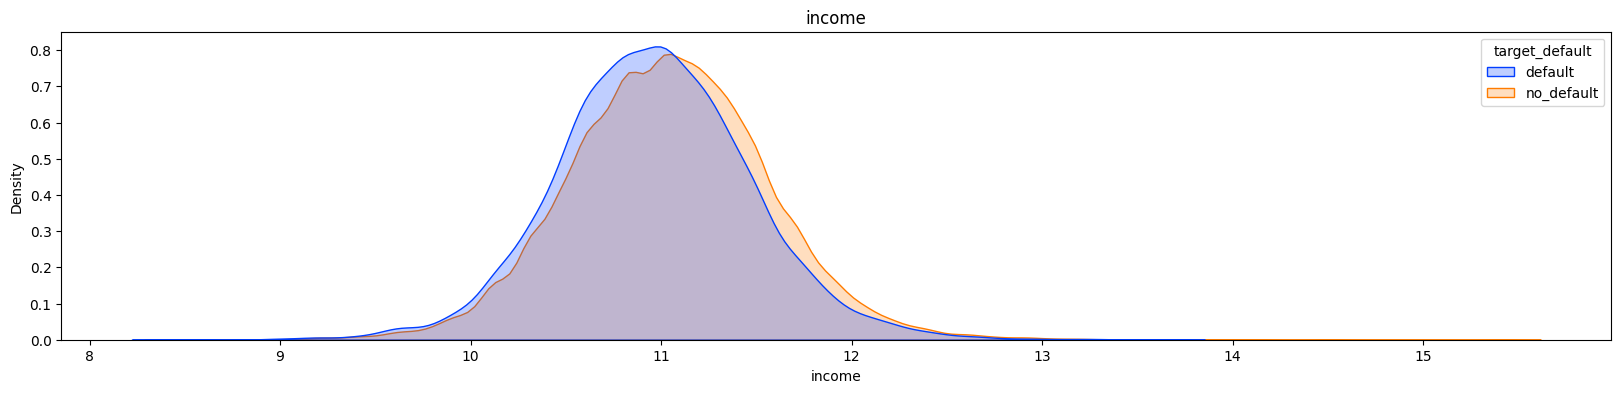

n_accounts


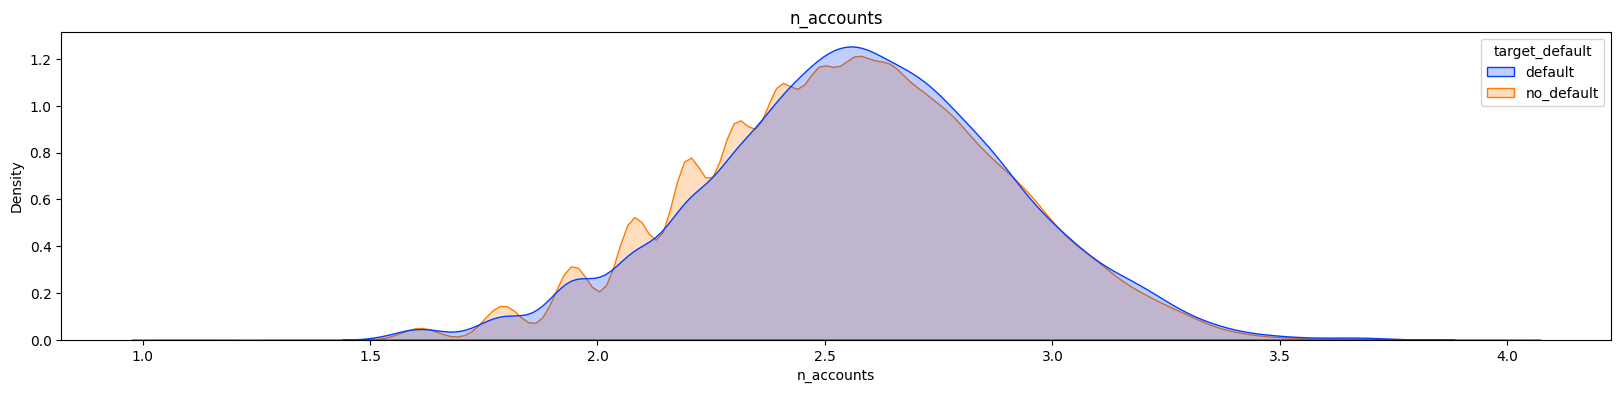

n_issues


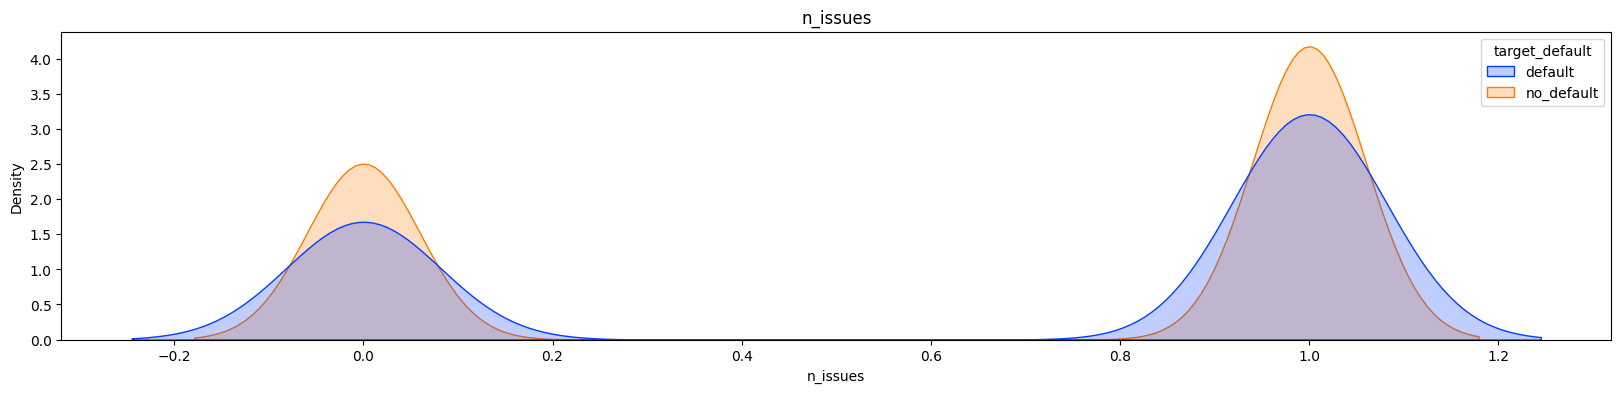

zip


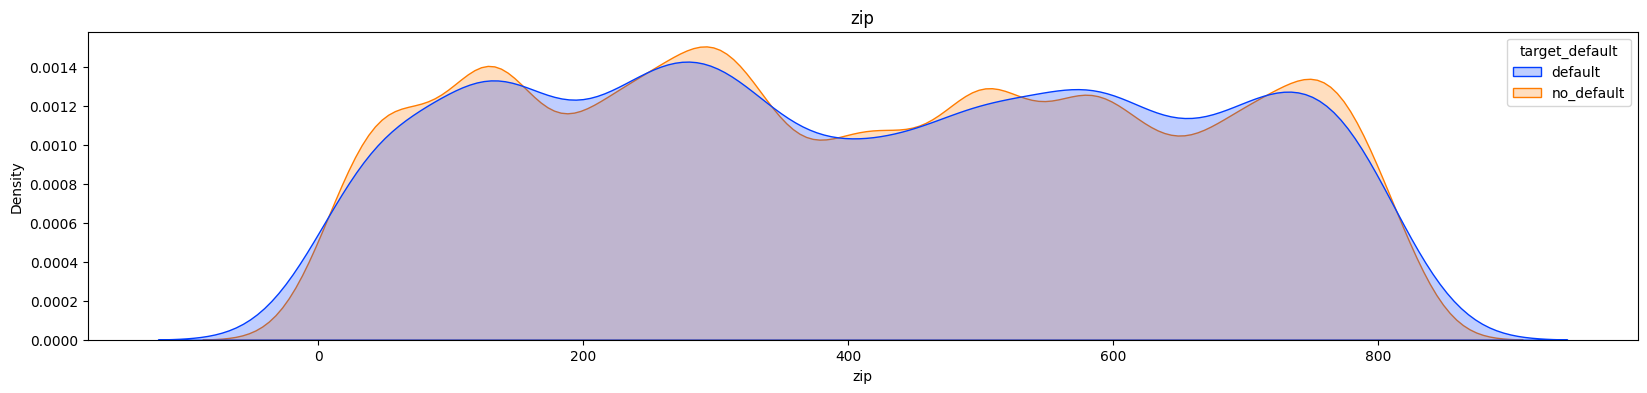

score_2


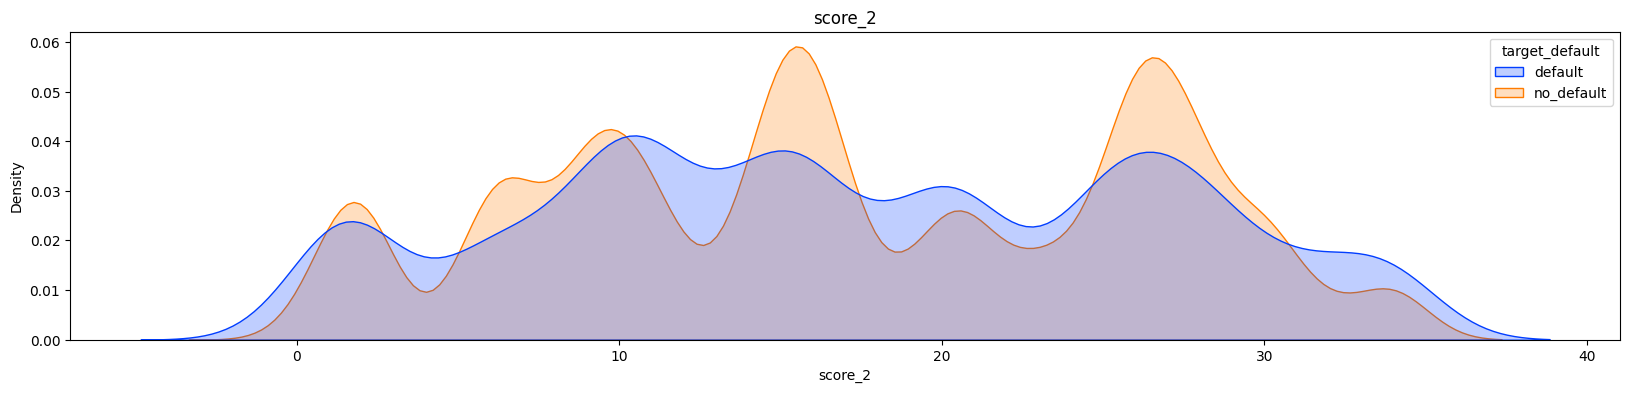

shipping_state


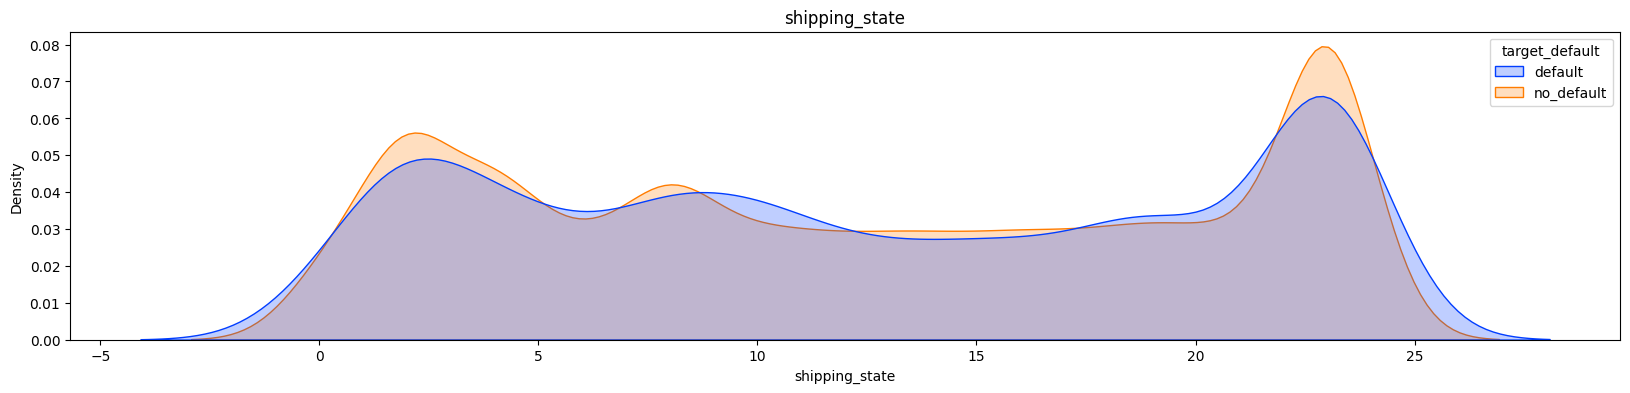

job_name


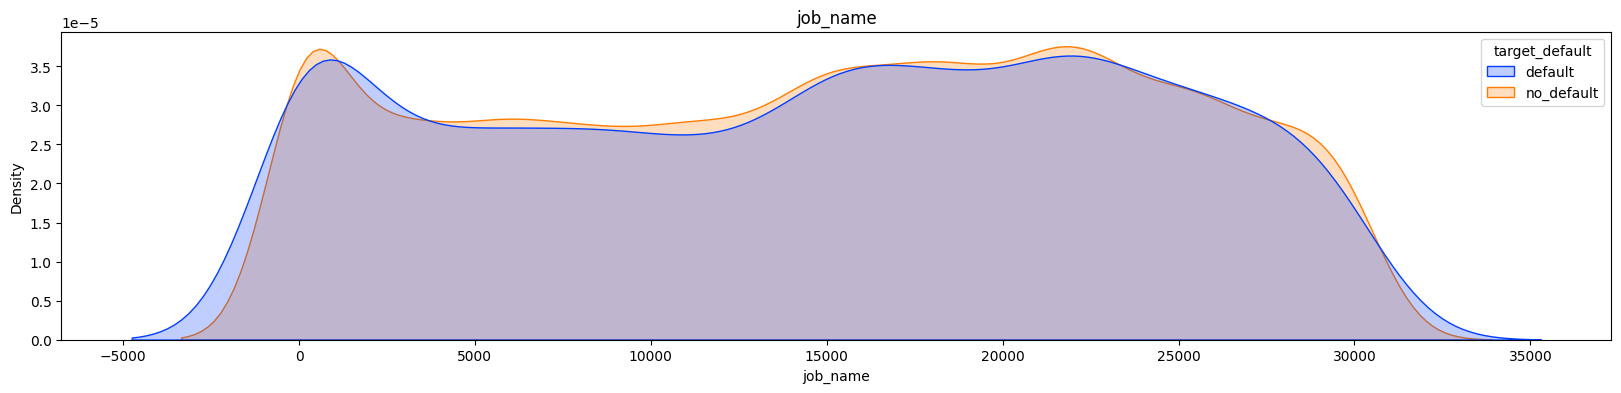

ddd


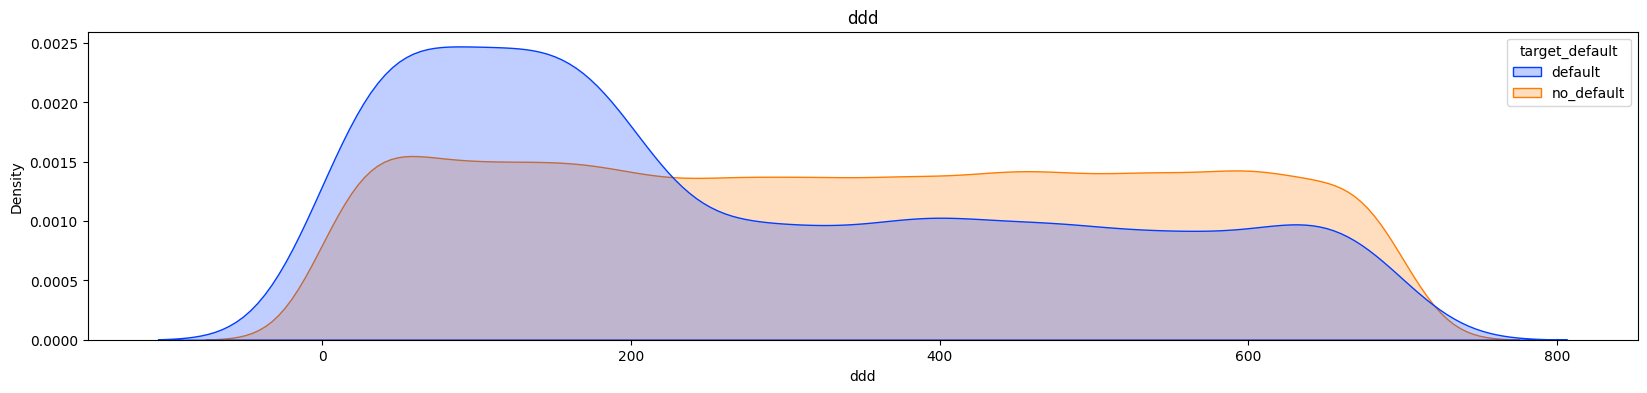

score_1


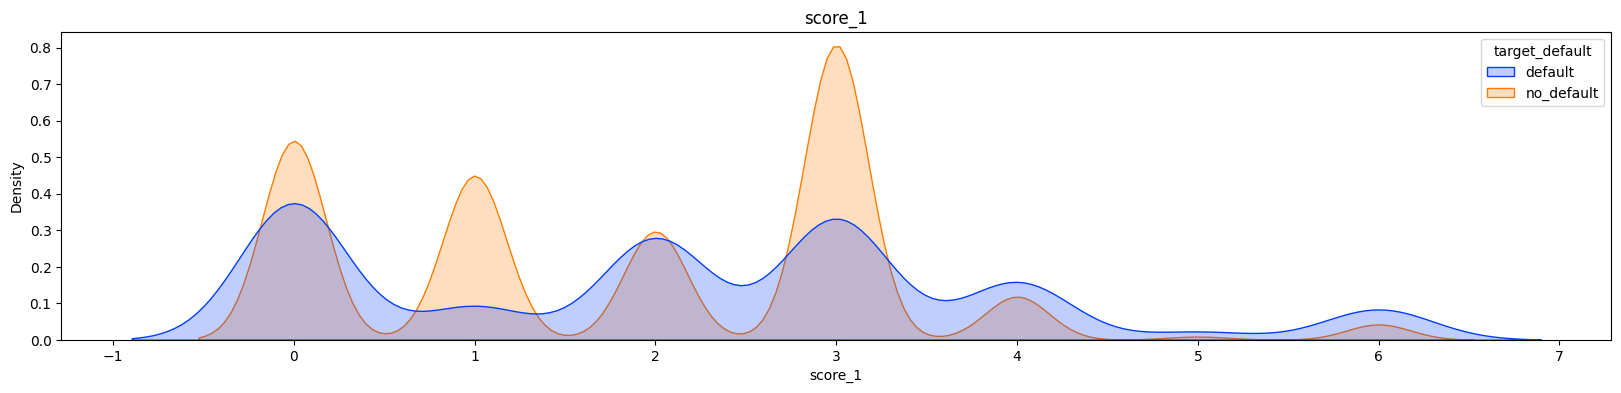

marketing_channel


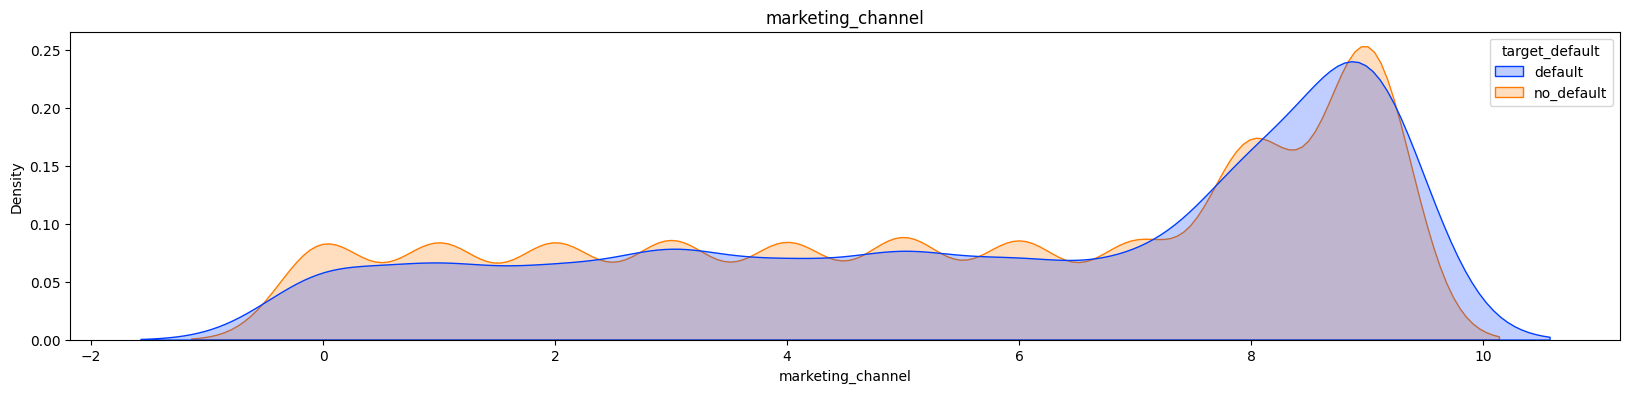

state


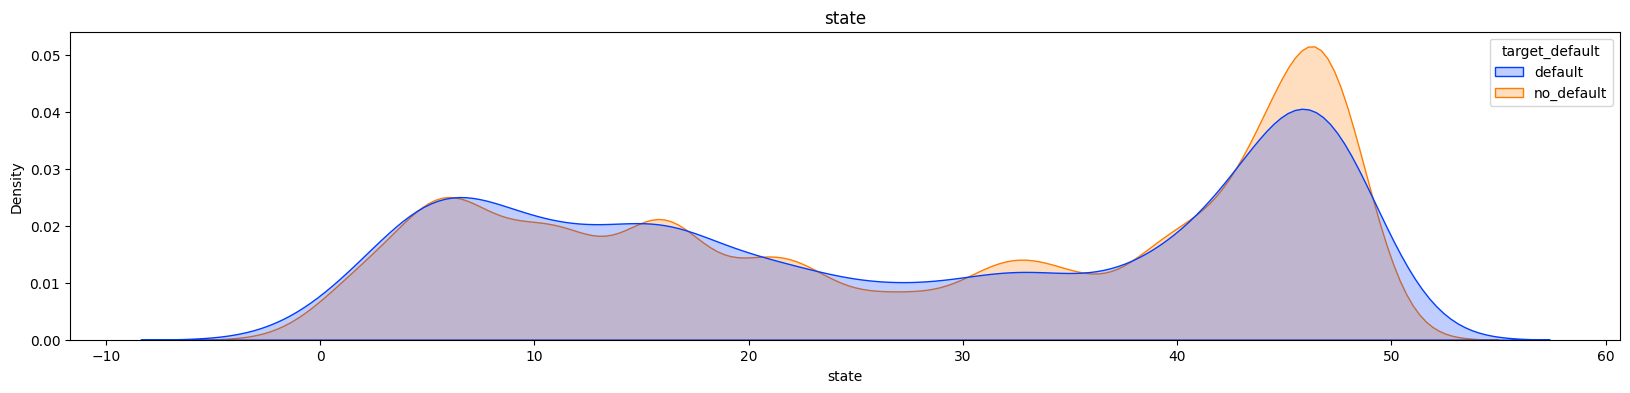

facebook_profile


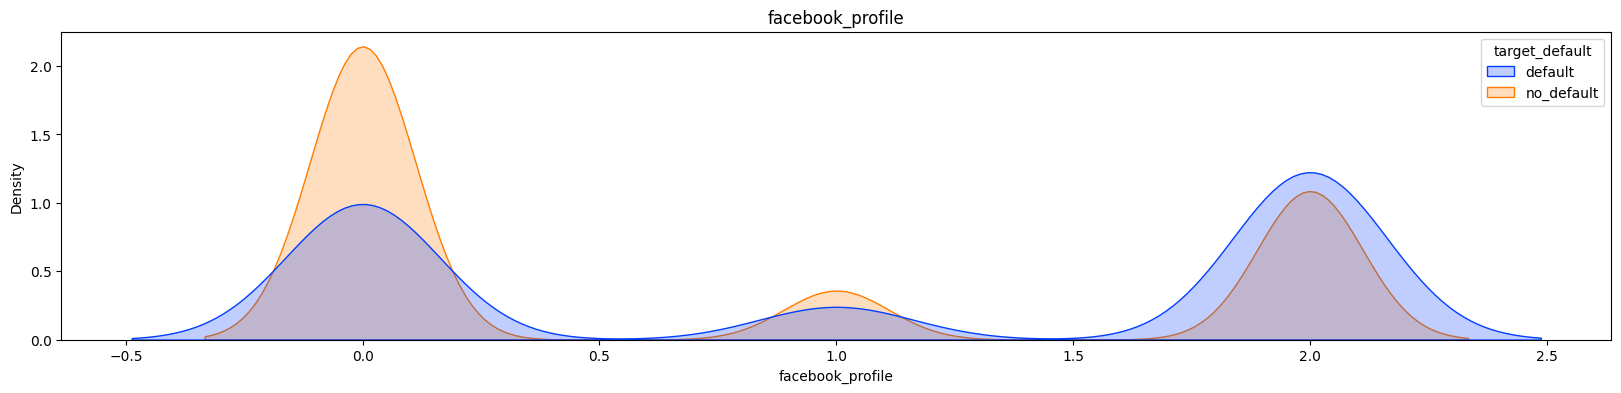

email


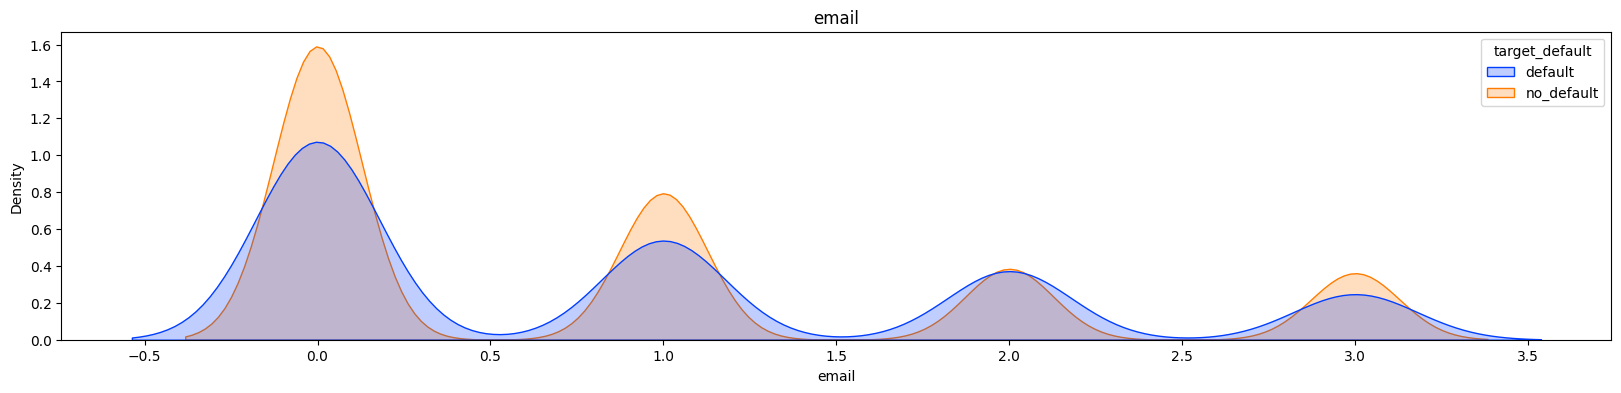

reason


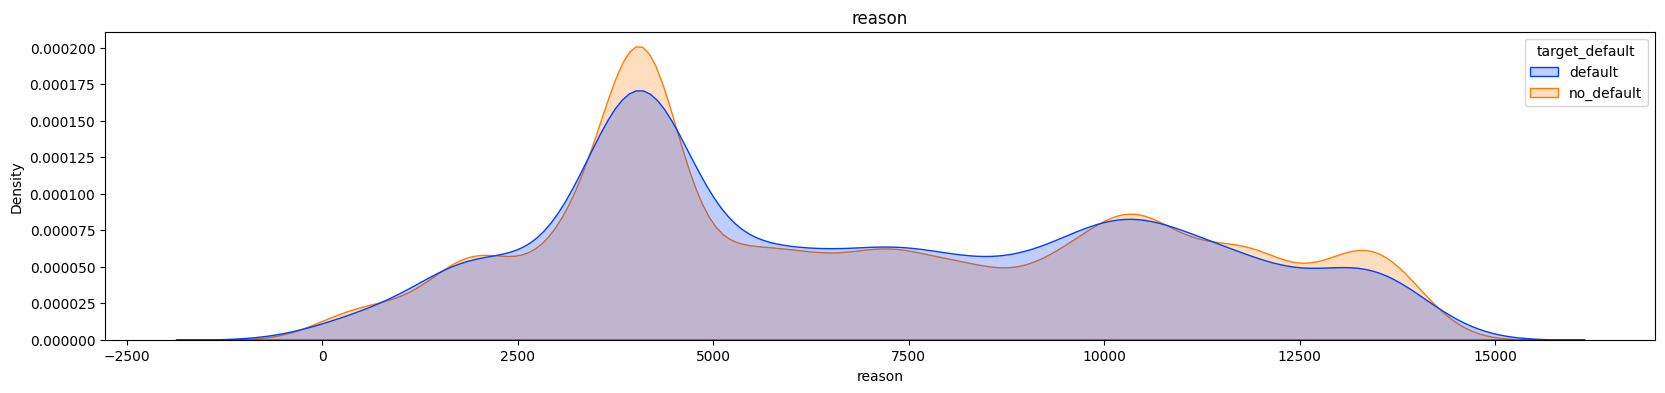

real_state


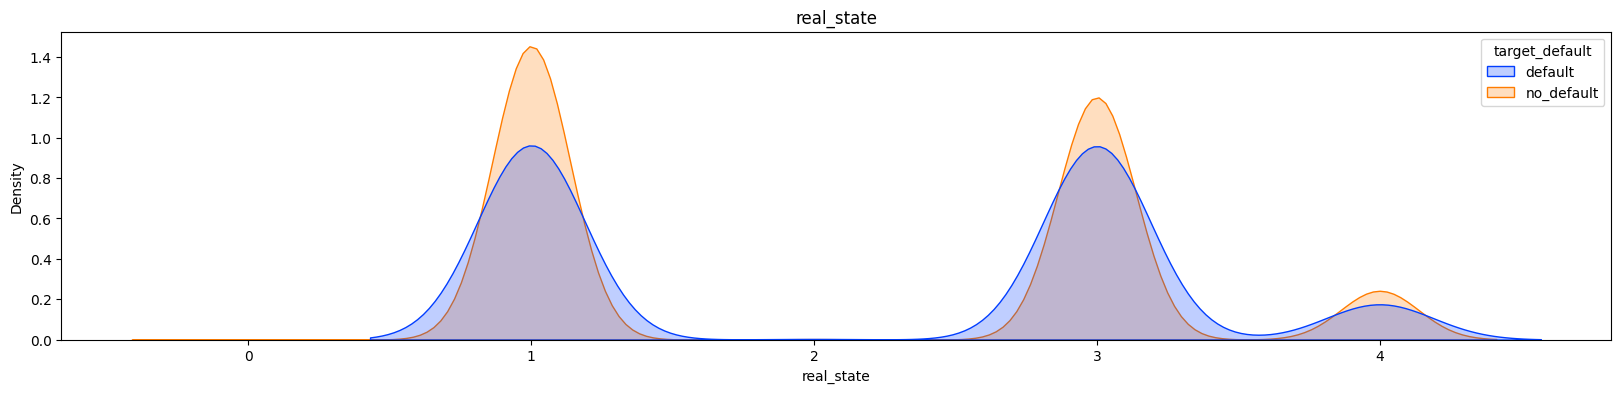

n_defaulted_loans


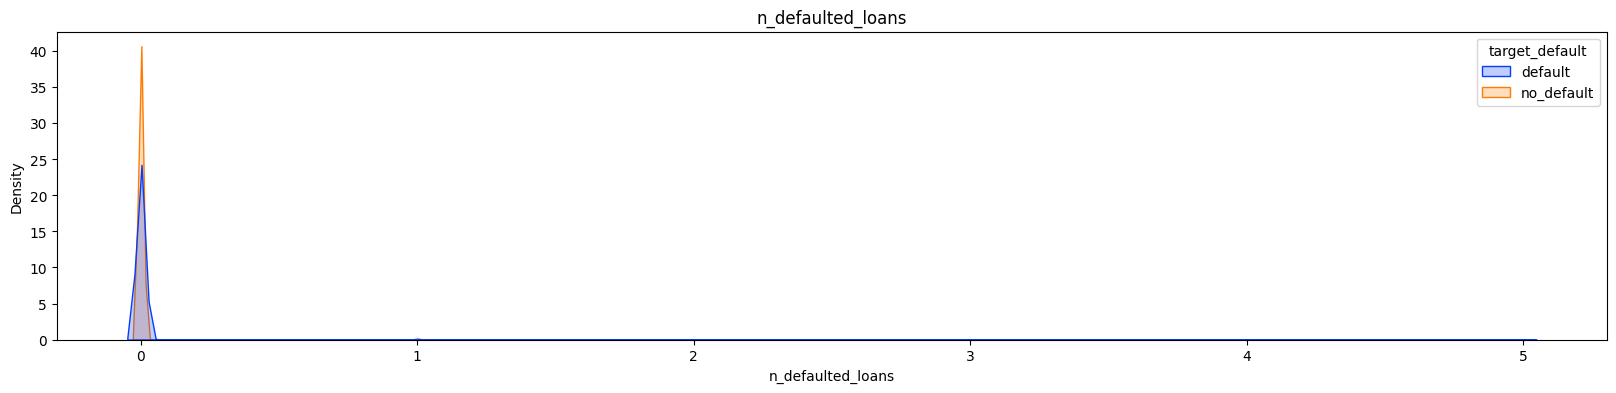

n_bankruptcies


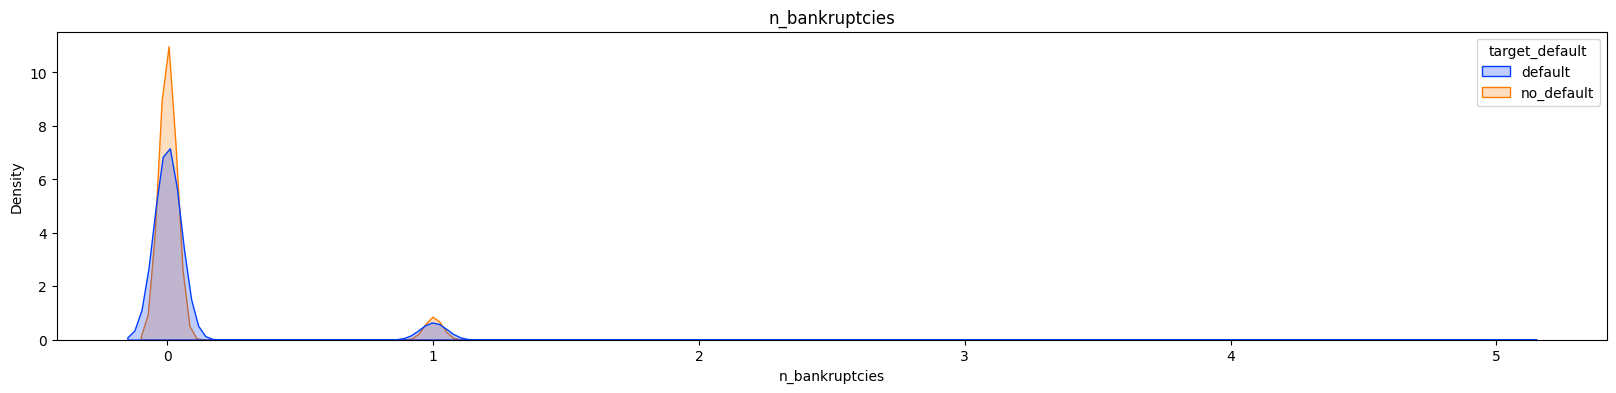

score_3


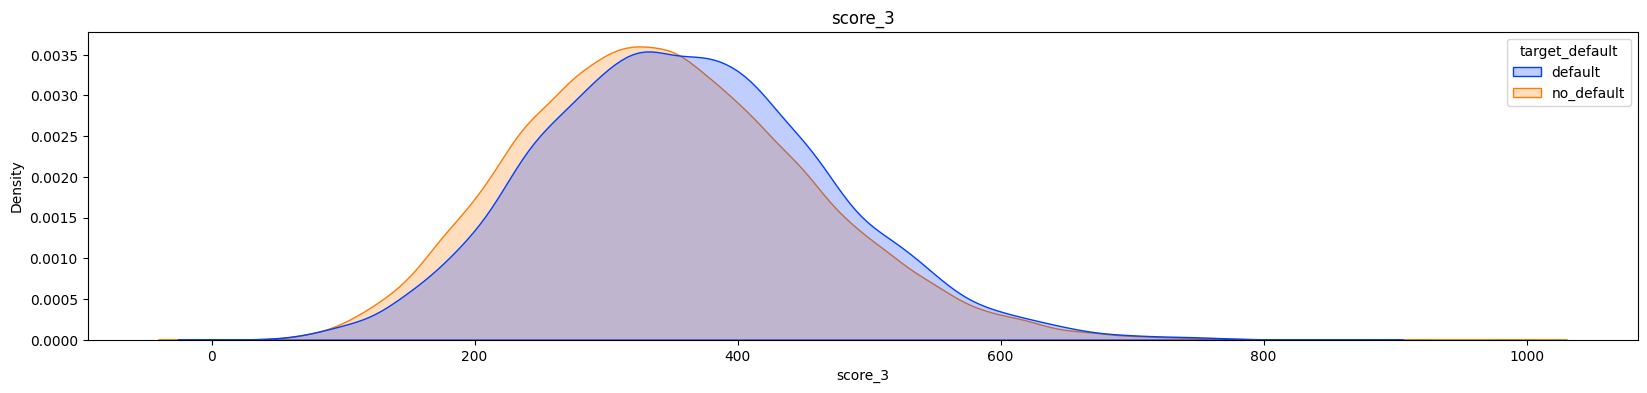

score_4


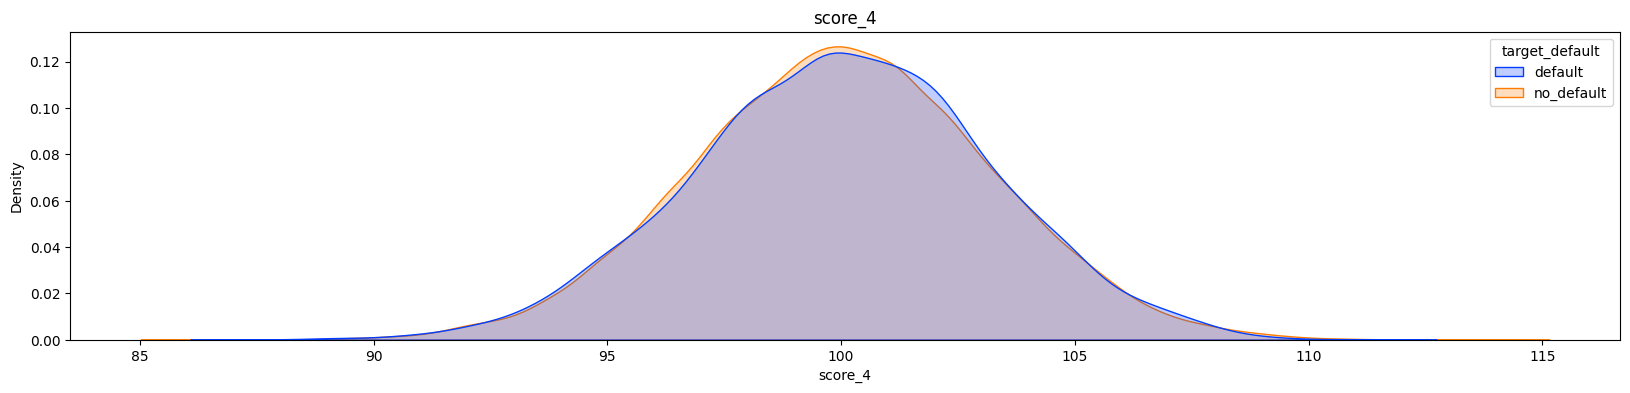

score_5


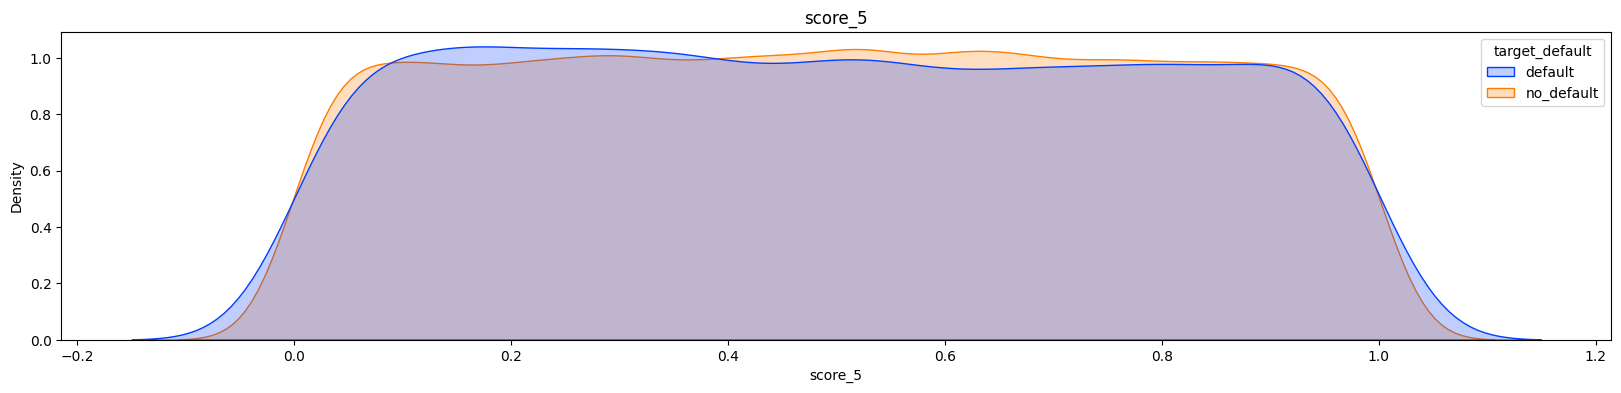

score_6


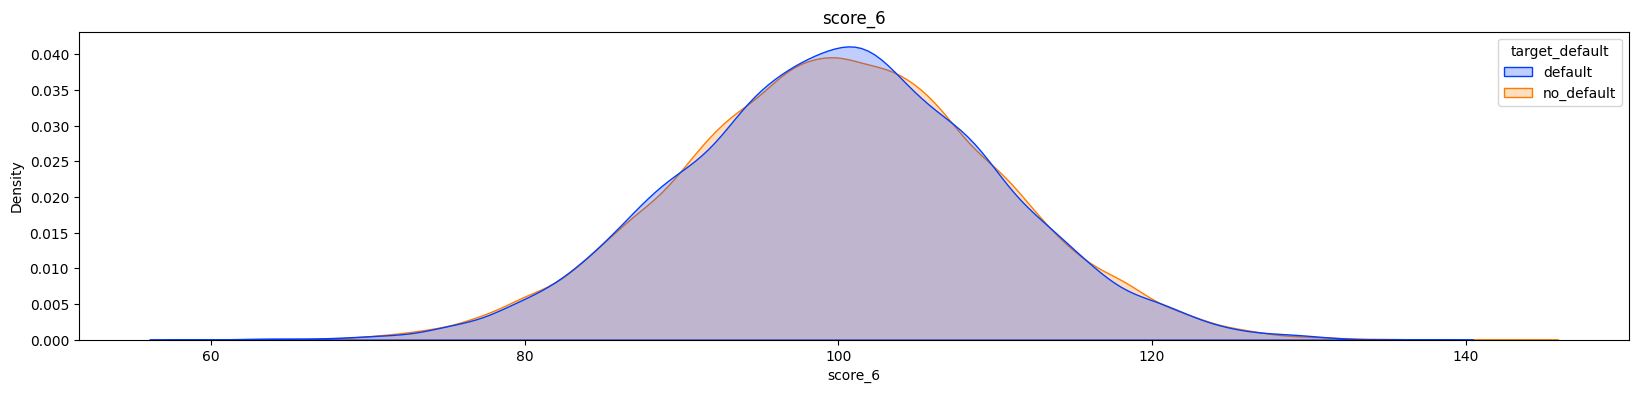

risk_rate


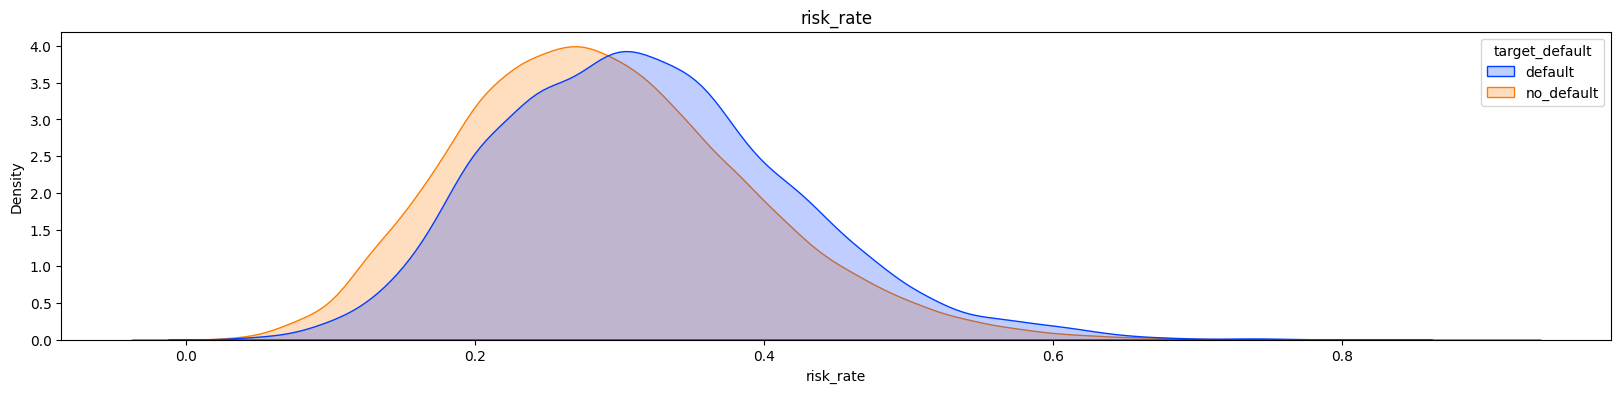

last_amount_borrowed


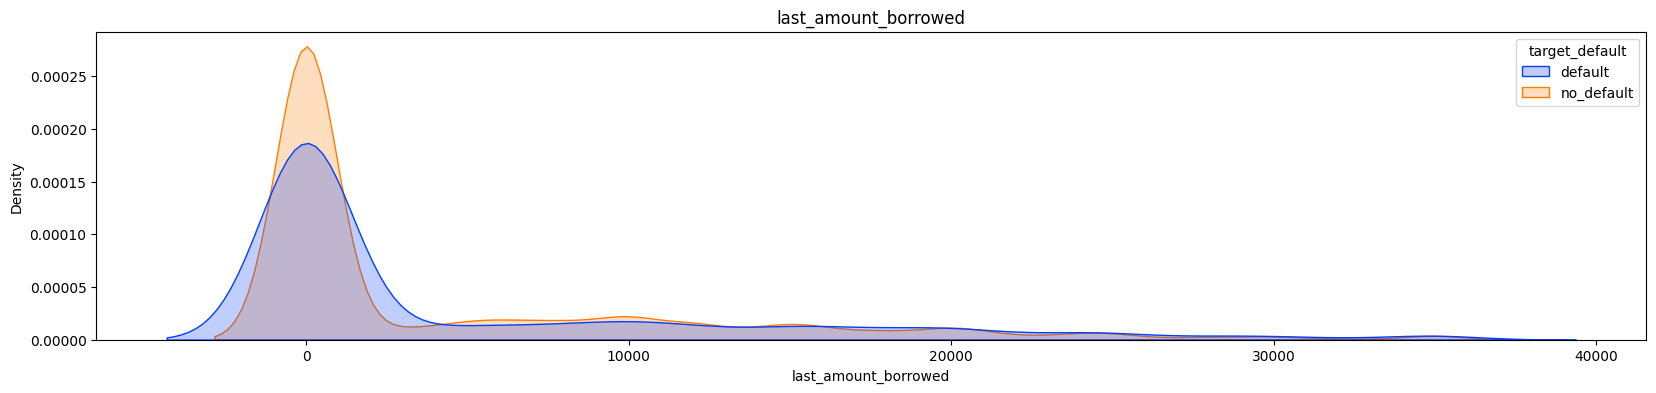

last_borrowed_in_months


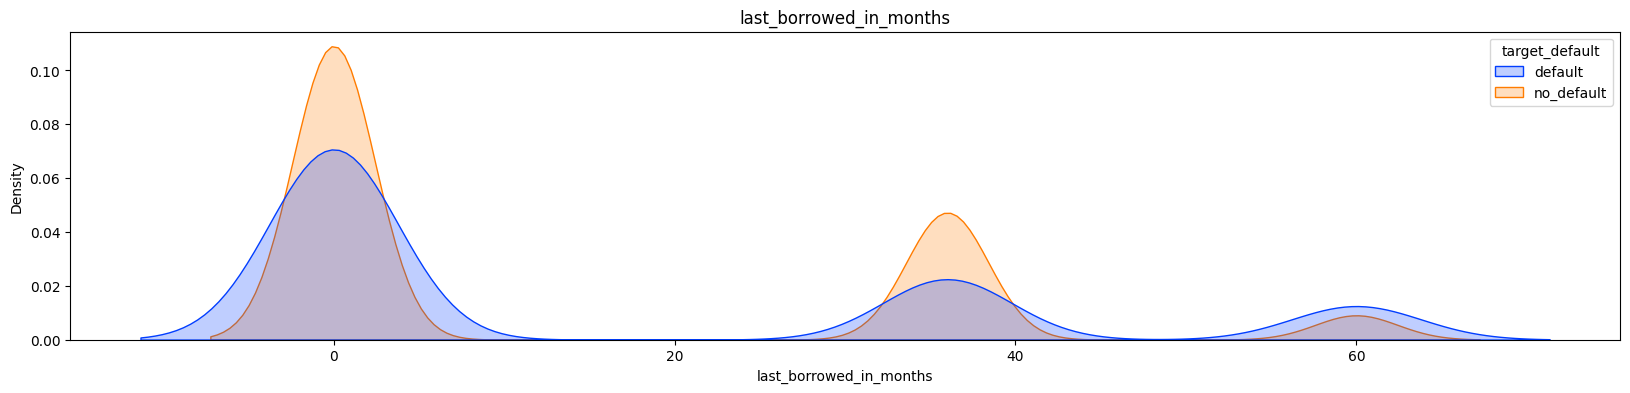

ok_since


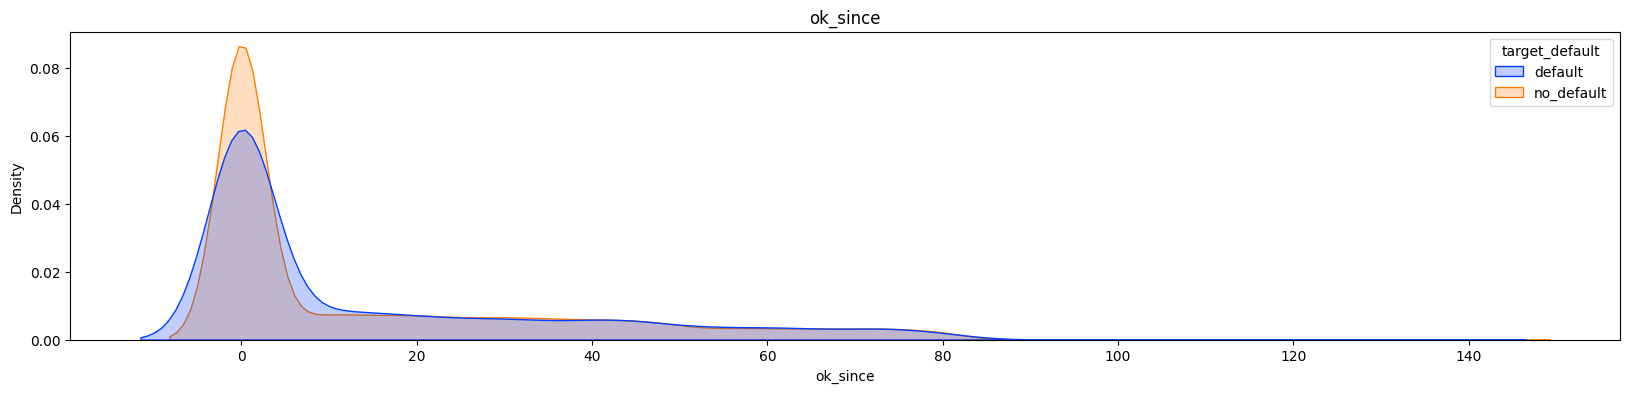

external_data_provider_email_seen_before


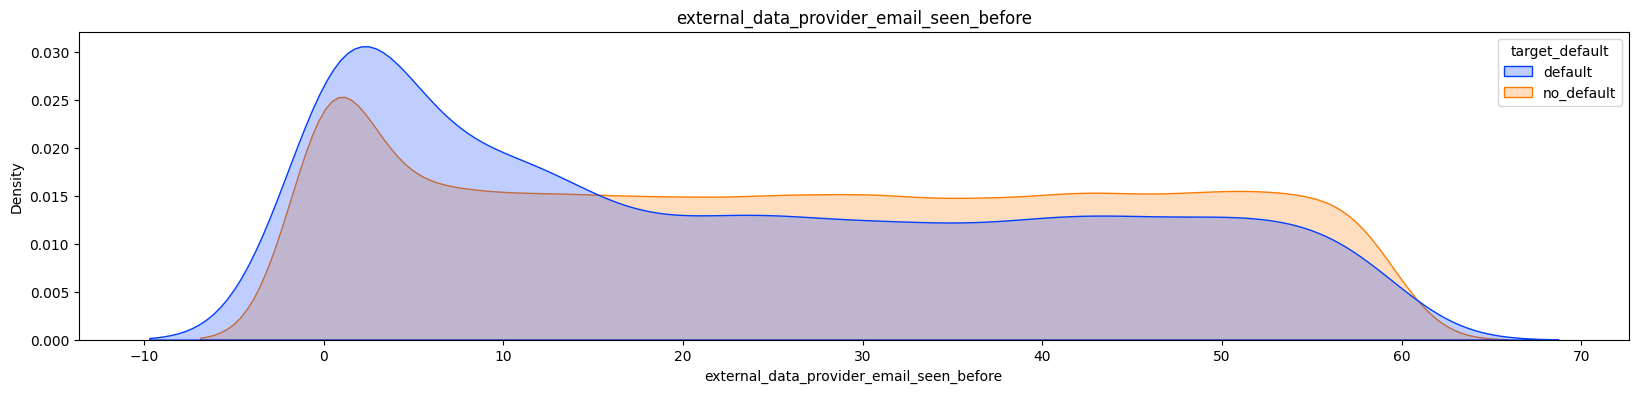

external_data_provider_fraud_score


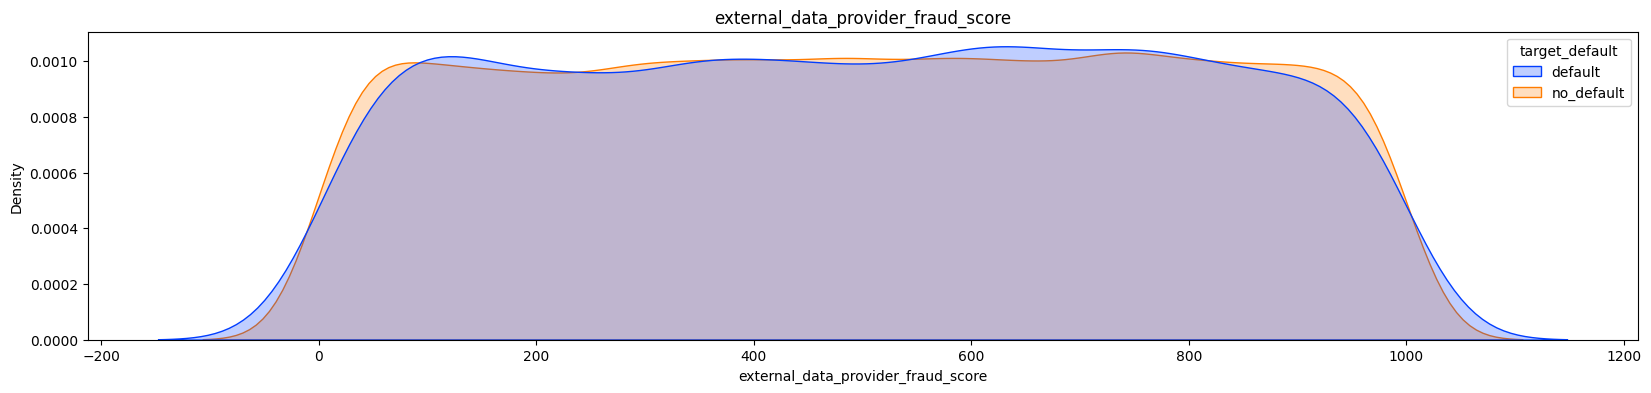

application_time_applied


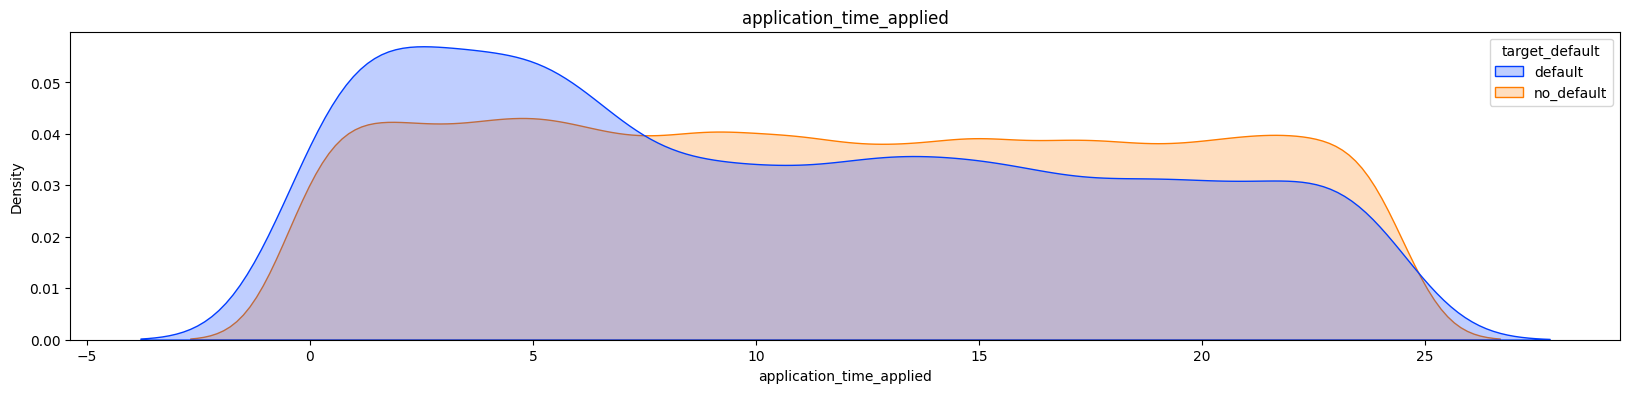

application_time_in_funnel


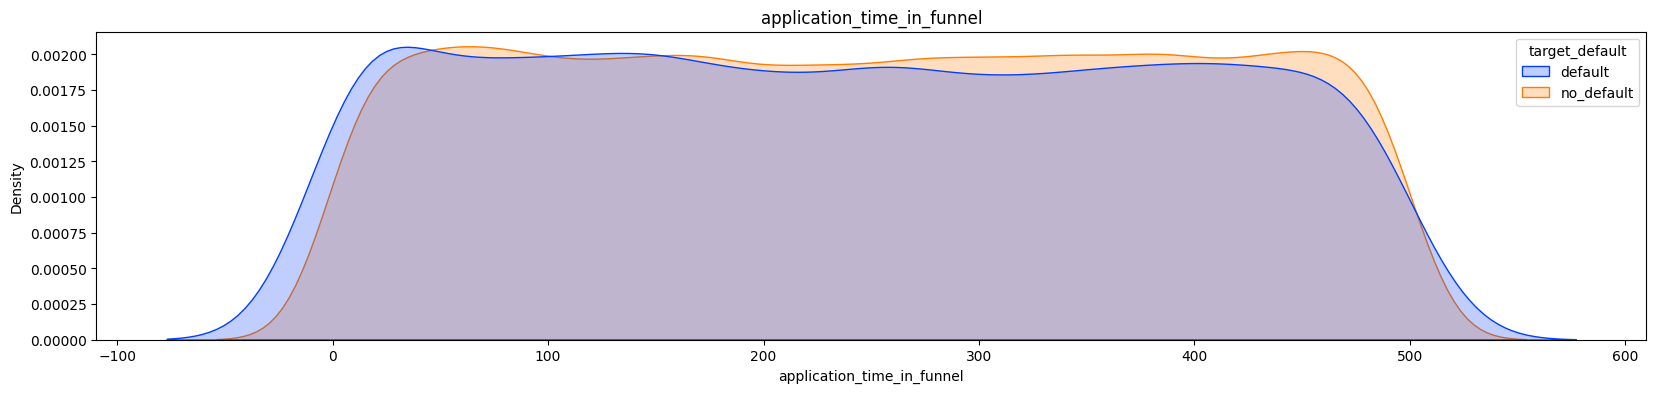

n7


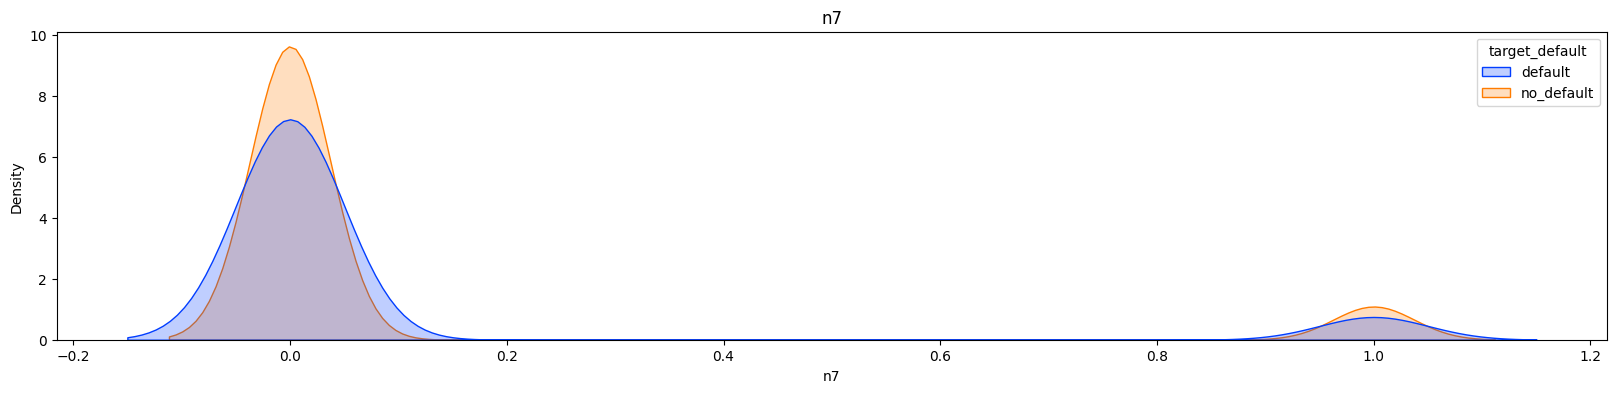

n4


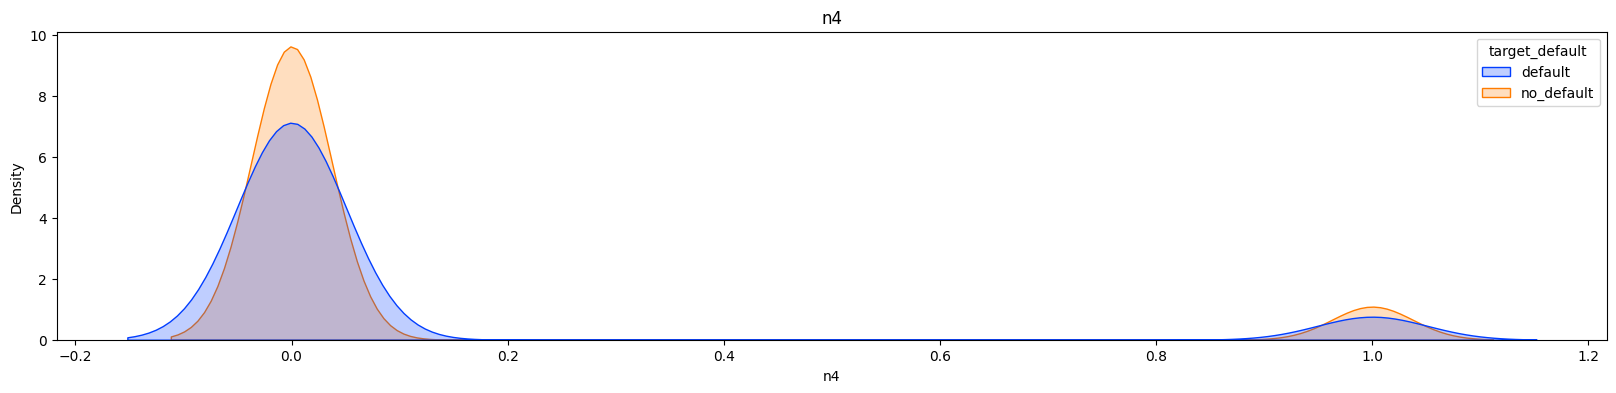

n12


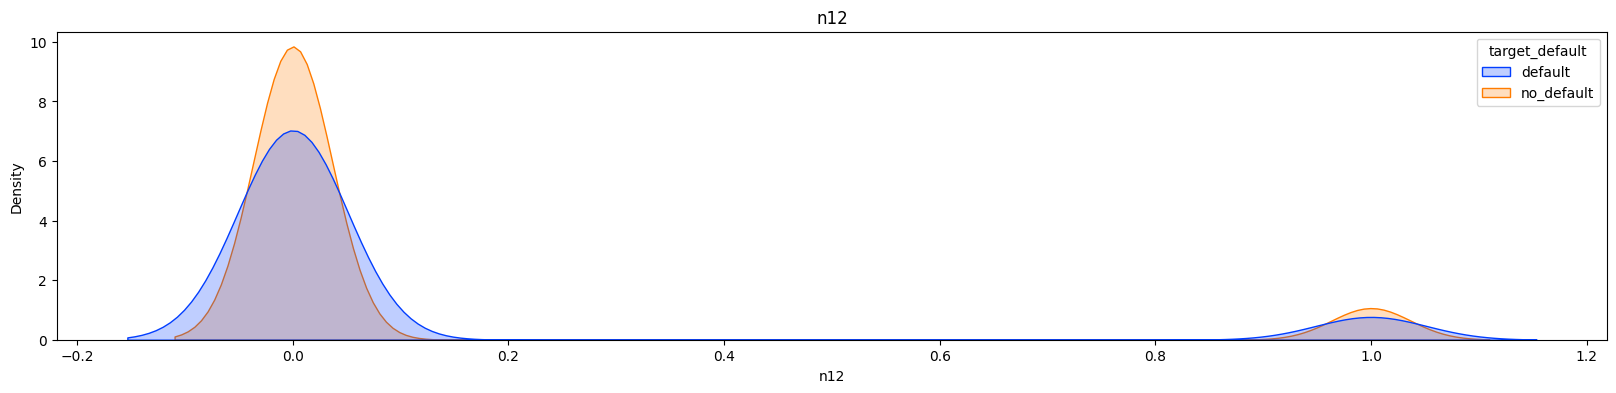

n17


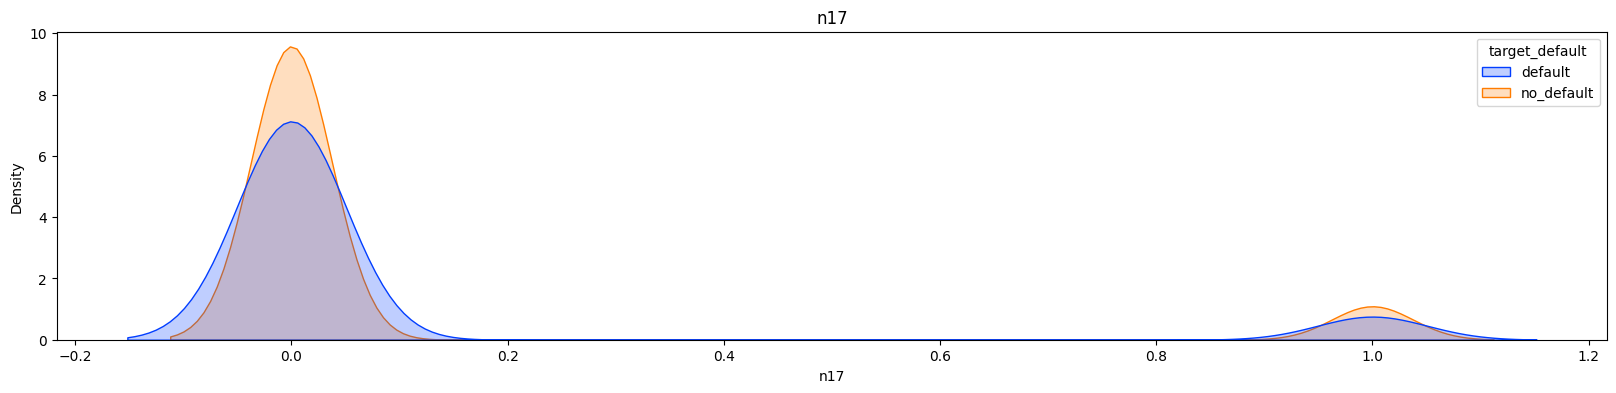

n8


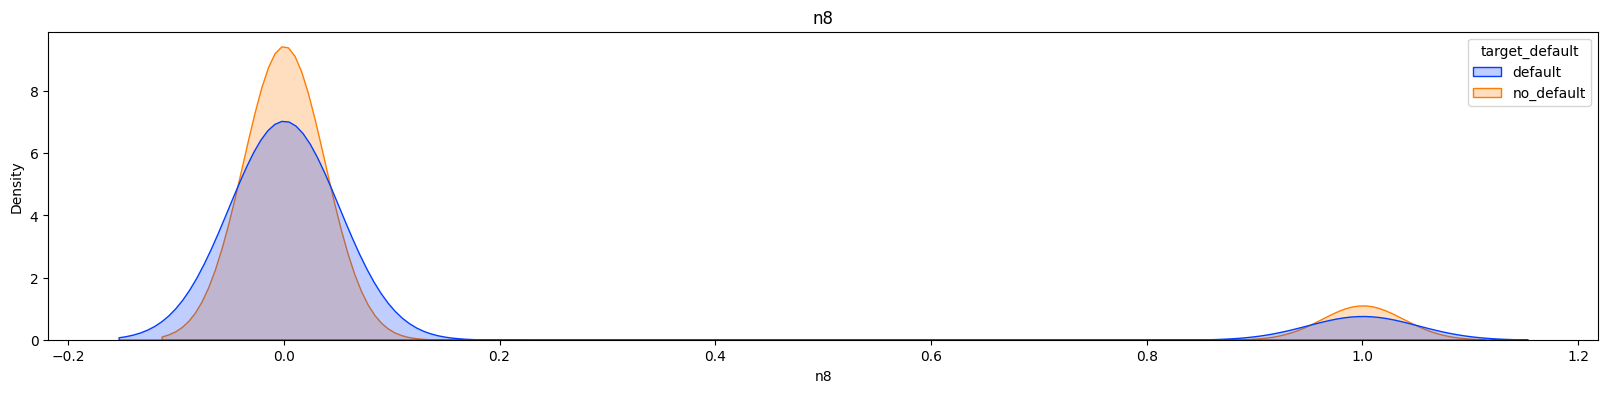

n0


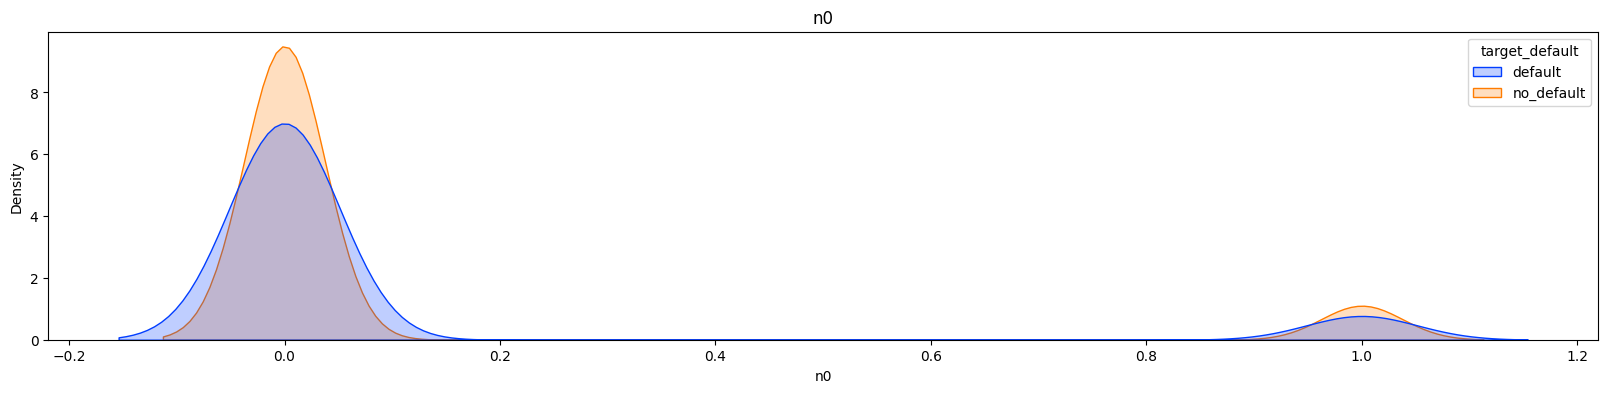

n13


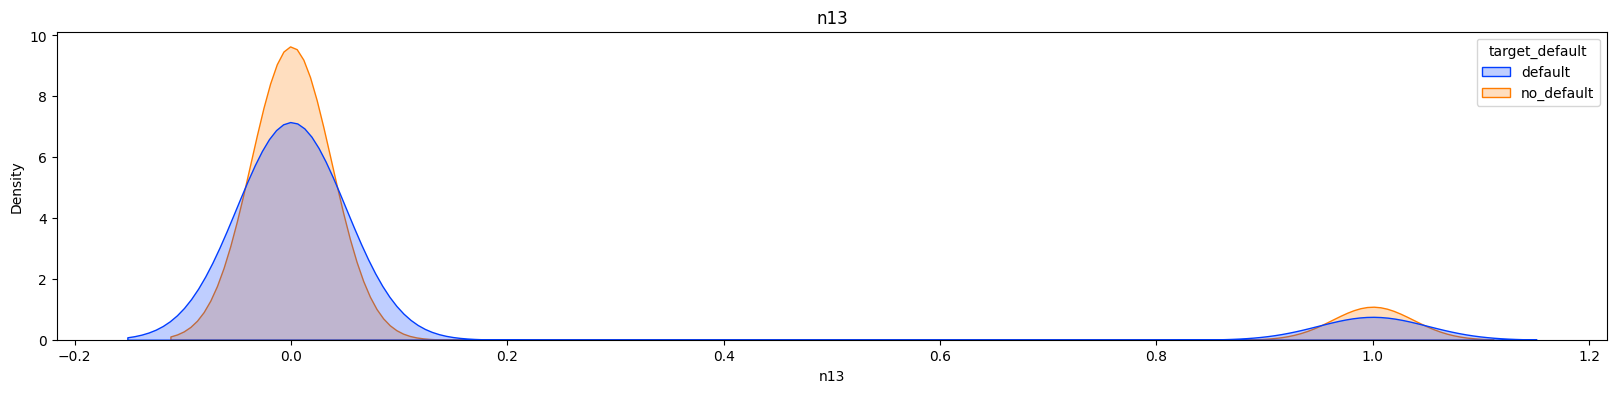

n16


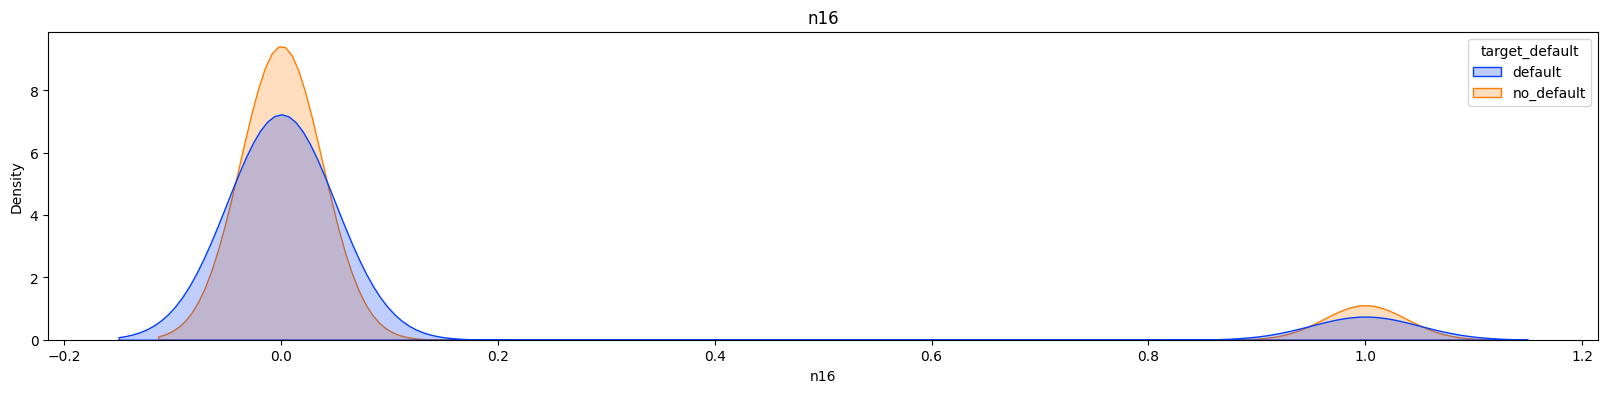

n11


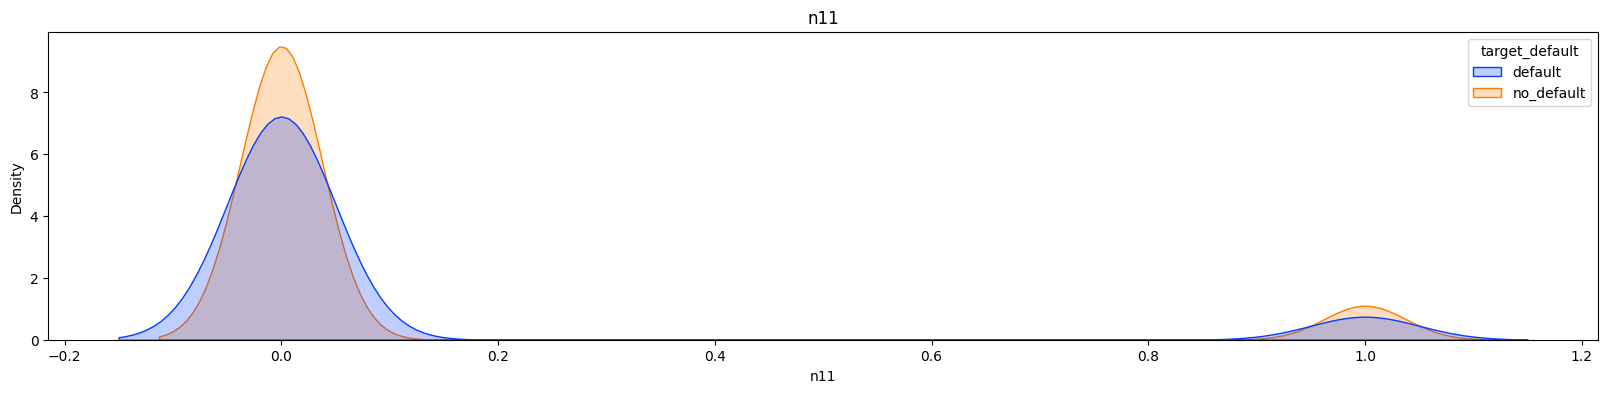

aty


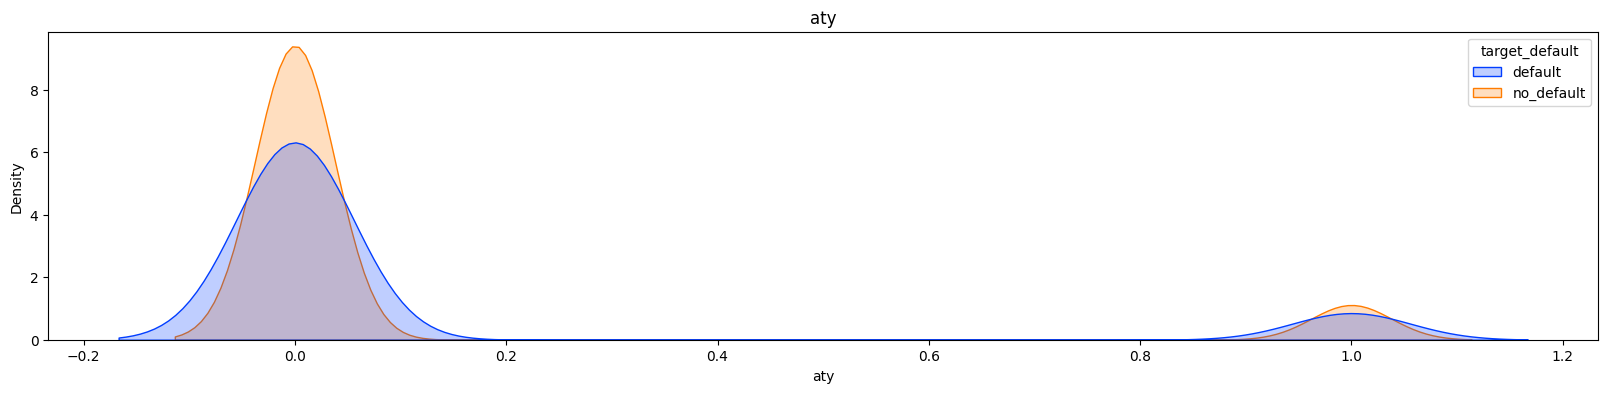

n18


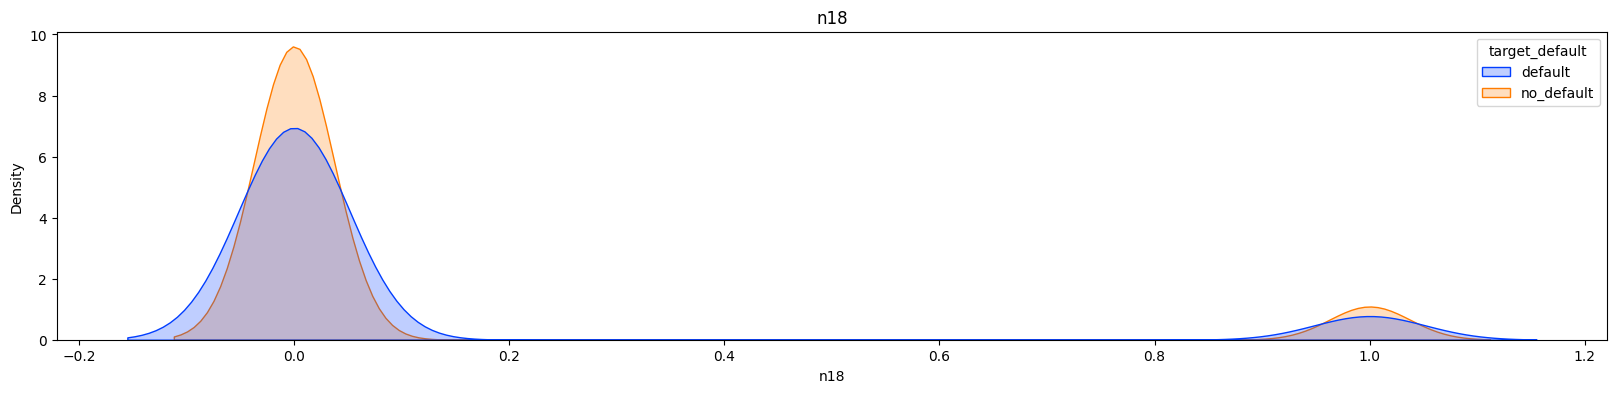

n3


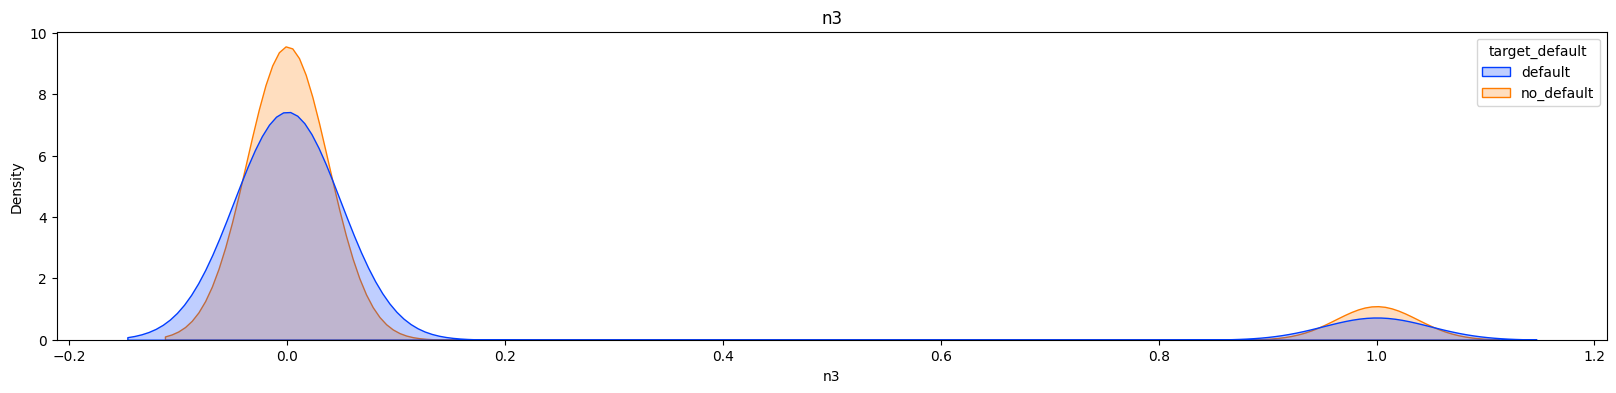

nim


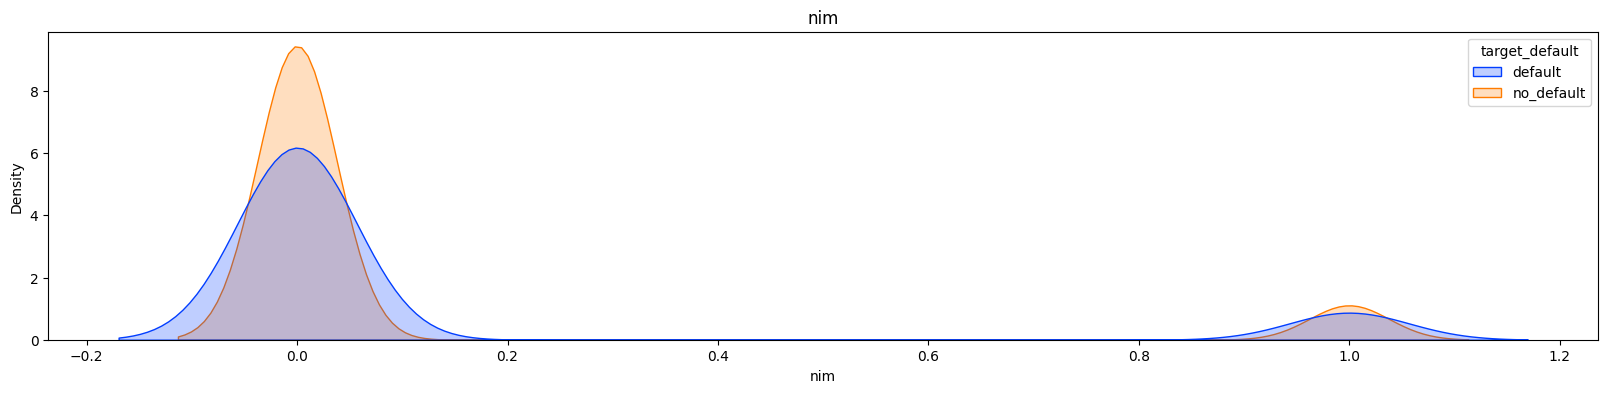

n6


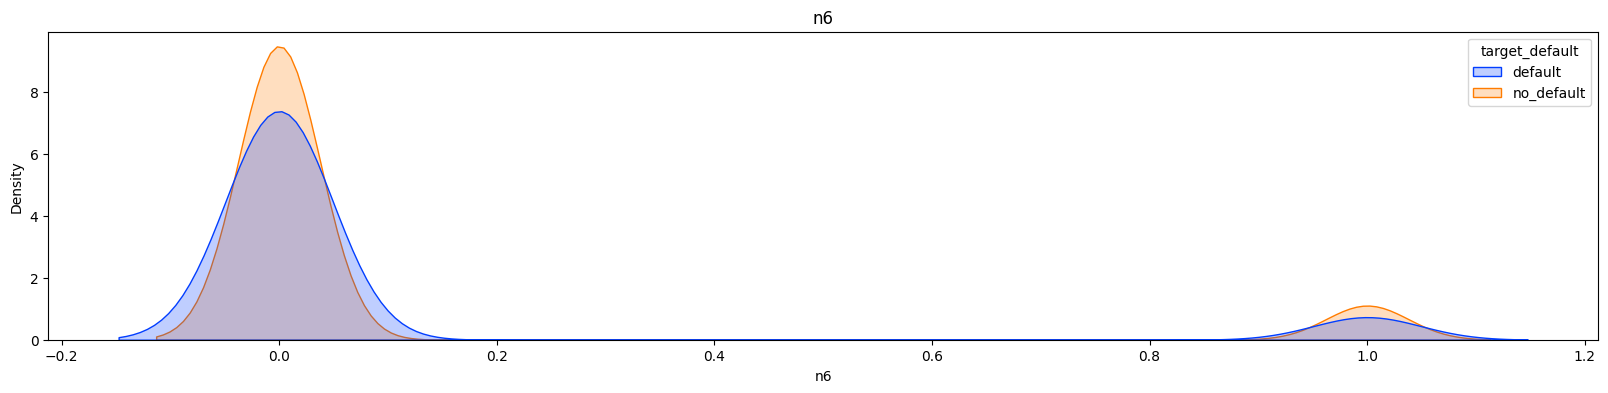

pro+aty


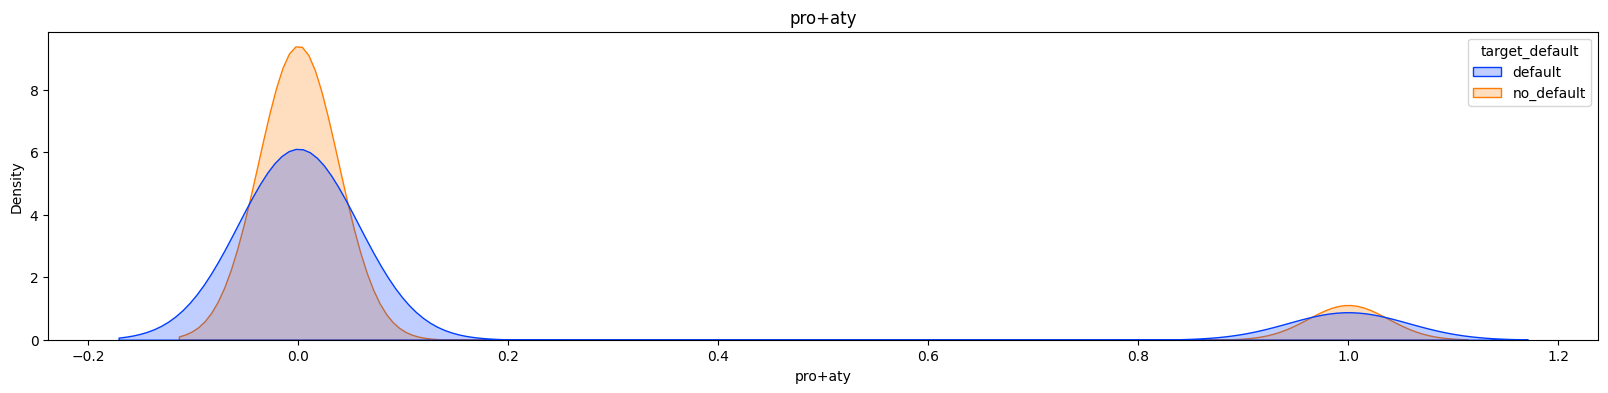

n5


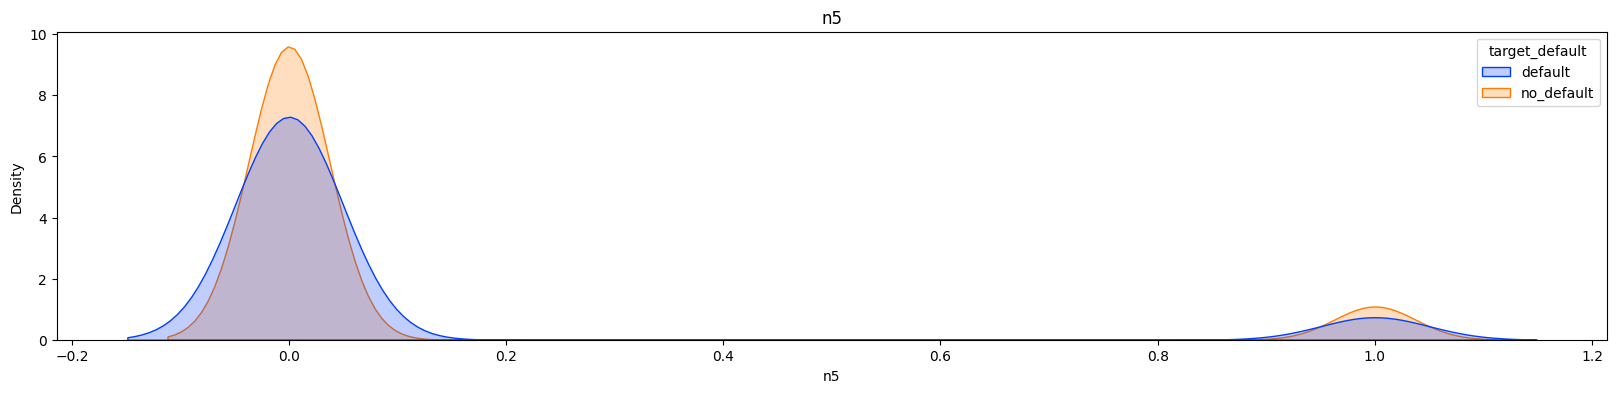

c1


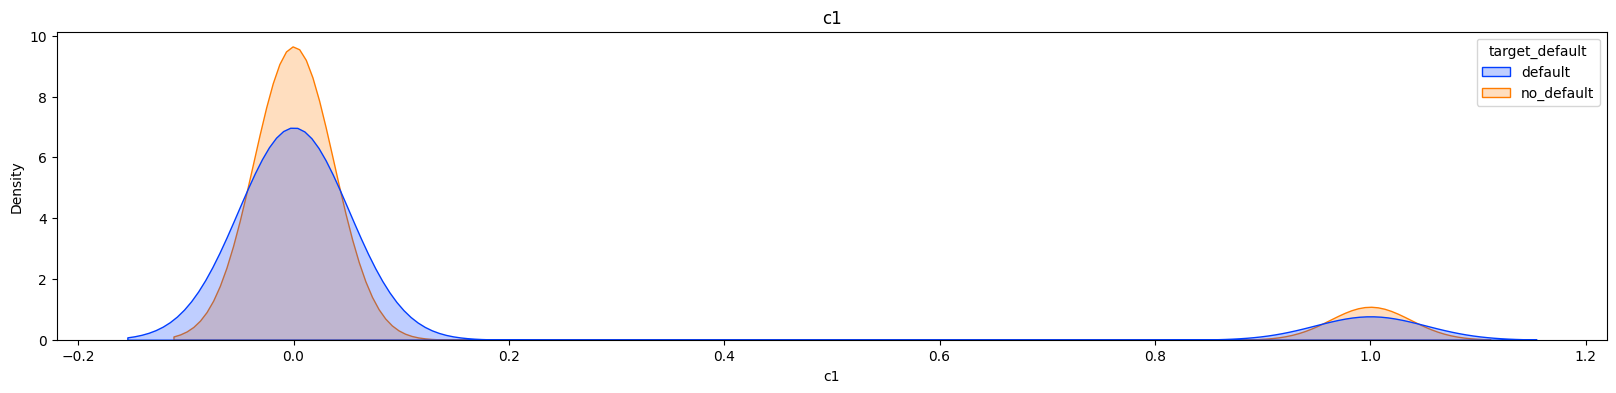

n2


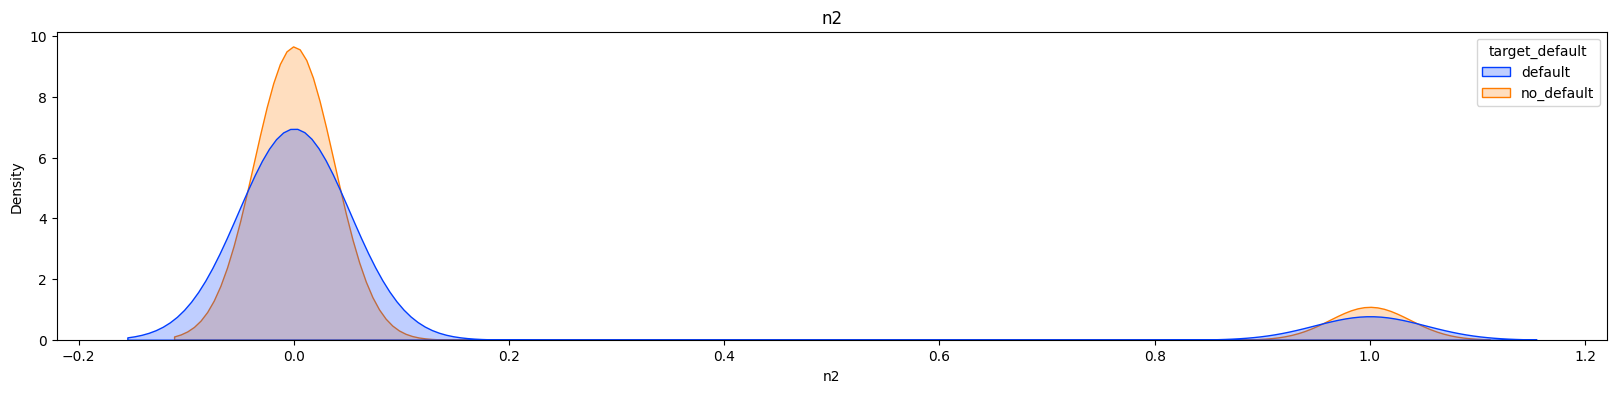

b19


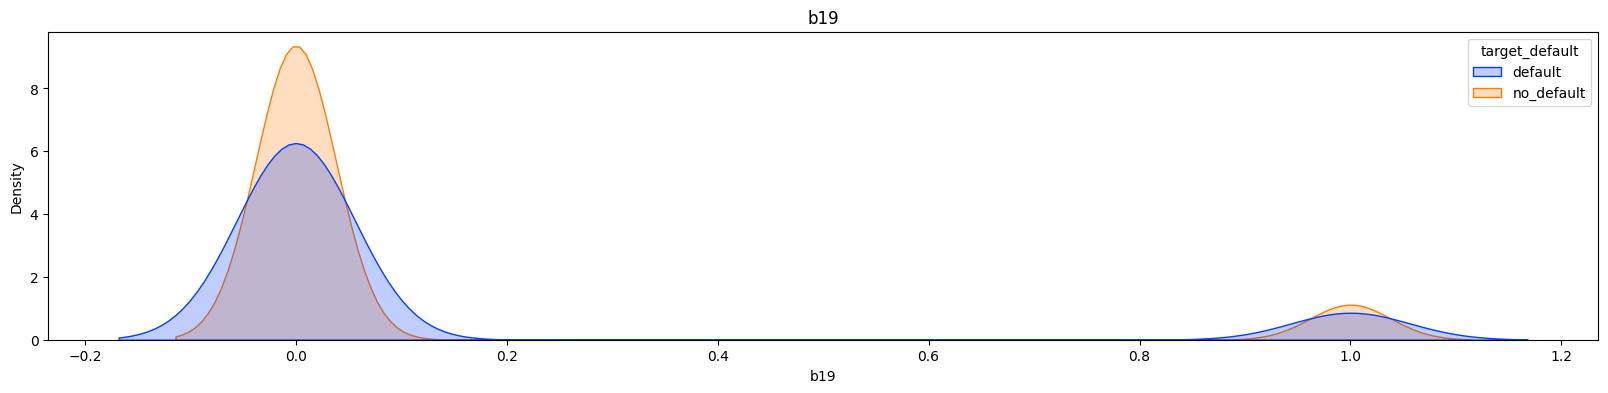

n15


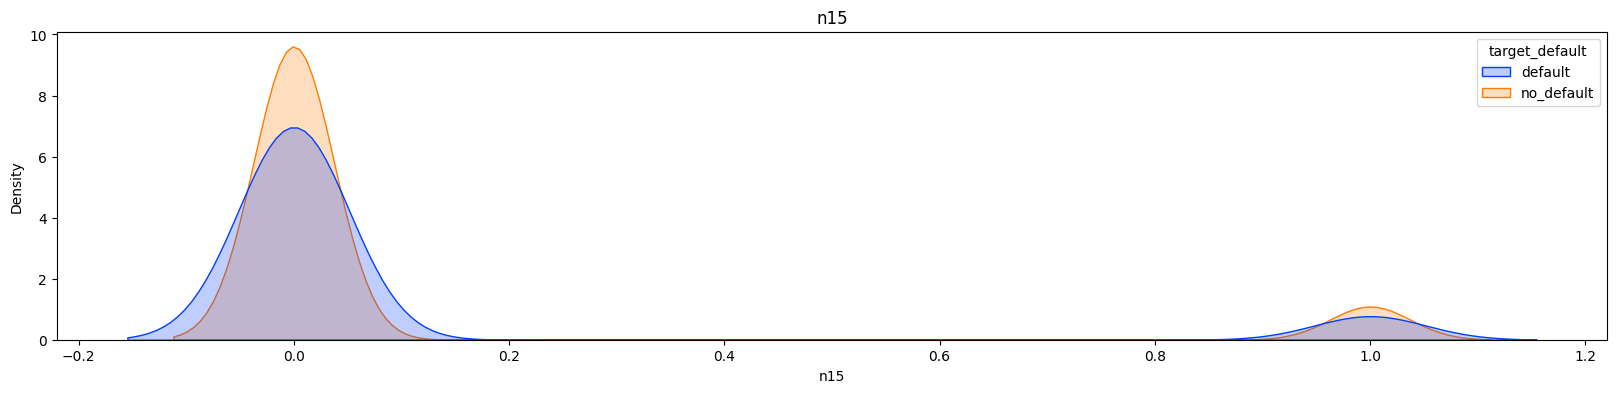

dfa


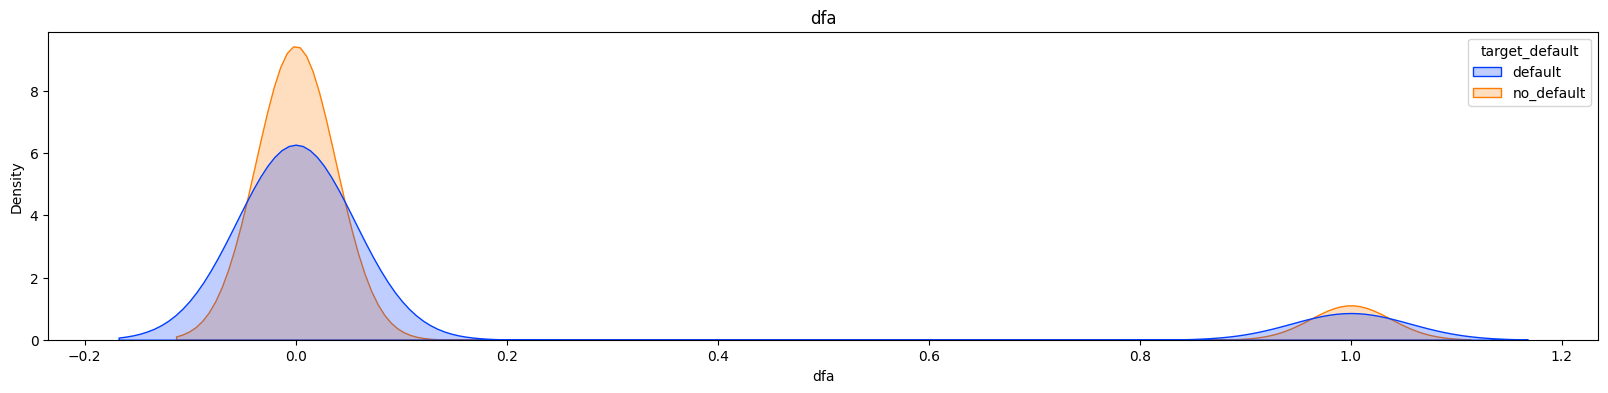

n1


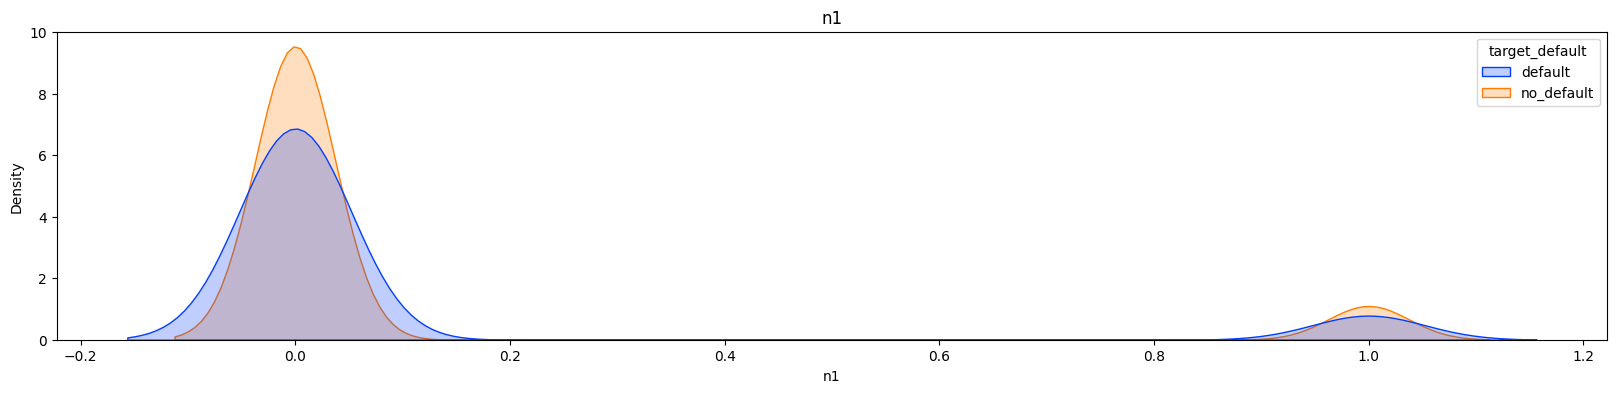

n10


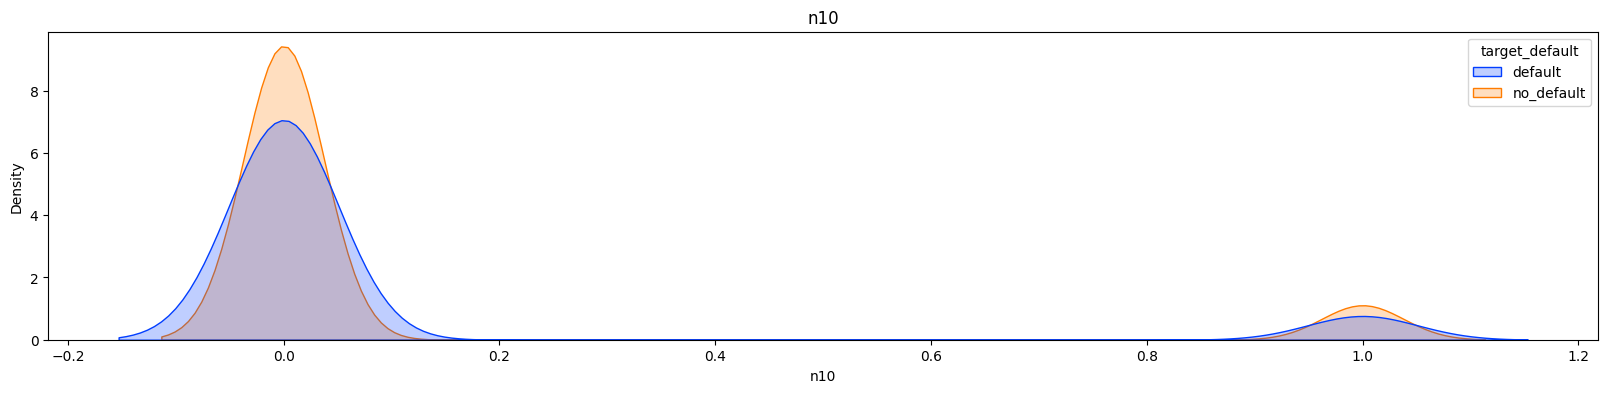

n14


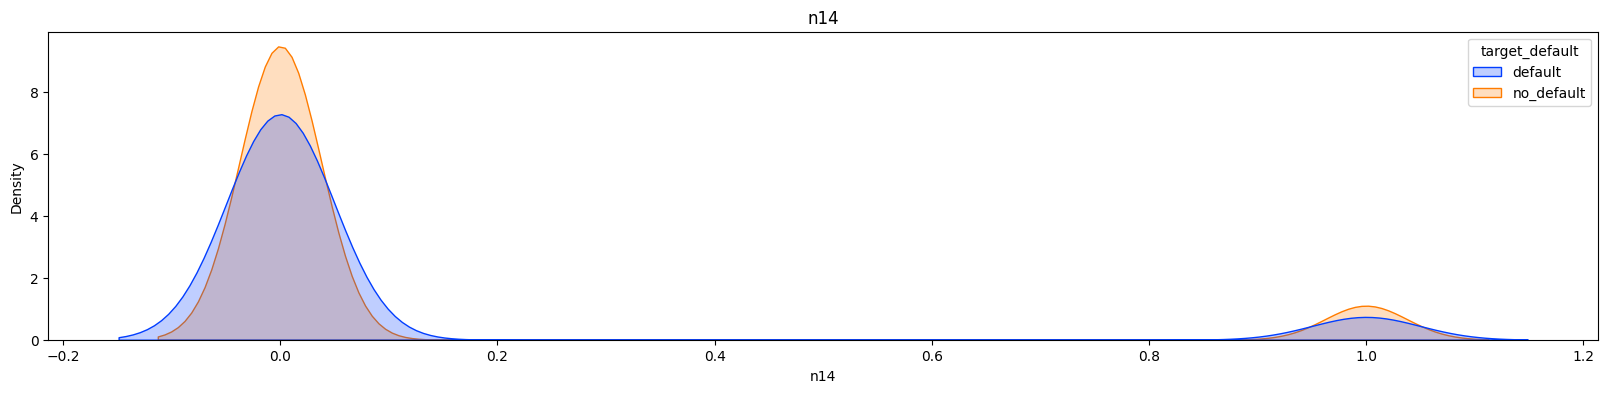

n9


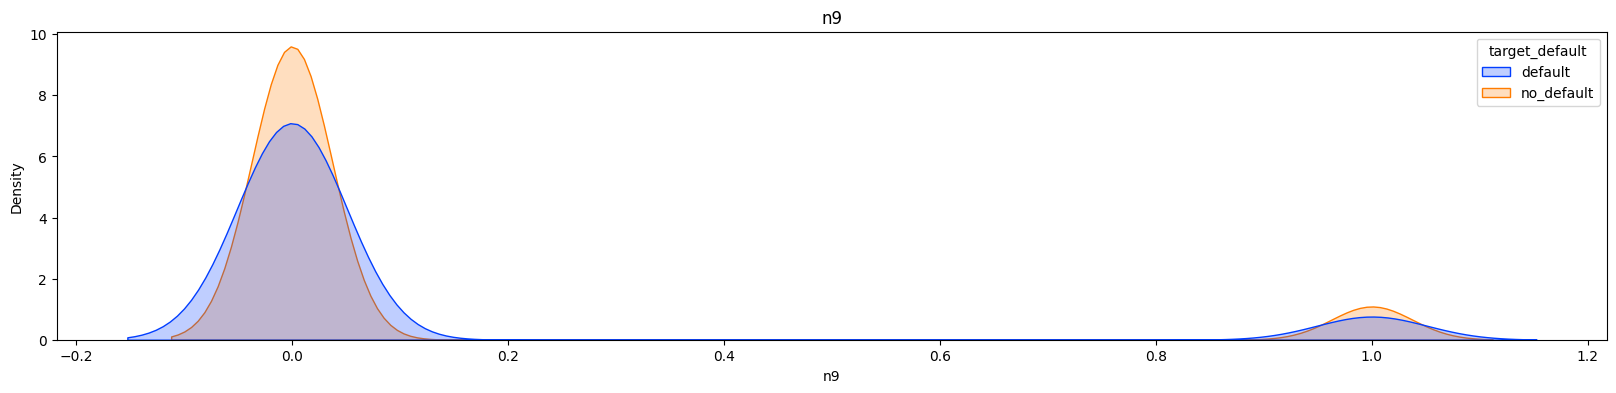

da


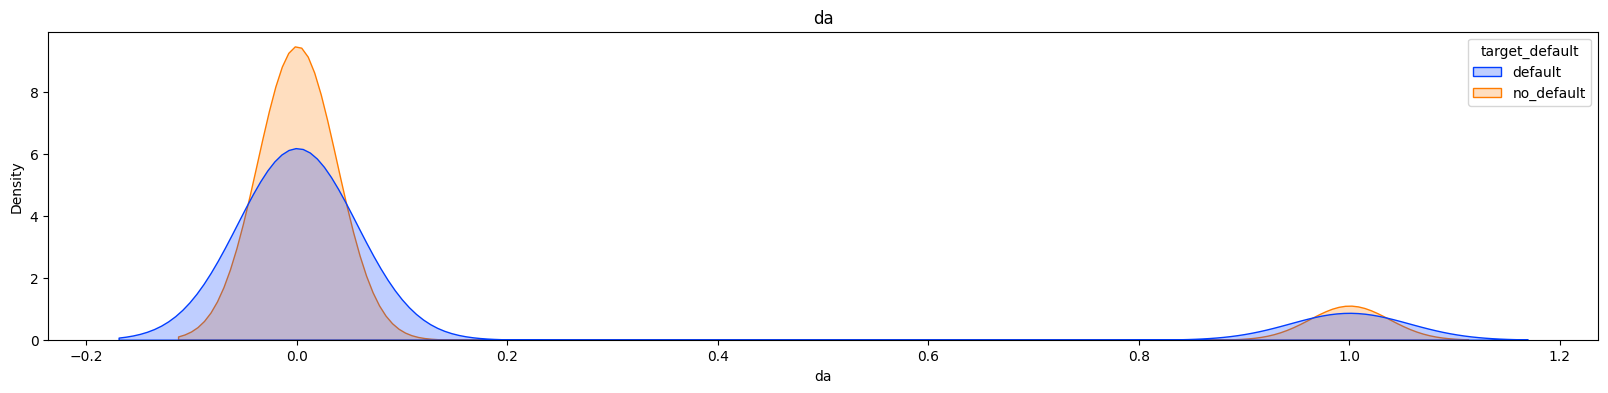

n19


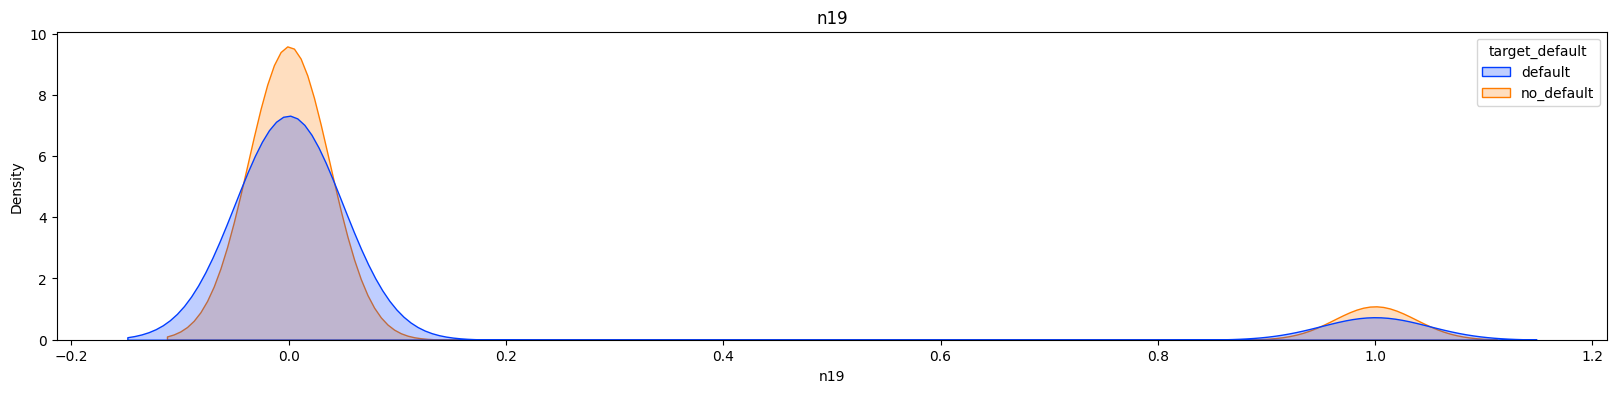

c55


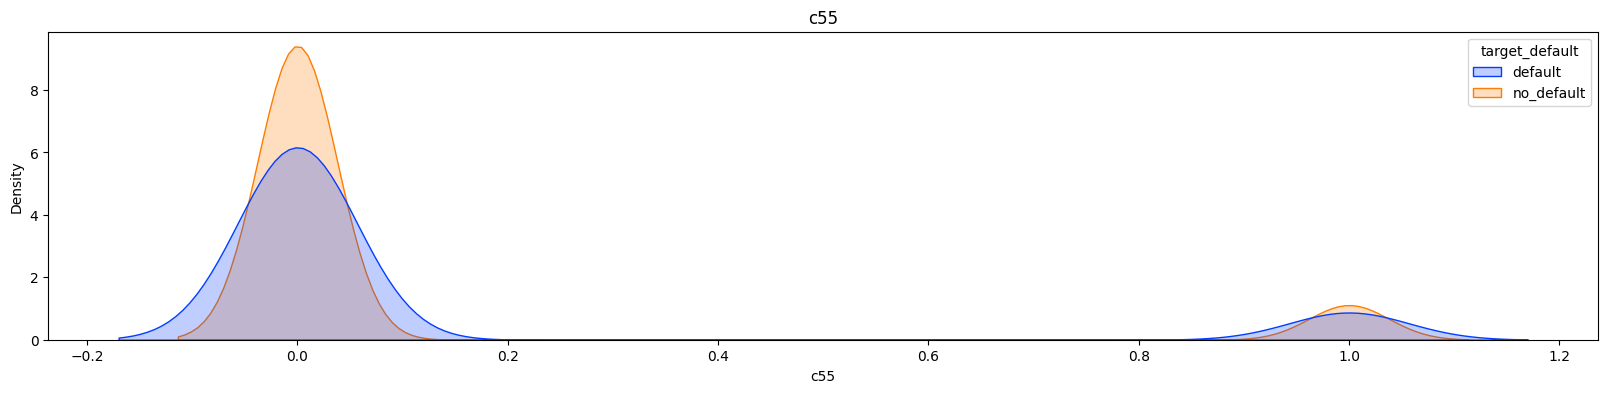

a15


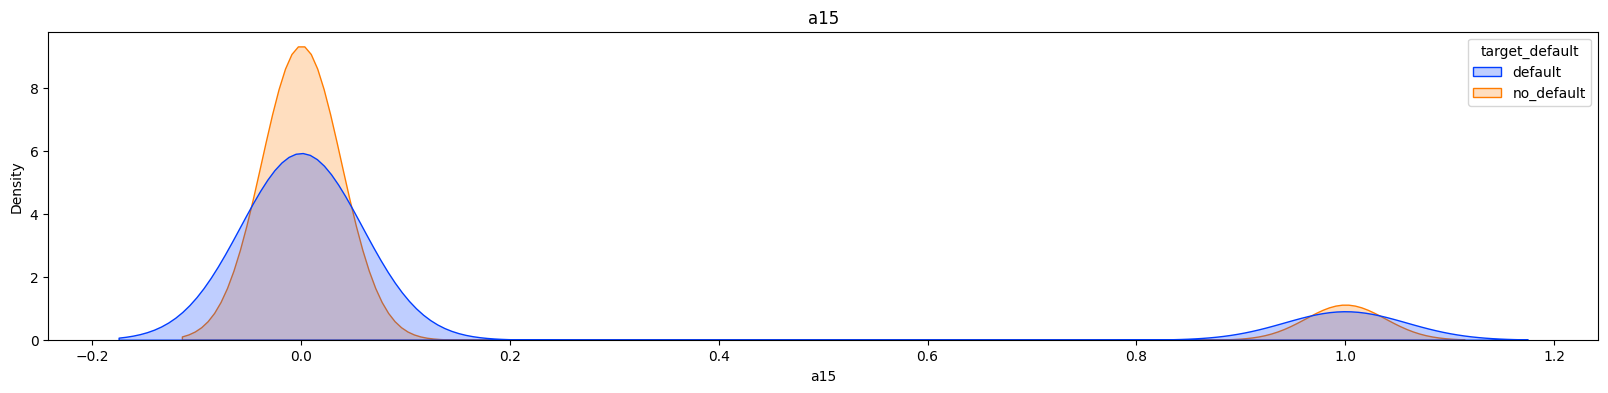

income_diff


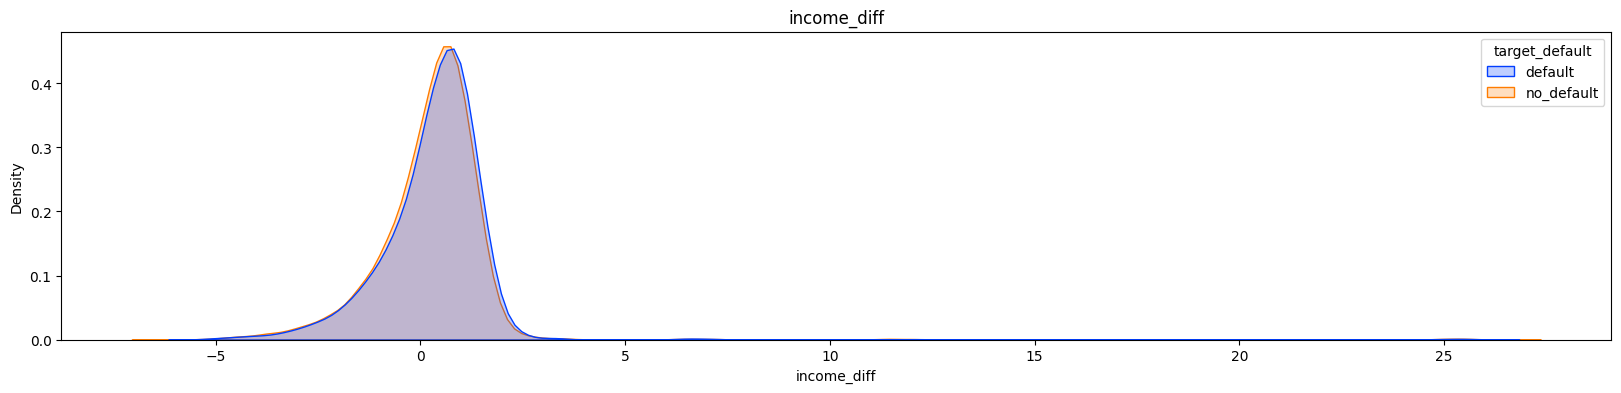

In [96]:
df_clean['target_default'] = y_hat.map({0:'no_default', 1:'default'})

for name in df_clean.columns[:-1]:
  print(name)
  fig, axes = plt.subplots(1, 1, figsize=(20, 4))
  ax = axes

  sns.kdeplot(data=df_clean[[name, 'target_default']], x=name, ax=ax,
               hue='target_default', hue_order=['default','no_default'], shade=True, palette='bright', common_norm=False)
  ax.set_title(name)

  plt.show()

df_clean.drop('target_default',axis=1, inplace=True)

## Decision Tree

Note que a árvore de decisão dá maior peso para as features `facebook_profile`, `ddd`, `score_1` e `external_data_provider_email_seen_before`. Vimos que estas features tem mais informação sobre os possíveis clientes que apresentam default.

In [97]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [98]:
tree_clf = DecisionTreeClassifier(max_depth=3)
tree_clf.fit(df_clean, y_hat)

DecisionTreeClassifier(max_depth=3)

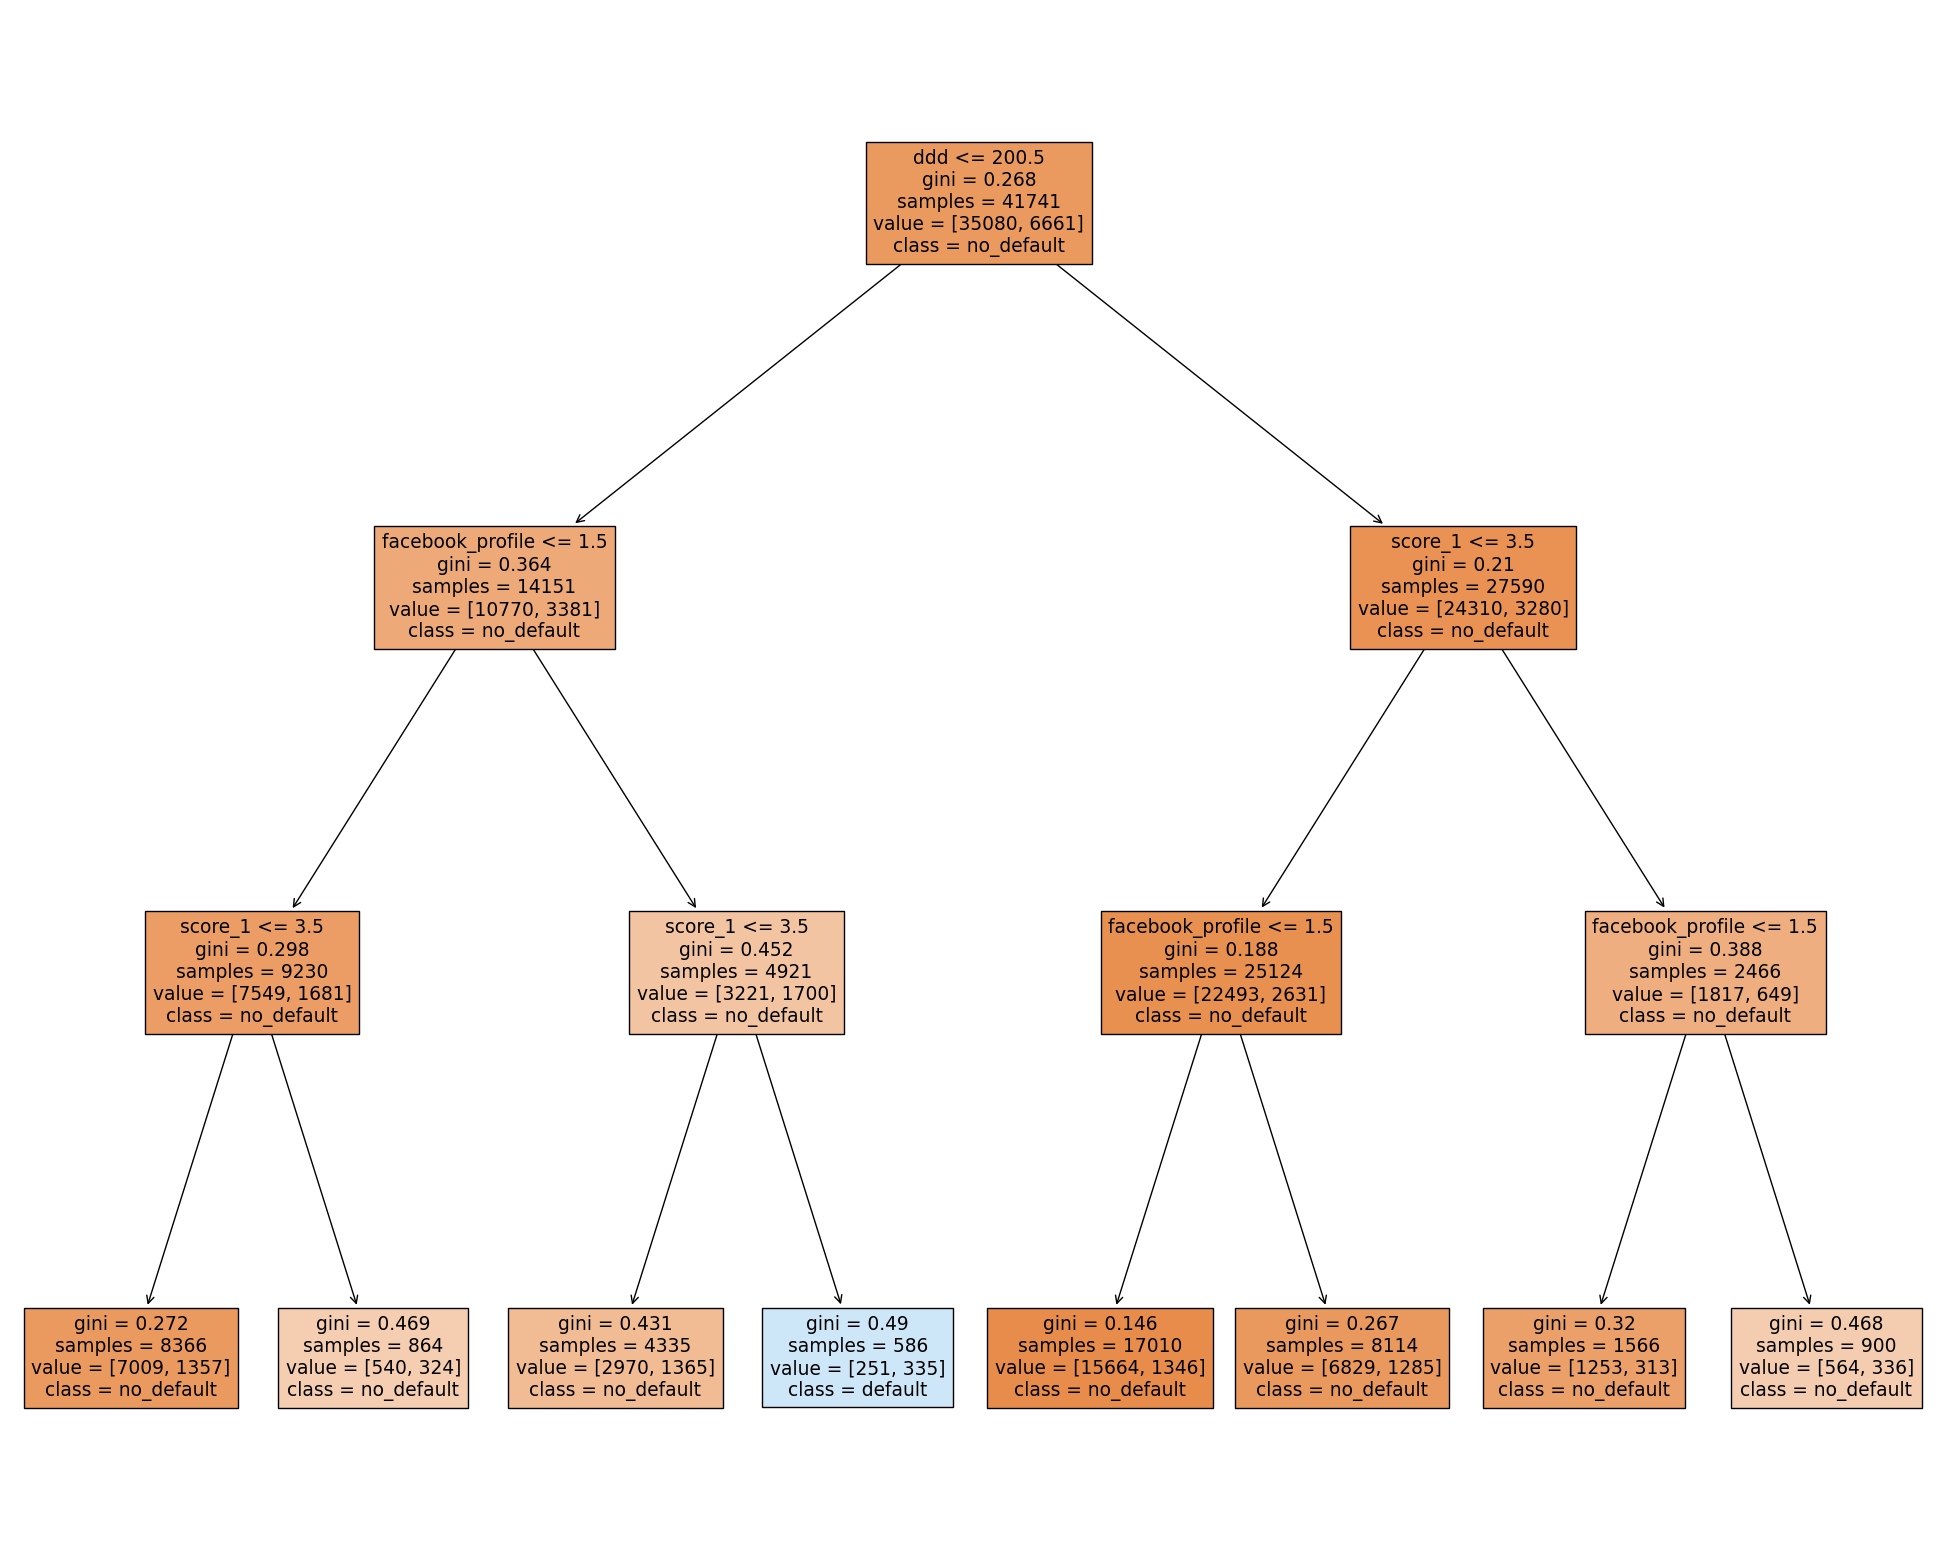

In [99]:
#@title Decision Tree pequena
fig = plt.figure(figsize=(25,20))

_ = tree.plot_tree(tree_clf, 
                   feature_names=df_clean.columns,  
                   class_names=['no_default', 'default'],
                   filled=True)

plt.show()

In [100]:
grid_pipe = Pipeline([
                      ('decision_tree', DecisionTreeClassifier()),
                    ])

In [101]:
param_grid = [
              {'decision_tree__max_depth': [3, 10, 50, 80], 
               'decision_tree__max_features': ['log2', 'sqrt', df_clean.shape[1]],
               'decision_tree__min_samples_split': [500, 1000, 2000],
               'decision_tree__splitter': ['best', 'random']},
             ]

grid_search = GridSearchCV(grid_pipe, param_grid, cv=5,
                            scoring='recall',
                            n_jobs=-1)

_ = grid_search.fit(df_clean, y_hat)

In [102]:
grid_search.best_params_

{'decision_tree__max_depth': 50,
 'decision_tree__max_features': 60,
 'decision_tree__min_samples_split': 1000,
 'decision_tree__splitter': 'best'}

In [103]:
tree_clf = grid_search.best_estimator_

In [104]:
score_full.append(return_scores(tree_clf, df_clean, y_hat, name='Decision Tree'))

<recall>: 0.079 recall_err: 0.021
<accuracy>: 0.841 accuracy_err: 0.001


In [105]:
feature_importances = tree_clf[0].feature_importances_

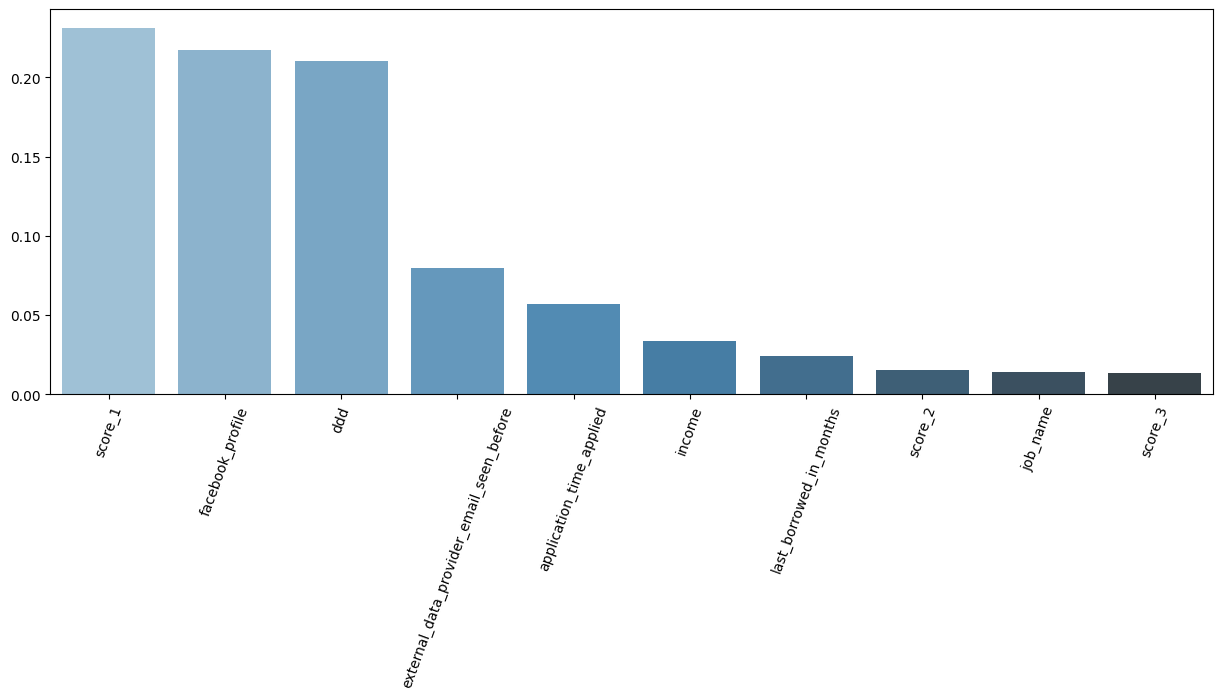

In [106]:
plt.figure(figsize=[15, 5])
top_10 = pd.DataFrame(feature_importances, index=df_clean.columns).sort_values(0, ascending=False).head(10)
top_features = list(top_10.index)

sns.barplot(data=top_10.T, palette="Blues_d")
plt.xticks(rotation=70)
plt.show()

## Random Forest

In [107]:
from sklearn.ensemble import RandomForestClassifier

In [108]:
grid_pipe = Pipeline([
                      ('rand_forest', RandomForestClassifier(n_jobs=-1, min_samples_split=500, random_state=42)),
                    ])

In [109]:
from sklearn.model_selection import GridSearchCV

param_grid = [
              {'rand_forest__n_estimators': [100, 200], 
               'rand_forest__max_features': ['sqrt', 20, df_clean.shape[1]]},
             ]

grid_search = GridSearchCV(grid_pipe, param_grid, cv=5,
                            scoring='recall',
                            n_jobs=-1)

_ = grid_search.fit(df_clean, y_hat)

In [110]:
grid_search.best_params_

{'rand_forest__max_features': 60, 'rand_forest__n_estimators': 100}

In [111]:
rand_forest = grid_search.best_estimator_

In [112]:
score_full.append(return_scores(rand_forest, df_clean, y_hat, name='Random Forest'))

<recall>: 0.072 recall_err: 0.014
<accuracy>: 0.843 accuracy_err: 0.001


In [113]:
feature_importances = rand_forest[0].feature_importances_

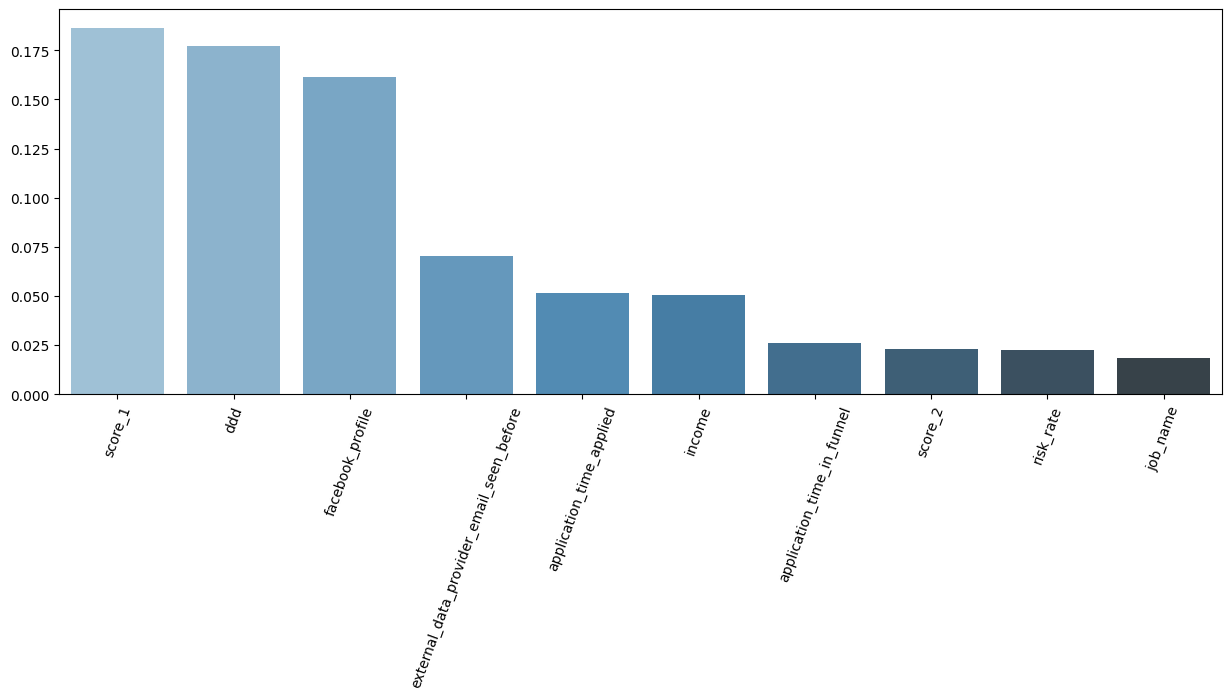

In [114]:
plt.figure(figsize=[15, 5])
top_10 = pd.DataFrame(feature_importances, index=df_clean.columns).sort_values(0, ascending=False).head(10)
top_features = list(top_10.index)
sns.barplot(data=top_10.T, palette="Blues_d")
plt.xticks(rotation=70)
plt.show()

## DNN

In [115]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.model_selection import KFold, StratifiedKFold

In [116]:
X = StandardScaler().fit_transform(df_clean)

In [117]:
def DNN_build(X_train):
    model = Sequential([
         Dense(10 * 60, input_shape=(X_train.shape[1], ), activation='relu'),
         Dropout(0.3),
         Dense(10 * 30, activation='relu'),
         Dense(10 * 15, activation='relu'),
         Dense(1, activation='sigmoid')                     
    ])

    model.compile(loss='binary_crossentropy', 
                  metrics=['Recall', tf.keras.metrics.AUC(curve='PR'), 'Accuracy'])
    return model

In [118]:
str_k_fold = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)

callbacks = tf.keras.callbacks.EarlyStopping(monitor='recall', patience=25,
                                             restore_best_weights=True)

scores_kfold = []

for train_idx, test_idx in str_k_fold.split(X, y_hat):

    class_weights = {0:y_hat[train_idx][y_hat[train_idx]==0].shape[0] / y_hat[train_idx].shape[0],
                     1:y_hat[train_idx][y_hat[train_idx]==1].shape[0] / y_hat[train_idx].shape[0]}

    model = []
    model = DNN_build(X[train_idx])

    hist = model.fit(X[train_idx], y_hat[train_idx],
                 batch_size=64,
                 verbose=0,
                 epochs=150,
                 #callbacks=callbacks,
                 #class_weight=class_weights,
                 )

    scores_kfold.append(model.evaluate(X[test_idx],
                                       y_hat[test_idx], verbose=0))

In [119]:
scores_kfold = np.asarray(scores_kfold)
mean_rec = np.mean(scores_kfold[:, 1])
std_rec = np.std(scores_kfold[:, 1])
pr_auc = np.mean(scores_kfold[:, 2])
mean_acc = np.mean(scores_kfold[:, 3])
std_acc = np.std(scores_kfold[:, 3])

print('<Recall>: {0}\n \nRecall_err: {1}\n \n<PR-AUC>: {2}\n \n<Acc>: {3}\n \nAcc_err: {4}'.format(np.round(mean_rec, 3),
                                                                                          np.round(std_rec, 3),
                                                                                          np.round(pr_auc, 3),
                                                                                          np.round(mean_acc, 3),
                                                                                          np.round(std_acc, 3)))

<Recall>: 0.365
 
Recall_err: 0.039
 
<PR-AUC>: 0.226
 
<Acc>: 0.698
 
Acc_err: 0.027


In [120]:
score_full.append([mean_rec, std_rec, mean_acc, std_acc, 'DNN'])

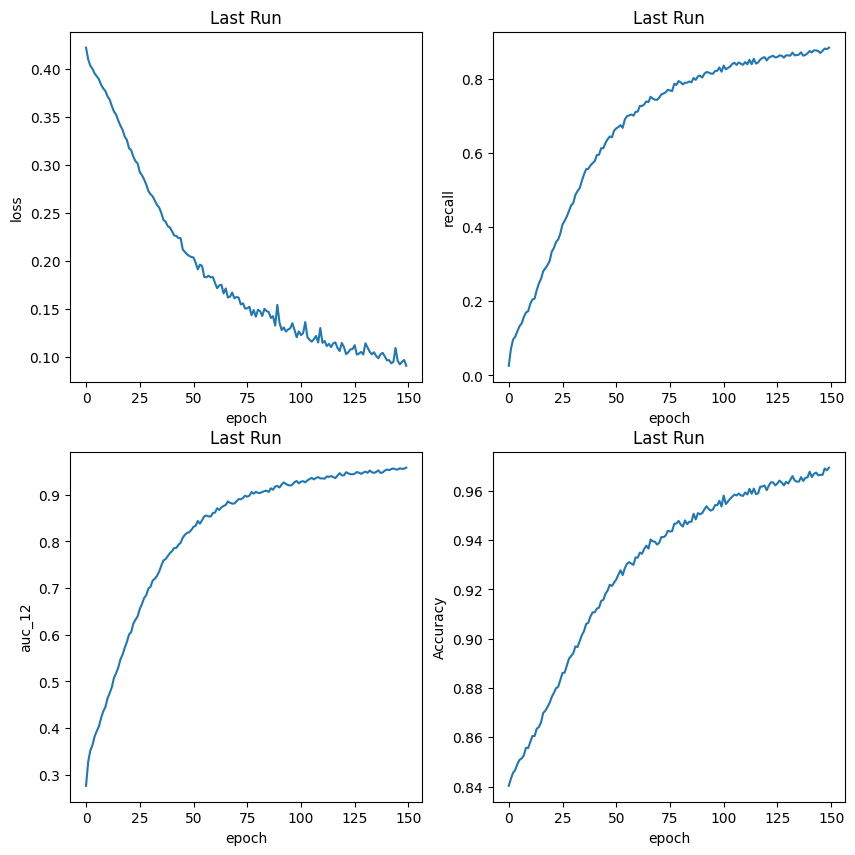

In [121]:
plt.figure(figsize=[10, 10])

keys = hist.history.keys()

for idx, key in enumerate(keys):
  
  plt.subplot(2, 2, idx + 1)

  y = hist.history[key]
  x = np.arange(len(y))
  plt.plot(y)
  plt.title('Last Run')
  plt.ylabel(key)
  plt.xlabel('epoch')

plt.show()

## Pipeline: Centraliza, Standariza, Transforma em Guassiana, Transforma em One Hot Enconde.

- Podemos usar essa mesma pipeline nos modelos de SVM e Logistic.

### Funções auxiliares

In [122]:
class OneHotEncoderTransform(BaseEstimator, TransformerMixin):
    
    '''
      Transformas o array X usando OneHotEncoder.
    '''

    def __init__(self, data_to_fit=[]):
        
        self.data_to_fit = data_to_fit

    def transform(self, X):

        aux = OneHotEncoder(drop='first', sparse=True)
        
        aux = aux.fit(self.data_to_fit)

        data = aux.transform(X)

        return data

    def fit(self, X, y=None):
        return self

### Features que serão pré-processadas

In [123]:
# Pré-processamento das features

# Features que irão passar pelo StandScaler.
num_cols = [
            'risk_rate',
            'score_3',
            'score_4',
            'score_5',
            'score_6',
            'external_data_provider_fraud_score',
           ]

# Features que irão passar pelo MinMax.
cat_cols = [
            'n_issues',         
            'facebook_profile', 
            'n_bankruptcies',
            'n_defaulted_loans',
            'last_amount_borrowed',
            'last_borrowed_in_months',
            'ok_since',
            'external_data_provider_email_seen_before',
            'application_time_applied',
            'application_time_in_funnel',
           ]

# Features que irão passar pelo QuantileTransformer.
to_norm = [
           'reported_income',
           'income',
           'n_accounts',
           'income_diff',]

# Features que irão passar pelo OneHotEncoder.
onehot_cols = [
                'score_1',
                'score_2',
                'real_state',
                'marketing_channel',
                'ddd', 
                'email',
                'reason',
                'job_name',
                'state',
                'zip',
                'shipping_state',
               ]

Checa se estou usando todas as variáveis.

In [124]:
assert set(cols) - set(num_cols + cat_cols + onehot_cols + to_norm) == set(tags_list), set(cols) - set(num_cols + cat_cols + onehot_cols + to_norm)

try:
  df_clean[num_cols + cat_cols + onehot_cols + to_norm]
except:
  print('Algumas colunas estão faltando.')
  df_clean[num_cols + cat_cols + onehot_cols + to_norm]

Pipeline

In [125]:
quant = QuantileTransformer(output_distribution='normal')

cols_scale = ColumnTransformer([
                                ('to_norm', quant, to_norm),
                                ('std', StandardScaler(), num_cols),
                                ('min_max', MinMaxScaler((-1, 1)), cat_cols),
                                ('one_hot', OneHotEncoderTransform(
                                    data_to_fit=df_clean[onehot_cols])
                                , onehot_cols)
                               ],
                                remainder='passthrough')

## Logistic Regression

In [126]:
from sklearn.linear_model import LogisticRegression

In [127]:
grid_pipe = Pipeline([('scale', cols_scale),
                      ('trSVD',  TruncatedSVD(n_components=100)),
                      #('pca',  PCA(n_components=15)), # Não pode ser usado com as matrizes esparsas.
                      ('log_regr', LogisticRegression(max_iter=1500, n_jobs=-1)),
                    ])

Grid search

In [128]:
param = [{"log_regr__penalty": ['l1', 'l2'],
              "log_regr__C": [1, 0.1, 0.01],
              "log_regr__solver": ['saga']},
         
         #{"log_regr__penalty": ['l1', 'l2'],
         #     "log_regr__C": [1, 0.1],
         #     "log_regr__solver": ['liblinear']},
         ]

grid_search = GridSearchCV(grid_pipe, param, cv=5,
                            scoring='recall', n_jobs=-1, error_score='raise')

_ = grid_search.fit(df_clean, y_hat)

In [129]:
grid_search.best_params_

{'log_regr__C': 1, 'log_regr__penalty': 'l2', 'log_regr__solver': 'saga'}

Avaliando o melhor modelo

In [130]:
logist_regr = grid_search.best_estimator_

In [131]:
score_full.append(return_scores(logist_regr, df_clean, y_hat, name='Logist'))

<recall>: 0.061 recall_err: 0.006
<accuracy>: 0.843 accuracy_err: 0.001


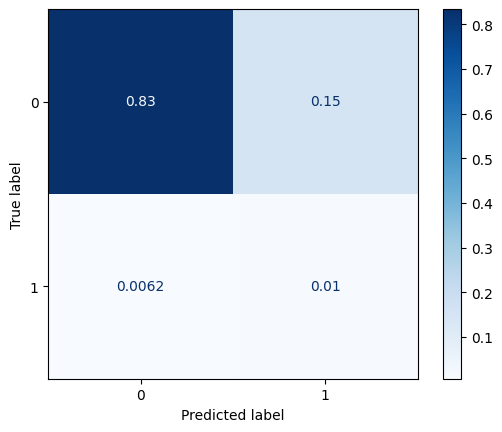

In [132]:
conf = confusion_matrix(logist_regr.predict(df_clean), y_hat, labels=logist_regr.classes_, normalize='all')
disp = ConfusionMatrixDisplay(conf)
disp.plot(cmap='Blues')
plt.show()

## Bagging


In [133]:
from sklearn.ensemble import BaggingClassifier

In [134]:
grid_pipe = Pipeline([('bg', BaggingClassifier( 
                                              n_estimators=200,
                                              n_jobs=-1,
                                              max_samples=0.5,
                                              ))
                    ])

In [135]:
param = [
         {"bg__base_estimator": [DecisionTreeClassifier(max_depth=2), 
                                 DecisionTreeClassifier(max_depth=3),
                                 DecisionTreeClassifier()],
          },
         ]

grid_search = GridSearchCV(grid_pipe, param, cv=5,
                            scoring='recall', n_jobs=-1)

_ = grid_search.fit(df_clean, y_hat)

In [136]:
grid_search.best_params_

{'bg__base_estimator': DecisionTreeClassifier()}

In [137]:
bag_clf = grid_search.best_estimator_

In [138]:
score_full.append(return_scores(bag_clf, df_clean, y_hat, name='Bagging'))

<recall>: 0.09 recall_err: 0.005
<accuracy>: 0.844 accuracy_err: 0.001


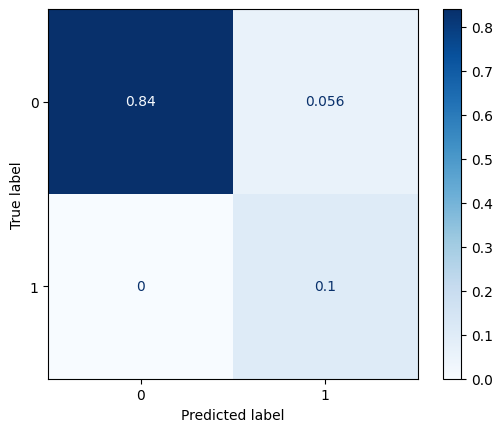

In [139]:
conf = confusion_matrix(bag_clf.predict(df_clean), y_hat, labels=bag_clf.classes_, normalize='all')
disp = ConfusionMatrixDisplay(conf)
disp.plot(cmap='Blues')
plt.show()

## Random Patches method

Sampling features and training instances

In [140]:
grid_pipe = Pipeline([('Rp',BaggingClassifier(
                                              max_features=0.6,
                                              bootstrap=True,
                                              bootstrap_features=True,
                                              n_jobs=-1,))
                    ])

In [141]:
param = [
         {"Rp__base_estimator": [DecisionTreeClassifier(max_depth=2), 
                                 DecisionTreeClassifier(max_depth=3),
                                 DecisionTreeClassifier()],
          },
         ]

grid_search = GridSearchCV(grid_pipe, param, cv=5,
                            scoring='recall', n_jobs=-1)

_ = grid_search.fit(df_clean, y_hat)

In [142]:
grid_search.best_params_

{'Rp__base_estimator': DecisionTreeClassifier()}

In [143]:
rpatch_clf = grid_search.best_estimator_

In [144]:
score_full.append(return_scores(rpatch_clf, df_clean, y_hat, name='Random Patches'))

<recall>: 0.025 recall_err: 0.008
<accuracy>: 0.837 accuracy_err: 0.001


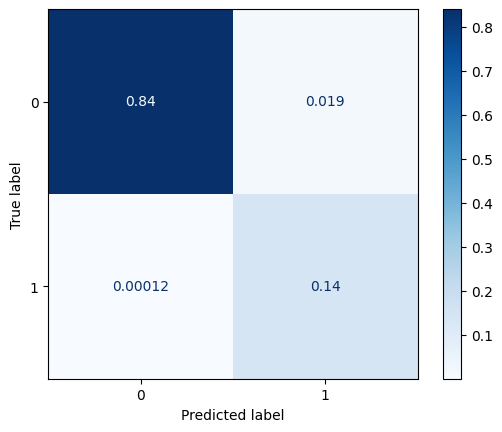

In [145]:
conf = confusion_matrix(rpatch_clf.predict(df_clean), y_hat, labels=rpatch_clf.classes_, normalize='all')
disp = ConfusionMatrixDisplay(conf)
disp.plot(cmap='Blues')
plt.show()

## Adaboost

In [146]:
from sklearn.ensemble import AdaBoostClassifier

In [147]:
ada_clf = AdaBoostClassifier(
DecisionTreeClassifier(max_depth=3), n_estimators=500,
algorithm="SAMME.R", learning_rate=0.1)

_ = ada_clf.fit(df_clean, y_hat)

In [148]:
score_full.append(return_scores(ada_clf, df_clean, y_hat, name='Adaboost'))

<recall>: 0.124 recall_err: 0.005
<accuracy>: 0.844 accuracy_err: 0.001


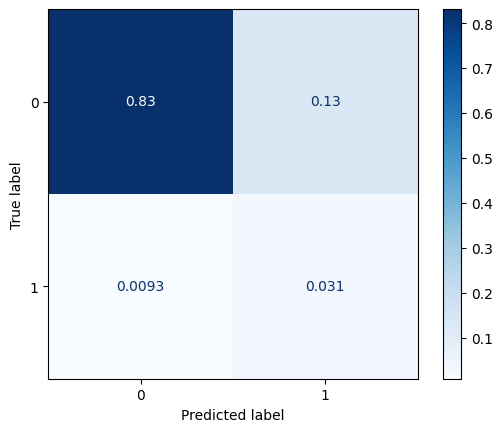

In [149]:
conf = confusion_matrix(ada_clf.predict(df_clean), y_hat, labels=ada_clf.classes_, normalize='all')
disp = ConfusionMatrixDisplay(conf)
disp.plot(cmap='Blues')
plt.show()

## Voting Classifiers

In [150]:
from sklearn.ensemble import VotingClassifier

In [151]:
voting_clf = VotingClassifier(
estimators=[
            ('logist_regression', logist_regr),
            ('random_forest', rand_forest), 
            # SVM will consume a lot of RAM.
            #('svm_classifier', svm_classifier.set_params(svm__probability=True)),
            ('decision_tree', tree_clf),
            ('bagging', bag_clf),
            ('adaboost', ada_clf),
            ],
            voting='soft', n_jobs=-1) #soft é com prob

In [152]:
_ = voting_clf.fit(df_clean, y_hat)

In [153]:
score_full.append(return_scores(voting_clf, df_clean, y_hat, name='Vonting - Soft'))

<recall>: 0.051 recall_err: 0.006
<accuracy>: 0.844 accuracy_err: 0.001


# Resultados

Resultados finais comparando todos os modelos.

In [154]:
#@title Resultados dos treinos
try:
  res_full = pd.DataFrame(score_full, columns=['rec_mean_full', 'rec_std_full',
                                               'acc_mean_full', 'acc_std_full', 'model'])
except:
  res_full = pd.DataFrame(columns=['model'])
  print('Sem os resultados do dataset completo.')

try:
  res_under = pd.DataFrame(score_under, columns=['rec_mean_under', 'rec_std_under',
                                                 'acc_mean_under', 'acc_std_under', 'model'])
except:
  res_under = pd.DataFrame(columns=['model'])
  print('Sem os resultados do Under Sample.')

print('\n')
res = pd.merge(res_full, res_under, on='model', how='outer')
res = res.set_index('model').dropna()
res

rec_mean_full  rec_std_full  acc_mean_full  acc_std_full  \
model                                                                      
Decision Tree        0.079119      0.020727       0.841139      0.001034   
Random Forest        0.071614      0.013521       0.843296      0.001262   
DNN                  0.364811      0.038912       0.697564      0.026604   
Logist               0.061252      0.005530       0.843487      0.001044   
Bagging              0.090376      0.005233       0.843966      0.000959   
Random Patches       0.024621      0.007560       0.836611      0.001000   
Adaboost             0.123855      0.005158       0.843918      0.000880   
Vonting - Soft       0.051495      0.006102       0.844158      0.000661   

                rec_mean_under  rec_std_under  acc_mean_under  acc_std_under  
model                                                                         
Decision Tree         0.629788       0.060359        0.611697       0.010401  
Random Forest         0.663866       0.006572        0.667468       0.004500  
DNN                   0.540767       0.042281        0.567410       0.022578  
Logist                0.659363       0.011815        0.658610       0.006768  
Bagging               0.657848       0.105186        0.614999       0.007696  
Random Patches        0.611169       0.039281        0.640370       0.011900  
Adaboost              0.633841       0.008001        0.651480       0.004493  
Vonting - Soft        0.652457       0.010123        0.664390       0.005105

# Backup dos resultados finais.

**_under:** Significa que os modelos foram treinados usando o dataset após o **RandomUnderSample**.

**_full:** Significa que os modelos foram treinados usando o dataset completo, i.e., com o desbalanço de classe.

| modelos        | rec_mean_full | rec_std_full | acc_mean_full | acc_std_full | rec_mean_under | rec_std_under | acc_mean_under | acc_std_under |   |
|----------------|---------------|--------------|---------------|--------------|----------------|---------------|----------------|---------------|---|
| Decision Tree  | 0.079119      | 0.020727     | 0.841139      | 0.001034     | 0.629788       | 0.060359      | 0.611697       | 0.010401      |   |
| Random Forest  | 0.071614      | 0.013521     | 0.843296      | 0.001262     | 0.663866       | 0.006572      | 0.667468       | 0.004500      |   |
| DNN            | **0.364811**      | **0.038912**     | **0.697564**      | **0.026604**     | 0.540767       | 0.042281      | 0.567410       | 0.022578      |   |
| Logist         | 0.061252      | 0.005530     | 0.843487      | 0.001044     | **0.659363**       | **0.011815**      | **0.658610**       | **0.006768**      |   |
| Bagging        | 0.090376      | 0.005233     | 0.843966      | 0.000959     | 0.657848       | 0.105186      | 0.614999       | 0.007696      |   |
| Random Patches | 0.024621      | 0.007560     | 0.836611      | 0.001000     | 0.611169       | 0.039281      | 0.640370       | 0.011900      |   |
| Adaboost       | 0.123855      | 0.005158     | 0.843918      | 0.000880     | 0.633841       | 0.008001      | 0.651480       | 0.004493      |   |
| Vonting - Soft | 0.051495      | 0.006102     | 0.844158      | 0.000661     | 0.652457       | 0.010123      | 0.664390       | 0.005105      |   |










-----------

# Comentários finais

Quando usamos o UnderSample, conseguimos treinar os modelos e obter bons resultados, com destaque para o algoritmo de Logistic Regression. 

Para o dataset completo, vemos o que já era esperado, a maioria dos modelos aprendem que prever a classe majoritária faz com que a taxa de acerto suba para no mínimo $84\%$. Esses modelos não tem capacidade de previsão e vemos claramente que a métrica de acurácia não é uma métrica boa para esse dataset. Uma métrica mais adequada é a Recall, que reflete a capacidade do modelo de fazer prever clientes que podem incorrer em default. O valor ideal para a Recall, onde conseguimos prever todos os clientes que incorrem em default, é o valor de $1$, enquanto $0$ é uma previsão ruim. Como esperado, os modelos que tem uma acurácia boa tem um Recall baixo, tendendo a zero. O único modelo que consegue fazer alguma previsão, após eu ter feito alguns ajustes, é a rede neural (DNN). Note que a rede neural tem uma acurácia baixa, $\approx 70\%$, mas o valor de Recall é de $0.3\%$, o melhor entre todos os modelos, apesar de ainda ser baixo. Novamente, vemos que a acurácia não é uma boa métrica para prever default.

Para melhorar a capacidade de previsão desses modelos, temos que gerar novas features que tenham maior relevância para a previsão. Possivelmente, com a ideia que discuti no começo do notebook, onde falei sobre procurar features que tenha assimetria. Porém, até onde tentei, nenhuma das features além das já discutidas, `facebook_profile`, `ddd`, `score_1`, `external_data_provider_email_seen_before` e `application_time_applied`, possuiam assimetrias. Além disso, features simples como dividir a taxa de risco do cliente pelo número de contas ou a diferença entre a o valor da renda indicada pelo cliente e o valor estimado por uma fonte externa, não melhoram o resultado e apresentam pouca correlação com o `target_default`.

Minha conclusão sobre o dataset é que temos que combinar novas features com modelos mais poderosos de Machine Learning, como a DNN, para gerar melhores resultados.

-----------

# Referências

[Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow - Livro](https://books.google.com.br/books?hl=pt-BR&lr=&id=HHetDwAAQBAJ&oi=fnd&pg=PP1&dq=Hands-On+Machine+Learning+with+Scikit-Learn,+Keras,+and+TensorFlow,+2nd+Edition&ots=0LrgYwlhPo&sig=m1P6TZJ8xDORODO2uV_8b3RfqsM#v=onepage&q=Hands-On%20Machine%20Learning%20with%20Scikit-Learn%2C%20Keras%2C%20and%20TensorFlow%2C%202nd%20Edition&f=false)

[RGivisiez - Site Pessoal](https://github.com/RGivisiez/RGivisiez.github.io)

